In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
weight_bit_width = 8
act_bit_width = 8
kernel_size=(3,3)  
in_channel_0=1
out_channel_0=64 
in_channel_1=out_channel_0
out_channel_1=64
input_length = 7*7*out_channel_1
hidden_0 = 64   
output_length = 10 

In [3]:
class CNN(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNN, self).__init__()
        
        self.input = qnn.QuantIdentity(
                         quant_type='int',
                         scaling_impl_type='const',
                         bit_width=act_bit_width,
                         min_val=-128.0,
                         max_val=127.0, 
                         return_quant_tensor=True
                     )
        
        self.conv0 = qnn.QuantConv2d( 
                         in_channels=in_channel_0,
                         out_channels=out_channel_0,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn0   = nn.BatchNorm2d(out_channel_0)
        self.act0  = nn.SiLU()
        self.quan0 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=act_bit_width, min_val=-128.0, max_val=127.0, return_quant_tensor=True)
        self.drop0 = nn.Dropout(dropout)
        
        self.pool0 = nn.MaxPool2d(2)
        
        self.conv1 = qnn.QuantConv2d( 
                         in_channels=in_channel_1,
                         out_channels=out_channel_1,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn1   = nn.BatchNorm2d(out_channel_1)
        self.act1  = nn.SiLU()
        self.quan1 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=act_bit_width, min_val=-128.0, max_val=127.0, return_quant_tensor=True)
        self.drop1 = nn.Dropout(dropout)
        
        self.pool1 = nn.MaxPool2d(2)
        
        self.fc2   = qnn.QuantLinear(
                         input_length, 
                         hidden_0, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn2   = nn.BatchNorm1d(hidden_0)
        self.act2  = nn.SiLU()
        self.quan2 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=act_bit_width, min_val=-128.0, max_val=127.0, return_quant_tensor=True)
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(
                         hidden_0, 
                         output_length, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )

    def forward(self, x):
        out = self.input(x)
        out = self.pool0(self.drop0(self.quan0(self.act0(self.bn0(self.conv0(out))))))
        out = self.pool1(self.drop1(self.quan1(self.act1(self.bn1(self.conv1(out))))))
        out = out.reshape(out.shape[0], -1)
        out = self.drop2(self.quan2(self.act2(self.bn2(self.fc2(out)))))
        out = self.out(out)
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model = CNN(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
        
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  return F.conv2d(input, weight, bias, self.stride,
/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1196, Acc: 0.9652 | Val Loss: 0.0594, Acc: 0.9805


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9822 | Val Loss: 0.0471, Acc: 0.9870


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9869 | Val Loss: 0.0525, Acc: 0.9856


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9897 | Val Loss: 0.0481, Acc: 0.9869


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.0701, Acc: 0.9807


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9914 | Val Loss: 0.0484, Acc: 0.9870


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9921 | Val Loss: 0.0518, Acc: 0.9868


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0538, Acc: 0.9862


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.0624, Acc: 0.9862


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9950 | Val Loss: 0.0585, Acc: 0.9884


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 0.0598, Acc: 0.9884


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0516, Acc: 0.9880


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0584, Acc: 0.9889


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0627, Acc: 0.9892


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9963 | Val Loss: 0.0711, Acc: 0.9862


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0552, Acc: 0.9912


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0612, Acc: 0.9881


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0674, Acc: 0.9896


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.0671, Acc: 0.9892


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0615, Acc: 0.9913


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0790, Acc: 0.9883


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9974 | Val Loss: 0.0612, Acc: 0.9904


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.0610, Acc: 0.9904


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9977 | Val Loss: 0.0739, Acc: 0.9906


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0681, Acc: 0.9898


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.0825, Acc: 0.9893


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.0782, Acc: 0.9894


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9978 | Val Loss: 0.0778, Acc: 0.9888


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.0762, Acc: 0.9903


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0962, Acc: 0.9892


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.0968, Acc: 0.9880


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9981 | Val Loss: 0.1004, Acc: 0.9888


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.0890, Acc: 0.9876


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0880, Acc: 0.9892


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1002, Acc: 0.9890


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9983 | Val Loss: 0.0845, Acc: 0.9904


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0883, Acc: 0.9908


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9984 | Val Loss: 0.0837, Acc: 0.9900


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9986 | Val Loss: 0.0857, Acc: 0.9906


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0858, Acc: 0.9907


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1007, Acc: 0.9903


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1127, Acc: 0.9900


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9984 | Val Loss: 0.1270, Acc: 0.9888


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9988 | Val Loss: 0.1153, Acc: 0.9895


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1008, Acc: 0.9909


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.1100, Acc: 0.9899


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1141, Acc: 0.9901


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1061, Acc: 0.9906


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9985 | Val Loss: 0.1223, Acc: 0.9894


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.1002, Acc: 0.9910


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9989 | Val Loss: 0.1205, Acc: 0.9899


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9989 | Val Loss: 0.1158, Acc: 0.9892


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9987 | Val Loss: 0.1080, Acc: 0.9904


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9987 | Val Loss: 0.1132, Acc: 0.9907


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.1175, Acc: 0.9904


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9993 | Val Loss: 0.0976, Acc: 0.9914


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9985 | Val Loss: 0.1259, Acc: 0.9895


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.1186, Acc: 0.9898


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9986 | Val Loss: 0.1262, Acc: 0.9897


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9988 | Val Loss: 0.1227, Acc: 0.9901


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9991 | Val Loss: 0.1458, Acc: 0.9890


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.1339, Acc: 0.9891


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9989 | Val Loss: 0.1456, Acc: 0.9895


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1489, Acc: 0.9888


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.1451, Acc: 0.9896


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9989 | Val Loss: 0.1420, Acc: 0.9899


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9991 | Val Loss: 0.1274, Acc: 0.9908


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9991 | Val Loss: 0.1691, Acc: 0.9878


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9990 | Val Loss: 0.1397, Acc: 0.9899


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9993 | Val Loss: 0.1481, Acc: 0.9891


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9988 | Val Loss: 0.1172, Acc: 0.9910


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9991 | Val Loss: 0.1299, Acc: 0.9905


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9990 | Val Loss: 0.1293, Acc: 0.9912


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9993 | Val Loss: 0.1420, Acc: 0.9908


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9988 | Val Loss: 0.1434, Acc: 0.9899


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9992 | Val Loss: 0.1490, Acc: 0.9905


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9986 | Val Loss: 0.1371, Acc: 0.9903


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9990 | Val Loss: 0.1392, Acc: 0.9908


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9996 | Val Loss: 0.1231, Acc: 0.9912


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9990 | Val Loss: 0.1418, Acc: 0.9895


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9990 | Val Loss: 0.1577, Acc: 0.9892


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9989 | Val Loss: 0.1321, Acc: 0.9911


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9993 | Val Loss: 0.1344, Acc: 0.9910


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9990 | Val Loss: 0.1523, Acc: 0.9898


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9992 | Val Loss: 0.1645, Acc: 0.9904


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9994 | Val Loss: 0.1403, Acc: 0.9912


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9990 | Val Loss: 0.1183, Acc: 0.9914


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.1248, Acc: 0.9906


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9990 | Val Loss: 0.1369, Acc: 0.9918


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9991 | Val Loss: 0.1513, Acc: 0.9898


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9992 | Val Loss: 0.1528, Acc: 0.9907


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9991 | Val Loss: 0.1330, Acc: 0.9918


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9996 | Val Loss: 0.1382, Acc: 0.9912


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9994 | Val Loss: 0.1234, Acc: 0.9911


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.1349, Acc: 0.9900


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9989 | Val Loss: 0.1608, Acc: 0.9898


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9993 | Val Loss: 0.1390, Acc: 0.9912


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9991 | Val Loss: 0.1212, Acc: 0.9912


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9993 | Val Loss: 0.1228, Acc: 0.9911


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9996 | Val Loss: 0.1288, Acc: 0.9912


Final Test Loss: 0.1532 Accuracy: 0.9888


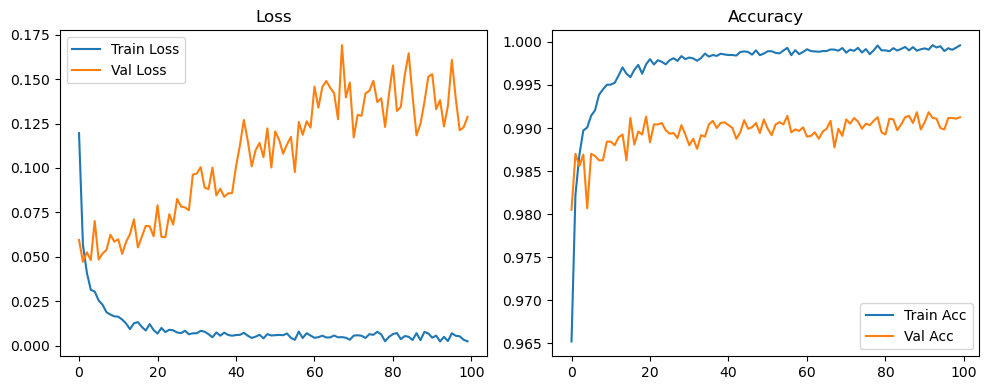

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1475, Acc: 0.9573 | Val Loss: 0.1246, Acc: 0.9595


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9771 | Val Loss: 0.0786, Acc: 0.9768


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9814 | Val Loss: 0.0672, Acc: 0.9788


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9829 | Val Loss: 0.0617, Acc: 0.9813


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9851 | Val Loss: 0.0655, Acc: 0.9792


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9856 | Val Loss: 0.0467, Acc: 0.9857


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9875 | Val Loss: 0.0694, Acc: 0.9810


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9882 | Val Loss: 0.0530, Acc: 0.9838


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9891 | Val Loss: 0.0529, Acc: 0.9850


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9892 | Val Loss: 0.0707, Acc: 0.9802


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9906 | Val Loss: 0.0627, Acc: 0.9845


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9915 | Val Loss: 0.0521, Acc: 0.9859


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9906 | Val Loss: 0.0601, Acc: 0.9825


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9921 | Val Loss: 0.0499, Acc: 0.9872


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0569, Acc: 0.9838


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0597, Acc: 0.9846


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9924 | Val Loss: 0.0473, Acc: 0.9887


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9934 | Val Loss: 0.0498, Acc: 0.9875


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9936 | Val Loss: 0.0579, Acc: 0.9861


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9935 | Val Loss: 0.0601, Acc: 0.9858


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9930 | Val Loss: 0.0518, Acc: 0.9870


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0475, Acc: 0.9891


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9943 | Val Loss: 0.0619, Acc: 0.9859


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0503, Acc: 0.9879


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.0618, Acc: 0.9852


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0593, Acc: 0.9863


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9942 | Val Loss: 0.0720, Acc: 0.9842


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.0612, Acc: 0.9874


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9945 | Val Loss: 0.0565, Acc: 0.9868


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.0693, Acc: 0.9873


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9948 | Val Loss: 0.0576, Acc: 0.9877


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9957 | Val Loss: 0.0745, Acc: 0.9848


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9951 | Val Loss: 0.0477, Acc: 0.9883


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9951 | Val Loss: 0.0570, Acc: 0.9866


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9958 | Val Loss: 0.0589, Acc: 0.9863


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9952 | Val Loss: 0.0736, Acc: 0.9818


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9951 | Val Loss: 0.0607, Acc: 0.9867


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9953 | Val Loss: 0.0547, Acc: 0.9856


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9967 | Val Loss: 0.0695, Acc: 0.9853


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9965 | Val Loss: 0.0650, Acc: 0.9878


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9960 | Val Loss: 0.0683, Acc: 0.9847


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9958 | Val Loss: 0.0667, Acc: 0.9860


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9953 | Val Loss: 0.0661, Acc: 0.9873


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9961 | Val Loss: 0.0642, Acc: 0.9884


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9963 | Val Loss: 0.0662, Acc: 0.9868


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9965 | Val Loss: 0.0451, Acc: 0.9912


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9959 | Val Loss: 0.0761, Acc: 0.9856


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9965 | Val Loss: 0.0644, Acc: 0.9874


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.0648, Acc: 0.9869


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9962 | Val Loss: 0.0675, Acc: 0.9858


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9962 | Val Loss: 0.0783, Acc: 0.9830


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9965 | Val Loss: 0.0682, Acc: 0.9864


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9968 | Val Loss: 0.0707, Acc: 0.9869


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9961 | Val Loss: 0.0617, Acc: 0.9878


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.0683, Acc: 0.9870


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9967 | Val Loss: 0.0667, Acc: 0.9883


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.0665, Acc: 0.9888


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9965 | Val Loss: 0.0675, Acc: 0.9881


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9971 | Val Loss: 0.0603, Acc: 0.9892


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9965 | Val Loss: 0.0803, Acc: 0.9858


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.0744, Acc: 0.9878


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9965 | Val Loss: 0.0866, Acc: 0.9862


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9971 | Val Loss: 0.0694, Acc: 0.9878


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9972 | Val Loss: 0.0848, Acc: 0.9863


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9967 | Val Loss: 0.0736, Acc: 0.9871


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9974 | Val Loss: 0.0592, Acc: 0.9884


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9971 | Val Loss: 0.0634, Acc: 0.9872


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9972 | Val Loss: 0.0714, Acc: 0.9881


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9965 | Val Loss: 0.0861, Acc: 0.9868


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9972 | Val Loss: 0.0786, Acc: 0.9870


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9976 | Val Loss: 0.0666, Acc: 0.9892


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9971 | Val Loss: 0.0761, Acc: 0.9862


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9972 | Val Loss: 0.0707, Acc: 0.9892


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9969 | Val Loss: 0.0709, Acc: 0.9878


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.0736, Acc: 0.9882


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9978 | Val Loss: 0.0749, Acc: 0.9872


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9972 | Val Loss: 0.0742, Acc: 0.9888


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9972 | Val Loss: 0.0817, Acc: 0.9858


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9969 | Val Loss: 0.0703, Acc: 0.9882


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9973 | Val Loss: 0.0714, Acc: 0.9868


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9975 | Val Loss: 0.0617, Acc: 0.9886


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9975 | Val Loss: 0.0636, Acc: 0.9877


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9972 | Val Loss: 0.0778, Acc: 0.9872


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9975 | Val Loss: 0.0726, Acc: 0.9880


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9976 | Val Loss: 0.0622, Acc: 0.9888


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9974 | Val Loss: 0.0675, Acc: 0.9880


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9976 | Val Loss: 0.0817, Acc: 0.9870


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9976 | Val Loss: 0.0739, Acc: 0.9880


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9979 | Val Loss: 0.0969, Acc: 0.9848


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9973 | Val Loss: 0.0685, Acc: 0.9888


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9979 | Val Loss: 0.0791, Acc: 0.9873


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9979 | Val Loss: 0.0756, Acc: 0.9867


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9976 | Val Loss: 0.0699, Acc: 0.9882


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9975 | Val Loss: 0.0670, Acc: 0.9882


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9980 | Val Loss: 0.0641, Acc: 0.9909


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9975 | Val Loss: 0.0769, Acc: 0.9882


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9982 | Val Loss: 0.0688, Acc: 0.9888


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9975 | Val Loss: 0.0868, Acc: 0.9858


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9977 | Val Loss: 0.0611, Acc: 0.9895


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9975 | Val Loss: 0.0670, Acc: 0.9872


Final Test Loss: 0.0633 Accuracy: 0.9875


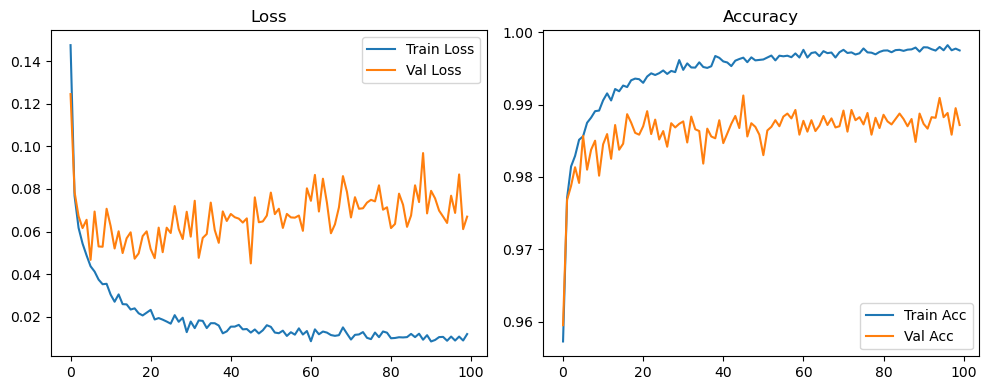

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2489, Acc: 0.9264 | Val Loss: 0.8132, Acc: 0.7140


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1488, Acc: 0.9571 | Val Loss: 0.4903, Acc: 0.8302


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1246, Acc: 0.9639 | Val Loss: 0.4291, Acc: 0.8558


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1159, Acc: 0.9662 | Val Loss: 0.3344, Acc: 0.8894


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1116, Acc: 0.9679 | Val Loss: 0.3259, Acc: 0.8902


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1033, Acc: 0.9689 | Val Loss: 0.2211, Acc: 0.9278


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9721 | Val Loss: 0.1438, Acc: 0.9590


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1007, Acc: 0.9706 | Val Loss: 0.2266, Acc: 0.9294


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0908, Acc: 0.9726 | Val Loss: 0.2706, Acc: 0.9072


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9740 | Val Loss: 0.1808, Acc: 0.9373


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0870, Acc: 0.9740 | Val Loss: 0.1436, Acc: 0.9575


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0813, Acc: 0.9750 | Val Loss: 0.1420, Acc: 0.9551


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0789, Acc: 0.9765 | Val Loss: 0.1536, Acc: 0.9503


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0797, Acc: 0.9769 | Val Loss: 0.1544, Acc: 0.9477


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0759, Acc: 0.9765 | Val Loss: 0.1539, Acc: 0.9522


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9779 | Val Loss: 0.1963, Acc: 0.9302


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9786 | Val Loss: 0.1438, Acc: 0.9553


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9786 | Val Loss: 0.1882, Acc: 0.9326


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9792 | Val Loss: 0.1497, Acc: 0.9453


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9794 | Val Loss: 0.1886, Acc: 0.9211


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9807 | Val Loss: 0.1472, Acc: 0.9426


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9796 | Val Loss: 0.1499, Acc: 0.9482


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9796 | Val Loss: 0.1357, Acc: 0.9590


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0699, Acc: 0.9800 | Val Loss: 0.2012, Acc: 0.9231


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9799 | Val Loss: 0.1644, Acc: 0.9427


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9814 | Val Loss: 0.1602, Acc: 0.9507


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9821 | Val Loss: 0.1941, Acc: 0.9258


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9803 | Val Loss: 0.1748, Acc: 0.9426


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9817 | Val Loss: 0.1781, Acc: 0.9415


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9813 | Val Loss: 0.2349, Acc: 0.9195


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9817 | Val Loss: 0.1844, Acc: 0.9425


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9826 | Val Loss: 0.1954, Acc: 0.9294


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9820 | Val Loss: 0.1790, Acc: 0.9478


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9827 | Val Loss: 0.2120, Acc: 0.9222


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9829 | Val Loss: 0.1718, Acc: 0.9395


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9832 | Val Loss: 0.2280, Acc: 0.9207


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9827 | Val Loss: 0.1756, Acc: 0.9396


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9830 | Val Loss: 0.2276, Acc: 0.9180


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9836 | Val Loss: 0.1627, Acc: 0.9458


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9841 | Val Loss: 0.2048, Acc: 0.9282


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9838 | Val Loss: 0.1810, Acc: 0.9460


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9833 | Val Loss: 0.1391, Acc: 0.9593


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9834 | Val Loss: 0.2099, Acc: 0.9190


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9847 | Val Loss: 0.2088, Acc: 0.9254


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9836 | Val Loss: 0.1767, Acc: 0.9491


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9855 | Val Loss: 0.2282, Acc: 0.9200


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9844 | Val Loss: 0.1950, Acc: 0.9338


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9835 | Val Loss: 0.1977, Acc: 0.9375


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9844 | Val Loss: 0.2244, Acc: 0.9206


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9845 | Val Loss: 0.2165, Acc: 0.9238


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9854 | Val Loss: 0.2035, Acc: 0.9199


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9848 | Val Loss: 0.1489, Acc: 0.9536


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9856 | Val Loss: 0.2205, Acc: 0.9091


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9848 | Val Loss: 0.2359, Acc: 0.9182


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9855 | Val Loss: 0.2000, Acc: 0.9223


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9849 | Val Loss: 0.2018, Acc: 0.9232


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9850 | Val Loss: 0.1880, Acc: 0.9387


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9847 | Val Loss: 0.2526, Acc: 0.8858


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9851 | Val Loss: 0.2057, Acc: 0.9277


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9855 | Val Loss: 0.1840, Acc: 0.9492


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9845 | Val Loss: 0.1976, Acc: 0.9231


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9848 | Val Loss: 0.1762, Acc: 0.9389


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9849 | Val Loss: 0.2336, Acc: 0.9042


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9858 | Val Loss: 0.1849, Acc: 0.9356


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9861 | Val Loss: 0.2171, Acc: 0.9097


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9853 | Val Loss: 0.1602, Acc: 0.9427


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9854 | Val Loss: 0.1833, Acc: 0.9257


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9864 | Val Loss: 0.1511, Acc: 0.9457


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9856 | Val Loss: 0.2145, Acc: 0.9207


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9871 | Val Loss: 0.2516, Acc: 0.8899


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9864 | Val Loss: 0.1488, Acc: 0.9576


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9859 | Val Loss: 0.2470, Acc: 0.9100


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9875 | Val Loss: 0.2326, Acc: 0.9088


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9869 | Val Loss: 0.2608, Acc: 0.8978


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9863 | Val Loss: 0.1912, Acc: 0.9368


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9871 | Val Loss: 0.1782, Acc: 0.9438


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9860 | Val Loss: 0.1763, Acc: 0.9383


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9861 | Val Loss: 0.1698, Acc: 0.9484


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9862 | Val Loss: 0.1620, Acc: 0.9438


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9871 | Val Loss: 0.1837, Acc: 0.9297


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9861 | Val Loss: 0.1904, Acc: 0.9306


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9867 | Val Loss: 0.1874, Acc: 0.9297


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9866 | Val Loss: 0.1771, Acc: 0.9410


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9877 | Val Loss: 0.2188, Acc: 0.9288


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9870 | Val Loss: 0.1684, Acc: 0.9498


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9874 | Val Loss: 0.1994, Acc: 0.9273


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9876 | Val Loss: 0.1777, Acc: 0.9336


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9868 | Val Loss: 0.2098, Acc: 0.9229


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9865 | Val Loss: 0.2197, Acc: 0.9161


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9864 | Val Loss: 0.1604, Acc: 0.9446


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9882 | Val Loss: 0.2158, Acc: 0.9079


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9869 | Val Loss: 0.2005, Acc: 0.9245


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9870 | Val Loss: 0.2618, Acc: 0.8865


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9874 | Val Loss: 0.2029, Acc: 0.9384


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9867 | Val Loss: 0.2754, Acc: 0.8774


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9875 | Val Loss: 0.1700, Acc: 0.9446


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9871 | Val Loss: 0.2020, Acc: 0.9184


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9876 | Val Loss: 0.1638, Acc: 0.9477


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9871 | Val Loss: 0.2150, Acc: 0.9172


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9876 | Val Loss: 0.2052, Acc: 0.9192


Final Test Loss: 0.2090 Accuracy: 0.9189


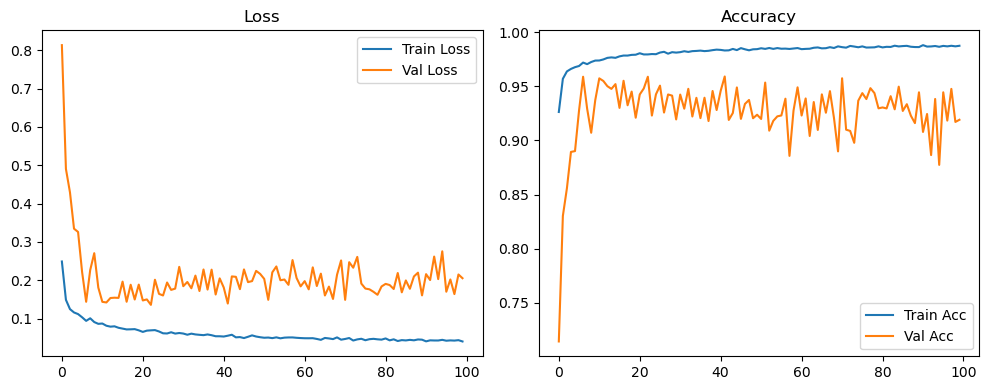

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1205, Acc: 0.9649 | Val Loss: 0.0594, Acc: 0.9816


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9835 | Val Loss: 0.0620, Acc: 0.9815


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9864 | Val Loss: 0.0488, Acc: 0.9857


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9893 | Val Loss: 0.0461, Acc: 0.9860


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0443, Acc: 0.9863


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.0438, Acc: 0.9882


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.0476, Acc: 0.9880


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9933 | Val Loss: 0.0566, Acc: 0.9870


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0420, Acc: 0.9892


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0566, Acc: 0.9875


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.0611, Acc: 0.9874


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0540, Acc: 0.9877


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0484, Acc: 0.9896


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.0522, Acc: 0.9887


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.0516, Acc: 0.9894


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0580, Acc: 0.9898


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.0616, Acc: 0.9888


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9963 | Val Loss: 0.0597, Acc: 0.9886


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.0532, Acc: 0.9909


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0652, Acc: 0.9892


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9975 | Val Loss: 0.0608, Acc: 0.9902


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0676, Acc: 0.9904


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0626, Acc: 0.9913


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9973 | Val Loss: 0.0715, Acc: 0.9902


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9974 | Val Loss: 0.0748, Acc: 0.9891


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.0753, Acc: 0.9898


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9984 | Val Loss: 0.0808, Acc: 0.9883


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0845, Acc: 0.9882


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.0991, Acc: 0.9885


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9971 | Val Loss: 0.0645, Acc: 0.9912


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.0803, Acc: 0.9902


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9986 | Val Loss: 0.0867, Acc: 0.9897


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9976 | Val Loss: 0.0902, Acc: 0.9904


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9983 | Val Loss: 0.0889, Acc: 0.9898


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9980 | Val Loss: 0.0890, Acc: 0.9908


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9984 | Val Loss: 0.0771, Acc: 0.9901


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.0848, Acc: 0.9888


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9984 | Val Loss: 0.0871, Acc: 0.9901


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0905, Acc: 0.9889


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.0873, Acc: 0.9902


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.0983, Acc: 0.9890


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9986 | Val Loss: 0.1012, Acc: 0.9901


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9982 | Val Loss: 0.1081, Acc: 0.9897


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9984 | Val Loss: 0.0959, Acc: 0.9900


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9986 | Val Loss: 0.0969, Acc: 0.9900


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0894, Acc: 0.9908


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9988 | Val Loss: 0.1003, Acc: 0.9910


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9984 | Val Loss: 0.1092, Acc: 0.9899


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9986 | Val Loss: 0.1047, Acc: 0.9897


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9986 | Val Loss: 0.1051, Acc: 0.9901


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0905, Acc: 0.9909


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0857, Acc: 0.9910


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.0859, Acc: 0.9912


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0913, Acc: 0.9914


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0826, Acc: 0.9912


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0832, Acc: 0.9907


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0898, Acc: 0.9912


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0880, Acc: 0.9918


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0971, Acc: 0.9910


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0963, Acc: 0.9906


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1002, Acc: 0.9907


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0860, Acc: 0.9916


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0980, Acc: 0.9916


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0933, Acc: 0.9920


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0950, Acc: 0.9922


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0956, Acc: 0.9920


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.1058, Acc: 0.9908


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0871, Acc: 0.9922


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0906, Acc: 0.9915


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1012, Acc: 0.9920


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1007, Acc: 0.9912


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1030, Acc: 0.9918


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0909, Acc: 0.9917


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1099, Acc: 0.9908


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1078, Acc: 0.9912


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0983, Acc: 0.9921


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1157, Acc: 0.9916


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0967, Acc: 0.9921


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0936, Acc: 0.9917


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1233, Acc: 0.9908


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1041, Acc: 0.9916


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1015, Acc: 0.9918


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1022, Acc: 0.9919


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0977, Acc: 0.9916


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1072, Acc: 0.9912


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0930, Acc: 0.9918


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0911, Acc: 0.9922


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0974, Acc: 0.9921


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0983, Acc: 0.9925


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1045, Acc: 0.9929


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1075, Acc: 0.9918


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0924, Acc: 0.9925


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1009, Acc: 0.9922


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0961, Acc: 0.9917


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1040, Acc: 0.9926


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0936, Acc: 0.9932


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1004, Acc: 0.9928


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0951, Acc: 0.9926


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0986, Acc: 0.9928


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0958, Acc: 0.9932


Final Test Loss: 0.1035 Accuracy: 0.9920


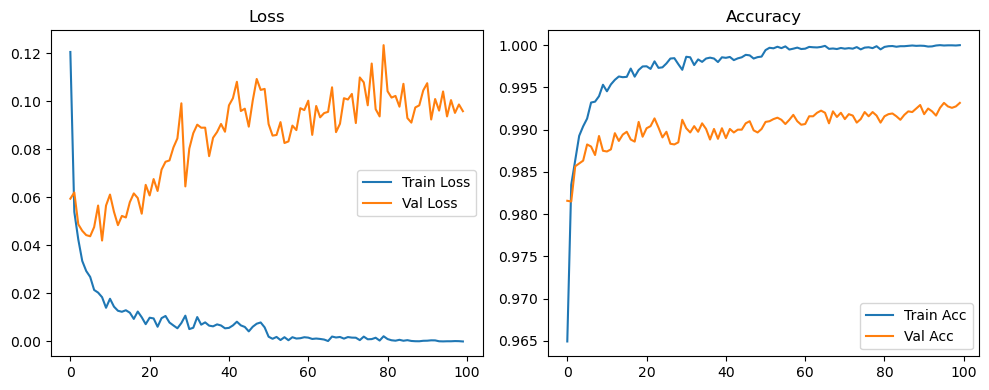

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1484, Acc: 0.9565 | Val Loss: 0.1171, Acc: 0.9642


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9766 | Val Loss: 0.0670, Acc: 0.9791


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9807 | Val Loss: 0.0807, Acc: 0.9756


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9823 | Val Loss: 0.0596, Acc: 0.9814


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9853 | Val Loss: 0.0557, Acc: 0.9834


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9861 | Val Loss: 0.0642, Acc: 0.9814


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9871 | Val Loss: 0.0738, Acc: 0.9790


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9874 | Val Loss: 0.0565, Acc: 0.9839


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9891 | Val Loss: 0.0493, Acc: 0.9867


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9895 | Val Loss: 0.0518, Acc: 0.9856


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9902 | Val Loss: 0.0749, Acc: 0.9802


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9916 | Val Loss: 0.0512, Acc: 0.9862


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9908 | Val Loss: 0.0684, Acc: 0.9819


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.0542, Acc: 0.9866


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9919 | Val Loss: 0.0618, Acc: 0.9842


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9930 | Val Loss: 0.0611, Acc: 0.9839


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9924 | Val Loss: 0.0596, Acc: 0.9863


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9926 | Val Loss: 0.0444, Acc: 0.9875


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9932 | Val Loss: 0.0574, Acc: 0.9870


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9937 | Val Loss: 0.0491, Acc: 0.9878


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9935 | Val Loss: 0.0532, Acc: 0.9870


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9939 | Val Loss: 0.0534, Acc: 0.9885


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9944 | Val Loss: 0.0553, Acc: 0.9878


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9942 | Val Loss: 0.0630, Acc: 0.9869


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9946 | Val Loss: 0.0599, Acc: 0.9861


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9943 | Val Loss: 0.0533, Acc: 0.9878


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9952 | Val Loss: 0.0618, Acc: 0.9869


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9949 | Val Loss: 0.0647, Acc: 0.9849


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9949 | Val Loss: 0.0600, Acc: 0.9867


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 0.0665, Acc: 0.9842


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9951 | Val Loss: 0.0607, Acc: 0.9866


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9953 | Val Loss: 0.0622, Acc: 0.9864


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9953 | Val Loss: 0.0664, Acc: 0.9857


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9953 | Val Loss: 0.0618, Acc: 0.9869


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9950 | Val Loss: 0.0514, Acc: 0.9883


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9953 | Val Loss: 0.0761, Acc: 0.9841


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9960 | Val Loss: 0.0495, Acc: 0.9892


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9956 | Val Loss: 0.0532, Acc: 0.9887


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9961 | Val Loss: 0.0715, Acc: 0.9864


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9960 | Val Loss: 0.0760, Acc: 0.9853


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9960 | Val Loss: 0.0633, Acc: 0.9872


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9965 | Val Loss: 0.0696, Acc: 0.9867


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9960 | Val Loss: 0.0773, Acc: 0.9861


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9959 | Val Loss: 0.0716, Acc: 0.9873


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9959 | Val Loss: 0.0675, Acc: 0.9858


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9965 | Val Loss: 0.0614, Acc: 0.9883


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9961 | Val Loss: 0.0670, Acc: 0.9860


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9959 | Val Loss: 0.0708, Acc: 0.9872


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9963 | Val Loss: 0.0587, Acc: 0.9878


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9963 | Val Loss: 0.0619, Acc: 0.9878


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0597, Acc: 0.9882


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0577, Acc: 0.9884


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0530, Acc: 0.9898


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0539, Acc: 0.9902


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0719, Acc: 0.9858


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0560, Acc: 0.9897


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.0633, Acc: 0.9876


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.0541, Acc: 0.9898


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0560, Acc: 0.9892


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0620, Acc: 0.9893


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9986 | Val Loss: 0.0537, Acc: 0.9892


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9980 | Val Loss: 0.0568, Acc: 0.9891


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0553, Acc: 0.9898


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0577, Acc: 0.9894


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0595, Acc: 0.9891


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0561, Acc: 0.9890


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9986 | Val Loss: 0.0613, Acc: 0.9891


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0629, Acc: 0.9895


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.0644, Acc: 0.9884


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0639, Acc: 0.9882


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0620, Acc: 0.9905


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0717, Acc: 0.9883


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.0657, Acc: 0.9899


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0604, Acc: 0.9906


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0638, Acc: 0.9894


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0513, Acc: 0.9909


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.0672, Acc: 0.9878


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0544, Acc: 0.9910


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0681, Acc: 0.9892


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0604, Acc: 0.9894


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0595, Acc: 0.9901


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0576, Acc: 0.9898


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0591, Acc: 0.9905


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0552, Acc: 0.9912


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.0585, Acc: 0.9912


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0573, Acc: 0.9897


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0518, Acc: 0.9915


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0522, Acc: 0.9914


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0535, Acc: 0.9911


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0555, Acc: 0.9911


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0581, Acc: 0.9904


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0534, Acc: 0.9912


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0548, Acc: 0.9910


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0553, Acc: 0.9910


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0627, Acc: 0.9896


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.0581, Acc: 0.9909


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0591, Acc: 0.9908


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0602, Acc: 0.9902


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0563, Acc: 0.9908


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0534, Acc: 0.9913


Final Test Loss: 0.0540 Accuracy: 0.9897


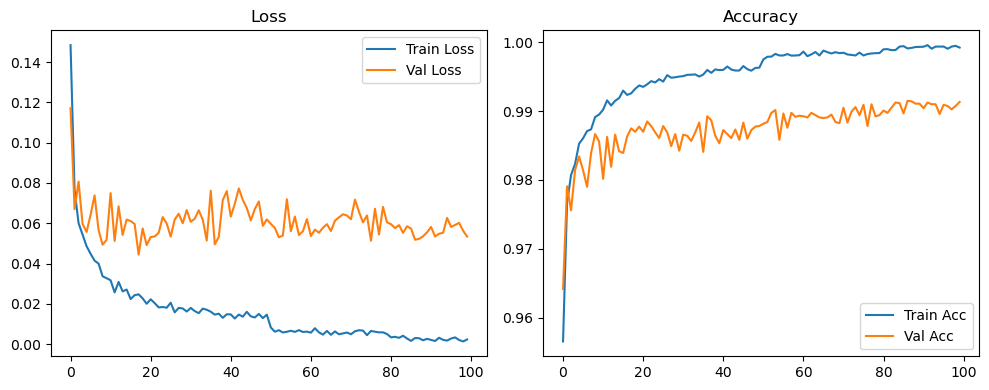

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2503, Acc: 0.9265 | Val Loss: 1.2163, Acc: 0.6120


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1476, Acc: 0.9564 | Val Loss: 0.3853, Acc: 0.8759


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9629 | Val Loss: 0.5168, Acc: 0.8155


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1167, Acc: 0.9660 | Val Loss: 0.2287, Acc: 0.9264


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1101, Acc: 0.9687 | Val Loss: 0.3219, Acc: 0.8864


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1009, Acc: 0.9699 | Val Loss: 0.2831, Acc: 0.9059


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0943, Acc: 0.9724 | Val Loss: 0.2138, Acc: 0.9318


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0988, Acc: 0.9707 | Val Loss: 0.2393, Acc: 0.9204


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0899, Acc: 0.9729 | Val Loss: 0.3235, Acc: 0.8781


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9743 | Val Loss: 0.1929, Acc: 0.9339


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9748 | Val Loss: 0.2368, Acc: 0.9158


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9757 | Val Loss: 0.1997, Acc: 0.9289


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0813, Acc: 0.9758 | Val Loss: 0.2543, Acc: 0.9036


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9770 | Val Loss: 0.2146, Acc: 0.9239


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9767 | Val Loss: 0.2320, Acc: 0.9167


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9780 | Val Loss: 0.2902, Acc: 0.8887


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0740, Acc: 0.9780 | Val Loss: 0.2515, Acc: 0.9104


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9789 | Val Loss: 0.2194, Acc: 0.9244


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0717, Acc: 0.9794 | Val Loss: 0.1296, Acc: 0.9609


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0680, Acc: 0.9794 | Val Loss: 0.2342, Acc: 0.9143


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9798 | Val Loss: 0.3034, Acc: 0.8816


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0699, Acc: 0.9791 | Val Loss: 0.1642, Acc: 0.9455


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9811 | Val Loss: 0.1269, Acc: 0.9606


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0658, Acc: 0.9799 | Val Loss: 0.1877, Acc: 0.9350


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9802 | Val Loss: 0.1894, Acc: 0.9293


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9807 | Val Loss: 0.1564, Acc: 0.9526


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9816 | Val Loss: 0.2198, Acc: 0.9183


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9804 | Val Loss: 0.2493, Acc: 0.9010


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9818 | Val Loss: 0.1943, Acc: 0.9343


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9820 | Val Loss: 0.2193, Acc: 0.9171


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9815 | Val Loss: 0.1997, Acc: 0.9298


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9828 | Val Loss: 0.1987, Acc: 0.9301


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9824 | Val Loss: 0.2739, Acc: 0.8900


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9828 | Val Loss: 0.2613, Acc: 0.8972


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9824 | Val Loss: 0.3023, Acc: 0.8777


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9827 | Val Loss: 0.2742, Acc: 0.8925


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9824 | Val Loss: 0.2977, Acc: 0.8762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9832 | Val Loss: 0.1631, Acc: 0.9495


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9826 | Val Loss: 0.2327, Acc: 0.9088


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9846 | Val Loss: 0.2286, Acc: 0.9123


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9829 | Val Loss: 0.2464, Acc: 0.9146


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9841 | Val Loss: 0.1271, Acc: 0.9587


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9842 | Val Loss: 0.1956, Acc: 0.9275


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9847 | Val Loss: 0.2929, Acc: 0.8767


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9841 | Val Loss: 0.1997, Acc: 0.9193


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9844 | Val Loss: 0.1836, Acc: 0.9287


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9838 | Val Loss: 0.3402, Acc: 0.8485


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9844 | Val Loss: 0.2052, Acc: 0.9258


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9845 | Val Loss: 0.3356, Acc: 0.8355


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9842 | Val Loss: 0.2470, Acc: 0.8989


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.2499, Acc: 0.8874


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9876 | Val Loss: 0.2089, Acc: 0.9134


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9879 | Val Loss: 0.2348, Acc: 0.9059


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9879 | Val Loss: 0.2165, Acc: 0.9158


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9893 | Val Loss: 0.1858, Acc: 0.9296


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9888 | Val Loss: 0.1818, Acc: 0.9356


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9887 | Val Loss: 0.2094, Acc: 0.9188


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9876 | Val Loss: 0.1933, Acc: 0.9310


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9885 | Val Loss: 0.1995, Acc: 0.9262


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9890 | Val Loss: 0.1929, Acc: 0.9257


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.2017, Acc: 0.9263


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9890 | Val Loss: 0.1718, Acc: 0.9367


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9893 | Val Loss: 0.2363, Acc: 0.9012


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9891 | Val Loss: 0.2104, Acc: 0.9147


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9894 | Val Loss: 0.1896, Acc: 0.9310


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9893 | Val Loss: 0.1739, Acc: 0.9397


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9882 | Val Loss: 0.2127, Acc: 0.9172


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9889 | Val Loss: 0.2201, Acc: 0.9185


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9884 | Val Loss: 0.2007, Acc: 0.9299


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9894 | Val Loss: 0.1944, Acc: 0.9287


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9892 | Val Loss: 0.1839, Acc: 0.9363


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9902 | Val Loss: 0.1991, Acc: 0.9243


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9900 | Val Loss: 0.2040, Acc: 0.9289


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9900 | Val Loss: 0.2235, Acc: 0.9151


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9885 | Val Loss: 0.2198, Acc: 0.9247


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9900 | Val Loss: 0.1974, Acc: 0.9402


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9898 | Val Loss: 0.2453, Acc: 0.9062


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9897 | Val Loss: 0.2019, Acc: 0.9362


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9891 | Val Loss: 0.2209, Acc: 0.9233


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9893 | Val Loss: 0.1902, Acc: 0.9401


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9910 | Val Loss: 0.1734, Acc: 0.9484


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9913 | Val Loss: 0.1864, Acc: 0.9374


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9908 | Val Loss: 0.1891, Acc: 0.9384


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9913 | Val Loss: 0.1970, Acc: 0.9293


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9921 | Val Loss: 0.1914, Acc: 0.9347


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.2077, Acc: 0.9213


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.2061, Acc: 0.9253


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.2362, Acc: 0.9073


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9915 | Val Loss: 0.2271, Acc: 0.9021


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9910 | Val Loss: 0.2230, Acc: 0.9250


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.2267, Acc: 0.9124


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9913 | Val Loss: 0.2065, Acc: 0.9267


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9916 | Val Loss: 0.2265, Acc: 0.9257


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.1864, Acc: 0.9437


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.1904, Acc: 0.9307


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9913 | Val Loss: 0.1906, Acc: 0.9350


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9925 | Val Loss: 0.1883, Acc: 0.9403


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.1734, Acc: 0.9452


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9922 | Val Loss: 0.1804, Acc: 0.9431


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.1947, Acc: 0.9427


Final Test Loss: 0.1915 Accuracy: 0.9455


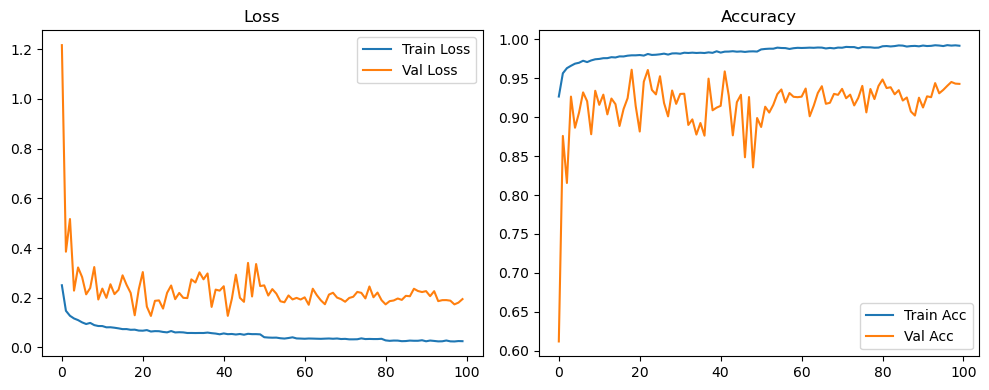

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1192, Acc: 0.9647 | Val Loss: 0.0579, Acc: 0.9821


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9832 | Val Loss: 0.0467, Acc: 0.9871


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9862 | Val Loss: 0.0506, Acc: 0.9848


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.0450, Acc: 0.9874


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9909 | Val Loss: 0.0557, Acc: 0.9853


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.0454, Acc: 0.9881


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.0585, Acc: 0.9859


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.0458, Acc: 0.9886


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9939 | Val Loss: 0.0710, Acc: 0.9848


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0602, Acc: 0.9867


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0523, Acc: 0.9879


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0522, Acc: 0.9885


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.0614, Acc: 0.9882


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0581, Acc: 0.9895


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0495, Acc: 0.9907


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9970 | Val Loss: 0.0558, Acc: 0.9900


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.0686, Acc: 0.9878


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.0511, Acc: 0.9894


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0708, Acc: 0.9888


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0685, Acc: 0.9892


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0772, Acc: 0.9888


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0557, Acc: 0.9913


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9972 | Val Loss: 0.0755, Acc: 0.9886


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0662, Acc: 0.9904


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.0773, Acc: 0.9894


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0708, Acc: 0.9898


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0811, Acc: 0.9892


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9979 | Val Loss: 0.0719, Acc: 0.9892


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.0862, Acc: 0.9890


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9980 | Val Loss: 0.0947, Acc: 0.9892


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.0849, Acc: 0.9885


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.0798, Acc: 0.9901


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9982 | Val Loss: 0.0897, Acc: 0.9886


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.0759, Acc: 0.9909


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.0781, Acc: 0.9906


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0754, Acc: 0.9912


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.0892, Acc: 0.9896


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0953, Acc: 0.9899


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9981 | Val Loss: 0.0955, Acc: 0.9889


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9981 | Val Loss: 0.1016, Acc: 0.9890


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9984 | Val Loss: 0.0984, Acc: 0.9901


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9988 | Val Loss: 0.0899, Acc: 0.9902


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9985 | Val Loss: 0.0911, Acc: 0.9899


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.0870, Acc: 0.9906


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0899, Acc: 0.9905


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9983 | Val Loss: 0.1146, Acc: 0.9870


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9982 | Val Loss: 0.1262, Acc: 0.9875


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9989 | Val Loss: 0.1067, Acc: 0.9892


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1357, Acc: 0.9881


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1141, Acc: 0.9888


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1002, Acc: 0.9902


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1091, Acc: 0.9898


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1150, Acc: 0.9897


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0982, Acc: 0.9912


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1010, Acc: 0.9905


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.0911, Acc: 0.9912


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1136, Acc: 0.9899


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1125, Acc: 0.9907


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1040, Acc: 0.9905


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1088, Acc: 0.9902


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1012, Acc: 0.9911


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0975, Acc: 0.9902


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1044, Acc: 0.9907


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1057, Acc: 0.9902


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0951, Acc: 0.9922


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1011, Acc: 0.9917


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1196, Acc: 0.9905


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1037, Acc: 0.9917


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1124, Acc: 0.9901


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1017, Acc: 0.9905


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.1106, Acc: 0.9910


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1133, Acc: 0.9902


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.1295, Acc: 0.9894


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9997 | Val Loss: 0.1161, Acc: 0.9908


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9996 | Val Loss: 0.1040, Acc: 0.9917


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1132, Acc: 0.9908


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9995 | Val Loss: 0.1240, Acc: 0.9906


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1067, Acc: 0.9914


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1033, Acc: 0.9925


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1103, Acc: 0.9914


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1026, Acc: 0.9923


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1084, Acc: 0.9918


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1022, Acc: 0.9924


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0979, Acc: 0.9921


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1042, Acc: 0.9921


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0998, Acc: 0.9919


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0969, Acc: 0.9917


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0993, Acc: 0.9918


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1004, Acc: 0.9918


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0963, Acc: 0.9920


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1045, Acc: 0.9920


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0934, Acc: 0.9927


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0915, Acc: 0.9928


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0927, Acc: 0.9924


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0942, Acc: 0.9926


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1077, Acc: 0.9912


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1045, Acc: 0.9916


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1003, Acc: 0.9921


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1035, Acc: 0.9922


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1030, Acc: 0.9916


Final Test Loss: 0.1184 Accuracy: 0.9911


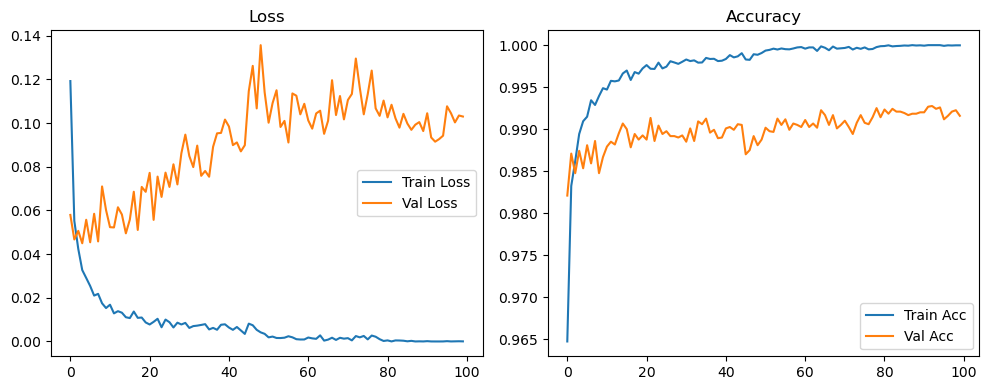

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1494, Acc: 0.9567 | Val Loss: 0.1407, Acc: 0.9556


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9769 | Val Loss: 0.0593, Acc: 0.9828


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9811 | Val Loss: 0.0575, Acc: 0.9821


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9827 | Val Loss: 0.0513, Acc: 0.9847


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9855 | Val Loss: 0.0604, Acc: 0.9823


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9863 | Val Loss: 0.0759, Acc: 0.9776


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9870 | Val Loss: 0.0620, Acc: 0.9836


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9879 | Val Loss: 0.0581, Acc: 0.9833


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9896 | Val Loss: 0.0508, Acc: 0.9857


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9897 | Val Loss: 0.0657, Acc: 0.9829


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9902 | Val Loss: 0.0717, Acc: 0.9813


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.0462, Acc: 0.9873


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9907 | Val Loss: 0.0643, Acc: 0.9812


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9922 | Val Loss: 0.0543, Acc: 0.9867


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.0619, Acc: 0.9832


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9922 | Val Loss: 0.0531, Acc: 0.9871


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9926 | Val Loss: 0.0542, Acc: 0.9858


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9928 | Val Loss: 0.0504, Acc: 0.9869


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0545, Acc: 0.9877


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9934 | Val Loss: 0.0524, Acc: 0.9883


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9931 | Val Loss: 0.0579, Acc: 0.9851


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9943 | Val Loss: 0.0457, Acc: 0.9893


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9943 | Val Loss: 0.0543, Acc: 0.9874


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.0548, Acc: 0.9878


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.0581, Acc: 0.9868


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0613, Acc: 0.9856


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9953 | Val Loss: 0.0656, Acc: 0.9859


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9942 | Val Loss: 0.0700, Acc: 0.9848


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9943 | Val Loss: 0.0507, Acc: 0.9891


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9952 | Val Loss: 0.0973, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9947 | Val Loss: 0.0619, Acc: 0.9883


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9952 | Val Loss: 0.0584, Acc: 0.9872


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9955 | Val Loss: 0.0497, Acc: 0.9891


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.0590, Acc: 0.9875


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9949 | Val Loss: 0.0614, Acc: 0.9862


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.0788, Acc: 0.9850


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.0589, Acc: 0.9894


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9955 | Val Loss: 0.0560, Acc: 0.9888


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.0708, Acc: 0.9862


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9955 | Val Loss: 0.0554, Acc: 0.9890


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.0521, Acc: 0.9900


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9956 | Val Loss: 0.0671, Acc: 0.9881


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9963 | Val Loss: 0.0686, Acc: 0.9882


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.0593, Acc: 0.9888


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9968 | Val Loss: 0.0746, Acc: 0.9848


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9963 | Val Loss: 0.0821, Acc: 0.9858


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9960 | Val Loss: 0.0714, Acc: 0.9854


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9960 | Val Loss: 0.0744, Acc: 0.9852


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.0822, Acc: 0.9826


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9961 | Val Loss: 0.0597, Acc: 0.9886


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.0481, Acc: 0.9903


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0718, Acc: 0.9862


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0604, Acc: 0.9888


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9981 | Val Loss: 0.0569, Acc: 0.9893


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0631, Acc: 0.9886


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.0640, Acc: 0.9901


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0580, Acc: 0.9907


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0676, Acc: 0.9900


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.0598, Acc: 0.9882


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0674, Acc: 0.9888


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9986 | Val Loss: 0.0691, Acc: 0.9882


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0686, Acc: 0.9897


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0706, Acc: 0.9889


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0750, Acc: 0.9878


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0670, Acc: 0.9896


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0572, Acc: 0.9904


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0604, Acc: 0.9898


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0595, Acc: 0.9904


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0608, Acc: 0.9910


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9983 | Val Loss: 0.0633, Acc: 0.9905


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9986 | Val Loss: 0.0678, Acc: 0.9892


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0690, Acc: 0.9883


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0790, Acc: 0.9878


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9984 | Val Loss: 0.0566, Acc: 0.9910


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0650, Acc: 0.9902


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0540, Acc: 0.9911


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9983 | Val Loss: 0.0682, Acc: 0.9892


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0577, Acc: 0.9894


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0603, Acc: 0.9902


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.0715, Acc: 0.9892


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.0696, Acc: 0.9898


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0595, Acc: 0.9908


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0629, Acc: 0.9905


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0621, Acc: 0.9903


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0644, Acc: 0.9910


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0539, Acc: 0.9923


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0553, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0594, Acc: 0.9912


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0595, Acc: 0.9917


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0594, Acc: 0.9915


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0654, Acc: 0.9908


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0574, Acc: 0.9916


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0616, Acc: 0.9906


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0528, Acc: 0.9918


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0574, Acc: 0.9916


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0591, Acc: 0.9908


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0612, Acc: 0.9910


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0598, Acc: 0.9916


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0577, Acc: 0.9923


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0540, Acc: 0.9922


Final Test Loss: 0.0487 Accuracy: 0.9907


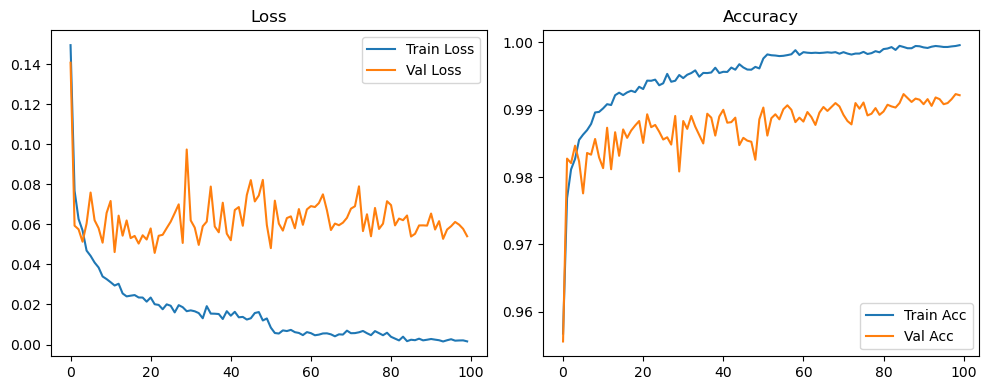

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2478, Acc: 0.9277 | Val Loss: 1.5511, Acc: 0.5294


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1476, Acc: 0.9573 | Val Loss: 0.3818, Acc: 0.8772


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1272, Acc: 0.9626 | Val Loss: 0.5523, Acc: 0.8099


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9664 | Val Loss: 0.2440, Acc: 0.9190


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1083, Acc: 0.9681 | Val Loss: 0.2270, Acc: 0.9252


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0986, Acc: 0.9706 | Val Loss: 0.3236, Acc: 0.8870


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9711 | Val Loss: 0.2214, Acc: 0.9272


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0988, Acc: 0.9700 | Val Loss: 0.1997, Acc: 0.9395


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9735 | Val Loss: 0.2937, Acc: 0.8992


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0845, Acc: 0.9742 | Val Loss: 0.2444, Acc: 0.9097


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0866, Acc: 0.9746 | Val Loss: 0.1819, Acc: 0.9397


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0809, Acc: 0.9762 | Val Loss: 0.1895, Acc: 0.9337


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9768 | Val Loss: 0.2970, Acc: 0.8887


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9780 | Val Loss: 0.2125, Acc: 0.9192


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9780 | Val Loss: 0.1496, Acc: 0.9523


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9778 | Val Loss: 0.1721, Acc: 0.9431


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9777 | Val Loss: 0.2386, Acc: 0.9172


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9788 | Val Loss: 0.2758, Acc: 0.9012


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0708, Acc: 0.9800 | Val Loss: 0.1793, Acc: 0.9404


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9800 | Val Loss: 0.3621, Acc: 0.8344


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9796 | Val Loss: 0.2357, Acc: 0.9197


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0658, Acc: 0.9806 | Val Loss: 0.1162, Acc: 0.9668


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9794 | Val Loss: 0.1204, Acc: 0.9680


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9801 | Val Loss: 0.1893, Acc: 0.9358


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9806 | Val Loss: 0.1941, Acc: 0.9301


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9819 | Val Loss: 0.1629, Acc: 0.9483


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9821 | Val Loss: 0.1517, Acc: 0.9492


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9820 | Val Loss: 0.2117, Acc: 0.9208


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9821 | Val Loss: 0.2000, Acc: 0.9298


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9814 | Val Loss: 0.2541, Acc: 0.9018


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9826 | Val Loss: 0.1867, Acc: 0.9361


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9824 | Val Loss: 0.2293, Acc: 0.9152


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9832 | Val Loss: 0.1947, Acc: 0.9268


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9822 | Val Loss: 0.2530, Acc: 0.8952


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9830 | Val Loss: 0.1968, Acc: 0.9317


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9842 | Val Loss: 0.1996, Acc: 0.9326


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9828 | Val Loss: 0.2796, Acc: 0.8792


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9837 | Val Loss: 0.1643, Acc: 0.9463


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9839 | Val Loss: 0.1718, Acc: 0.9440


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9835 | Val Loss: 0.1893, Acc: 0.9382


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9836 | Val Loss: 0.1942, Acc: 0.9401


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9835 | Val Loss: 0.1598, Acc: 0.9417


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9840 | Val Loss: 0.1806, Acc: 0.9426


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9839 | Val Loss: 0.2297, Acc: 0.9161


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9839 | Val Loss: 0.1792, Acc: 0.9472


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9850 | Val Loss: 0.2175, Acc: 0.9201


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9851 | Val Loss: 0.2845, Acc: 0.8861


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9845 | Val Loss: 0.2063, Acc: 0.9287


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9847 | Val Loss: 0.2404, Acc: 0.9175


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9842 | Val Loss: 0.2147, Acc: 0.9286


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9863 | Val Loss: 0.2069, Acc: 0.9207


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9875 | Val Loss: 0.1966, Acc: 0.9443


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9876 | Val Loss: 0.2209, Acc: 0.9143


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9875 | Val Loss: 0.2117, Acc: 0.9285


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9887 | Val Loss: 0.2365, Acc: 0.9039


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9887 | Val Loss: 0.1429, Acc: 0.9634


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9889 | Val Loss: 0.1991, Acc: 0.9319


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9879 | Val Loss: 0.2064, Acc: 0.9224


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9890 | Val Loss: 0.1942, Acc: 0.9343


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9889 | Val Loss: 0.1524, Acc: 0.9563


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9886 | Val Loss: 0.1834, Acc: 0.9393


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.1829, Acc: 0.9435


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9893 | Val Loss: 0.1895, Acc: 0.9353


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9895 | Val Loss: 0.1747, Acc: 0.9407


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9896 | Val Loss: 0.1947, Acc: 0.9422


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.2003, Acc: 0.9262


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9885 | Val Loss: 0.1921, Acc: 0.9365


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9898 | Val Loss: 0.1942, Acc: 0.9362


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9892 | Val Loss: 0.1985, Acc: 0.9268


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9891 | Val Loss: 0.1791, Acc: 0.9433


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9898 | Val Loss: 0.1529, Acc: 0.9564


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9889 | Val Loss: 0.2191, Acc: 0.9198


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9891 | Val Loss: 0.2617, Acc: 0.9003


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9896 | Val Loss: 0.2007, Acc: 0.9423


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9889 | Val Loss: 0.2259, Acc: 0.9204


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9902 | Val Loss: 0.1848, Acc: 0.9371


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9892 | Val Loss: 0.1668, Acc: 0.9488


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9899 | Val Loss: 0.2016, Acc: 0.9294


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9901 | Val Loss: 0.1654, Acc: 0.9513


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9900 | Val Loss: 0.1766, Acc: 0.9456


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9903 | Val Loss: 0.1859, Acc: 0.9458


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9914 | Val Loss: 0.1728, Acc: 0.9494


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.1701, Acc: 0.9471


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9914 | Val Loss: 0.1770, Acc: 0.9468


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.1698, Acc: 0.9516


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9921 | Val Loss: 0.1738, Acc: 0.9458


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9921 | Val Loss: 0.1531, Acc: 0.9598


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9924 | Val Loss: 0.1953, Acc: 0.9323


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9921 | Val Loss: 0.1920, Acc: 0.9386


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.1731, Acc: 0.9501


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.1802, Acc: 0.9450


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9927 | Val Loss: 0.1821, Acc: 0.9374


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.1849, Acc: 0.9447


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9921 | Val Loss: 0.1516, Acc: 0.9535


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9929 | Val Loss: 0.1724, Acc: 0.9413


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9920 | Val Loss: 0.1751, Acc: 0.9445


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9922 | Val Loss: 0.1782, Acc: 0.9394


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.1792, Acc: 0.9425


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.1646, Acc: 0.9514


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9923 | Val Loss: 0.1445, Acc: 0.9653


Final Test Loss: 0.1420 Accuracy: 0.9640


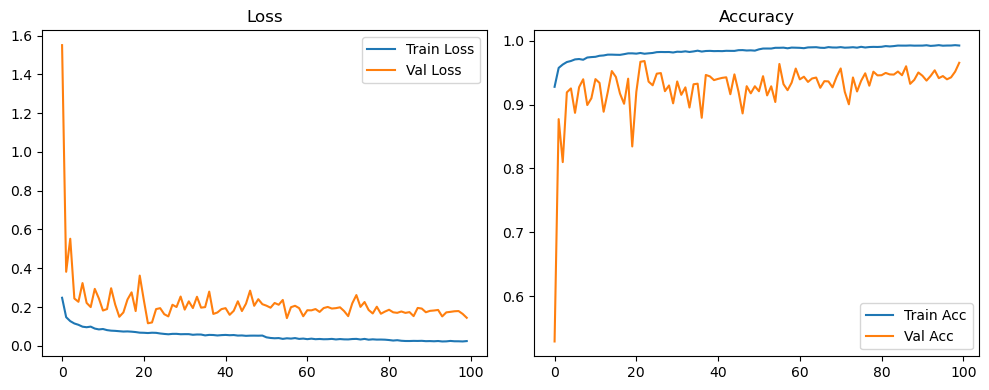

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1194, Acc: 0.9654 | Val Loss: 0.0649, Acc: 0.9793


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9829 | Val Loss: 0.0495, Acc: 0.9854


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.0560, Acc: 0.9830


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9891 | Val Loss: 0.0425, Acc: 0.9892


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9910 | Val Loss: 0.0473, Acc: 0.9865


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9912 | Val Loss: 0.0520, Acc: 0.9868


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.0549, Acc: 0.9864


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0546, Acc: 0.9871


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.0490, Acc: 0.9887


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9948 | Val Loss: 0.0482, Acc: 0.9882


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0515, Acc: 0.9888


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0514, Acc: 0.9870


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0545, Acc: 0.9891


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.0675, Acc: 0.9883


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.0641, Acc: 0.9888


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.0631, Acc: 0.9889


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0658, Acc: 0.9877


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.0634, Acc: 0.9880


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.0587, Acc: 0.9907


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9971 | Val Loss: 0.0599, Acc: 0.9896


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0683, Acc: 0.9892


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.0633, Acc: 0.9902


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.0634, Acc: 0.9905


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0742, Acc: 0.9891


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.0809, Acc: 0.9891


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9976 | Val Loss: 0.0838, Acc: 0.9889


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0710, Acc: 0.9905


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9982 | Val Loss: 0.0742, Acc: 0.9903


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0616, Acc: 0.9903


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9980 | Val Loss: 0.0691, Acc: 0.9911


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9976 | Val Loss: 0.0727, Acc: 0.9911


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9981 | Val Loss: 0.0732, Acc: 0.9908


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0820, Acc: 0.9898


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0722, Acc: 0.9918


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0758, Acc: 0.9902


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0883, Acc: 0.9892


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9977 | Val Loss: 0.0996, Acc: 0.9902


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9983 | Val Loss: 0.0859, Acc: 0.9913


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0901, Acc: 0.9894


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.0973, Acc: 0.9900


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0962, Acc: 0.9898


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9988 | Val Loss: 0.1016, Acc: 0.9901


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9985 | Val Loss: 0.0951, Acc: 0.9902


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.1059, Acc: 0.9898


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9985 | Val Loss: 0.1036, Acc: 0.9885


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9987 | Val Loss: 0.0808, Acc: 0.9916


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9991 | Val Loss: 0.0937, Acc: 0.9912


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9981 | Val Loss: 0.1032, Acc: 0.9908


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1098, Acc: 0.9912


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9989 | Val Loss: 0.1085, Acc: 0.9902


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0778, Acc: 0.9929


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0839, Acc: 0.9922


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0824, Acc: 0.9923


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0850, Acc: 0.9918


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0808, Acc: 0.9926


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0860, Acc: 0.9919


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0861, Acc: 0.9922


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0899, Acc: 0.9922


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0901, Acc: 0.9918


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0891, Acc: 0.9917


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0922, Acc: 0.9918


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0882, Acc: 0.9913


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0847, Acc: 0.9921


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0850, Acc: 0.9928


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1004, Acc: 0.9923


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0844, Acc: 0.9923


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0901, Acc: 0.9923


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0957, Acc: 0.9928


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0960, Acc: 0.9930


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0898, Acc: 0.9935


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0964, Acc: 0.9926


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0989, Acc: 0.9925


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0994, Acc: 0.9930


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0946, Acc: 0.9922


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0984, Acc: 0.9927


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0936, Acc: 0.9919


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1049, Acc: 0.9922


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0979, Acc: 0.9918


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0999, Acc: 0.9917


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0957, Acc: 0.9922


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1008, Acc: 0.9915


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0949, Acc: 0.9917


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0997, Acc: 0.9917


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0950, Acc: 0.9919


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0968, Acc: 0.9925


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0926, Acc: 0.9922


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0928, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0929, Acc: 0.9923


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0952, Acc: 0.9918


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0973, Acc: 0.9925


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0942, Acc: 0.9931


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0956, Acc: 0.9924


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0952, Acc: 0.9929


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0929, Acc: 0.9925


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0993, Acc: 0.9917


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0956, Acc: 0.9921


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0988, Acc: 0.9927


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0953, Acc: 0.9927


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1086, Acc: 0.9917


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0976, Acc: 0.9922


Final Test Loss: 0.0981 Accuracy: 0.9916


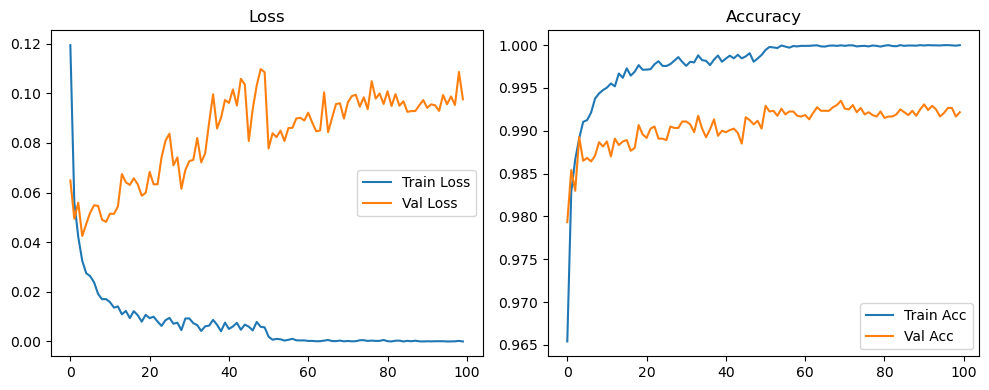

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1465, Acc: 0.9568 | Val Loss: 0.1076, Acc: 0.9651


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9771 | Val Loss: 0.0715, Acc: 0.9797


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9817 | Val Loss: 0.0803, Acc: 0.9766


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9829 | Val Loss: 0.0564, Acc: 0.9831


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9848 | Val Loss: 0.0476, Acc: 0.9846


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9860 | Val Loss: 0.0543, Acc: 0.9838


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9870 | Val Loss: 0.0633, Acc: 0.9829


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9873 | Val Loss: 0.0621, Acc: 0.9813


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9887 | Val Loss: 0.0583, Acc: 0.9844


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9884 | Val Loss: 0.0612, Acc: 0.9828


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9905 | Val Loss: 0.0519, Acc: 0.9852


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.0548, Acc: 0.9862


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9912 | Val Loss: 0.0749, Acc: 0.9814


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.0465, Acc: 0.9879


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9924 | Val Loss: 0.0574, Acc: 0.9854


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9930 | Val Loss: 0.0727, Acc: 0.9811


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9927 | Val Loss: 0.0493, Acc: 0.9872


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.0677, Acc: 0.9838


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.0753, Acc: 0.9842


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9931 | Val Loss: 0.0545, Acc: 0.9868


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.0522, Acc: 0.9870


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9935 | Val Loss: 0.0593, Acc: 0.9852


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9941 | Val Loss: 0.0648, Acc: 0.9855


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9936 | Val Loss: 0.0519, Acc: 0.9884


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9946 | Val Loss: 0.0748, Acc: 0.9820


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9947 | Val Loss: 0.0674, Acc: 0.9842


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9942 | Val Loss: 0.0556, Acc: 0.9868


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9944 | Val Loss: 0.0576, Acc: 0.9877


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0672, Acc: 0.9854


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0674, Acc: 0.9854


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9953 | Val Loss: 0.0570, Acc: 0.9868


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9958 | Val Loss: 0.0555, Acc: 0.9882


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9951 | Val Loss: 0.0544, Acc: 0.9870


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9952 | Val Loss: 0.0533, Acc: 0.9879


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9947 | Val Loss: 0.0542, Acc: 0.9859


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9956 | Val Loss: 0.0748, Acc: 0.9822


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9956 | Val Loss: 0.0686, Acc: 0.9864


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9954 | Val Loss: 0.0653, Acc: 0.9863


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9964 | Val Loss: 0.0686, Acc: 0.9855


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9955 | Val Loss: 0.0593, Acc: 0.9878


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9958 | Val Loss: 0.0609, Acc: 0.9872


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9956 | Val Loss: 0.0635, Acc: 0.9870


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9953 | Val Loss: 0.0684, Acc: 0.9842


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9959 | Val Loss: 0.0675, Acc: 0.9868


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9964 | Val Loss: 0.0610, Acc: 0.9862


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9964 | Val Loss: 0.0514, Acc: 0.9892


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.0746, Acc: 0.9834


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9965 | Val Loss: 0.0481, Acc: 0.9885


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9961 | Val Loss: 0.0713, Acc: 0.9853


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9964 | Val Loss: 0.0856, Acc: 0.9817


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0551, Acc: 0.9890


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0572, Acc: 0.9875


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0502, Acc: 0.9888


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0498, Acc: 0.9899


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0559, Acc: 0.9887


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0484, Acc: 0.9902


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0610, Acc: 0.9874


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0549, Acc: 0.9891


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0639, Acc: 0.9872


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0633, Acc: 0.9883


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0548, Acc: 0.9896


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0533, Acc: 0.9897


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0506, Acc: 0.9909


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0525, Acc: 0.9898


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9991 | Val Loss: 0.0497, Acc: 0.9908


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0544, Acc: 0.9902


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0541, Acc: 0.9901


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0620, Acc: 0.9889


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0606, Acc: 0.9888


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0591, Acc: 0.9891


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0544, Acc: 0.9900


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0624, Acc: 0.9897


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0578, Acc: 0.9898


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0631, Acc: 0.9884


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0573, Acc: 0.9894


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0608, Acc: 0.9893


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0637, Acc: 0.9895


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0546, Acc: 0.9903


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0590, Acc: 0.9908


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0675, Acc: 0.9883


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0661, Acc: 0.9895


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0541, Acc: 0.9900


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0584, Acc: 0.9899


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0618, Acc: 0.9897


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0619, Acc: 0.9897


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0582, Acc: 0.9898


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0559, Acc: 0.9905


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0615, Acc: 0.9888


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0630, Acc: 0.9895


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0682, Acc: 0.9892


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0656, Acc: 0.9888


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0584, Acc: 0.9908


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0604, Acc: 0.9887


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0592, Acc: 0.9891


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0604, Acc: 0.9899


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0658, Acc: 0.9892


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0616, Acc: 0.9892


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0608, Acc: 0.9893


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0553, Acc: 0.9904


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0543, Acc: 0.9904


Final Test Loss: 0.0556 Accuracy: 0.9898


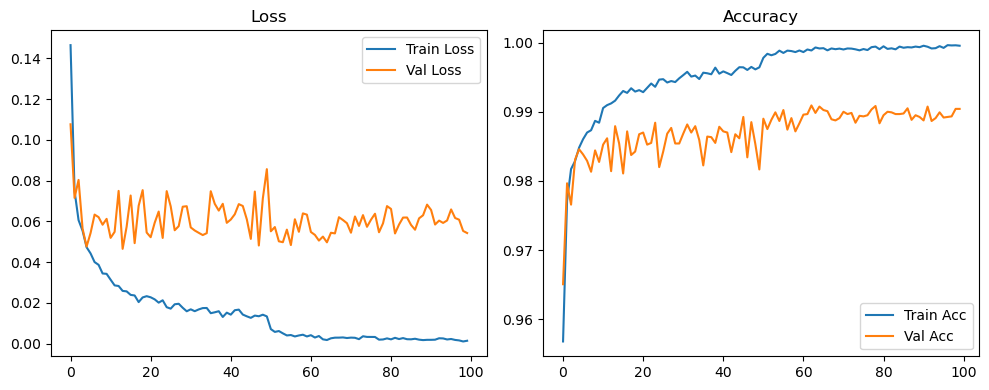

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2500, Acc: 0.9273 | Val Loss: 0.8807, Acc: 0.7198


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1457, Acc: 0.9570 | Val Loss: 0.2911, Acc: 0.9125


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1286, Acc: 0.9622 | Val Loss: 0.3779, Acc: 0.8772


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9659 | Val Loss: 0.2246, Acc: 0.9261


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9690 | Val Loss: 0.3381, Acc: 0.8852


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1016, Acc: 0.9693 | Val Loss: 0.2533, Acc: 0.9142


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9718 | Val Loss: 0.2205, Acc: 0.9236


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0979, Acc: 0.9719 | Val Loss: 0.2649, Acc: 0.9105


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9728 | Val Loss: 0.2154, Acc: 0.9247


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0849, Acc: 0.9749 | Val Loss: 0.2698, Acc: 0.9030


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0844, Acc: 0.9745 | Val Loss: 0.2304, Acc: 0.9138


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9765 | Val Loss: 0.1802, Acc: 0.9421


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9767 | Val Loss: 0.2737, Acc: 0.8949


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9767 | Val Loss: 0.1758, Acc: 0.9398


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0748, Acc: 0.9774 | Val Loss: 0.1698, Acc: 0.9411


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9784 | Val Loss: 0.2008, Acc: 0.9269


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9784 | Val Loss: 0.2292, Acc: 0.9167


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9782 | Val Loss: 0.2755, Acc: 0.9053


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9796 | Val Loss: 0.1761, Acc: 0.9423


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9792 | Val Loss: 0.2153, Acc: 0.9263


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9794 | Val Loss: 0.1893, Acc: 0.9370


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9797 | Val Loss: 0.1595, Acc: 0.9493


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9811 | Val Loss: 0.1421, Acc: 0.9537


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9804 | Val Loss: 0.2056, Acc: 0.9321


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9809 | Val Loss: 0.1767, Acc: 0.9367


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9807 | Val Loss: 0.1763, Acc: 0.9473


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9812 | Val Loss: 0.1254, Acc: 0.9673


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9808 | Val Loss: 0.1820, Acc: 0.9423


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9826 | Val Loss: 0.1466, Acc: 0.9509


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9825 | Val Loss: 0.2188, Acc: 0.9281


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0610, Acc: 0.9820 | Val Loss: 0.1905, Acc: 0.9370


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9829 | Val Loss: 0.2229, Acc: 0.9121


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9818 | Val Loss: 0.2180, Acc: 0.9243


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9827 | Val Loss: 0.2707, Acc: 0.8905


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9835 | Val Loss: 0.1842, Acc: 0.9331


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9833 | Val Loss: 0.2157, Acc: 0.9216


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9829 | Val Loss: 0.2363, Acc: 0.9079


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9831 | Val Loss: 0.1484, Acc: 0.9566


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9845 | Val Loss: 0.1562, Acc: 0.9477


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9844 | Val Loss: 0.2082, Acc: 0.9220


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9837 | Val Loss: 0.1945, Acc: 0.9375


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9839 | Val Loss: 0.1774, Acc: 0.9378


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9843 | Val Loss: 0.2268, Acc: 0.9068


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9847 | Val Loss: 0.2434, Acc: 0.8977


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9841 | Val Loss: 0.2010, Acc: 0.9231


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9849 | Val Loss: 0.2022, Acc: 0.9258


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9844 | Val Loss: 0.3673, Acc: 0.8462


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9853 | Val Loss: 0.1958, Acc: 0.9281


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9833 | Val Loss: 0.1986, Acc: 0.9343


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9850 | Val Loss: 0.2105, Acc: 0.9257


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9871 | Val Loss: 0.2147, Acc: 0.9151


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9885 | Val Loss: 0.2034, Acc: 0.9210


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9890 | Val Loss: 0.1932, Acc: 0.9240


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9895 | Val Loss: 0.1802, Acc: 0.9303


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9900 | Val Loss: 0.1984, Acc: 0.9202


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 0.1735, Acc: 0.9399


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9895 | Val Loss: 0.1793, Acc: 0.9345


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9898 | Val Loss: 0.2002, Acc: 0.9246


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9904 | Val Loss: 0.2172, Acc: 0.9171


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9901 | Val Loss: 0.1835, Acc: 0.9347


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.1633, Acc: 0.9425


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9902 | Val Loss: 0.1643, Acc: 0.9438


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9900 | Val Loss: 0.1639, Acc: 0.9411


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9905 | Val Loss: 0.1758, Acc: 0.9389


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9915 | Val Loss: 0.1721, Acc: 0.9386


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.1712, Acc: 0.9356


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9907 | Val Loss: 0.1838, Acc: 0.9358


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.1819, Acc: 0.9372


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9909 | Val Loss: 0.1859, Acc: 0.9405


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9914 | Val Loss: 0.1628, Acc: 0.9457


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.1750, Acc: 0.9431


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9910 | Val Loss: 0.1830, Acc: 0.9389


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9912 | Val Loss: 0.1688, Acc: 0.9450


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9908 | Val Loss: 0.1944, Acc: 0.9254


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.1653, Acc: 0.9460


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9907 | Val Loss: 0.1626, Acc: 0.9504


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9916 | Val Loss: 0.1749, Acc: 0.9450


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9915 | Val Loss: 0.1794, Acc: 0.9407


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.1517, Acc: 0.9540


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.1734, Acc: 0.9418


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.1669, Acc: 0.9502


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9910 | Val Loss: 0.1786, Acc: 0.9428


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9920 | Val Loss: 0.1643, Acc: 0.9458


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.1681, Acc: 0.9452


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9923 | Val Loss: 0.1748, Acc: 0.9434


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.1782, Acc: 0.9409


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.1604, Acc: 0.9548


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.1798, Acc: 0.9433


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.1685, Acc: 0.9472


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9917 | Val Loss: 0.1627, Acc: 0.9533


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.1622, Acc: 0.9533


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.1590, Acc: 0.9536


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9920 | Val Loss: 0.1470, Acc: 0.9554


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9923 | Val Loss: 0.1507, Acc: 0.9573


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9919 | Val Loss: 0.1779, Acc: 0.9440


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9918 | Val Loss: 0.1855, Acc: 0.9384


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.1556, Acc: 0.9542


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.1718, Acc: 0.9470


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.1593, Acc: 0.9520


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9918 | Val Loss: 0.1628, Acc: 0.9543


Final Test Loss: 0.1635 Accuracy: 0.9551


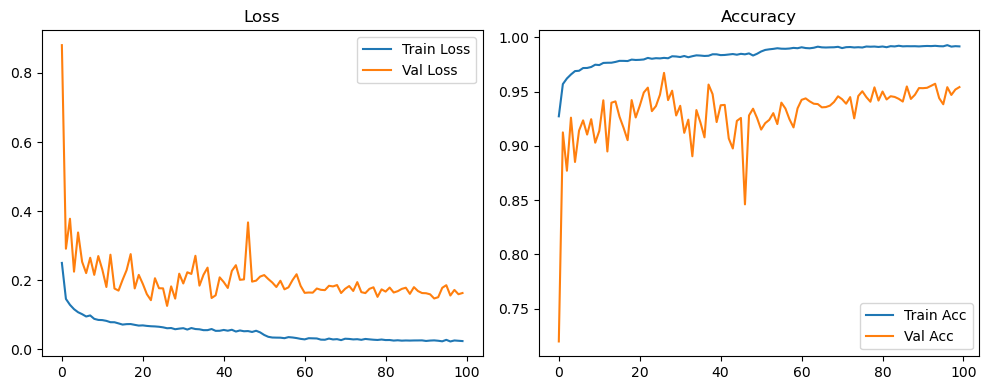

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1186, Acc: 0.9674 | Val Loss: 0.0565, Acc: 0.9827


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9839 | Val Loss: 0.0457, Acc: 0.9862


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9872 | Val Loss: 0.0494, Acc: 0.9851


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.0417, Acc: 0.9883


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9919 | Val Loss: 0.0479, Acc: 0.9868


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9928 | Val Loss: 0.0473, Acc: 0.9871


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.0429, Acc: 0.9888


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0494, Acc: 0.9882


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0559, Acc: 0.9862


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9955 | Val Loss: 0.0502, Acc: 0.9888


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9956 | Val Loss: 0.0520, Acc: 0.9891


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0442, Acc: 0.9900


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0566, Acc: 0.9884


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0466, Acc: 0.9908


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0529, Acc: 0.9884


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0662, Acc: 0.9880


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0662, Acc: 0.9875


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0623, Acc: 0.9879


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0649, Acc: 0.9870


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0504, Acc: 0.9903


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0554, Acc: 0.9894


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0625, Acc: 0.9888


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0646, Acc: 0.9882


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0606, Acc: 0.9904


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0545, Acc: 0.9909


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0574, Acc: 0.9905


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0622, Acc: 0.9890


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0567, Acc: 0.9901


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.0632, Acc: 0.9905


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0648, Acc: 0.9902


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0717, Acc: 0.9889


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0638, Acc: 0.9902


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0689, Acc: 0.9896


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0729, Acc: 0.9903


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0713, Acc: 0.9905


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0693, Acc: 0.9907


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0730, Acc: 0.9894


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0668, Acc: 0.9904


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0750, Acc: 0.9893


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0813, Acc: 0.9891


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0736, Acc: 0.9902


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0749, Acc: 0.9898


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0842, Acc: 0.9881


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0851, Acc: 0.9894


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0698, Acc: 0.9904


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0909, Acc: 0.9889


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0745, Acc: 0.9912


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0873, Acc: 0.9892


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0879, Acc: 0.9899


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0873, Acc: 0.9894


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0701, Acc: 0.9905


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0733, Acc: 0.9909


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0824, Acc: 0.9901


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0941, Acc: 0.9894


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0862, Acc: 0.9907


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0847, Acc: 0.9904


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9990 | Val Loss: 0.0858, Acc: 0.9904


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0890, Acc: 0.9902


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.0942, Acc: 0.9893


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.0917, Acc: 0.9903


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0860, Acc: 0.9907


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0849, Acc: 0.9905


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0843, Acc: 0.9909


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0797, Acc: 0.9914


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0819, Acc: 0.9906


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0761, Acc: 0.9917


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0830, Acc: 0.9911


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0855, Acc: 0.9905


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.0819, Acc: 0.9922


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0875, Acc: 0.9915


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0953, Acc: 0.9900


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.0942, Acc: 0.9908


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0910, Acc: 0.9908


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1099, Acc: 0.9898


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1100, Acc: 0.9893


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0828, Acc: 0.9918


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0955, Acc: 0.9917


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0897, Acc: 0.9910


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0969, Acc: 0.9908


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0943, Acc: 0.9907


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0890, Acc: 0.9909


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1012, Acc: 0.9900


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1014, Acc: 0.9899


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0984, Acc: 0.9919


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.0859, Acc: 0.9908


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0814, Acc: 0.9922


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0914, Acc: 0.9908


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1000, Acc: 0.9912


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0987, Acc: 0.9912


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0941, Acc: 0.9918


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1056, Acc: 0.9901


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.0961, Acc: 0.9907


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1041, Acc: 0.9902


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1052, Acc: 0.9912


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0980, Acc: 0.9912


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0936, Acc: 0.9923


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1040, Acc: 0.9908


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1093, Acc: 0.9906


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1101, Acc: 0.9905


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1010, Acc: 0.9919


Final Test Loss: 0.0914 Accuracy: 0.9907


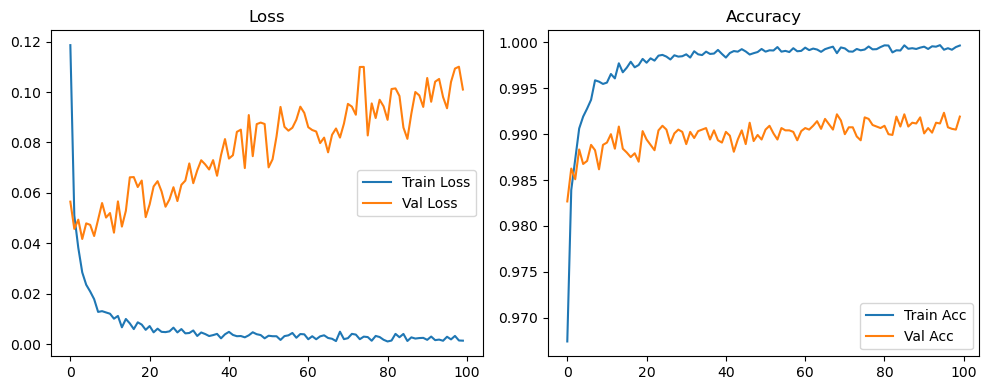

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1485, Acc: 0.9586 | Val Loss: 0.1257, Acc: 0.9613


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9787 | Val Loss: 0.0623, Acc: 0.9821


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9824 | Val Loss: 0.0673, Acc: 0.9793


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9843 | Val Loss: 0.0524, Acc: 0.9851


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9865 | Val Loss: 0.0549, Acc: 0.9826


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9879 | Val Loss: 0.0592, Acc: 0.9822


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9892 | Val Loss: 0.0520, Acc: 0.9848


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9880 | Val Loss: 0.0505, Acc: 0.9850


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.0426, Acc: 0.9866


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9912 | Val Loss: 0.0607, Acc: 0.9817


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9911 | Val Loss: 0.0622, Acc: 0.9832


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9923 | Val Loss: 0.0474, Acc: 0.9862


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.0502, Acc: 0.9854


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0458, Acc: 0.9872


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.0501, Acc: 0.9855


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9935 | Val Loss: 0.0500, Acc: 0.9858


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0440, Acc: 0.9881


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.0579, Acc: 0.9858


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.0386, Acc: 0.9890


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0416, Acc: 0.9882


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9942 | Val Loss: 0.0559, Acc: 0.9861


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.0381, Acc: 0.9902


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0513, Acc: 0.9872


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0503, Acc: 0.9876


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0521, Acc: 0.9879


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.0511, Acc: 0.9868


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0590, Acc: 0.9850


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0467, Acc: 0.9895


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0576, Acc: 0.9864


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0580, Acc: 0.9857


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0481, Acc: 0.9882


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0632, Acc: 0.9842


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0394, Acc: 0.9898


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0432, Acc: 0.9894


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.0456, Acc: 0.9881


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0468, Acc: 0.9879


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0426, Acc: 0.9893


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0453, Acc: 0.9888


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0551, Acc: 0.9862


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0551, Acc: 0.9868


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0439, Acc: 0.9892


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9971 | Val Loss: 0.0533, Acc: 0.9885


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0517, Acc: 0.9876


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0498, Acc: 0.9885


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0560, Acc: 0.9858


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0507, Acc: 0.9875


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0808, Acc: 0.9822


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0423, Acc: 0.9896


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0601, Acc: 0.9858


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0506, Acc: 0.9864


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0518, Acc: 0.9865


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.0457, Acc: 0.9887


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0542, Acc: 0.9874


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0434, Acc: 0.9898


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0441, Acc: 0.9898


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0495, Acc: 0.9882


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0490, Acc: 0.9877


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.0530, Acc: 0.9866


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0500, Acc: 0.9869


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0559, Acc: 0.9868


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0558, Acc: 0.9850


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.0516, Acc: 0.9888


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0463, Acc: 0.9887


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0386, Acc: 0.9918


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0506, Acc: 0.9879


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.0438, Acc: 0.9888


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9976 | Val Loss: 0.0434, Acc: 0.9898


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0558, Acc: 0.9871


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0567, Acc: 0.9868


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.0414, Acc: 0.9895


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0472, Acc: 0.9891


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0590, Acc: 0.9858


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.0574, Acc: 0.9880


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9977 | Val Loss: 0.0541, Acc: 0.9879


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0563, Acc: 0.9874


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0506, Acc: 0.9881


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0602, Acc: 0.9879


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0544, Acc: 0.9882


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.0508, Acc: 0.9877


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9981 | Val Loss: 0.0476, Acc: 0.9885


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0564, Acc: 0.9865


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0475, Acc: 0.9897


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0604, Acc: 0.9856


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.0604, Acc: 0.9862


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0574, Acc: 0.9876


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0541, Acc: 0.9888


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.0479, Acc: 0.9899


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0519, Acc: 0.9886


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9981 | Val Loss: 0.0481, Acc: 0.9887


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0499, Acc: 0.9882


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0509, Acc: 0.9886


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.0565, Acc: 0.9877


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.0507, Acc: 0.9897


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0624, Acc: 0.9874


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0514, Acc: 0.9882


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0475, Acc: 0.9887


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.0528, Acc: 0.9878


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0562, Acc: 0.9881


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0463, Acc: 0.9901


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0414, Acc: 0.9908


Final Test Loss: 0.0418 Accuracy: 0.9886


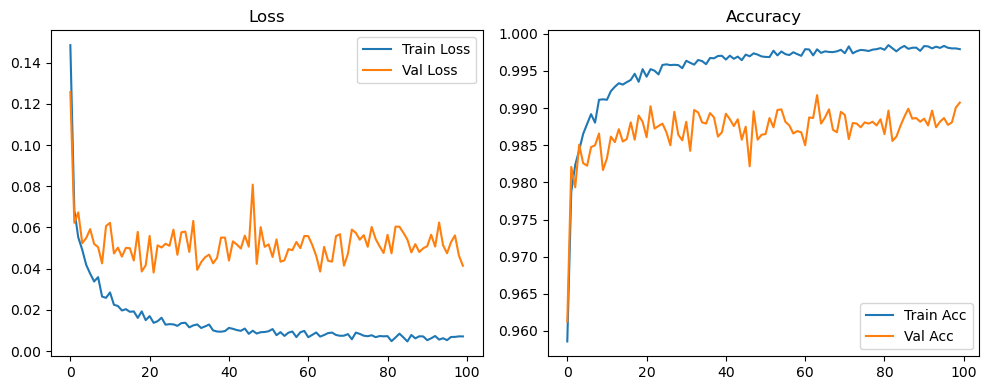

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2439, Acc: 0.9340 | Val Loss: 0.9999, Acc: 0.6584


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1330, Acc: 0.9606 | Val Loss: 0.5155, Acc: 0.8256


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1128, Acc: 0.9671 | Val Loss: 0.5655, Acc: 0.8037


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1028, Acc: 0.9695 | Val Loss: 0.2745, Acc: 0.9149


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0964, Acc: 0.9714 | Val Loss: 0.3054, Acc: 0.8975


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0899, Acc: 0.9724 | Val Loss: 0.2813, Acc: 0.9065


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0839, Acc: 0.9749 | Val Loss: 0.1782, Acc: 0.9449


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0870, Acc: 0.9745 | Val Loss: 0.2888, Acc: 0.8982


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0754, Acc: 0.9771 | Val Loss: 0.2574, Acc: 0.9117


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0715, Acc: 0.9784 | Val Loss: 0.1980, Acc: 0.9318


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0724, Acc: 0.9779 | Val Loss: 0.1889, Acc: 0.9384


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0711, Acc: 0.9779 | Val Loss: 0.1861, Acc: 0.9425


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0686, Acc: 0.9797 | Val Loss: 0.3231, Acc: 0.8825


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0695, Acc: 0.9794 | Val Loss: 0.1926, Acc: 0.9357


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0654, Acc: 0.9797 | Val Loss: 0.1898, Acc: 0.9382


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9803 | Val Loss: 0.1731, Acc: 0.9450


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0629, Acc: 0.9802 | Val Loss: 0.1554, Acc: 0.9508


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0618, Acc: 0.9813 | Val Loss: 0.2000, Acc: 0.9367


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0623, Acc: 0.9809 | Val Loss: 0.1310, Acc: 0.9618


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9815 | Val Loss: 0.2160, Acc: 0.9280


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0573, Acc: 0.9830 | Val Loss: 0.1617, Acc: 0.9490


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9825 | Val Loss: 0.1259, Acc: 0.9641


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9830 | Val Loss: 0.1244, Acc: 0.9667


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9828 | Val Loss: 0.1685, Acc: 0.9506


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0568, Acc: 0.9825 | Val Loss: 0.1958, Acc: 0.9353


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0539, Acc: 0.9831 | Val Loss: 0.1569, Acc: 0.9550


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9843 | Val Loss: 0.1743, Acc: 0.9443


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9839 | Val Loss: 0.2107, Acc: 0.9327


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9839 | Val Loss: 0.2319, Acc: 0.9151


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0504, Acc: 0.9840 | Val Loss: 0.1992, Acc: 0.9309


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9839 | Val Loss: 0.1661, Acc: 0.9546


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9849 | Val Loss: 0.1478, Acc: 0.9536


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9850 | Val Loss: 0.1644, Acc: 0.9530


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9854 | Val Loss: 0.1472, Acc: 0.9628


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9858 | Val Loss: 0.1412, Acc: 0.9664


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9863 | Val Loss: 0.1680, Acc: 0.9504


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9856 | Val Loss: 0.1602, Acc: 0.9499


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9854 | Val Loss: 0.1805, Acc: 0.9331


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9854 | Val Loss: 0.1841, Acc: 0.9389


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9855 | Val Loss: 0.2042, Acc: 0.9329


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9847 | Val Loss: 0.1784, Acc: 0.9455


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9857 | Val Loss: 0.1938, Acc: 0.9357


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9855 | Val Loss: 0.2125, Acc: 0.9242


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9872 | Val Loss: 0.1862, Acc: 0.9403


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9860 | Val Loss: 0.1844, Acc: 0.9441


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9867 | Val Loss: 0.1896, Acc: 0.9362


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9860 | Val Loss: 0.2258, Acc: 0.9229


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9865 | Val Loss: 0.1883, Acc: 0.9428


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9856 | Val Loss: 0.1976, Acc: 0.9427


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9866 | Val Loss: 0.1768, Acc: 0.9487


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9865 | Val Loss: 0.2119, Acc: 0.9284


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9866 | Val Loss: 0.1755, Acc: 0.9485


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9873 | Val Loss: 0.1810, Acc: 0.9418


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9874 | Val Loss: 0.1680, Acc: 0.9597


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9869 | Val Loss: 0.2322, Acc: 0.9153


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9875 | Val Loss: 0.1968, Acc: 0.9374


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9872 | Val Loss: 0.1714, Acc: 0.9527


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9870 | Val Loss: 0.1967, Acc: 0.9419


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9873 | Val Loss: 0.2263, Acc: 0.9283


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9876 | Val Loss: 0.2398, Acc: 0.9207


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9874 | Val Loss: 0.2151, Acc: 0.9250


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9874 | Val Loss: 0.1898, Acc: 0.9390


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9876 | Val Loss: 0.1917, Acc: 0.9405


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9873 | Val Loss: 0.2047, Acc: 0.9297


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9888 | Val Loss: 0.2002, Acc: 0.9390


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9882 | Val Loss: 0.2005, Acc: 0.9404


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9874 | Val Loss: 0.2905, Acc: 0.8885


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9883 | Val Loss: 0.2394, Acc: 0.9133


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9876 | Val Loss: 0.2693, Acc: 0.9002


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9884 | Val Loss: 0.1931, Acc: 0.9376


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9881 | Val Loss: 0.2311, Acc: 0.9255


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.2154, Acc: 0.9289


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9883 | Val Loss: 0.2483, Acc: 0.9085


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9872 | Val Loss: 0.2255, Acc: 0.9247


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9873 | Val Loss: 0.1972, Acc: 0.9402


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9887 | Val Loss: 0.1841, Acc: 0.9436


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9873 | Val Loss: 0.2239, Acc: 0.9293


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9880 | Val Loss: 0.1830, Acc: 0.9424


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9885 | Val Loss: 0.2083, Acc: 0.9403


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 0.1759, Acc: 0.9583


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9885 | Val Loss: 0.2038, Acc: 0.9478


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9880 | Val Loss: 0.2193, Acc: 0.9286


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.2534, Acc: 0.9187


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9895 | Val Loss: 0.2111, Acc: 0.9454


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9890 | Val Loss: 0.2483, Acc: 0.9187


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9880 | Val Loss: 0.1946, Acc: 0.9543


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9880 | Val Loss: 0.1811, Acc: 0.9532


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9882 | Val Loss: 0.2530, Acc: 0.8961


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9897 | Val Loss: 0.1919, Acc: 0.9377


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9890 | Val Loss: 0.2520, Acc: 0.9124


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.2511, Acc: 0.9293


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9891 | Val Loss: 0.2035, Acc: 0.9455


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9886 | Val Loss: 0.2355, Acc: 0.9383


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9891 | Val Loss: 0.2799, Acc: 0.9077


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.2237, Acc: 0.9413


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9889 | Val Loss: 0.2676, Acc: 0.9253


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9891 | Val Loss: 0.2408, Acc: 0.9230


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9885 | Val Loss: 0.3662, Acc: 0.8844


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9890 | Val Loss: 0.2843, Acc: 0.9155


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9894 | Val Loss: 0.2911, Acc: 0.9038


Final Test Loss: 0.2905 Accuracy: 0.9017


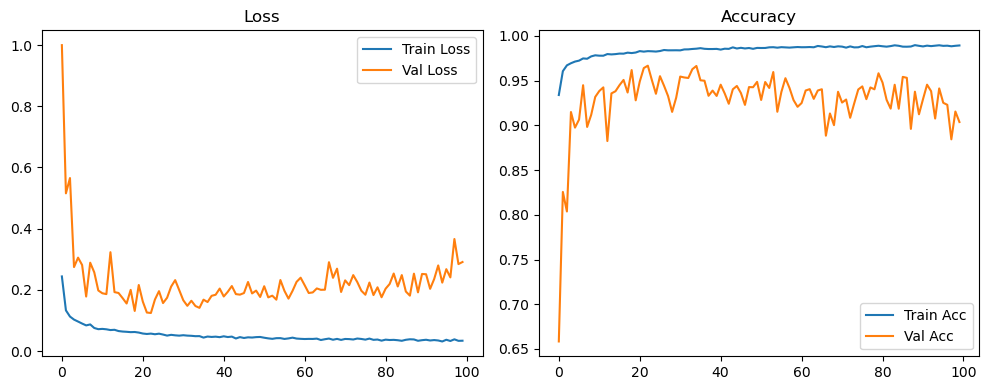

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1186, Acc: 0.9676 | Val Loss: 0.0582, Acc: 0.9824


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9842 | Val Loss: 0.0438, Acc: 0.9867


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9876 | Val Loss: 0.0465, Acc: 0.9865


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9900 | Val Loss: 0.0452, Acc: 0.9873


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9924 | Val Loss: 0.0540, Acc: 0.9830


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0450, Acc: 0.9865


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.0448, Acc: 0.9868


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0399, Acc: 0.9893


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0538, Acc: 0.9861


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0416, Acc: 0.9897


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9957 | Val Loss: 0.0470, Acc: 0.9891


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0487, Acc: 0.9894


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0552, Acc: 0.9878


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0499, Acc: 0.9903


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0442, Acc: 0.9904


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.0450, Acc: 0.9899


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0469, Acc: 0.9900


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0500, Acc: 0.9894


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0496, Acc: 0.9908


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0609, Acc: 0.9874


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0559, Acc: 0.9898


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0571, Acc: 0.9896


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0689, Acc: 0.9883


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0548, Acc: 0.9902


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0489, Acc: 0.9912


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0546, Acc: 0.9894


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0617, Acc: 0.9902


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0641, Acc: 0.9897


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0643, Acc: 0.9902


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0918, Acc: 0.9837


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0680, Acc: 0.9889


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0544, Acc: 0.9911


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0648, Acc: 0.9902


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0602, Acc: 0.9911


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0685, Acc: 0.9895


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0668, Acc: 0.9904


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0503, Acc: 0.9925


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0567, Acc: 0.9922


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0703, Acc: 0.9898


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0632, Acc: 0.9901


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0644, Acc: 0.9906


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0689, Acc: 0.9901


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0713, Acc: 0.9891


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0744, Acc: 0.9902


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0685, Acc: 0.9908


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0742, Acc: 0.9908


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.0687, Acc: 0.9906


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0600, Acc: 0.9921


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0670, Acc: 0.9916


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0799, Acc: 0.9902


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0626, Acc: 0.9922


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0581, Acc: 0.9921


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0565, Acc: 0.9927


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0620, Acc: 0.9927


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0648, Acc: 0.9920


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0557, Acc: 0.9925


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0561, Acc: 0.9931


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0612, Acc: 0.9922


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0610, Acc: 0.9918


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0706, Acc: 0.9911


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0665, Acc: 0.9921


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0633, Acc: 0.9927


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0652, Acc: 0.9930


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0596, Acc: 0.9922


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0700, Acc: 0.9924


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0587, Acc: 0.9923


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0653, Acc: 0.9922


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0633, Acc: 0.9933


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0654, Acc: 0.9926


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0722, Acc: 0.9922


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0771, Acc: 0.9924


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0722, Acc: 0.9922


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0703, Acc: 0.9928


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0676, Acc: 0.9931


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.0750, Acc: 0.9922


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0749, Acc: 0.9918


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0762, Acc: 0.9926


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0732, Acc: 0.9918


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0815, Acc: 0.9922


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0745, Acc: 0.9927


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0789, Acc: 0.9925


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0746, Acc: 0.9923


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0715, Acc: 0.9931


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0689, Acc: 0.9932


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0726, Acc: 0.9932


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0701, Acc: 0.9930


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0750, Acc: 0.9928


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0800, Acc: 0.9923


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0755, Acc: 0.9928


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0812, Acc: 0.9925


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0822, Acc: 0.9925


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0783, Acc: 0.9928


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0794, Acc: 0.9922


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0804, Acc: 0.9920


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0759, Acc: 0.9928


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0750, Acc: 0.9928


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0841, Acc: 0.9918


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0774, Acc: 0.9934


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0747, Acc: 0.9930


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0763, Acc: 0.9928


Final Test Loss: 0.0661 Accuracy: 0.9927


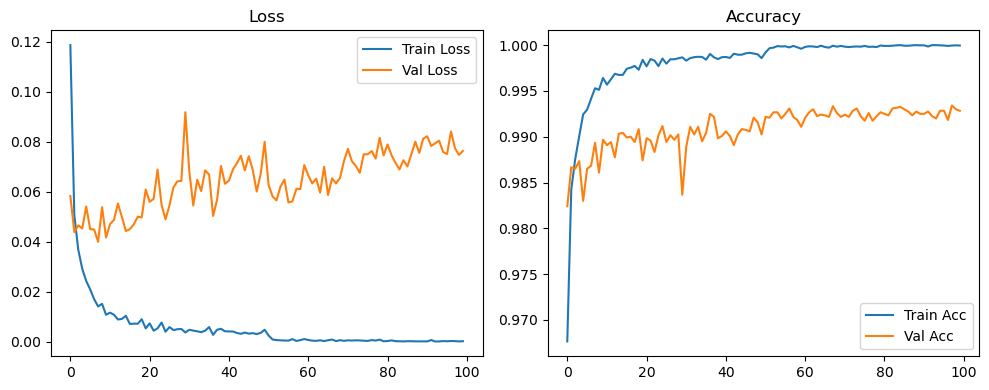

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1471, Acc: 0.9597 | Val Loss: 0.1194, Acc: 0.9620


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0701, Acc: 0.9790 | Val Loss: 0.0773, Acc: 0.9773


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9835 | Val Loss: 0.0735, Acc: 0.9784


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9850 | Val Loss: 0.0503, Acc: 0.9840


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9863 | Val Loss: 0.0559, Acc: 0.9825


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9878 | Val Loss: 0.0612, Acc: 0.9814


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.0469, Acc: 0.9867


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9888 | Val Loss: 0.0489, Acc: 0.9845


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.0435, Acc: 0.9871


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9913 | Val Loss: 0.0645, Acc: 0.9812


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 0.0554, Acc: 0.9847


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9925 | Val Loss: 0.0504, Acc: 0.9870


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.0451, Acc: 0.9882


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.0482, Acc: 0.9866


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.0528, Acc: 0.9850


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9932 | Val Loss: 0.0498, Acc: 0.9857


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.0413, Acc: 0.9884


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.0571, Acc: 0.9855


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.0429, Acc: 0.9884


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 0.0497, Acc: 0.9866


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.0460, Acc: 0.9884


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0434, Acc: 0.9884


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0500, Acc: 0.9880


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.0442, Acc: 0.9882


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0560, Acc: 0.9844


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.0472, Acc: 0.9878


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0624, Acc: 0.9848


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0559, Acc: 0.9872


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0433, Acc: 0.9890


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0455, Acc: 0.9895


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.0492, Acc: 0.9876


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0532, Acc: 0.9871


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0493, Acc: 0.9872


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0488, Acc: 0.9873


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0468, Acc: 0.9874


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0493, Acc: 0.9881


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0546, Acc: 0.9874


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0470, Acc: 0.9885


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0452, Acc: 0.9893


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0468, Acc: 0.9892


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.0481, Acc: 0.9896


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0478, Acc: 0.9891


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0545, Acc: 0.9876


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0599, Acc: 0.9866


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.0523, Acc: 0.9876


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0563, Acc: 0.9877


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0696, Acc: 0.9838


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0578, Acc: 0.9872


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0585, Acc: 0.9862


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.0469, Acc: 0.9885


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0483, Acc: 0.9901


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0532, Acc: 0.9882


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0457, Acc: 0.9898


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0455, Acc: 0.9910


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0471, Acc: 0.9900


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0429, Acc: 0.9911


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0443, Acc: 0.9914


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0433, Acc: 0.9910


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0396, Acc: 0.9911


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0441, Acc: 0.9902


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0511, Acc: 0.9901


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0565, Acc: 0.9882


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0435, Acc: 0.9913


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0492, Acc: 0.9897


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0488, Acc: 0.9898


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0494, Acc: 0.9902


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0488, Acc: 0.9899


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0471, Acc: 0.9905


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0480, Acc: 0.9908


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0505, Acc: 0.9897


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0452, Acc: 0.9909


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0492, Acc: 0.9899


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0510, Acc: 0.9900


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0503, Acc: 0.9891


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0499, Acc: 0.9903


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0487, Acc: 0.9908


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0546, Acc: 0.9898


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0530, Acc: 0.9892


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0502, Acc: 0.9888


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0496, Acc: 0.9894


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0466, Acc: 0.9904


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0456, Acc: 0.9903


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0459, Acc: 0.9905


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0460, Acc: 0.9912


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0514, Acc: 0.9901


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0492, Acc: 0.9907


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0435, Acc: 0.9916


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0431, Acc: 0.9911


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0438, Acc: 0.9900


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0475, Acc: 0.9906


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0496, Acc: 0.9897


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0484, Acc: 0.9911


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0469, Acc: 0.9913


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0420, Acc: 0.9920


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0463, Acc: 0.9916


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0474, Acc: 0.9902


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0451, Acc: 0.9914


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0504, Acc: 0.9910


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0484, Acc: 0.9902


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0453, Acc: 0.9915


Final Test Loss: 0.0443 Accuracy: 0.9906


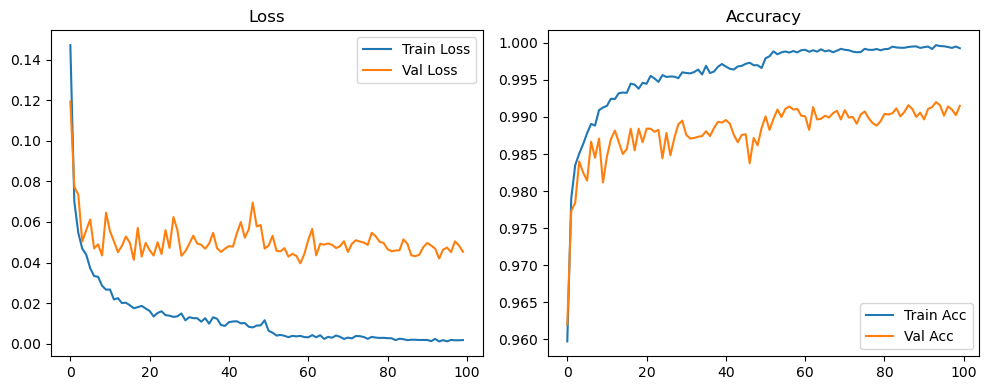

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2455, Acc: 0.9325 | Val Loss: 0.7612, Acc: 0.7351


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1370, Acc: 0.9599 | Val Loss: 0.5014, Acc: 0.8346


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1133, Acc: 0.9666 | Val Loss: 0.5300, Acc: 0.8097


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1042, Acc: 0.9692 | Val Loss: 0.1929, Acc: 0.9428


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0968, Acc: 0.9716 | Val Loss: 0.2929, Acc: 0.8970


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0917, Acc: 0.9731 | Val Loss: 0.2367, Acc: 0.9236


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0845, Acc: 0.9748 | Val Loss: 0.1969, Acc: 0.9353


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9740 | Val Loss: 0.2513, Acc: 0.9145


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0797, Acc: 0.9762 | Val Loss: 0.2568, Acc: 0.9179


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9782 | Val Loss: 0.1728, Acc: 0.9449


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9777 | Val Loss: 0.1875, Acc: 0.9385


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9785 | Val Loss: 0.1345, Acc: 0.9601


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0691, Acc: 0.9791 | Val Loss: 0.2061, Acc: 0.9281


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0705, Acc: 0.9789 | Val Loss: 0.1926, Acc: 0.9409


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0664, Acc: 0.9804 | Val Loss: 0.1687, Acc: 0.9430


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9788 | Val Loss: 0.1652, Acc: 0.9513


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0647, Acc: 0.9804 | Val Loss: 0.1827, Acc: 0.9417


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0623, Acc: 0.9810 | Val Loss: 0.2251, Acc: 0.9274


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9809 | Val Loss: 0.1556, Acc: 0.9524


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0579, Acc: 0.9825 | Val Loss: 0.2152, Acc: 0.9224


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0572, Acc: 0.9827 | Val Loss: 0.2047, Acc: 0.9293


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9820 | Val Loss: 0.1836, Acc: 0.9406


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9822 | Val Loss: 0.1377, Acc: 0.9638


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9824 | Val Loss: 0.1805, Acc: 0.9521


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9836 | Val Loss: 0.1792, Acc: 0.9468


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9836 | Val Loss: 0.1367, Acc: 0.9623


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9840 | Val Loss: 0.1134, Acc: 0.9692


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9831 | Val Loss: 0.1367, Acc: 0.9696


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9840 | Val Loss: 0.1738, Acc: 0.9497


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9843 | Val Loss: 0.2101, Acc: 0.9318


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9846 | Val Loss: 0.1716, Acc: 0.9457


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9845 | Val Loss: 0.1470, Acc: 0.9602


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9840 | Val Loss: 0.1587, Acc: 0.9619


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9849 | Val Loss: 0.1510, Acc: 0.9573


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9847 | Val Loss: 0.1331, Acc: 0.9673


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9859 | Val Loss: 0.1472, Acc: 0.9610


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9844 | Val Loss: 0.1637, Acc: 0.9520


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9858 | Val Loss: 0.1253, Acc: 0.9658


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9852 | Val Loss: 0.1524, Acc: 0.9562


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9853 | Val Loss: 0.1633, Acc: 0.9517


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9851 | Val Loss: 0.2160, Acc: 0.9321


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9863 | Val Loss: 0.1478, Acc: 0.9597


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9850 | Val Loss: 0.1719, Acc: 0.9503


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9866 | Val Loss: 0.2145, Acc: 0.9267


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9860 | Val Loss: 0.1995, Acc: 0.9400


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9865 | Val Loss: 0.2120, Acc: 0.9319


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9863 | Val Loss: 0.2582, Acc: 0.9068


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9864 | Val Loss: 0.1782, Acc: 0.9432


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9865 | Val Loss: 0.2493, Acc: 0.9109


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9874 | Val Loss: 0.1923, Acc: 0.9352


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9888 | Val Loss: 0.1935, Acc: 0.9355


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.1635, Acc: 0.9487


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9895 | Val Loss: 0.1671, Acc: 0.9475


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 0.1701, Acc: 0.9474


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9891 | Val Loss: 0.1757, Acc: 0.9459


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.1749, Acc: 0.9508


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9897 | Val Loss: 0.1918, Acc: 0.9387


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9897 | Val Loss: 0.1815, Acc: 0.9412


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9899 | Val Loss: 0.1820, Acc: 0.9401


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9892 | Val Loss: 0.1729, Acc: 0.9486


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9910 | Val Loss: 0.1906, Acc: 0.9375


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.1883, Acc: 0.9377


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9908 | Val Loss: 0.1636, Acc: 0.9518


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9903 | Val Loss: 0.1542, Acc: 0.9548


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.2085, Acc: 0.9272


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9909 | Val Loss: 0.1792, Acc: 0.9490


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9909 | Val Loss: 0.2119, Acc: 0.9331


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9907 | Val Loss: 0.2089, Acc: 0.9330


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1923, Acc: 0.9365


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9907 | Val Loss: 0.1915, Acc: 0.9373


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.1744, Acc: 0.9475


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.1844, Acc: 0.9383


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.1754, Acc: 0.9524


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9905 | Val Loss: 0.1760, Acc: 0.9480


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9911 | Val Loss: 0.1738, Acc: 0.9524


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.1594, Acc: 0.9595


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.1787, Acc: 0.9467


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9904 | Val Loss: 0.2156, Acc: 0.9330


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9913 | Val Loss: 0.1894, Acc: 0.9491


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.1943, Acc: 0.9436


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9913 | Val Loss: 0.1679, Acc: 0.9552


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.1624, Acc: 0.9606


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9923 | Val Loss: 0.1770, Acc: 0.9489


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.1806, Acc: 0.9524


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9928 | Val Loss: 0.1566, Acc: 0.9617


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.1813, Acc: 0.9510


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.1760, Acc: 0.9527


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9920 | Val Loss: 0.1973, Acc: 0.9389


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9924 | Val Loss: 0.1954, Acc: 0.9408


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.1768, Acc: 0.9536


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.2000, Acc: 0.9437


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9925 | Val Loss: 0.1990, Acc: 0.9418


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9921 | Val Loss: 0.1955, Acc: 0.9473


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.1970, Acc: 0.9425


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9924 | Val Loss: 0.2000, Acc: 0.9386


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.2040, Acc: 0.9377


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.1753, Acc: 0.9486


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.1953, Acc: 0.9454


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.1681, Acc: 0.9556


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.1696, Acc: 0.9537


Final Test Loss: 0.1696 Accuracy: 0.9542


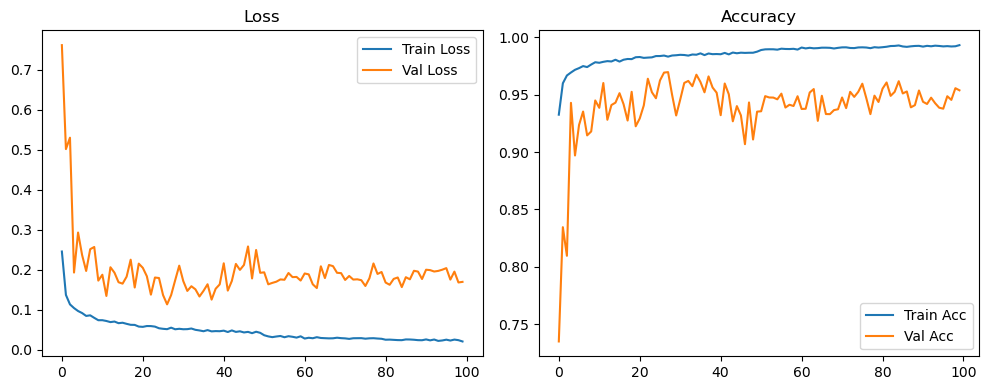

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1375, Acc: 0.9691 | Val Loss: 0.0524, Acc: 0.9838


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0480, Acc: 0.9855 | Val Loss: 0.0459, Acc: 0.9858


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9891 | Val Loss: 0.0453, Acc: 0.9868


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.0416, Acc: 0.9874


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0412, Acc: 0.9878


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.0427, Acc: 0.9864


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.0419, Acc: 0.9878


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0445, Acc: 0.9892


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.0437, Acc: 0.9873


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0489, Acc: 0.9878


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0539, Acc: 0.9867


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0510, Acc: 0.9872


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0397, Acc: 0.9884


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0436, Acc: 0.9892


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0378, Acc: 0.9909


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0461, Acc: 0.9903


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0449, Acc: 0.9890


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0507, Acc: 0.9897


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0454, Acc: 0.9893


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0492, Acc: 0.9892


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0451, Acc: 0.9905


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0462, Acc: 0.9901


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0438, Acc: 0.9906


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0490, Acc: 0.9898


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0506, Acc: 0.9897


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0515, Acc: 0.9888


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0416, Acc: 0.9921


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0525, Acc: 0.9893


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0493, Acc: 0.9901


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0522, Acc: 0.9903


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0530, Acc: 0.9908


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0564, Acc: 0.9902


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0553, Acc: 0.9888


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0481, Acc: 0.9899


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0605, Acc: 0.9887


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0539, Acc: 0.9896


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0500, Acc: 0.9908


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0631, Acc: 0.9891


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0440, Acc: 0.9912


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0575, Acc: 0.9885


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0475, Acc: 0.9897


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.0539, Acc: 0.9908


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0592, Acc: 0.9908


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0645, Acc: 0.9893


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0561, Acc: 0.9908


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0457, Acc: 0.9911


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0562, Acc: 0.9909


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0560, Acc: 0.9900


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0506, Acc: 0.9910


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0527, Acc: 0.9910


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0623, Acc: 0.9890


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0552, Acc: 0.9912


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0528, Acc: 0.9918


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0558, Acc: 0.9909


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0609, Acc: 0.9897


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0623, Acc: 0.9898


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0582, Acc: 0.9905


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0665, Acc: 0.9903


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0629, Acc: 0.9892


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0546, Acc: 0.9912


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0545, Acc: 0.9905


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0570, Acc: 0.9909


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0576, Acc: 0.9907


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0576, Acc: 0.9912


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0603, Acc: 0.9906


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0492, Acc: 0.9919


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0565, Acc: 0.9912


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0540, Acc: 0.9911


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0594, Acc: 0.9910


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0619, Acc: 0.9909


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0532, Acc: 0.9910


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0641, Acc: 0.9906


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0570, Acc: 0.9912


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0580, Acc: 0.9910


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0577, Acc: 0.9917


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0534, Acc: 0.9923


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0598, Acc: 0.9916


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0512, Acc: 0.9915


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0643, Acc: 0.9904


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0616, Acc: 0.9915


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.0698, Acc: 0.9905


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0633, Acc: 0.9906


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0665, Acc: 0.9908


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0689, Acc: 0.9906


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0576, Acc: 0.9922


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0681, Acc: 0.9902


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0705, Acc: 0.9905


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0737, Acc: 0.9911


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0655, Acc: 0.9913


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0656, Acc: 0.9909


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0687, Acc: 0.9907


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0671, Acc: 0.9919


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0666, Acc: 0.9912


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0684, Acc: 0.9914


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0752, Acc: 0.9901


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0655, Acc: 0.9911


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0751, Acc: 0.9912


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0628, Acc: 0.9914


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0604, Acc: 0.9907


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0723, Acc: 0.9909


Final Test Loss: 0.0762 Accuracy: 0.9900


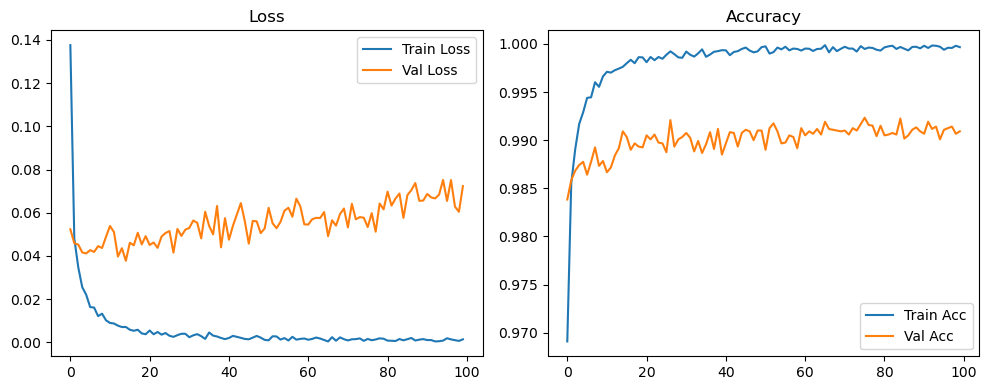

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1655, Acc: 0.9631 | Val Loss: 0.1165, Acc: 0.9647


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0651, Acc: 0.9799 | Val Loss: 0.0675, Acc: 0.9801


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9834 | Val Loss: 0.0639, Acc: 0.9808


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9857 | Val Loss: 0.0515, Acc: 0.9844


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 0.0437, Acc: 0.9877


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9891 | Val Loss: 0.0642, Acc: 0.9796


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.0561, Acc: 0.9827


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9893 | Val Loss: 0.0543, Acc: 0.9832


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.0394, Acc: 0.9879


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9917 | Val Loss: 0.0459, Acc: 0.9858


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9926 | Val Loss: 0.0563, Acc: 0.9834


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.0414, Acc: 0.9866


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.0425, Acc: 0.9889


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9938 | Val Loss: 0.0403, Acc: 0.9889


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9935 | Val Loss: 0.0409, Acc: 0.9880


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.0487, Acc: 0.9858


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9951 | Val Loss: 0.0408, Acc: 0.9883


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9947 | Val Loss: 0.0475, Acc: 0.9866


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0429, Acc: 0.9884


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0361, Acc: 0.9897


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0437, Acc: 0.9886


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.0363, Acc: 0.9904


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0398, Acc: 0.9893


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.0422, Acc: 0.9892


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0413, Acc: 0.9892


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0413, Acc: 0.9890


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0479, Acc: 0.9875


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0418, Acc: 0.9893


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0385, Acc: 0.9902


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0418, Acc: 0.9891


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0410, Acc: 0.9892


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0421, Acc: 0.9897


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.0421, Acc: 0.9882


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0416, Acc: 0.9889


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0378, Acc: 0.9906


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0499, Acc: 0.9864


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0388, Acc: 0.9908


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0397, Acc: 0.9896


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0419, Acc: 0.9893


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.0411, Acc: 0.9893


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0404, Acc: 0.9900


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0424, Acc: 0.9898


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0383, Acc: 0.9898


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0409, Acc: 0.9886


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0465, Acc: 0.9882


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.0405, Acc: 0.9892


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0490, Acc: 0.9878


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0472, Acc: 0.9895


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0478, Acc: 0.9882


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0373, Acc: 0.9905


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0411, Acc: 0.9897


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0478, Acc: 0.9882


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0400, Acc: 0.9897


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0392, Acc: 0.9899


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0445, Acc: 0.9887


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0430, Acc: 0.9888


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0419, Acc: 0.9880


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0377, Acc: 0.9903


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0406, Acc: 0.9894


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0399, Acc: 0.9893


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0426, Acc: 0.9890


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0414, Acc: 0.9888


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0460, Acc: 0.9882


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.0480, Acc: 0.9880


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0422, Acc: 0.9896


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0480, Acc: 0.9875


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0383, Acc: 0.9906


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0393, Acc: 0.9900


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0445, Acc: 0.9877


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0408, Acc: 0.9896


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0417, Acc: 0.9896


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0393, Acc: 0.9895


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0477, Acc: 0.9895


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0441, Acc: 0.9878


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0442, Acc: 0.9891


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0376, Acc: 0.9910


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0428, Acc: 0.9898


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0401, Acc: 0.9896


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0434, Acc: 0.9888


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0445, Acc: 0.9898


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0373, Acc: 0.9901


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0420, Acc: 0.9901


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0422, Acc: 0.9898


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0441, Acc: 0.9894


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0453, Acc: 0.9894


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0426, Acc: 0.9893


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0440, Acc: 0.9892


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0417, Acc: 0.9892


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0441, Acc: 0.9893


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0391, Acc: 0.9905


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0418, Acc: 0.9882


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0383, Acc: 0.9899


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0420, Acc: 0.9901


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0448, Acc: 0.9883


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0473, Acc: 0.9879


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.0458, Acc: 0.9888


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0496, Acc: 0.9867


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0438, Acc: 0.9881


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0381, Acc: 0.9911


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0403, Acc: 0.9904


Final Test Loss: 0.0424 Accuracy: 0.9902


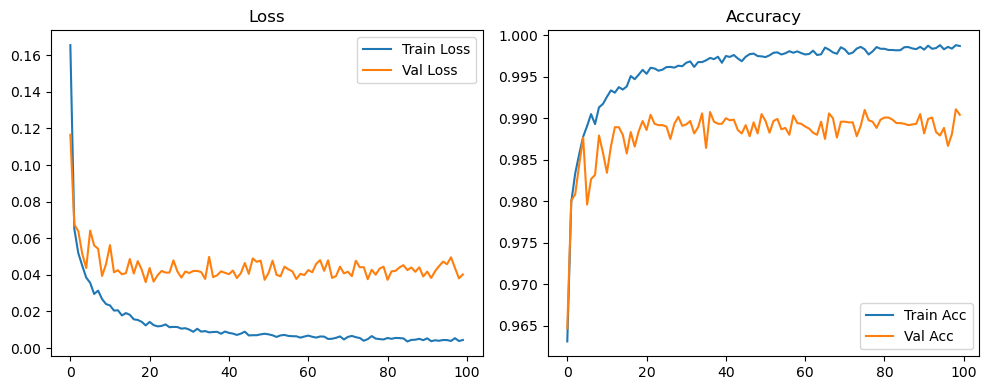

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2742, Acc: 0.9337 | Val Loss: 1.0033, Acc: 0.6352


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1313, Acc: 0.9619 | Val Loss: 0.6733, Acc: 0.7695


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1079, Acc: 0.9679 | Val Loss: 0.6055, Acc: 0.7828


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1004, Acc: 0.9710 | Val Loss: 0.3722, Acc: 0.8680


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0913, Acc: 0.9737 | Val Loss: 0.3021, Acc: 0.8981


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0863, Acc: 0.9742 | Val Loss: 0.2665, Acc: 0.9117


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0808, Acc: 0.9756 | Val Loss: 0.2082, Acc: 0.9311


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0822, Acc: 0.9751 | Val Loss: 0.1839, Acc: 0.9434


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0723, Acc: 0.9776 | Val Loss: 0.2408, Acc: 0.9145


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0715, Acc: 0.9783 | Val Loss: 0.1986, Acc: 0.9311


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0691, Acc: 0.9791 | Val Loss: 0.1923, Acc: 0.9345


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0652, Acc: 0.9795 | Val Loss: 0.1288, Acc: 0.9611


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0640, Acc: 0.9806 | Val Loss: 0.2295, Acc: 0.9198


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0659, Acc: 0.9804 | Val Loss: 0.1851, Acc: 0.9379


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0640, Acc: 0.9806 | Val Loss: 0.1896, Acc: 0.9380


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0599, Acc: 0.9818 | Val Loss: 0.1767, Acc: 0.9433


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0613, Acc: 0.9820 | Val Loss: 0.1891, Acc: 0.9367


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0576, Acc: 0.9821 | Val Loss: 0.2460, Acc: 0.9146


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0563, Acc: 0.9824 | Val Loss: 0.1763, Acc: 0.9380


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0532, Acc: 0.9832 | Val Loss: 0.1783, Acc: 0.9443


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0539, Acc: 0.9834 | Val Loss: 0.1748, Acc: 0.9386


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0541, Acc: 0.9829 | Val Loss: 0.1643, Acc: 0.9462


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9835 | Val Loss: 0.1697, Acc: 0.9451


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9837 | Val Loss: 0.1667, Acc: 0.9441


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0532, Acc: 0.9840 | Val Loss: 0.1678, Acc: 0.9442


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9842 | Val Loss: 0.1535, Acc: 0.9515


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0489, Acc: 0.9846 | Val Loss: 0.1453, Acc: 0.9548


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9841 | Val Loss: 0.1619, Acc: 0.9537


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0467, Acc: 0.9854 | Val Loss: 0.1719, Acc: 0.9471


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9861 | Val Loss: 0.1979, Acc: 0.9312


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9850 | Val Loss: 0.1818, Acc: 0.9366


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9854 | Val Loss: 0.1484, Acc: 0.9557


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0483, Acc: 0.9858 | Val Loss: 0.1584, Acc: 0.9544


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9856 | Val Loss: 0.1516, Acc: 0.9573


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9863 | Val Loss: 0.1601, Acc: 0.9539


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9872 | Val Loss: 0.1446, Acc: 0.9575


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9871 | Val Loss: 0.1218, Acc: 0.9660


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9866 | Val Loss: 0.1397, Acc: 0.9612


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9867 | Val Loss: 0.1445, Acc: 0.9599


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9864 | Val Loss: 0.1632, Acc: 0.9505


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9872 | Val Loss: 0.1731, Acc: 0.9495


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9875 | Val Loss: 0.1325, Acc: 0.9664


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9869 | Val Loss: 0.1679, Acc: 0.9544


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9871 | Val Loss: 0.1740, Acc: 0.9541


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0402, Acc: 0.9879 | Val Loss: 0.1585, Acc: 0.9589


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9870 | Val Loss: 0.1771, Acc: 0.9585


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9879 | Val Loss: 0.1946, Acc: 0.9426


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9872 | Val Loss: 0.1674, Acc: 0.9590


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9874 | Val Loss: 0.1710, Acc: 0.9524


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9882 | Val Loss: 0.1414, Acc: 0.9643


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9882 | Val Loss: 0.1490, Acc: 0.9607


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9882 | Val Loss: 0.1546, Acc: 0.9592


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9875 | Val Loss: 0.1614, Acc: 0.9629


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9876 | Val Loss: 0.1675, Acc: 0.9620


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 0.1551, Acc: 0.9558


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 0.1501, Acc: 0.9664


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9871 | Val Loss: 0.1603, Acc: 0.9632


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9880 | Val Loss: 0.1389, Acc: 0.9623


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9889 | Val Loss: 0.1582, Acc: 0.9579


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9883 | Val Loss: 0.1798, Acc: 0.9535


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9885 | Val Loss: 0.1832, Acc: 0.9477


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9876 | Val Loss: 0.1348, Acc: 0.9653


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9891 | Val Loss: 0.1348, Acc: 0.9661


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9888 | Val Loss: 0.1371, Acc: 0.9618


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9893 | Val Loss: 0.1457, Acc: 0.9646


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9883 | Val Loss: 0.1440, Acc: 0.9607


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9888 | Val Loss: 0.1622, Acc: 0.9610


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9889 | Val Loss: 0.1830, Acc: 0.9521


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.1825, Acc: 0.9551


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9884 | Val Loss: 0.1634, Acc: 0.9581


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 0.1638, Acc: 0.9542


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9892 | Val Loss: 0.1711, Acc: 0.9573


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9904 | Val Loss: 0.1576, Acc: 0.9604


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9893 | Val Loss: 0.1676, Acc: 0.9555


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.1782, Acc: 0.9523


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 0.1656, Acc: 0.9526


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9889 | Val Loss: 0.2056, Acc: 0.9493


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9890 | Val Loss: 0.1692, Acc: 0.9516


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.1975, Acc: 0.9449


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.2027, Acc: 0.9431


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9890 | Val Loss: 0.2114, Acc: 0.9478


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9901 | Val Loss: 0.2349, Acc: 0.9396


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.2089, Acc: 0.9389


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9902 | Val Loss: 0.1822, Acc: 0.9547


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9908 | Val Loss: 0.2056, Acc: 0.9405


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9890 | Val Loss: 0.2291, Acc: 0.9280


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9891 | Val Loss: 0.1910, Acc: 0.9497


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9909 | Val Loss: 0.2162, Acc: 0.9310


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9907 | Val Loss: 0.2071, Acc: 0.9432


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9902 | Val Loss: 0.1976, Acc: 0.9432


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9897 | Val Loss: 0.2383, Acc: 0.9323


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9902 | Val Loss: 0.2385, Acc: 0.9399


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.2308, Acc: 0.9499


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9902 | Val Loss: 0.2093, Acc: 0.9566


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 0.1858, Acc: 0.9523


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9906 | Val Loss: 0.2043, Acc: 0.9384


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9902 | Val Loss: 0.2335, Acc: 0.9332


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9903 | Val Loss: 0.2200, Acc: 0.9433


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9899 | Val Loss: 0.2216, Acc: 0.9310


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.2137, Acc: 0.9438


Final Test Loss: 0.2156 Accuracy: 0.9421


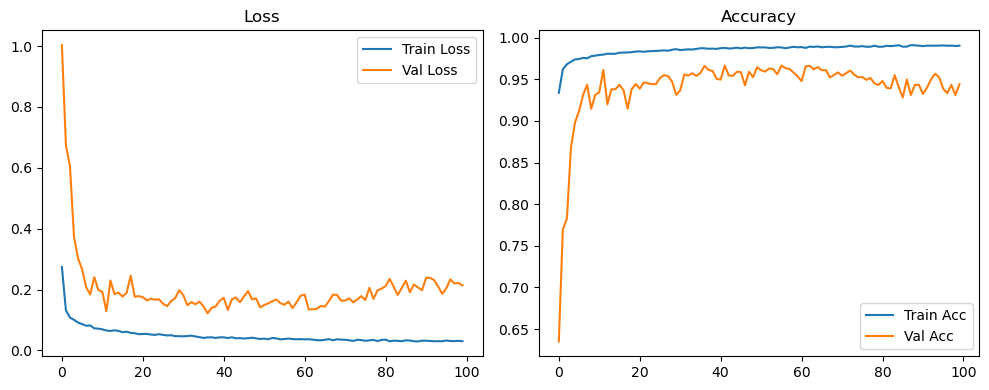

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1766, Acc: 0.9682 | Val Loss: 0.0590, Acc: 0.9832


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9860 | Val Loss: 0.0470, Acc: 0.9865


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9897 | Val Loss: 0.0451, Acc: 0.9865


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.0451, Acc: 0.9860


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9928 | Val Loss: 0.0391, Acc: 0.9884


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.0459, Acc: 0.9862


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0383, Acc: 0.9893


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0447, Acc: 0.9861


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0474, Acc: 0.9864


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0414, Acc: 0.9892


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0462, Acc: 0.9880


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0425, Acc: 0.9894


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0418, Acc: 0.9893


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0544, Acc: 0.9870


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0468, Acc: 0.9880


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0531, Acc: 0.9866


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0428, Acc: 0.9898


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0348, Acc: 0.9918


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0454, Acc: 0.9882


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0380, Acc: 0.9908


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0451, Acc: 0.9904


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0387, Acc: 0.9906


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0517, Acc: 0.9878


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0427, Acc: 0.9903


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0454, Acc: 0.9892


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0442, Acc: 0.9899


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0467, Acc: 0.9885


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0502, Acc: 0.9891


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0463, Acc: 0.9902


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0472, Acc: 0.9895


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0508, Acc: 0.9894


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0446, Acc: 0.9911


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0447, Acc: 0.9906


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.0484, Acc: 0.9902


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0538, Acc: 0.9886


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0531, Acc: 0.9898


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0435, Acc: 0.9912


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0435, Acc: 0.9914


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0485, Acc: 0.9910


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0597, Acc: 0.9891


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0482, Acc: 0.9916


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0530, Acc: 0.9898


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0576, Acc: 0.9887


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9990 | Val Loss: 0.0465, Acc: 0.9906


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0450, Acc: 0.9912


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0483, Acc: 0.9893


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0469, Acc: 0.9912


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0455, Acc: 0.9915


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0501, Acc: 0.9909


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0508, Acc: 0.9903


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0420, Acc: 0.9923


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0495, Acc: 0.9913


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0467, Acc: 0.9908


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0525, Acc: 0.9901


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0465, Acc: 0.9908


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0486, Acc: 0.9904


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0558, Acc: 0.9890


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0501, Acc: 0.9900


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0550, Acc: 0.9898


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0550, Acc: 0.9899


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0533, Acc: 0.9901


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0587, Acc: 0.9901


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0518, Acc: 0.9907


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0436, Acc: 0.9922


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0527, Acc: 0.9905


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0522, Acc: 0.9912


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0553, Acc: 0.9900


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0562, Acc: 0.9902


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0534, Acc: 0.9903


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0507, Acc: 0.9912


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0497, Acc: 0.9907


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0491, Acc: 0.9912


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0581, Acc: 0.9902


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0529, Acc: 0.9902


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0554, Acc: 0.9903


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0516, Acc: 0.9911


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0491, Acc: 0.9915


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0599, Acc: 0.9902


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0424, Acc: 0.9926


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0448, Acc: 0.9918


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0437, Acc: 0.9925


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0531, Acc: 0.9908


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0521, Acc: 0.9898


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0549, Acc: 0.9902


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0563, Acc: 0.9897


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0509, Acc: 0.9916


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0504, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0510, Acc: 0.9917


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0561, Acc: 0.9892


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0519, Acc: 0.9911


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0578, Acc: 0.9910


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0524, Acc: 0.9911


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0586, Acc: 0.9911


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0495, Acc: 0.9922


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0613, Acc: 0.9910


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0586, Acc: 0.9908


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0518, Acc: 0.9916


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0567, Acc: 0.9913


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0530, Acc: 0.9918


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0574, Acc: 0.9909


Final Test Loss: 0.0574 Accuracy: 0.9912


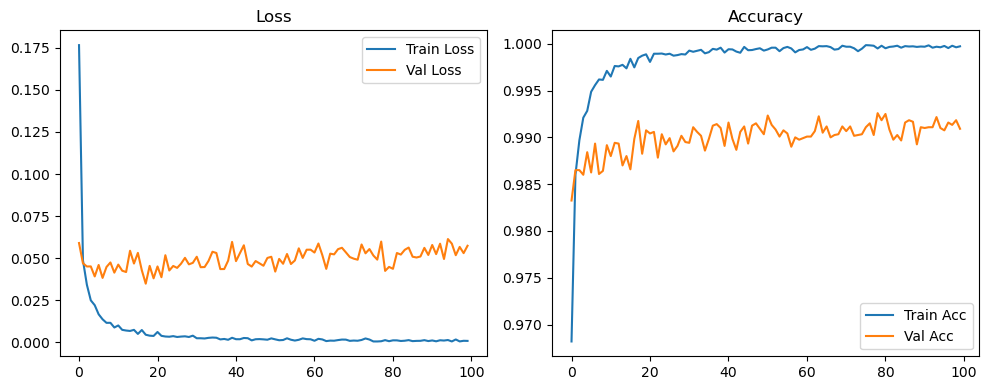

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2118, Acc: 0.9603 | Val Loss: 0.1290, Acc: 0.9647


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0673, Acc: 0.9800 | Val Loss: 0.0675, Acc: 0.9825


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0532, Acc: 0.9835 | Val Loss: 0.0774, Acc: 0.9788


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9863 | Val Loss: 0.0681, Acc: 0.9793


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0406, Acc: 0.9870 | Val Loss: 0.0487, Acc: 0.9852


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9890 | Val Loss: 0.0616, Acc: 0.9828


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.0491, Acc: 0.9848


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 0.0462, Acc: 0.9855


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9909 | Val Loss: 0.0464, Acc: 0.9854


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.0403, Acc: 0.9869


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0514, Acc: 0.9848


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9921 | Val Loss: 0.0407, Acc: 0.9878


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.0475, Acc: 0.9858


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.0438, Acc: 0.9873


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0393, Acc: 0.9894


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0511, Acc: 0.9848


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0423, Acc: 0.9872


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0431, Acc: 0.9877


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0403, Acc: 0.9892


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0391, Acc: 0.9888


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0410, Acc: 0.9884


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0419, Acc: 0.9886


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9955 | Val Loss: 0.0449, Acc: 0.9881


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9956 | Val Loss: 0.0380, Acc: 0.9901


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.0457, Acc: 0.9879


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0452, Acc: 0.9884


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0405, Acc: 0.9889


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0485, Acc: 0.9878


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0458, Acc: 0.9876


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0496, Acc: 0.9870


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0403, Acc: 0.9892


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0555, Acc: 0.9855


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0409, Acc: 0.9888


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9970 | Val Loss: 0.0400, Acc: 0.9892


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0441, Acc: 0.9882


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.0377, Acc: 0.9896


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.0433, Acc: 0.9881


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9969 | Val Loss: 0.0393, Acc: 0.9896


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0408, Acc: 0.9900


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0411, Acc: 0.9894


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0416, Acc: 0.9898


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0464, Acc: 0.9880


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0414, Acc: 0.9897


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0497, Acc: 0.9876


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0475, Acc: 0.9887


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0443, Acc: 0.9891


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0542, Acc: 0.9864


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0458, Acc: 0.9885


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0491, Acc: 0.9881


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0430, Acc: 0.9896


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0460, Acc: 0.9877


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0394, Acc: 0.9895


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0438, Acc: 0.9896


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0401, Acc: 0.9902


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0440, Acc: 0.9881


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9977 | Val Loss: 0.0398, Acc: 0.9898


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0415, Acc: 0.9886


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0415, Acc: 0.9896


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0377, Acc: 0.9903


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.0423, Acc: 0.9884


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0462, Acc: 0.9872


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0436, Acc: 0.9896


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0380, Acc: 0.9908


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0419, Acc: 0.9893


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0412, Acc: 0.9898


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0438, Acc: 0.9895


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0399, Acc: 0.9902


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0418, Acc: 0.9893


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0472, Acc: 0.9880


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9983 | Val Loss: 0.0407, Acc: 0.9898


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0461, Acc: 0.9878


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0494, Acc: 0.9871


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0427, Acc: 0.9898


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0415, Acc: 0.9906


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0472, Acc: 0.9888


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0377, Acc: 0.9902


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0492, Acc: 0.9872


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0420, Acc: 0.9893


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0441, Acc: 0.9891


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0386, Acc: 0.9904


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0471, Acc: 0.9880


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0427, Acc: 0.9894


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0415, Acc: 0.9901


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0424, Acc: 0.9898


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0435, Acc: 0.9905


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0413, Acc: 0.9903


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0398, Acc: 0.9899


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0472, Acc: 0.9882


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0453, Acc: 0.9892


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0491, Acc: 0.9880


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0510, Acc: 0.9881


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0450, Acc: 0.9890


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0412, Acc: 0.9897


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0405, Acc: 0.9901


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0431, Acc: 0.9905


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0425, Acc: 0.9890


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.0461, Acc: 0.9881


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0426, Acc: 0.9901


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0426, Acc: 0.9896


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0348, Acc: 0.9911


Final Test Loss: 0.0362 Accuracy: 0.9900


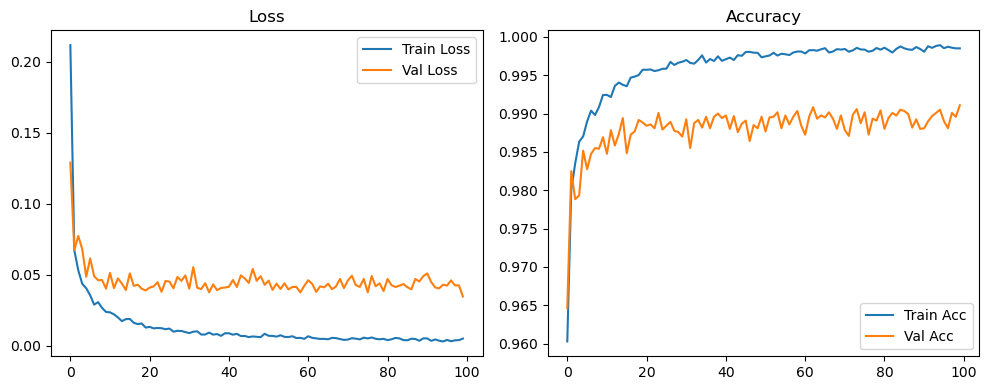

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3438, Acc: 0.9280 | Val Loss: 1.2358, Acc: 0.5509


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1355, Acc: 0.9623 | Val Loss: 0.7291, Acc: 0.7364


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1128, Acc: 0.9683 | Val Loss: 0.8421, Acc: 0.7099


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1029, Acc: 0.9701 | Val Loss: 0.4646, Acc: 0.8421


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0938, Acc: 0.9726 | Val Loss: 0.4249, Acc: 0.8558


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0885, Acc: 0.9741 | Val Loss: 0.3911, Acc: 0.8671


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0821, Acc: 0.9749 | Val Loss: 0.3275, Acc: 0.8852


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0839, Acc: 0.9754 | Val Loss: 0.3426, Acc: 0.8784


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0723, Acc: 0.9787 | Val Loss: 0.2590, Acc: 0.9148


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0722, Acc: 0.9781 | Val Loss: 0.2643, Acc: 0.9091


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0709, Acc: 0.9786 | Val Loss: 0.2453, Acc: 0.9137


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0707, Acc: 0.9784 | Val Loss: 0.1780, Acc: 0.9423


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0679, Acc: 0.9790 | Val Loss: 0.2245, Acc: 0.9256


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0642, Acc: 0.9808 | Val Loss: 0.3105, Acc: 0.8943


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0614, Acc: 0.9813 | Val Loss: 0.1773, Acc: 0.9425


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0594, Acc: 0.9817 | Val Loss: 0.2178, Acc: 0.9259


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0616, Acc: 0.9815 | Val Loss: 0.1877, Acc: 0.9365


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0583, Acc: 0.9825 | Val Loss: 0.2150, Acc: 0.9290


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0560, Acc: 0.9823 | Val Loss: 0.1312, Acc: 0.9586


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0539, Acc: 0.9826 | Val Loss: 0.2435, Acc: 0.9118


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0567, Acc: 0.9825 | Val Loss: 0.1606, Acc: 0.9467


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9831 | Val Loss: 0.1685, Acc: 0.9408


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9835 | Val Loss: 0.1690, Acc: 0.9456


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0526, Acc: 0.9837 | Val Loss: 0.1868, Acc: 0.9396


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0518, Acc: 0.9838 | Val Loss: 0.2046, Acc: 0.9309


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0516, Acc: 0.9835 | Val Loss: 0.1851, Acc: 0.9397


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9855 | Val Loss: 0.1777, Acc: 0.9403


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0506, Acc: 0.9843 | Val Loss: 0.1623, Acc: 0.9527


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0478, Acc: 0.9846 | Val Loss: 0.1635, Acc: 0.9548


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9852 | Val Loss: 0.2302, Acc: 0.9216


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0480, Acc: 0.9852 | Val Loss: 0.1671, Acc: 0.9495


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0492, Acc: 0.9852 | Val Loss: 0.2097, Acc: 0.9335


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0496, Acc: 0.9848 | Val Loss: 0.1948, Acc: 0.9397


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9849 | Val Loss: 0.1506, Acc: 0.9573


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0447, Acc: 0.9863 | Val Loss: 0.1374, Acc: 0.9673


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0421, Acc: 0.9871 | Val Loss: 0.1452, Acc: 0.9616


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.1317, Acc: 0.9663


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9868 | Val Loss: 0.1485, Acc: 0.9567


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0419, Acc: 0.9862 | Val Loss: 0.1693, Acc: 0.9473


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0450, Acc: 0.9858 | Val Loss: 0.1578, Acc: 0.9593


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9859 | Val Loss: 0.1880, Acc: 0.9458


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9873 | Val Loss: 0.1715, Acc: 0.9500


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9876 | Val Loss: 0.1519, Acc: 0.9583


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0404, Acc: 0.9870 | Val Loss: 0.1451, Acc: 0.9616


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9872 | Val Loss: 0.1784, Acc: 0.9475


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0406, Acc: 0.9870 | Val Loss: 0.1503, Acc: 0.9601


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9870 | Val Loss: 0.1827, Acc: 0.9479


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9873 | Val Loss: 0.1679, Acc: 0.9543


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0415, Acc: 0.9871 | Val Loss: 0.1585, Acc: 0.9543


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9888 | Val Loss: 0.1455, Acc: 0.9611


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0393, Acc: 0.9878 | Val Loss: 0.1553, Acc: 0.9613


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0384, Acc: 0.9883 | Val Loss: 0.1440, Acc: 0.9612


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9882 | Val Loss: 0.1538, Acc: 0.9576


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9872 | Val Loss: 0.1621, Acc: 0.9610


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9879 | Val Loss: 0.1690, Acc: 0.9531


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9882 | Val Loss: 0.1435, Acc: 0.9635


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9879 | Val Loss: 0.1894, Acc: 0.9455


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9884 | Val Loss: 0.1337, Acc: 0.9653


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9882 | Val Loss: 0.1791, Acc: 0.9527


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.1891, Acc: 0.9453


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.2328, Acc: 0.9280


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9886 | Val Loss: 0.1941, Acc: 0.9493


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9885 | Val Loss: 0.1883, Acc: 0.9518


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0365, Acc: 0.9885 | Val Loss: 0.1578, Acc: 0.9577


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.1804, Acc: 0.9495


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9893 | Val Loss: 0.1863, Acc: 0.9499


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9888 | Val Loss: 0.1957, Acc: 0.9468


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9892 | Val Loss: 0.2085, Acc: 0.9407


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0365, Acc: 0.9887 | Val Loss: 0.2086, Acc: 0.9413


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9886 | Val Loss: 0.2100, Acc: 0.9440


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.1647, Acc: 0.9567


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9890 | Val Loss: 0.2140, Acc: 0.9397


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.1827, Acc: 0.9484


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9897 | Val Loss: 0.2203, Acc: 0.9404


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9894 | Val Loss: 0.1852, Acc: 0.9576


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9901 | Val Loss: 0.2313, Acc: 0.9368


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9905 | Val Loss: 0.2636, Acc: 0.9091


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9894 | Val Loss: 0.1763, Acc: 0.9587


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.2069, Acc: 0.9482


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.2010, Acc: 0.9480


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9896 | Val Loss: 0.2044, Acc: 0.9472


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9896 | Val Loss: 0.2129, Acc: 0.9416


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.2421, Acc: 0.9302


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9894 | Val Loss: 0.1911, Acc: 0.9514


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9908 | Val Loss: 0.1919, Acc: 0.9500


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9891 | Val Loss: 0.2341, Acc: 0.9377


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.2161, Acc: 0.9437


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 0.2491, Acc: 0.9259


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9906 | Val Loss: 0.2036, Acc: 0.9495


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.1873, Acc: 0.9579


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9905 | Val Loss: 0.2366, Acc: 0.9372


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9908 | Val Loss: 0.2191, Acc: 0.9447


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.2158, Acc: 0.9464


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.1663, Acc: 0.9620


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9905 | Val Loss: 0.2138, Acc: 0.9438


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9900 | Val Loss: 0.2375, Acc: 0.9332


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.2304, Acc: 0.9412


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9907 | Val Loss: 0.2188, Acc: 0.9406


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9902 | Val Loss: 0.2215, Acc: 0.9465


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9893 | Val Loss: 0.2228, Acc: 0.9489


Final Test Loss: 0.2205 Accuracy: 0.9489


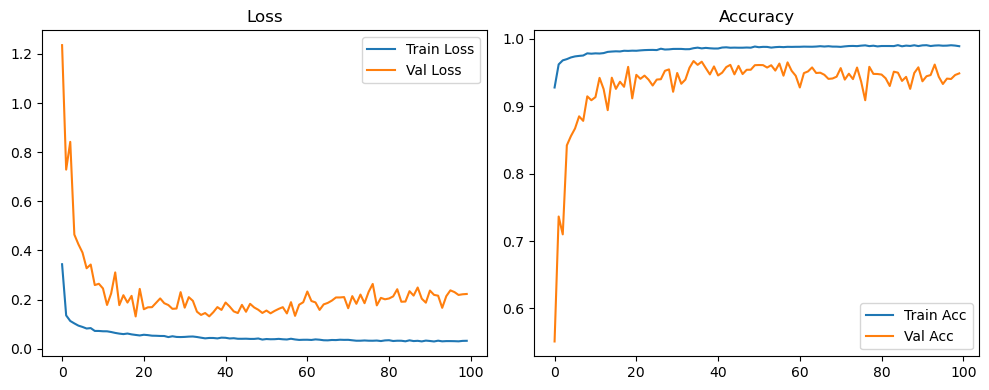

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1272, Acc: 0.9638 | Val Loss: 0.0541, Acc: 0.9842


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9840 | Val Loss: 0.0501, Acc: 0.9844


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9887 | Val Loss: 0.0582, Acc: 0.9828


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.0451, Acc: 0.9878


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.0631, Acc: 0.9836


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.0477, Acc: 0.9858


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.0411, Acc: 0.9878


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0567, Acc: 0.9848


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0446, Acc: 0.9887


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0492, Acc: 0.9887


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9959 | Val Loss: 0.0498, Acc: 0.9885


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0573, Acc: 0.9856


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0502, Acc: 0.9892


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0591, Acc: 0.9898


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0570, Acc: 0.9892


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.0555, Acc: 0.9881


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0678, Acc: 0.9869


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0644, Acc: 0.9892


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0623, Acc: 0.9893


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0577, Acc: 0.9898


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0702, Acc: 0.9876


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0652, Acc: 0.9890


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0576, Acc: 0.9902


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0520, Acc: 0.9915


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0572, Acc: 0.9909


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0672, Acc: 0.9887


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0878, Acc: 0.9862


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0649, Acc: 0.9893


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0648, Acc: 0.9890


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0587, Acc: 0.9905


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0636, Acc: 0.9899


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0665, Acc: 0.9897


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0602, Acc: 0.9912


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0676, Acc: 0.9888


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0648, Acc: 0.9907


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.0568, Acc: 0.9911


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0579, Acc: 0.9910


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0720, Acc: 0.9904


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0709, Acc: 0.9894


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.0693, Acc: 0.9895


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0760, Acc: 0.9893


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0688, Acc: 0.9904


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0754, Acc: 0.9902


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1010, Acc: 0.9872


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0884, Acc: 0.9888


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0791, Acc: 0.9899


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0732, Acc: 0.9896


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0727, Acc: 0.9901


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.0822, Acc: 0.9892


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0728, Acc: 0.9911


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0744, Acc: 0.9906


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1135, Acc: 0.9882


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0876, Acc: 0.9896


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.0840, Acc: 0.9898


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9986 | Val Loss: 0.0739, Acc: 0.9912


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0732, Acc: 0.9919


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0927, Acc: 0.9902


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0922, Acc: 0.9894


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0857, Acc: 0.9900


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0779, Acc: 0.9917


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1190, Acc: 0.9882


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1016, Acc: 0.9888


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0894, Acc: 0.9896


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0968, Acc: 0.9891


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9990 | Val Loss: 0.0845, Acc: 0.9903


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0861, Acc: 0.9908


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0817, Acc: 0.9908


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0833, Acc: 0.9908


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0991, Acc: 0.9907


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1194, Acc: 0.9892


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.0912, Acc: 0.9905


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1086, Acc: 0.9893


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0928, Acc: 0.9909


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9994 | Val Loss: 0.0962, Acc: 0.9907


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1031, Acc: 0.9902


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9992 | Val Loss: 0.0936, Acc: 0.9906


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.0952, Acc: 0.9907


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9993 | Val Loss: 0.1054, Acc: 0.9900


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0922, Acc: 0.9908


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0947, Acc: 0.9906


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1020, Acc: 0.9899


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1040, Acc: 0.9910


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1115, Acc: 0.9892


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0907, Acc: 0.9904


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1195, Acc: 0.9895


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1028, Acc: 0.9912


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1160, Acc: 0.9909


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1134, Acc: 0.9907


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.1411, Acc: 0.9892


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1045, Acc: 0.9905


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9993 | Val Loss: 0.1117, Acc: 0.9902


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1103, Acc: 0.9903


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1201, Acc: 0.9910


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9994 | Val Loss: 0.1189, Acc: 0.9898


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9991 | Val Loss: 0.1158, Acc: 0.9903


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1037, Acc: 0.9909


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.0966, Acc: 0.9922


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1104, Acc: 0.9907


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1245, Acc: 0.9897


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1253, Acc: 0.9899


Final Test Loss: 0.1347 Accuracy: 0.9892


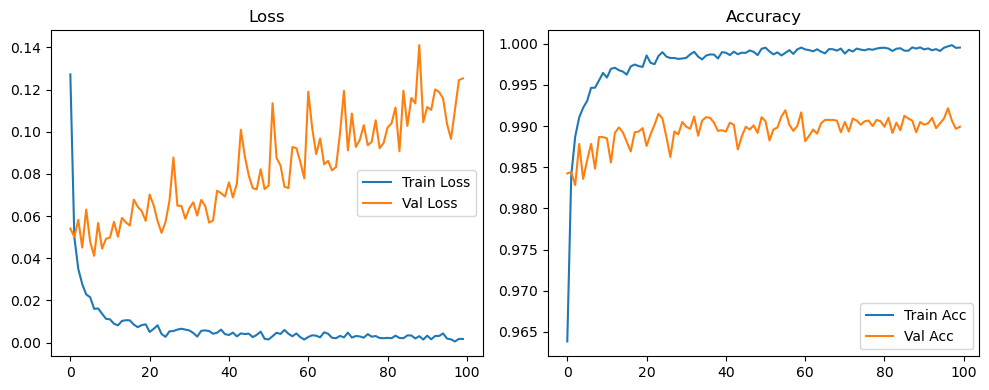

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1541, Acc: 0.9559 | Val Loss: 0.1263, Acc: 0.9605


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9791 | Val Loss: 0.0680, Acc: 0.9802


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9834 | Val Loss: 0.0752, Acc: 0.9770


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9849 | Val Loss: 0.0543, Acc: 0.9852


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9877 | Val Loss: 0.0628, Acc: 0.9822


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.0591, Acc: 0.9818


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9897 | Val Loss: 0.0556, Acc: 0.9842


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.0516, Acc: 0.9848


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.0373, Acc: 0.9896


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9917 | Val Loss: 0.0665, Acc: 0.9798


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0536, Acc: 0.9838


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0680, Acc: 0.9811


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.0515, Acc: 0.9848


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0406, Acc: 0.9892


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9931 | Val Loss: 0.0549, Acc: 0.9862


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.0452, Acc: 0.9882


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9931 | Val Loss: 0.0561, Acc: 0.9862


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.0501, Acc: 0.9881


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9939 | Val Loss: 0.0527, Acc: 0.9872


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0573, Acc: 0.9856


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0552, Acc: 0.9861


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0554, Acc: 0.9859


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.0520, Acc: 0.9882


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0572, Acc: 0.9864


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.0509, Acc: 0.9880


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9953 | Val Loss: 0.0560, Acc: 0.9859


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.0486, Acc: 0.9883


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0536, Acc: 0.9878


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0477, Acc: 0.9883


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0722, Acc: 0.9837


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0604, Acc: 0.9862


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0618, Acc: 0.9859


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0496, Acc: 0.9869


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0605, Acc: 0.9868


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.0598, Acc: 0.9873


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.0553, Acc: 0.9883


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0634, Acc: 0.9862


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.0554, Acc: 0.9880


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.0607, Acc: 0.9878


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.0620, Acc: 0.9857


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0519, Acc: 0.9886


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0629, Acc: 0.9878


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9964 | Val Loss: 0.0565, Acc: 0.9882


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0591, Acc: 0.9888


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.0554, Acc: 0.9893


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0788, Acc: 0.9852


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.0569, Acc: 0.9888


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0605, Acc: 0.9883


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0622, Acc: 0.9872


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0552, Acc: 0.9895


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.0544, Acc: 0.9895


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.0653, Acc: 0.9881


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0534, Acc: 0.9894


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0531, Acc: 0.9896


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.0415, Acc: 0.9912


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0489, Acc: 0.9902


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0570, Acc: 0.9902


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9975 | Val Loss: 0.0537, Acc: 0.9898


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.0463, Acc: 0.9910


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.0619, Acc: 0.9886


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0604, Acc: 0.9883


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0542, Acc: 0.9901


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0460, Acc: 0.9912


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9979 | Val Loss: 0.0568, Acc: 0.9888


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.0514, Acc: 0.9888


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.0544, Acc: 0.9888


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9972 | Val Loss: 0.0595, Acc: 0.9884


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0632, Acc: 0.9890


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.0638, Acc: 0.9882


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9976 | Val Loss: 0.0619, Acc: 0.9864


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.0584, Acc: 0.9901


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0540, Acc: 0.9897


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9975 | Val Loss: 0.0700, Acc: 0.9887


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.0595, Acc: 0.9899


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.0767, Acc: 0.9877


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0607, Acc: 0.9894


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9980 | Val Loss: 0.0630, Acc: 0.9900


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.0579, Acc: 0.9883


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.0582, Acc: 0.9910


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0592, Acc: 0.9893


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.0567, Acc: 0.9901


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.0504, Acc: 0.9915


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0642, Acc: 0.9879


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.0679, Acc: 0.9883


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9980 | Val Loss: 0.0527, Acc: 0.9898


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.0594, Acc: 0.9886


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.0549, Acc: 0.9903


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.0559, Acc: 0.9908


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.0544, Acc: 0.9912


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0606, Acc: 0.9891


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.0587, Acc: 0.9888


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.0570, Acc: 0.9901


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0585, Acc: 0.9909


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0635, Acc: 0.9889


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0730, Acc: 0.9876


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9979 | Val Loss: 0.0662, Acc: 0.9897


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.0683, Acc: 0.9894


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9982 | Val Loss: 0.0578, Acc: 0.9909


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.0664, Acc: 0.9892


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.0671, Acc: 0.9888


Final Test Loss: 0.0659 Accuracy: 0.9875


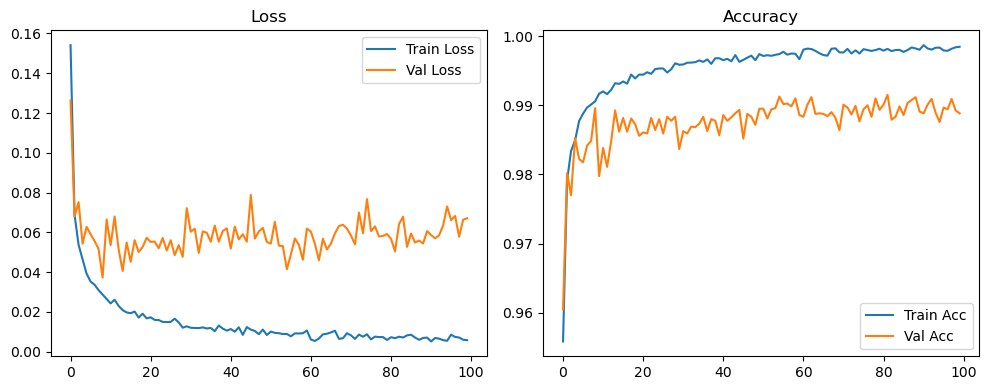

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2508, Acc: 0.9294 | Val Loss: 0.6412, Acc: 0.7842


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1346, Acc: 0.9606 | Val Loss: 0.4646, Acc: 0.8505


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1132, Acc: 0.9669 | Val Loss: 0.3575, Acc: 0.8775


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9688 | Val Loss: 0.4212, Acc: 0.8517


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0935, Acc: 0.9718 | Val Loss: 0.3234, Acc: 0.8924


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0910, Acc: 0.9728 | Val Loss: 0.2619, Acc: 0.9130


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0893, Acc: 0.9738 | Val Loss: 0.3084, Acc: 0.8960


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9751 | Val Loss: 0.4468, Acc: 0.8422


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0759, Acc: 0.9775 | Val Loss: 0.1783, Acc: 0.9433


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9769 | Val Loss: 0.2593, Acc: 0.9124


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9774 | Val Loss: 0.1596, Acc: 0.9501


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9782 | Val Loss: 0.1828, Acc: 0.9417


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0705, Acc: 0.9792 | Val Loss: 0.3024, Acc: 0.8999


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0699, Acc: 0.9796 | Val Loss: 0.1313, Acc: 0.9584


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0658, Acc: 0.9795 | Val Loss: 0.2431, Acc: 0.9204


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9810 | Val Loss: 0.2845, Acc: 0.9065


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9807 | Val Loss: 0.1619, Acc: 0.9458


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9824 | Val Loss: 0.1484, Acc: 0.9526


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9812 | Val Loss: 0.1157, Acc: 0.9631


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9825 | Val Loss: 0.2436, Acc: 0.9157


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0610, Acc: 0.9820 | Val Loss: 0.1444, Acc: 0.9531


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9838 | Val Loss: 0.1347, Acc: 0.9555


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9824 | Val Loss: 0.0951, Acc: 0.9698


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9830 | Val Loss: 0.1305, Acc: 0.9571


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9831 | Val Loss: 0.1356, Acc: 0.9540


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9828 | Val Loss: 0.1346, Acc: 0.9579


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9834 | Val Loss: 0.1087, Acc: 0.9654


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9835 | Val Loss: 0.1013, Acc: 0.9681


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9838 | Val Loss: 0.1531, Acc: 0.9499


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9832 | Val Loss: 0.1154, Acc: 0.9626


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9840 | Val Loss: 0.1560, Acc: 0.9494


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9846 | Val Loss: 0.1057, Acc: 0.9657


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9844 | Val Loss: 0.1003, Acc: 0.9677


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9849 | Val Loss: 0.1359, Acc: 0.9528


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9859 | Val Loss: 0.1160, Acc: 0.9612


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9853 | Val Loss: 0.1073, Acc: 0.9661


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9852 | Val Loss: 0.1060, Acc: 0.9645


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9856 | Val Loss: 0.1020, Acc: 0.9659


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9865 | Val Loss: 0.1144, Acc: 0.9613


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9849 | Val Loss: 0.1171, Acc: 0.9610


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9849 | Val Loss: 0.1257, Acc: 0.9595


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9853 | Val Loss: 0.0961, Acc: 0.9687


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9848 | Val Loss: 0.1333, Acc: 0.9518


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9864 | Val Loss: 0.1152, Acc: 0.9640


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9868 | Val Loss: 0.1139, Acc: 0.9622


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9864 | Val Loss: 0.0986, Acc: 0.9670


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9870 | Val Loss: 0.1467, Acc: 0.9498


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9865 | Val Loss: 0.0828, Acc: 0.9745


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9868 | Val Loss: 0.1145, Acc: 0.9618


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9870 | Val Loss: 0.1102, Acc: 0.9640


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9867 | Val Loss: 0.1426, Acc: 0.9477


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9875 | Val Loss: 0.1297, Acc: 0.9564


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9875 | Val Loss: 0.0906, Acc: 0.9720


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9868 | Val Loss: 0.0853, Acc: 0.9718


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9866 | Val Loss: 0.1113, Acc: 0.9599


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9871 | Val Loss: 0.1074, Acc: 0.9628


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9874 | Val Loss: 0.1415, Acc: 0.9507


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9868 | Val Loss: 0.1127, Acc: 0.9637


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9872 | Val Loss: 0.1229, Acc: 0.9577


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9875 | Val Loss: 0.1385, Acc: 0.9535


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9868 | Val Loss: 0.1613, Acc: 0.9443


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9882 | Val Loss: 0.1116, Acc: 0.9604


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9880 | Val Loss: 0.0879, Acc: 0.9721


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9878 | Val Loss: 0.1034, Acc: 0.9644


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9882 | Val Loss: 0.1367, Acc: 0.9525


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9879 | Val Loss: 0.1156, Acc: 0.9638


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9874 | Val Loss: 0.1041, Acc: 0.9675


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9883 | Val Loss: 0.1385, Acc: 0.9522


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9884 | Val Loss: 0.1157, Acc: 0.9612


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9880 | Val Loss: 0.0972, Acc: 0.9677


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9885 | Val Loss: 0.0744, Acc: 0.9764


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9889 | Val Loss: 0.1000, Acc: 0.9682


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9894 | Val Loss: 0.1206, Acc: 0.9587


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9875 | Val Loss: 0.1112, Acc: 0.9607


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9885 | Val Loss: 0.0763, Acc: 0.9774


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9890 | Val Loss: 0.0971, Acc: 0.9696


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.1188, Acc: 0.9555


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9896 | Val Loss: 0.0917, Acc: 0.9707


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9880 | Val Loss: 0.1460, Acc: 0.9478


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9888 | Val Loss: 0.0890, Acc: 0.9748


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9889 | Val Loss: 0.1124, Acc: 0.9600


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9891 | Val Loss: 0.1002, Acc: 0.9647


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9893 | Val Loss: 0.1011, Acc: 0.9677


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9884 | Val Loss: 0.1053, Acc: 0.9679


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9886 | Val Loss: 0.1494, Acc: 0.9428


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9886 | Val Loss: 0.1142, Acc: 0.9581


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9892 | Val Loss: 0.1172, Acc: 0.9592


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9894 | Val Loss: 0.1443, Acc: 0.9462


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9894 | Val Loss: 0.1031, Acc: 0.9636


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9891 | Val Loss: 0.1231, Acc: 0.9577


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9887 | Val Loss: 0.1330, Acc: 0.9513


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9887 | Val Loss: 0.0943, Acc: 0.9695


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9898 | Val Loss: 0.0978, Acc: 0.9673


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9893 | Val Loss: 0.0938, Acc: 0.9670


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9893 | Val Loss: 0.1184, Acc: 0.9570


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.1116, Acc: 0.9600


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9893 | Val Loss: 0.1203, Acc: 0.9590


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.1232, Acc: 0.9585


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9895 | Val Loss: 0.1065, Acc: 0.9605


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9907 | Val Loss: 0.1026, Acc: 0.9633


Final Test Loss: 0.1015 Accuracy: 0.9625


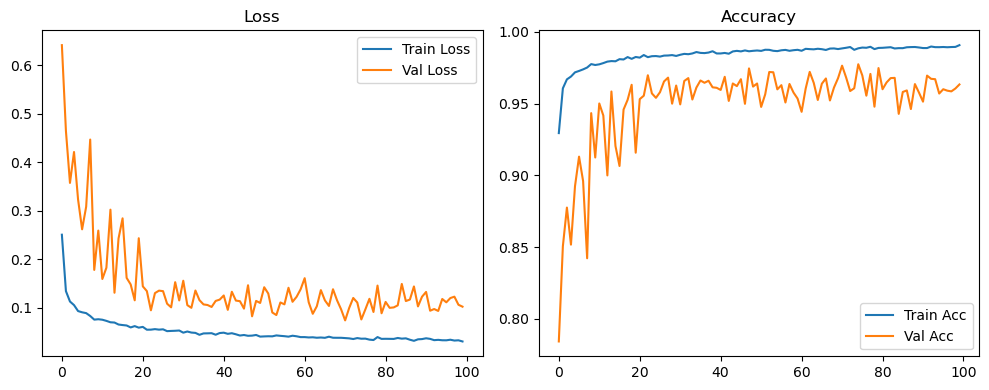

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1262, Acc: 0.9639 | Val Loss: 0.0677, Acc: 0.9781


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9843 | Val Loss: 0.0451, Acc: 0.9863


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9883 | Val Loss: 0.0489, Acc: 0.9853


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.0441, Acc: 0.9878


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0401, Acc: 0.9878


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.0518, Acc: 0.9867


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0554, Acc: 0.9858


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0470, Acc: 0.9887


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0571, Acc: 0.9850


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0570, Acc: 0.9873


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9955 | Val Loss: 0.0563, Acc: 0.9868


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0592, Acc: 0.9872


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0658, Acc: 0.9873


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0726, Acc: 0.9852


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0603, Acc: 0.9876


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0575, Acc: 0.9869


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0493, Acc: 0.9903


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0607, Acc: 0.9881


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0481, Acc: 0.9894


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0496, Acc: 0.9899


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0596, Acc: 0.9891


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0600, Acc: 0.9900


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0770, Acc: 0.9868


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0623, Acc: 0.9896


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0594, Acc: 0.9894


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0678, Acc: 0.9895


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0748, Acc: 0.9886


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0814, Acc: 0.9884


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0621, Acc: 0.9896


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0688, Acc: 0.9892


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0804, Acc: 0.9894


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0787, Acc: 0.9892


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0878, Acc: 0.9872


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0699, Acc: 0.9892


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0717, Acc: 0.9908


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.0724, Acc: 0.9895


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.0842, Acc: 0.9896


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0669, Acc: 0.9908


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0752, Acc: 0.9902


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0928, Acc: 0.9882


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0719, Acc: 0.9894


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0914, Acc: 0.9895


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0749, Acc: 0.9902


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0816, Acc: 0.9897


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0753, Acc: 0.9907


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0817, Acc: 0.9893


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.0935, Acc: 0.9896


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0865, Acc: 0.9888


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0943, Acc: 0.9884


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0844, Acc: 0.9898


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0693, Acc: 0.9908


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0631, Acc: 0.9916


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0672, Acc: 0.9915


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0730, Acc: 0.9914


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0704, Acc: 0.9922


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0669, Acc: 0.9918


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0781, Acc: 0.9907


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0754, Acc: 0.9910


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0793, Acc: 0.9908


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0788, Acc: 0.9912


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0892, Acc: 0.9900


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9995 | Val Loss: 0.0786, Acc: 0.9902


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0725, Acc: 0.9920


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0747, Acc: 0.9917


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0732, Acc: 0.9910


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0791, Acc: 0.9906


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0795, Acc: 0.9907


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0822, Acc: 0.9913


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0928, Acc: 0.9899


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0732, Acc: 0.9911


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0707, Acc: 0.9930


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0804, Acc: 0.9916


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0788, Acc: 0.9916


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0878, Acc: 0.9903


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0932, Acc: 0.9906


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0748, Acc: 0.9909


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0772, Acc: 0.9912


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0727, Acc: 0.9926


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0711, Acc: 0.9921


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0767, Acc: 0.9920


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0714, Acc: 0.9924


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0767, Acc: 0.9921


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0709, Acc: 0.9920


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0735, Acc: 0.9920


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0673, Acc: 0.9922


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0702, Acc: 0.9922


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0679, Acc: 0.9920


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0716, Acc: 0.9922


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0818, Acc: 0.9913


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0765, Acc: 0.9918


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0795, Acc: 0.9916


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0728, Acc: 0.9920


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0736, Acc: 0.9917


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0724, Acc: 0.9922


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0747, Acc: 0.9918


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0791, Acc: 0.9919


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0775, Acc: 0.9913


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0848, Acc: 0.9909


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0791, Acc: 0.9923


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0818, Acc: 0.9911


Final Test Loss: 0.0903 Accuracy: 0.9905


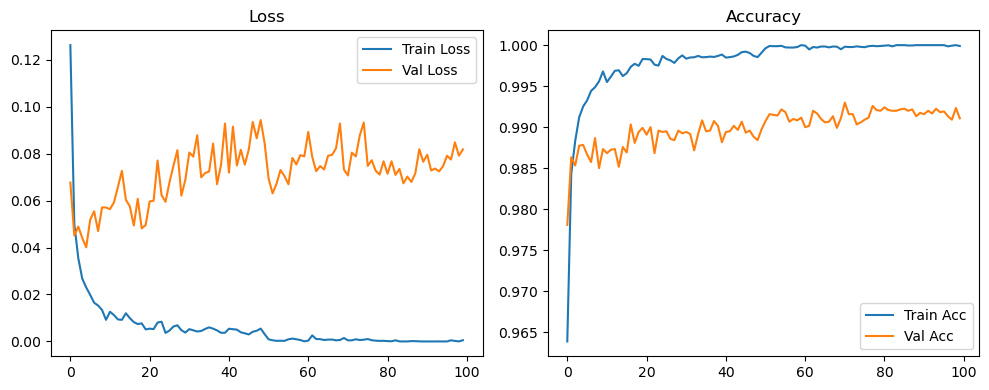

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1534, Acc: 0.9560 | Val Loss: 0.1302, Acc: 0.9603


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0684, Acc: 0.9787 | Val Loss: 0.0841, Acc: 0.9743


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9839 | Val Loss: 0.0637, Acc: 0.9819


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9858 | Val Loss: 0.0561, Acc: 0.9826


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9877 | Val Loss: 0.0634, Acc: 0.9813


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9886 | Val Loss: 0.0702, Acc: 0.9783


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9888 | Val Loss: 0.0699, Acc: 0.9802


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9893 | Val Loss: 0.0619, Acc: 0.9805


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9911 | Val Loss: 0.0436, Acc: 0.9874


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0498, Acc: 0.9852


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.0579, Acc: 0.9848


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.0440, Acc: 0.9872


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.0492, Acc: 0.9864


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0494, Acc: 0.9875


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.0515, Acc: 0.9862


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.0528, Acc: 0.9859


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.0628, Acc: 0.9836


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.0503, Acc: 0.9869


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9935 | Val Loss: 0.0617, Acc: 0.9838


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0592, Acc: 0.9833


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0485, Acc: 0.9855


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0432, Acc: 0.9887


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0527, Acc: 0.9870


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9952 | Val Loss: 0.0508, Acc: 0.9875


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.0628, Acc: 0.9848


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9952 | Val Loss: 0.0650, Acc: 0.9839


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.0592, Acc: 0.9862


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0550, Acc: 0.9883


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.0472, Acc: 0.9908


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9952 | Val Loss: 0.0587, Acc: 0.9858


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0601, Acc: 0.9856


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.0674, Acc: 0.9839


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.0553, Acc: 0.9878


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.0581, Acc: 0.9869


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0543, Acc: 0.9885


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.0552, Acc: 0.9882


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0531, Acc: 0.9890


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.0637, Acc: 0.9866


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0701, Acc: 0.9861


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.0551, Acc: 0.9880


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.0528, Acc: 0.9890


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.0490, Acc: 0.9902


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0719, Acc: 0.9851


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.0628, Acc: 0.9885


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.0605, Acc: 0.9874


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0536, Acc: 0.9884


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0613, Acc: 0.9876


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.0642, Acc: 0.9878


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.0586, Acc: 0.9891


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9967 | Val Loss: 0.0634, Acc: 0.9890


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0538, Acc: 0.9898


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0576, Acc: 0.9892


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0492, Acc: 0.9908


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0560, Acc: 0.9903


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0523, Acc: 0.9907


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0560, Acc: 0.9902


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0540, Acc: 0.9909


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0494, Acc: 0.9914


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0604, Acc: 0.9895


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0678, Acc: 0.9874


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0527, Acc: 0.9904


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0531, Acc: 0.9897


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0484, Acc: 0.9913


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0627, Acc: 0.9887


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0540, Acc: 0.9910


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0536, Acc: 0.9907


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0614, Acc: 0.9896


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0620, Acc: 0.9887


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0592, Acc: 0.9901


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0607, Acc: 0.9895


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0579, Acc: 0.9889


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0605, Acc: 0.9887


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0621, Acc: 0.9892


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0597, Acc: 0.9895


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0596, Acc: 0.9888


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0514, Acc: 0.9899


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0574, Acc: 0.9898


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0591, Acc: 0.9896


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0575, Acc: 0.9899


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0592, Acc: 0.9891


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0538, Acc: 0.9910


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0540, Acc: 0.9905


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0523, Acc: 0.9904


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0546, Acc: 0.9904


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0527, Acc: 0.9908


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0550, Acc: 0.9906


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0517, Acc: 0.9902


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0532, Acc: 0.9903


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0514, Acc: 0.9905


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0503, Acc: 0.9908


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0516, Acc: 0.9908


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0507, Acc: 0.9918


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0530, Acc: 0.9903


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0555, Acc: 0.9905


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.0537, Acc: 0.9908


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0535, Acc: 0.9901


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0561, Acc: 0.9908


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0615, Acc: 0.9897


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0552, Acc: 0.9909


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0498, Acc: 0.9922


Final Test Loss: 0.0507 Accuracy: 0.9897


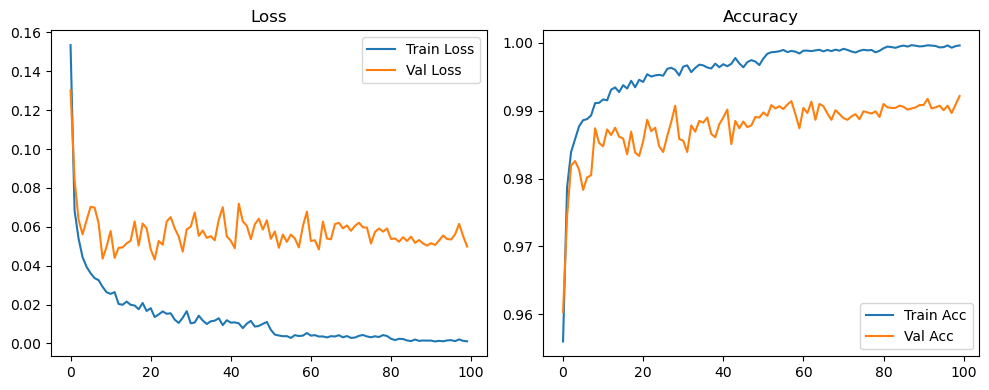

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2474, Acc: 0.9304 | Val Loss: 1.0896, Acc: 0.6471


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1355, Acc: 0.9604 | Val Loss: 0.6248, Acc: 0.7923


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1122, Acc: 0.9663 | Val Loss: 0.4577, Acc: 0.8431


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1065, Acc: 0.9694 | Val Loss: 0.2857, Acc: 0.9079


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0927, Acc: 0.9720 | Val Loss: 0.3290, Acc: 0.8938


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9725 | Val Loss: 0.3000, Acc: 0.8993


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9739 | Val Loss: 0.4071, Acc: 0.8592


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9757 | Val Loss: 0.3635, Acc: 0.8749


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9767 | Val Loss: 0.2300, Acc: 0.9206


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9765 | Val Loss: 0.2076, Acc: 0.9318


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9776 | Val Loss: 0.1649, Acc: 0.9447


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9787 | Val Loss: 0.1722, Acc: 0.9433


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0696, Acc: 0.9791 | Val Loss: 0.2075, Acc: 0.9302


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0686, Acc: 0.9795 | Val Loss: 0.1753, Acc: 0.9446


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0659, Acc: 0.9801 | Val Loss: 0.4258, Acc: 0.8535


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9803 | Val Loss: 0.1443, Acc: 0.9503


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9803 | Val Loss: 0.1748, Acc: 0.9417


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9808 | Val Loss: 0.1482, Acc: 0.9492


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9809 | Val Loss: 0.1522, Acc: 0.9479


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9828 | Val Loss: 0.1603, Acc: 0.9450


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9814 | Val Loss: 0.1632, Acc: 0.9458


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9829 | Val Loss: 0.1157, Acc: 0.9631


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9822 | Val Loss: 0.0957, Acc: 0.9703


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9838 | Val Loss: 0.1388, Acc: 0.9534


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9835 | Val Loss: 0.1358, Acc: 0.9513


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9836 | Val Loss: 0.1393, Acc: 0.9524


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9841 | Val Loss: 0.1076, Acc: 0.9666


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9846 | Val Loss: 0.1001, Acc: 0.9685


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9845 | Val Loss: 0.1221, Acc: 0.9613


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9839 | Val Loss: 0.1190, Acc: 0.9605


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9841 | Val Loss: 0.1042, Acc: 0.9657


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9854 | Val Loss: 0.1482, Acc: 0.9530


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9850 | Val Loss: 0.1092, Acc: 0.9640


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9858 | Val Loss: 0.1266, Acc: 0.9567


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9862 | Val Loss: 0.1181, Acc: 0.9585


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9852 | Val Loss: 0.0888, Acc: 0.9713


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9855 | Val Loss: 0.1186, Acc: 0.9587


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9848 | Val Loss: 0.0995, Acc: 0.9682


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9862 | Val Loss: 0.1167, Acc: 0.9603


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9856 | Val Loss: 0.0829, Acc: 0.9747


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9856 | Val Loss: 0.1203, Acc: 0.9608


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9862 | Val Loss: 0.0984, Acc: 0.9700


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9853 | Val Loss: 0.1053, Acc: 0.9646


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9870 | Val Loss: 0.1079, Acc: 0.9648


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9869 | Val Loss: 0.0728, Acc: 0.9789


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9866 | Val Loss: 0.1068, Acc: 0.9649


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9870 | Val Loss: 0.1320, Acc: 0.9532


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9869 | Val Loss: 0.0932, Acc: 0.9715


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9859 | Val Loss: 0.1020, Acc: 0.9680


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9873 | Val Loss: 0.1287, Acc: 0.9609


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 0.1073, Acc: 0.9656


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9899 | Val Loss: 0.1024, Acc: 0.9676


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9898 | Val Loss: 0.0926, Acc: 0.9718


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9893 | Val Loss: 0.0939, Acc: 0.9714


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9900 | Val Loss: 0.0898, Acc: 0.9732


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9899 | Val Loss: 0.0919, Acc: 0.9697


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.1087, Acc: 0.9633


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.1068, Acc: 0.9640


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9905 | Val Loss: 0.1073, Acc: 0.9652


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9911 | Val Loss: 0.0950, Acc: 0.9676


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9896 | Val Loss: 0.1260, Acc: 0.9567


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0906, Acc: 0.9695


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9910 | Val Loss: 0.0948, Acc: 0.9706


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9901 | Val Loss: 0.0912, Acc: 0.9715


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.0950, Acc: 0.9695


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9903 | Val Loss: 0.0936, Acc: 0.9700


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0885, Acc: 0.9717


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9904 | Val Loss: 0.1102, Acc: 0.9653


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0911, Acc: 0.9720


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9899 | Val Loss: 0.1026, Acc: 0.9671


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0785, Acc: 0.9767


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.1123, Acc: 0.9627


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9914 | Val Loss: 0.1134, Acc: 0.9610


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9899 | Val Loss: 0.1182, Acc: 0.9567


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.0912, Acc: 0.9718


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.1129, Acc: 0.9606


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0953, Acc: 0.9698


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.1092, Acc: 0.9611


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9911 | Val Loss: 0.0895, Acc: 0.9707


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.1037, Acc: 0.9676


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.0891, Acc: 0.9712


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.0962, Acc: 0.9671


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.0905, Acc: 0.9694


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9932 | Val Loss: 0.0861, Acc: 0.9745


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9929 | Val Loss: 0.0907, Acc: 0.9718


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0935, Acc: 0.9702


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.0835, Acc: 0.9732


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9933 | Val Loss: 0.0799, Acc: 0.9735


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.0776, Acc: 0.9758


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.0762, Acc: 0.9778


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0840, Acc: 0.9742


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.0873, Acc: 0.9718


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.0984, Acc: 0.9669


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.0821, Acc: 0.9755


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0819, Acc: 0.9757


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9925 | Val Loss: 0.0901, Acc: 0.9691


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0862, Acc: 0.9698


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0888, Acc: 0.9719


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9942 | Val Loss: 0.0860, Acc: 0.9736


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0781, Acc: 0.9761


Final Test Loss: 0.0732 Accuracy: 0.9755


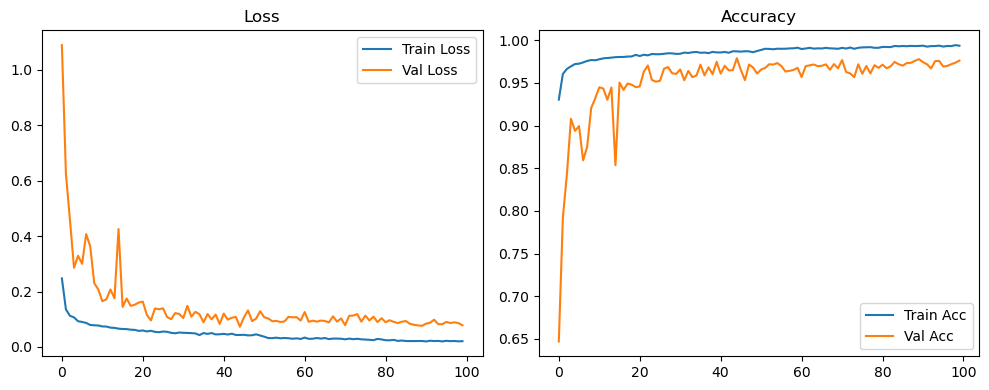

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1272, Acc: 0.9636 | Val Loss: 0.0717, Acc: 0.9776


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9839 | Val Loss: 0.0525, Acc: 0.9828


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9887 | Val Loss: 0.0520, Acc: 0.9852


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.0468, Acc: 0.9861


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.0497, Acc: 0.9863


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0419, Acc: 0.9879


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0422, Acc: 0.9882


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0516, Acc: 0.9867


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0479, Acc: 0.9876


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9955 | Val Loss: 0.0720, Acc: 0.9830


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0520, Acc: 0.9872


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0532, Acc: 0.9885


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0548, Acc: 0.9886


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0701, Acc: 0.9860


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0587, Acc: 0.9877


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0523, Acc: 0.9896


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0689, Acc: 0.9877


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0554, Acc: 0.9899


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0607, Acc: 0.9882


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0476, Acc: 0.9905


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0619, Acc: 0.9882


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0699, Acc: 0.9892


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0652, Acc: 0.9888


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0705, Acc: 0.9886


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0880, Acc: 0.9850


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9977 | Val Loss: 0.0622, Acc: 0.9895


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0675, Acc: 0.9881


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0548, Acc: 0.9898


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0539, Acc: 0.9902


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0623, Acc: 0.9901


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0639, Acc: 0.9896


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0737, Acc: 0.9883


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0751, Acc: 0.9879


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0646, Acc: 0.9900


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0808, Acc: 0.9897


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0653, Acc: 0.9904


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9985 | Val Loss: 0.0565, Acc: 0.9913


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.0736, Acc: 0.9903


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0704, Acc: 0.9902


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.0676, Acc: 0.9901


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0856, Acc: 0.9888


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0750, Acc: 0.9893


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0766, Acc: 0.9892


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0706, Acc: 0.9907


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0884, Acc: 0.9888


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0936, Acc: 0.9878


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.0776, Acc: 0.9907


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.0816, Acc: 0.9899


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.0701, Acc: 0.9912


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.0888, Acc: 0.9901


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0807, Acc: 0.9909


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0804, Acc: 0.9916


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0749, Acc: 0.9921


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0722, Acc: 0.9922


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0776, Acc: 0.9921


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0705, Acc: 0.9922


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0788, Acc: 0.9913


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0704, Acc: 0.9912


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0835, Acc: 0.9909


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0692, Acc: 0.9922


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0699, Acc: 0.9921


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0705, Acc: 0.9935


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0650, Acc: 0.9928


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0722, Acc: 0.9920


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0857, Acc: 0.9914


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0877, Acc: 0.9906


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.0869, Acc: 0.9915


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0793, Acc: 0.9914


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0881, Acc: 0.9904


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0812, Acc: 0.9919


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0921, Acc: 0.9906


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0866, Acc: 0.9918


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0839, Acc: 0.9910


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0866, Acc: 0.9918


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0816, Acc: 0.9920


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0797, Acc: 0.9922


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0914, Acc: 0.9912


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0952, Acc: 0.9899


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0904, Acc: 0.9911


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0912, Acc: 0.9912


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0802, Acc: 0.9918


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0753, Acc: 0.9921


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0817, Acc: 0.9920


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0819, Acc: 0.9922


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0758, Acc: 0.9925


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0774, Acc: 0.9928


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0752, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0779, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0766, Acc: 0.9921


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0774, Acc: 0.9930


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0749, Acc: 0.9932


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0786, Acc: 0.9929


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0774, Acc: 0.9927


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0800, Acc: 0.9929


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0761, Acc: 0.9928


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0760, Acc: 0.9927


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0803, Acc: 0.9929


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0781, Acc: 0.9932


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0803, Acc: 0.9928


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0816, Acc: 0.9922


Final Test Loss: 0.0787 Accuracy: 0.9916


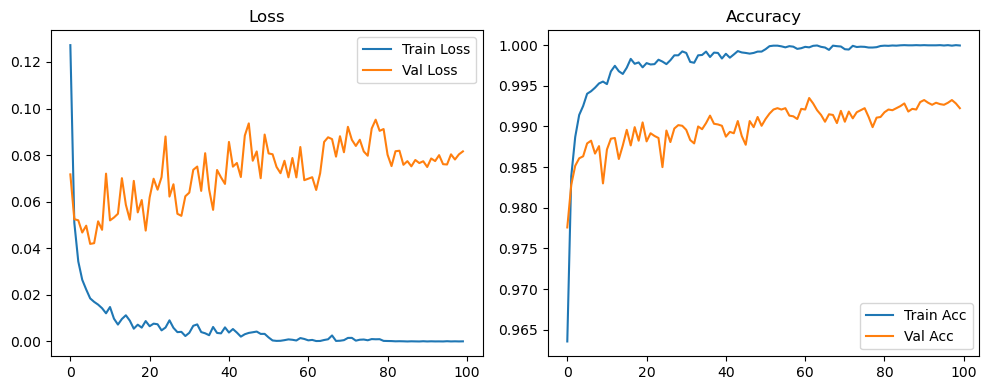

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1532, Acc: 0.9559 | Val Loss: 0.1396, Acc: 0.9563


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9790 | Val Loss: 0.0775, Acc: 0.9762


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9836 | Val Loss: 0.0714, Acc: 0.9797


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9855 | Val Loss: 0.0658, Acc: 0.9801


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9877 | Val Loss: 0.0748, Acc: 0.9788


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9884 | Val Loss: 0.0438, Acc: 0.9869


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 0.0755, Acc: 0.9776


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9901 | Val Loss: 0.0630, Acc: 0.9820


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9902 | Val Loss: 0.0469, Acc: 0.9862


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.0707, Acc: 0.9793


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.0521, Acc: 0.9856


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.0413, Acc: 0.9883


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9922 | Val Loss: 0.0625, Acc: 0.9819


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9933 | Val Loss: 0.0503, Acc: 0.9872


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9930 | Val Loss: 0.0612, Acc: 0.9824


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9933 | Val Loss: 0.0505, Acc: 0.9855


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.0756, Acc: 0.9797


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0509, Acc: 0.9862


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0535, Acc: 0.9860


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0566, Acc: 0.9859


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0545, Acc: 0.9859


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.0475, Acc: 0.9878


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9952 | Val Loss: 0.0515, Acc: 0.9887


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.0562, Acc: 0.9860


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.0433, Acc: 0.9900


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0633, Acc: 0.9855


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9955 | Val Loss: 0.0555, Acc: 0.9863


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0480, Acc: 0.9882


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.0599, Acc: 0.9858


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0606, Acc: 0.9854


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0567, Acc: 0.9880


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.0567, Acc: 0.9874


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0511, Acc: 0.9897


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0661, Acc: 0.9873


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.0521, Acc: 0.9892


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0525, Acc: 0.9891


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.0466, Acc: 0.9902


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0527, Acc: 0.9891


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0483, Acc: 0.9894


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9969 | Val Loss: 0.0502, Acc: 0.9885


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0534, Acc: 0.9890


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.0602, Acc: 0.9871


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.0542, Acc: 0.9878


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9974 | Val Loss: 0.0655, Acc: 0.9868


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.0529, Acc: 0.9888


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0632, Acc: 0.9879


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0573, Acc: 0.9892


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0688, Acc: 0.9877


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.0525, Acc: 0.9907


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0673, Acc: 0.9889


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0608, Acc: 0.9891


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0566, Acc: 0.9900


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0550, Acc: 0.9897


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0535, Acc: 0.9904


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0589, Acc: 0.9893


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0522, Acc: 0.9899


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0625, Acc: 0.9891


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0497, Acc: 0.9902


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0492, Acc: 0.9906


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0598, Acc: 0.9894


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0510, Acc: 0.9897


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0558, Acc: 0.9902


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0599, Acc: 0.9896


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0542, Acc: 0.9907


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0629, Acc: 0.9884


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0523, Acc: 0.9916


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0555, Acc: 0.9913


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0530, Acc: 0.9904


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0587, Acc: 0.9890


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0621, Acc: 0.9880


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0647, Acc: 0.9882


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0597, Acc: 0.9892


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0661, Acc: 0.9894


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0633, Acc: 0.9904


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0719, Acc: 0.9894


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0618, Acc: 0.9887


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0661, Acc: 0.9887


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0538, Acc: 0.9902


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0639, Acc: 0.9903


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0679, Acc: 0.9875


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0613, Acc: 0.9899


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0598, Acc: 0.9898


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0558, Acc: 0.9902


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0572, Acc: 0.9908


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0560, Acc: 0.9905


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0559, Acc: 0.9908


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0540, Acc: 0.9914


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0560, Acc: 0.9914


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0572, Acc: 0.9911


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0576, Acc: 0.9907


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0610, Acc: 0.9908


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0594, Acc: 0.9915


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0600, Acc: 0.9902


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0565, Acc: 0.9917


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0570, Acc: 0.9911


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0577, Acc: 0.9912


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0602, Acc: 0.9912


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0588, Acc: 0.9915


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0576, Acc: 0.9914


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0570, Acc: 0.9908


Final Test Loss: 0.0521 Accuracy: 0.9908


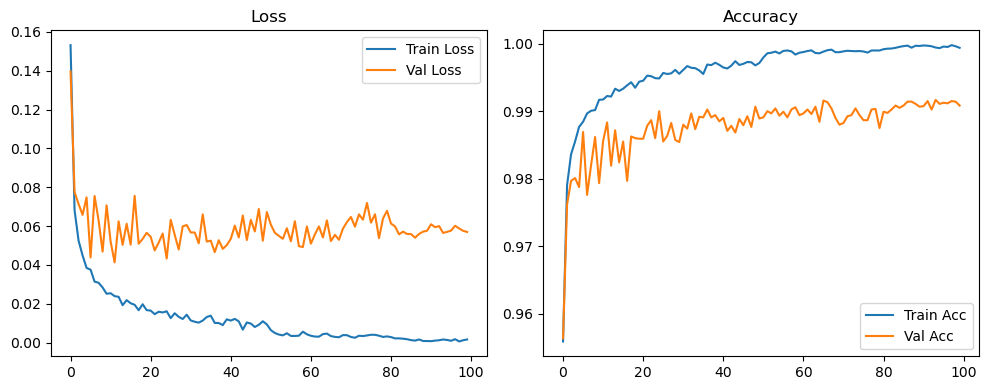

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2478, Acc: 0.9294 | Val Loss: 0.8024, Acc: 0.7276


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1342, Acc: 0.9599 | Val Loss: 0.4254, Acc: 0.8620


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1136, Acc: 0.9658 | Val Loss: 0.4993, Acc: 0.8166


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9705 | Val Loss: 0.4552, Acc: 0.8518


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0917, Acc: 0.9734 | Val Loss: 0.3120, Acc: 0.9022


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0899, Acc: 0.9732 | Val Loss: 0.3329, Acc: 0.8825


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0867, Acc: 0.9738 | Val Loss: 0.2988, Acc: 0.8932


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9746 | Val Loss: 0.4971, Acc: 0.8229


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9766 | Val Loss: 0.1948, Acc: 0.9366


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9779 | Val Loss: 0.2005, Acc: 0.9330


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9786 | Val Loss: 0.1829, Acc: 0.9383


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9777 | Val Loss: 0.1521, Acc: 0.9483


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9783 | Val Loss: 0.2059, Acc: 0.9279


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9798 | Val Loss: 0.1544, Acc: 0.9486


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9800 | Val Loss: 0.3102, Acc: 0.8918


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9806 | Val Loss: 0.2056, Acc: 0.9317


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9802 | Val Loss: 0.1316, Acc: 0.9564


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9807 | Val Loss: 0.1268, Acc: 0.9572


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9814 | Val Loss: 0.1096, Acc: 0.9646


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9823 | Val Loss: 0.1724, Acc: 0.9422


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9815 | Val Loss: 0.1324, Acc: 0.9548


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9824 | Val Loss: 0.0921, Acc: 0.9717


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9832 | Val Loss: 0.0825, Acc: 0.9764


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9831 | Val Loss: 0.0892, Acc: 0.9717


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9833 | Val Loss: 0.1341, Acc: 0.9548


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9838 | Val Loss: 0.1284, Acc: 0.9571


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9841 | Val Loss: 0.0964, Acc: 0.9709


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9841 | Val Loss: 0.1596, Acc: 0.9489


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9849 | Val Loss: 0.1289, Acc: 0.9587


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9843 | Val Loss: 0.1410, Acc: 0.9522


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 0.1404, Acc: 0.9560


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9845 | Val Loss: 0.1245, Acc: 0.9574


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9848 | Val Loss: 0.1540, Acc: 0.9467


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9859 | Val Loss: 0.1237, Acc: 0.9590


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9852 | Val Loss: 0.0964, Acc: 0.9703


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9854 | Val Loss: 0.1124, Acc: 0.9657


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9857 | Val Loss: 0.1238, Acc: 0.9600


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9863 | Val Loss: 0.1043, Acc: 0.9683


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9862 | Val Loss: 0.1016, Acc: 0.9671


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9854 | Val Loss: 0.1135, Acc: 0.9640


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9857 | Val Loss: 0.1396, Acc: 0.9553


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9866 | Val Loss: 0.1039, Acc: 0.9682


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9861 | Val Loss: 0.1266, Acc: 0.9568


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9861 | Val Loss: 0.0895, Acc: 0.9718


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9866 | Val Loss: 0.1371, Acc: 0.9539


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9865 | Val Loss: 0.1092, Acc: 0.9630


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9874 | Val Loss: 0.1436, Acc: 0.9502


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9862 | Val Loss: 0.1229, Acc: 0.9614


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9862 | Val Loss: 0.1451, Acc: 0.9509


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9876 | Val Loss: 0.1185, Acc: 0.9603


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9888 | Val Loss: 0.1178, Acc: 0.9593


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9902 | Val Loss: 0.1029, Acc: 0.9648


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.0990, Acc: 0.9657


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9898 | Val Loss: 0.0922, Acc: 0.9716


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9900 | Val Loss: 0.1042, Acc: 0.9673


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9892 | Val Loss: 0.1015, Acc: 0.9676


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.1022, Acc: 0.9664


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9900 | Val Loss: 0.1215, Acc: 0.9589


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9907 | Val Loss: 0.0873, Acc: 0.9721


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.1011, Acc: 0.9673


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9900 | Val Loss: 0.1239, Acc: 0.9572


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.0753, Acc: 0.9768


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 0.0969, Acc: 0.9698


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9913 | Val Loss: 0.1066, Acc: 0.9636


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9904 | Val Loss: 0.0885, Acc: 0.9709


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9903 | Val Loss: 0.1059, Acc: 0.9637


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.0855, Acc: 0.9728


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.1124, Acc: 0.9609


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9901 | Val Loss: 0.1043, Acc: 0.9646


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9910 | Val Loss: 0.0799, Acc: 0.9756


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.0693, Acc: 0.9768


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.0880, Acc: 0.9705


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.0965, Acc: 0.9663


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9911 | Val Loss: 0.1058, Acc: 0.9627


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9916 | Val Loss: 0.0818, Acc: 0.9737


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9910 | Val Loss: 0.0879, Acc: 0.9716


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9916 | Val Loss: 0.1077, Acc: 0.9633


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.1023, Acc: 0.9650


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9916 | Val Loss: 0.0743, Acc: 0.9777


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9912 | Val Loss: 0.0955, Acc: 0.9677


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9922 | Val Loss: 0.0828, Acc: 0.9742


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9926 | Val Loss: 0.0882, Acc: 0.9702


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.0959, Acc: 0.9674


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.0893, Acc: 0.9701


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.0846, Acc: 0.9708


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9929 | Val Loss: 0.0907, Acc: 0.9702


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.0862, Acc: 0.9702


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.0947, Acc: 0.9675


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.0895, Acc: 0.9714


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0815, Acc: 0.9750


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 0.0863, Acc: 0.9728


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.0914, Acc: 0.9688


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9935 | Val Loss: 0.0795, Acc: 0.9750


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9939 | Val Loss: 0.0749, Acc: 0.9772


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.0797, Acc: 0.9732


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.0823, Acc: 0.9726


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9935 | Val Loss: 0.0843, Acc: 0.9712


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.0863, Acc: 0.9727


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9934 | Val Loss: 0.0757, Acc: 0.9766


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.0682, Acc: 0.9792


Final Test Loss: 0.0639 Accuracy: 0.9801


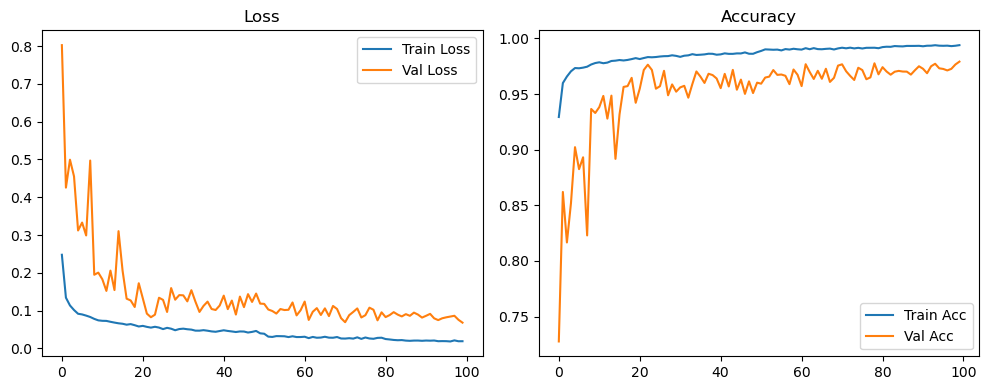

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1261, Acc: 0.9644 | Val Loss: 0.0603, Acc: 0.9818


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9842 | Val Loss: 0.0498, Acc: 0.9852


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9883 | Val Loss: 0.0510, Acc: 0.9848


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0459, Acc: 0.9869


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.0428, Acc: 0.9869


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0565, Acc: 0.9849


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0445, Acc: 0.9877


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.0519, Acc: 0.9882


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0674, Acc: 0.9826


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0579, Acc: 0.9861


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.0442, Acc: 0.9907


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0528, Acc: 0.9886


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0642, Acc: 0.9865


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0651, Acc: 0.9875


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0572, Acc: 0.9882


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0626, Acc: 0.9886


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0826, Acc: 0.9859


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0526, Acc: 0.9892


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0577, Acc: 0.9888


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0601, Acc: 0.9898


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0615, Acc: 0.9884


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0581, Acc: 0.9893


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0714, Acc: 0.9881


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0792, Acc: 0.9874


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.0644, Acc: 0.9891


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0625, Acc: 0.9898


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0841, Acc: 0.9878


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0862, Acc: 0.9864


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0781, Acc: 0.9872


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0773, Acc: 0.9878


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.0612, Acc: 0.9897


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0781, Acc: 0.9880


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0735, Acc: 0.9901


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0691, Acc: 0.9909


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0729, Acc: 0.9893


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0712, Acc: 0.9893


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9988 | Val Loss: 0.0639, Acc: 0.9894


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0700, Acc: 0.9900


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.0754, Acc: 0.9894


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0863, Acc: 0.9877


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0819, Acc: 0.9892


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0773, Acc: 0.9902


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0717, Acc: 0.9902


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0645, Acc: 0.9912


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0845, Acc: 0.9883


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0809, Acc: 0.9894


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0932, Acc: 0.9881


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0913, Acc: 0.9891


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0873, Acc: 0.9888


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0762, Acc: 0.9898


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0725, Acc: 0.9902


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0725, Acc: 0.9908


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0735, Acc: 0.9911


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0721, Acc: 0.9915


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0671, Acc: 0.9919


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9919


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0666, Acc: 0.9911


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0680, Acc: 0.9914


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0703, Acc: 0.9918


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0687, Acc: 0.9918


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0691, Acc: 0.9915


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0717, Acc: 0.9918


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0714, Acc: 0.9913


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0663, Acc: 0.9912


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0698, Acc: 0.9912


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0650, Acc: 0.9916


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0657, Acc: 0.9917


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0623, Acc: 0.9918


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0707, Acc: 0.9911


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0672, Acc: 0.9912


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0634, Acc: 0.9918


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0692, Acc: 0.9918


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0732, Acc: 0.9920


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0705, Acc: 0.9918


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0650, Acc: 0.9917


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0659, Acc: 0.9916


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0669, Acc: 0.9918


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0604, Acc: 0.9919


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0636, Acc: 0.9921


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0644, Acc: 0.9920


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0631, Acc: 0.9925


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0606, Acc: 0.9926


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0637, Acc: 0.9922


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0629, Acc: 0.9923


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0624, Acc: 0.9918


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9913


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9922


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0593, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0629, Acc: 0.9917


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9927


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0652, Acc: 0.9924


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0655, Acc: 0.9916


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0628, Acc: 0.9925


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9922


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0623, Acc: 0.9926


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0665, Acc: 0.9922


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0624, Acc: 0.9921


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0618, Acc: 0.9928


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0636, Acc: 0.9926


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9925


Final Test Loss: 0.0786 Accuracy: 0.9910


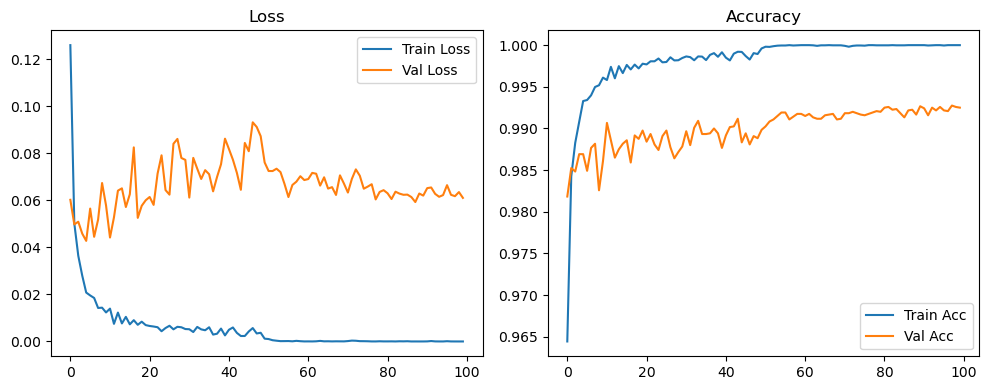

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1534, Acc: 0.9566 | Val Loss: 0.1458, Acc: 0.9539


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9786 | Val Loss: 0.0723, Acc: 0.9778


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9829 | Val Loss: 0.0702, Acc: 0.9791


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9860 | Val Loss: 0.0572, Acc: 0.9830


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9874 | Val Loss: 0.0569, Acc: 0.9828


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9880 | Val Loss: 0.0712, Acc: 0.9785


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9894 | Val Loss: 0.0566, Acc: 0.9834


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9899 | Val Loss: 0.0668, Acc: 0.9798


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9906 | Val Loss: 0.0357, Acc: 0.9894


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.0558, Acc: 0.9844


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9919 | Val Loss: 0.0513, Acc: 0.9859


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9918 | Val Loss: 0.0462, Acc: 0.9874


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0693, Acc: 0.9793


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0395, Acc: 0.9901


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9931 | Val Loss: 0.0660, Acc: 0.9824


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9936 | Val Loss: 0.0469, Acc: 0.9882


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.0500, Acc: 0.9860


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0499, Acc: 0.9868


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.0521, Acc: 0.9868


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.0629, Acc: 0.9848


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0513, Acc: 0.9870


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0569, Acc: 0.9862


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0609, Acc: 0.9854


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9945 | Val Loss: 0.0630, Acc: 0.9848


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0495, Acc: 0.9887


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0709, Acc: 0.9828


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0533, Acc: 0.9880


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.0589, Acc: 0.9868


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0490, Acc: 0.9898


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0540, Acc: 0.9882


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.0544, Acc: 0.9881


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9965 | Val Loss: 0.0585, Acc: 0.9869


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0606, Acc: 0.9878


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0620, Acc: 0.9880


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.0601, Acc: 0.9864


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0531, Acc: 0.9876


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.0501, Acc: 0.9888


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9963 | Val Loss: 0.0583, Acc: 0.9873


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0540, Acc: 0.9878


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.0549, Acc: 0.9878


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0531, Acc: 0.9882


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0493, Acc: 0.9899


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0558, Acc: 0.9898


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0812, Acc: 0.9847


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.0624, Acc: 0.9882


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.0663, Acc: 0.9880


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0670, Acc: 0.9870


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0595, Acc: 0.9895


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9967 | Val Loss: 0.0531, Acc: 0.9888


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9975 | Val Loss: 0.0551, Acc: 0.9895


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0498, Acc: 0.9906


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0504, Acc: 0.9910


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0456, Acc: 0.9912


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0464, Acc: 0.9914


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0518, Acc: 0.9908


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0485, Acc: 0.9911


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0468, Acc: 0.9919


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0473, Acc: 0.9921


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0455, Acc: 0.9912


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0501, Acc: 0.9912


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0452, Acc: 0.9916


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0471, Acc: 0.9922


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0441, Acc: 0.9924


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0476, Acc: 0.9922


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0506, Acc: 0.9910


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0485, Acc: 0.9911


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0494, Acc: 0.9906


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0491, Acc: 0.9901


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0531, Acc: 0.9908


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0482, Acc: 0.9915


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0484, Acc: 0.9913


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0504, Acc: 0.9907


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0565, Acc: 0.9907


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0563, Acc: 0.9902


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0574, Acc: 0.9910


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0507, Acc: 0.9916


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0559, Acc: 0.9907


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0543, Acc: 0.9898


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0576, Acc: 0.9902


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0550, Acc: 0.9902


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0540, Acc: 0.9908


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0529, Acc: 0.9909


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0520, Acc: 0.9912


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0502, Acc: 0.9920


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0554, Acc: 0.9910


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0502, Acc: 0.9914


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0530, Acc: 0.9910


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0507, Acc: 0.9910


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0558, Acc: 0.9904


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0542, Acc: 0.9918


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0592, Acc: 0.9917


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0513, Acc: 0.9920


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0552, Acc: 0.9912


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0505, Acc: 0.9922


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0517, Acc: 0.9918


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0485, Acc: 0.9918


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0497, Acc: 0.9915


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0526, Acc: 0.9913


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0500, Acc: 0.9918


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0531, Acc: 0.9917


Final Test Loss: 0.0536 Accuracy: 0.9904


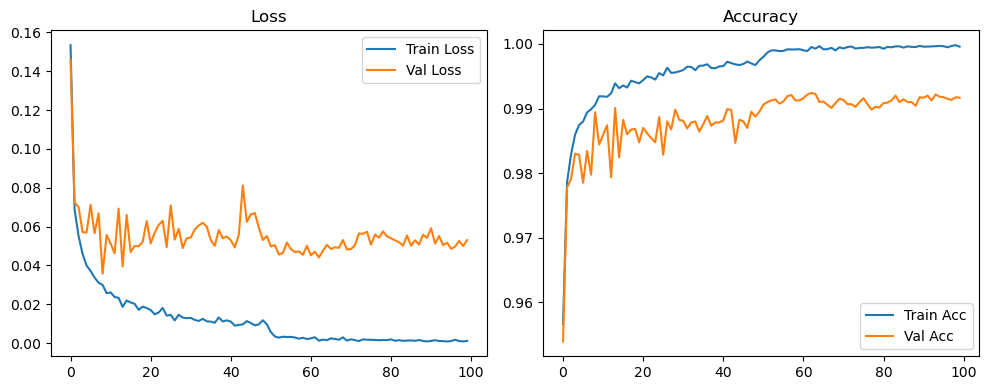

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2466, Acc: 0.9303 | Val Loss: 0.7520, Acc: 0.7390


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1362, Acc: 0.9601 | Val Loss: 0.5957, Acc: 0.7998


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1130, Acc: 0.9663 | Val Loss: 0.3564, Acc: 0.8725


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9695 | Val Loss: 0.2838, Acc: 0.9082


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0937, Acc: 0.9723 | Val Loss: 0.2496, Acc: 0.9213


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9726 | Val Loss: 0.3421, Acc: 0.8841


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0866, Acc: 0.9745 | Val Loss: 0.2514, Acc: 0.9172


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9746 | Val Loss: 0.2973, Acc: 0.9025


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9760 | Val Loss: 0.1886, Acc: 0.9356


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9764 | Val Loss: 0.3610, Acc: 0.8751


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0735, Acc: 0.9779 | Val Loss: 0.1501, Acc: 0.9508


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0732, Acc: 0.9779 | Val Loss: 0.1615, Acc: 0.9470


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9796 | Val Loss: 0.2158, Acc: 0.9275


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9794 | Val Loss: 0.1431, Acc: 0.9537


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9794 | Val Loss: 0.2289, Acc: 0.9254


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9810 | Val Loss: 0.1986, Acc: 0.9320


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0657, Acc: 0.9808 | Val Loss: 0.1553, Acc: 0.9449


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9823 | Val Loss: 0.1367, Acc: 0.9546


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9819 | Val Loss: 0.1456, Acc: 0.9488


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9818 | Val Loss: 0.1122, Acc: 0.9675


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9816 | Val Loss: 0.1508, Acc: 0.9517


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9826 | Val Loss: 0.0985, Acc: 0.9688


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9830 | Val Loss: 0.0670, Acc: 0.9820


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9829 | Val Loss: 0.0982, Acc: 0.9703


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9827 | Val Loss: 0.0990, Acc: 0.9683


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9834 | Val Loss: 0.1551, Acc: 0.9461


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9835 | Val Loss: 0.1319, Acc: 0.9570


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9831 | Val Loss: 0.1031, Acc: 0.9703


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9839 | Val Loss: 0.1244, Acc: 0.9606


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9843 | Val Loss: 0.1549, Acc: 0.9470


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9837 | Val Loss: 0.1392, Acc: 0.9529


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9841 | Val Loss: 0.0982, Acc: 0.9679


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9847 | Val Loss: 0.1870, Acc: 0.9291


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9855 | Val Loss: 0.0727, Acc: 0.9780


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9852 | Val Loss: 0.1130, Acc: 0.9623


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9843 | Val Loss: 0.1163, Acc: 0.9607


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9859 | Val Loss: 0.1075, Acc: 0.9631


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9852 | Val Loss: 0.1311, Acc: 0.9555


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9855 | Val Loss: 0.1107, Acc: 0.9633


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.1342, Acc: 0.9561


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9848 | Val Loss: 0.1580, Acc: 0.9439


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9860 | Val Loss: 0.1227, Acc: 0.9579


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9862 | Val Loss: 0.1309, Acc: 0.9535


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9861 | Val Loss: 0.0971, Acc: 0.9674


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9859 | Val Loss: 0.0972, Acc: 0.9682


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9860 | Val Loss: 0.1259, Acc: 0.9571


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9866 | Val Loss: 0.1173, Acc: 0.9613


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9863 | Val Loss: 0.0906, Acc: 0.9709


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9859 | Val Loss: 0.1325, Acc: 0.9541


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9875 | Val Loss: 0.1421, Acc: 0.9514


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9883 | Val Loss: 0.1112, Acc: 0.9619


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9904 | Val Loss: 0.1237, Acc: 0.9577


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9904 | Val Loss: 0.1018, Acc: 0.9648


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9900 | Val Loss: 0.0815, Acc: 0.9740


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.1070, Acc: 0.9657


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9904 | Val Loss: 0.0765, Acc: 0.9753


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.1027, Acc: 0.9656


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9915 | Val Loss: 0.1036, Acc: 0.9653


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.0931, Acc: 0.9703


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.0864, Acc: 0.9716


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.0825, Acc: 0.9740


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9916 | Val Loss: 0.0800, Acc: 0.9743


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9913 | Val Loss: 0.0920, Acc: 0.9708


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9916 | Val Loss: 0.0911, Acc: 0.9708


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9920 | Val Loss: 0.0879, Acc: 0.9720


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9919 | Val Loss: 0.0820, Acc: 0.9729


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.0798, Acc: 0.9747


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.1052, Acc: 0.9642


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0919, Acc: 0.9698


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0812, Acc: 0.9722


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0773, Acc: 0.9749


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.0787, Acc: 0.9737


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9927 | Val Loss: 0.0909, Acc: 0.9684


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9921 | Val Loss: 0.0829, Acc: 0.9724


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0751, Acc: 0.9751


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9924 | Val Loss: 0.0836, Acc: 0.9722


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9930 | Val Loss: 0.1037, Acc: 0.9627


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.0733, Acc: 0.9766


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9919 | Val Loss: 0.0669, Acc: 0.9800


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9924 | Val Loss: 0.0727, Acc: 0.9778


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.0815, Acc: 0.9747


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0801, Acc: 0.9735


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0779, Acc: 0.9746


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9936 | Val Loss: 0.0725, Acc: 0.9772


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9923 | Val Loss: 0.0761, Acc: 0.9754


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0775, Acc: 0.9749


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9926 | Val Loss: 0.0798, Acc: 0.9743


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.0770, Acc: 0.9756


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.0742, Acc: 0.9758


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0701, Acc: 0.9789


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.0738, Acc: 0.9768


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.0754, Acc: 0.9759


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0757, Acc: 0.9755


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0685, Acc: 0.9789


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0778, Acc: 0.9757


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9933 | Val Loss: 0.0831, Acc: 0.9735


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9928 | Val Loss: 0.0785, Acc: 0.9734


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0876, Acc: 0.9703


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.0682, Acc: 0.9787


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.0641, Acc: 0.9809


Final Test Loss: 0.0580 Accuracy: 0.9817


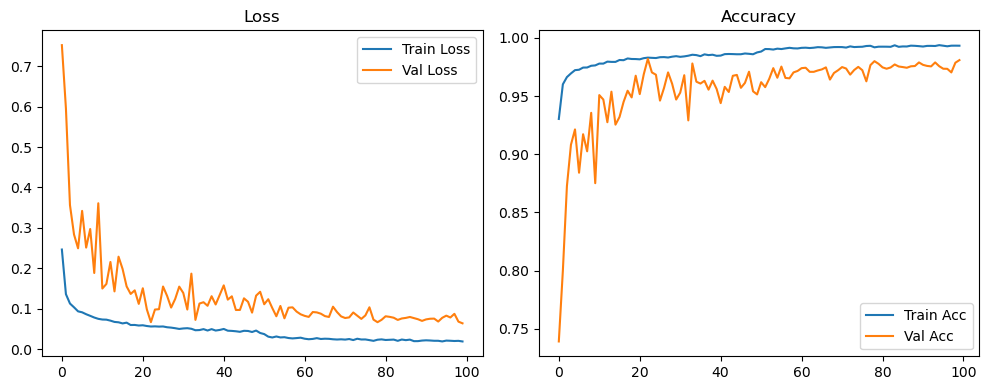

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1340, Acc: 0.9663 | Val Loss: 0.0547, Acc: 0.9832


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9857 | Val Loss: 0.0432, Acc: 0.9867


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9900 | Val Loss: 0.0480, Acc: 0.9851


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.0409, Acc: 0.9888


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9943 | Val Loss: 0.0523, Acc: 0.9852


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.0428, Acc: 0.9876


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0432, Acc: 0.9891


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0486, Acc: 0.9860


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9962 | Val Loss: 0.0475, Acc: 0.9875


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0553, Acc: 0.9871


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0509, Acc: 0.9870


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0477, Acc: 0.9883


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.0556, Acc: 0.9874


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0540, Acc: 0.9883


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0776, Acc: 0.9832


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0557, Acc: 0.9868


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0461, Acc: 0.9902


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0523, Acc: 0.9898


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0508, Acc: 0.9885


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0528, Acc: 0.9891


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0472, Acc: 0.9906


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0605, Acc: 0.9886


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0565, Acc: 0.9892


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0540, Acc: 0.9896


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0528, Acc: 0.9890


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0584, Acc: 0.9912


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0550, Acc: 0.9896


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0660, Acc: 0.9888


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0627, Acc: 0.9888


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0569, Acc: 0.9897


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0628, Acc: 0.9889


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0577, Acc: 0.9902


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0604, Acc: 0.9882


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0537, Acc: 0.9898


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0576, Acc: 0.9902


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.0606, Acc: 0.9898


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0657, Acc: 0.9879


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0720, Acc: 0.9886


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0672, Acc: 0.9895


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0584, Acc: 0.9904


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0658, Acc: 0.9895


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0811, Acc: 0.9871


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0616, Acc: 0.9904


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0768, Acc: 0.9895


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0717, Acc: 0.9898


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0596, Acc: 0.9906


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0634, Acc: 0.9897


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0773, Acc: 0.9882


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0691, Acc: 0.9899


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0599, Acc: 0.9906


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0643, Acc: 0.9913


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0615, Acc: 0.9918


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0614, Acc: 0.9902


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0656, Acc: 0.9910


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0760, Acc: 0.9904


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0747, Acc: 0.9897


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0791, Acc: 0.9902


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0662, Acc: 0.9907


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0629, Acc: 0.9908


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0705, Acc: 0.9908


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0663, Acc: 0.9912


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0695, Acc: 0.9904


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0629, Acc: 0.9913


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0612, Acc: 0.9902


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0788, Acc: 0.9886


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0616, Acc: 0.9908


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0624, Acc: 0.9902


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0683, Acc: 0.9904


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0669, Acc: 0.9904


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0660, Acc: 0.9902


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0644, Acc: 0.9918


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0776, Acc: 0.9888


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0808, Acc: 0.9902


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0748, Acc: 0.9902


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0698, Acc: 0.9914


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0702, Acc: 0.9907


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0669, Acc: 0.9904


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0690, Acc: 0.9913


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0796, Acc: 0.9906


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.0800, Acc: 0.9894


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0869, Acc: 0.9902


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0760, Acc: 0.9905


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0763, Acc: 0.9903


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0806, Acc: 0.9897


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0871, Acc: 0.9899


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0769, Acc: 0.9908


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0806, Acc: 0.9902


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0705, Acc: 0.9907


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0728, Acc: 0.9917


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0756, Acc: 0.9899


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0942, Acc: 0.9895


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.0894, Acc: 0.9900


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0967, Acc: 0.9898


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0929, Acc: 0.9898


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0850, Acc: 0.9900


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0870, Acc: 0.9898


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0911, Acc: 0.9892


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0869, Acc: 0.9897


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0911, Acc: 0.9901


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0807, Acc: 0.9898


Final Test Loss: 0.0731 Accuracy: 0.9906


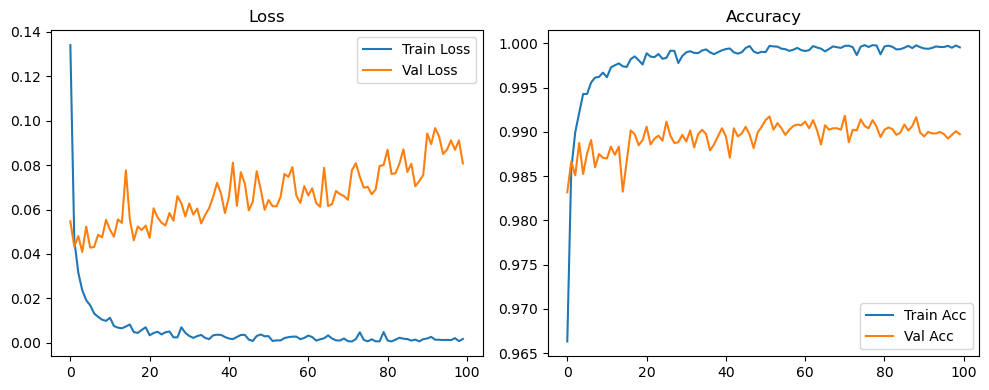

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1586, Acc: 0.9599 | Val Loss: 0.1484, Acc: 0.9548


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0652, Acc: 0.9798 | Val Loss: 0.0530, Acc: 0.9843


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9845 | Val Loss: 0.0827, Acc: 0.9749


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9864 | Val Loss: 0.0753, Acc: 0.9784


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9878 | Val Loss: 0.0468, Acc: 0.9862


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9890 | Val Loss: 0.0830, Acc: 0.9744


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9910 | Val Loss: 0.0601, Acc: 0.9815


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 0.0596, Acc: 0.9824


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.0396, Acc: 0.9883


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9927 | Val Loss: 0.0561, Acc: 0.9839


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9924 | Val Loss: 0.0414, Acc: 0.9878


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0616, Acc: 0.9832


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0530, Acc: 0.9858


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0485, Acc: 0.9868


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0486, Acc: 0.9862


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.0533, Acc: 0.9858


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.0499, Acc: 0.9866


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0496, Acc: 0.9870


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0468, Acc: 0.9878


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9954 | Val Loss: 0.0464, Acc: 0.9880


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.0641, Acc: 0.9854


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0511, Acc: 0.9868


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.0458, Acc: 0.9888


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9958 | Val Loss: 0.0397, Acc: 0.9899


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0607, Acc: 0.9848


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.0694, Acc: 0.9835


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0493, Acc: 0.9876


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0471, Acc: 0.9886


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0550, Acc: 0.9849


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0555, Acc: 0.9882


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0474, Acc: 0.9898


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0601, Acc: 0.9875


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0493, Acc: 0.9895


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0477, Acc: 0.9895


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0447, Acc: 0.9904


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0558, Acc: 0.9868


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0507, Acc: 0.9882


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0517, Acc: 0.9892


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0544, Acc: 0.9891


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0493, Acc: 0.9896


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0552, Acc: 0.9872


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0523, Acc: 0.9876


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0518, Acc: 0.9888


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0598, Acc: 0.9872


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0635, Acc: 0.9866


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0479, Acc: 0.9905


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0570, Acc: 0.9874


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0531, Acc: 0.9902


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0569, Acc: 0.9892


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0688, Acc: 0.9869


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0540, Acc: 0.9892


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0608, Acc: 0.9877


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0448, Acc: 0.9902


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0506, Acc: 0.9902


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0524, Acc: 0.9898


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0554, Acc: 0.9902


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0574, Acc: 0.9892


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0515, Acc: 0.9892


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0517, Acc: 0.9893


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0572, Acc: 0.9878


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0507, Acc: 0.9911


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0491, Acc: 0.9914


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0536, Acc: 0.9906


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0546, Acc: 0.9905


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0524, Acc: 0.9900


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0563, Acc: 0.9890


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0561, Acc: 0.9892


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0570, Acc: 0.9892


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0655, Acc: 0.9872


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0585, Acc: 0.9885


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0630, Acc: 0.9888


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0656, Acc: 0.9888


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0637, Acc: 0.9869


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0576, Acc: 0.9897


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0599, Acc: 0.9890


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0544, Acc: 0.9894


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0561, Acc: 0.9892


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0516, Acc: 0.9908


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0571, Acc: 0.9883


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0559, Acc: 0.9891


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0525, Acc: 0.9904


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0541, Acc: 0.9902


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0530, Acc: 0.9893


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0582, Acc: 0.9876


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0470, Acc: 0.9908


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0557, Acc: 0.9886


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0488, Acc: 0.9898


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0556, Acc: 0.9887


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0561, Acc: 0.9896


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0491, Acc: 0.9905


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.0608, Acc: 0.9897


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0554, Acc: 0.9897


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0533, Acc: 0.9901


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0472, Acc: 0.9905


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0507, Acc: 0.9903


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0536, Acc: 0.9898


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0501, Acc: 0.9898


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0467, Acc: 0.9906


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0546, Acc: 0.9894


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0553, Acc: 0.9899


Final Test Loss: 0.0491 Accuracy: 0.9885


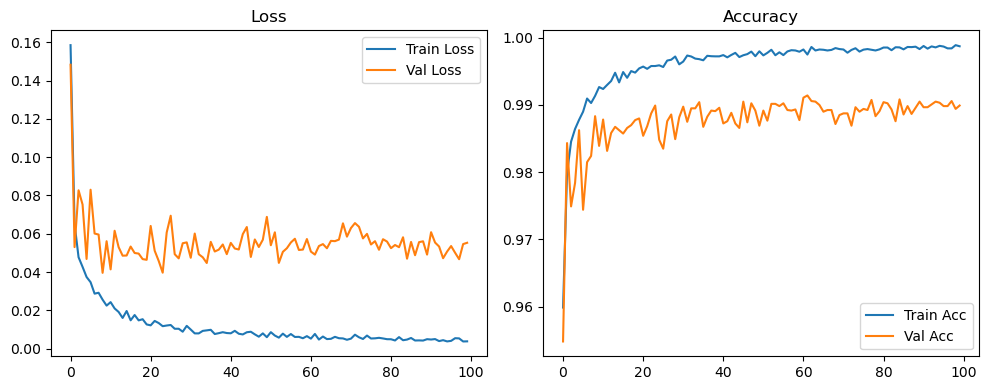

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2552, Acc: 0.9335 | Val Loss: 0.9657, Acc: 0.6519


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1259, Acc: 0.9637 | Val Loss: 0.4509, Acc: 0.8452


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1048, Acc: 0.9686 | Val Loss: 0.5222, Acc: 0.8066


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0930, Acc: 0.9725 | Val Loss: 0.3450, Acc: 0.8817


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0847, Acc: 0.9756 | Val Loss: 0.2989, Acc: 0.9011


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0787, Acc: 0.9756 | Val Loss: 0.2716, Acc: 0.9048


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0794, Acc: 0.9760 | Val Loss: 0.1916, Acc: 0.9365


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9774 | Val Loss: 0.2569, Acc: 0.9103


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9787 | Val Loss: 0.1725, Acc: 0.9421


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0678, Acc: 0.9792 | Val Loss: 0.2127, Acc: 0.9303


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9812 | Val Loss: 0.1277, Acc: 0.9598


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9788 | Val Loss: 0.1833, Acc: 0.9412


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9804 | Val Loss: 0.2335, Acc: 0.9203


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0612, Acc: 0.9816 | Val Loss: 0.1421, Acc: 0.9534


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9812 | Val Loss: 0.3661, Acc: 0.8712


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9821 | Val Loss: 0.1487, Acc: 0.9488


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9827 | Val Loss: 0.1716, Acc: 0.9381


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0539, Acc: 0.9835 | Val Loss: 0.1841, Acc: 0.9351


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9830 | Val Loss: 0.1510, Acc: 0.9495


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9839 | Val Loss: 0.1964, Acc: 0.9347


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9839 | Val Loss: 0.1337, Acc: 0.9566


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9848 | Val Loss: 0.1402, Acc: 0.9539


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9836 | Val Loss: 0.1144, Acc: 0.9627


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9851 | Val Loss: 0.1269, Acc: 0.9569


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9839 | Val Loss: 0.1410, Acc: 0.9508


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9851 | Val Loss: 0.1393, Acc: 0.9503


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9858 | Val Loss: 0.1116, Acc: 0.9622


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9854 | Val Loss: 0.1141, Acc: 0.9649


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9852 | Val Loss: 0.1420, Acc: 0.9529


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9859 | Val Loss: 0.1676, Acc: 0.9437


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9862 | Val Loss: 0.1517, Acc: 0.9487


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9864 | Val Loss: 0.1176, Acc: 0.9635


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9857 | Val Loss: 0.1464, Acc: 0.9525


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9870 | Val Loss: 0.1269, Acc: 0.9583


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9862 | Val Loss: 0.1362, Acc: 0.9566


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9866 | Val Loss: 0.1522, Acc: 0.9527


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9872 | Val Loss: 0.1324, Acc: 0.9566


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9863 | Val Loss: 0.1171, Acc: 0.9643


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9870 | Val Loss: 0.1206, Acc: 0.9606


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9864 | Val Loss: 0.1270, Acc: 0.9595


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9872 | Val Loss: 0.1310, Acc: 0.9566


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9876 | Val Loss: 0.1028, Acc: 0.9685


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9865 | Val Loss: 0.1038, Acc: 0.9683


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9874 | Val Loss: 0.1213, Acc: 0.9604


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9876 | Val Loss: 0.1184, Acc: 0.9642


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.1056, Acc: 0.9673


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9884 | Val Loss: 0.1656, Acc: 0.9457


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9874 | Val Loss: 0.1077, Acc: 0.9663


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9885 | Val Loss: 0.1447, Acc: 0.9512


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9870 | Val Loss: 0.1096, Acc: 0.9643


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9879 | Val Loss: 0.1314, Acc: 0.9579


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9887 | Val Loss: 0.1284, Acc: 0.9570


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.1140, Acc: 0.9631


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9882 | Val Loss: 0.1206, Acc: 0.9612


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9889 | Val Loss: 0.1034, Acc: 0.9685


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9886 | Val Loss: 0.0883, Acc: 0.9718


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.1341, Acc: 0.9549


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.0878, Acc: 0.9749


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9885 | Val Loss: 0.1209, Acc: 0.9613


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9892 | Val Loss: 0.0995, Acc: 0.9692


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9885 | Val Loss: 0.1340, Acc: 0.9553


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9889 | Val Loss: 0.1299, Acc: 0.9577


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9892 | Val Loss: 0.1110, Acc: 0.9665


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9890 | Val Loss: 0.1147, Acc: 0.9636


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9900 | Val Loss: 0.1071, Acc: 0.9675


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9890 | Val Loss: 0.1159, Acc: 0.9626


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.1014, Acc: 0.9708


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9897 | Val Loss: 0.1600, Acc: 0.9432


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9885 | Val Loss: 0.1535, Acc: 0.9514


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9899 | Val Loss: 0.1322, Acc: 0.9553


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9898 | Val Loss: 0.1208, Acc: 0.9593


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9896 | Val Loss: 0.1245, Acc: 0.9584


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.1198, Acc: 0.9637


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9902 | Val Loss: 0.1147, Acc: 0.9637


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9897 | Val Loss: 0.1001, Acc: 0.9694


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9893 | Val Loss: 0.1173, Acc: 0.9645


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9896 | Val Loss: 0.1241, Acc: 0.9593


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9907 | Val Loss: 0.1064, Acc: 0.9664


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9899 | Val Loss: 0.1120, Acc: 0.9671


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.1258, Acc: 0.9571


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9906 | Val Loss: 0.1122, Acc: 0.9692


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9890 | Val Loss: 0.1250, Acc: 0.9600


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0970, Acc: 0.9698


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9907 | Val Loss: 0.0952, Acc: 0.9704


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9900 | Val Loss: 0.1023, Acc: 0.9681


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9894 | Val Loss: 0.1256, Acc: 0.9583


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9908 | Val Loss: 0.1137, Acc: 0.9621


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.0998, Acc: 0.9681


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.0972, Acc: 0.9702


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.1211, Acc: 0.9633


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9906 | Val Loss: 0.1043, Acc: 0.9708


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.1091, Acc: 0.9664


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9900 | Val Loss: 0.1043, Acc: 0.9683


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9906 | Val Loss: 0.1047, Acc: 0.9696


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.0999, Acc: 0.9677


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9895 | Val Loss: 0.1114, Acc: 0.9613


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.1321, Acc: 0.9553


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.1240, Acc: 0.9597


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9908 | Val Loss: 0.1119, Acc: 0.9662


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0950, Acc: 0.9738


Final Test Loss: 0.0878 Accuracy: 0.9743


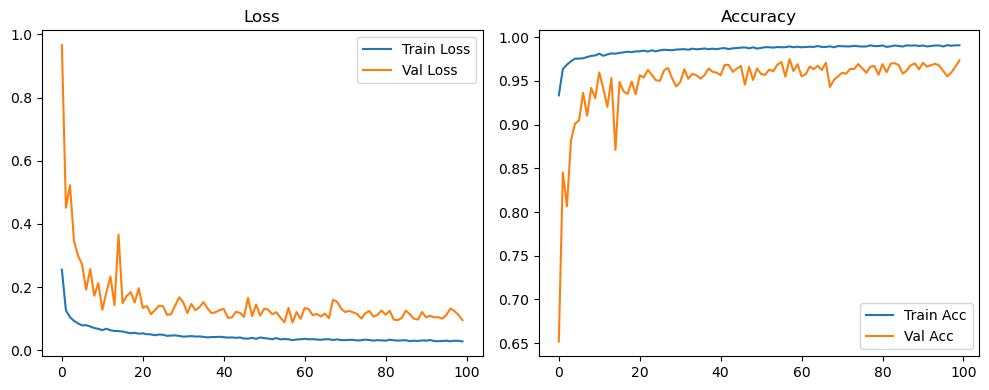

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1336, Acc: 0.9664 | Val Loss: 0.0526, Acc: 0.9836


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9854 | Val Loss: 0.0450, Acc: 0.9869


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9885 | Val Loss: 0.0469, Acc: 0.9853


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.0425, Acc: 0.9870


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0419, Acc: 0.9861


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9944 | Val Loss: 0.0652, Acc: 0.9821


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0439, Acc: 0.9878


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9958 | Val Loss: 0.0504, Acc: 0.9861


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0458, Acc: 0.9892


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0479, Acc: 0.9881


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.0482, Acc: 0.9879


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0462, Acc: 0.9897


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0507, Acc: 0.9878


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.0550, Acc: 0.9875


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0534, Acc: 0.9874


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.0516, Acc: 0.9891


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0499, Acc: 0.9891


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0510, Acc: 0.9888


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0518, Acc: 0.9888


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0544, Acc: 0.9882


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0559, Acc: 0.9895


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0528, Acc: 0.9895


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0522, Acc: 0.9910


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0559, Acc: 0.9887


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0585, Acc: 0.9885


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0507, Acc: 0.9898


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0566, Acc: 0.9887


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0546, Acc: 0.9902


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0631, Acc: 0.9873


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0538, Acc: 0.9895


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0543, Acc: 0.9898


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0599, Acc: 0.9878


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0661, Acc: 0.9880


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0543, Acc: 0.9890


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0552, Acc: 0.9900


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0555, Acc: 0.9910


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0663, Acc: 0.9889


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.0739, Acc: 0.9878


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0729, Acc: 0.9881


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0824, Acc: 0.9880


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0609, Acc: 0.9912


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9993 | Val Loss: 0.0721, Acc: 0.9895


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0628, Acc: 0.9908


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0660, Acc: 0.9898


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0837, Acc: 0.9881


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0594, Acc: 0.9902


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0599, Acc: 0.9908


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0633, Acc: 0.9906


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0689, Acc: 0.9894


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0860, Acc: 0.9880


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0571, Acc: 0.9907


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0594, Acc: 0.9910


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0578, Acc: 0.9911


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0595, Acc: 0.9918


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0566, Acc: 0.9914


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0572, Acc: 0.9915


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0556, Acc: 0.9917


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9917


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0615, Acc: 0.9904


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0560, Acc: 0.9917


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9915


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9907


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0632, Acc: 0.9915


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0688, Acc: 0.9900


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0677, Acc: 0.9902


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0663, Acc: 0.9912


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0663, Acc: 0.9918


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0719, Acc: 0.9912


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0716, Acc: 0.9904


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0648, Acc: 0.9913


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0600, Acc: 0.9915


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0626, Acc: 0.9916


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0627, Acc: 0.9910


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0639, Acc: 0.9912


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9912


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0603, Acc: 0.9918


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0584, Acc: 0.9923


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0580, Acc: 0.9918


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9922


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0647, Acc: 0.9912


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0640, Acc: 0.9921


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0624, Acc: 0.9922


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0641, Acc: 0.9918


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0604, Acc: 0.9918


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9919


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0630, Acc: 0.9916


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0584, Acc: 0.9926


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0643, Acc: 0.9917


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0659, Acc: 0.9920


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0673, Acc: 0.9922


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0684, Acc: 0.9921


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0646, Acc: 0.9918


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0688, Acc: 0.9917


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0675, Acc: 0.9921


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0708, Acc: 0.9909


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0646, Acc: 0.9925


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0691, Acc: 0.9921


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0668, Acc: 0.9919


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0638, Acc: 0.9923


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0649, Acc: 0.9926


Final Test Loss: 0.0710 Accuracy: 0.9898


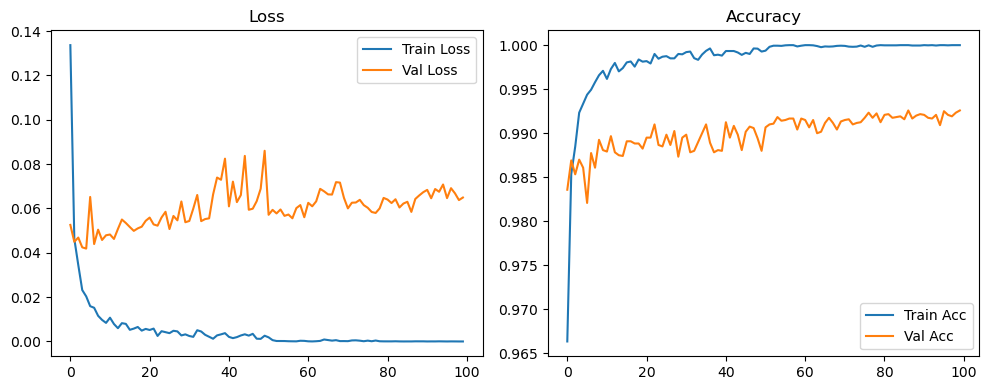

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1597, Acc: 0.9593 | Val Loss: 0.1186, Acc: 0.9643


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0654, Acc: 0.9799 | Val Loss: 0.0632, Acc: 0.9810


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9854 | Val Loss: 0.0967, Acc: 0.9689


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9864 | Val Loss: 0.0632, Acc: 0.9812


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9882 | Val Loss: 0.0632, Acc: 0.9808


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9889 | Val Loss: 0.0602, Acc: 0.9824


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9903 | Val Loss: 0.0618, Acc: 0.9824


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9909 | Val Loss: 0.0453, Acc: 0.9871


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.0437, Acc: 0.9877


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9923 | Val Loss: 0.0478, Acc: 0.9870


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0463, Acc: 0.9869


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0446, Acc: 0.9862


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0556, Acc: 0.9842


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.0424, Acc: 0.9885


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9935 | Val Loss: 0.0558, Acc: 0.9850


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.0474, Acc: 0.9872


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0537, Acc: 0.9842


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9954 | Val Loss: 0.0463, Acc: 0.9882


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.0429, Acc: 0.9885


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9944 | Val Loss: 0.0518, Acc: 0.9854


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0443, Acc: 0.9880


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.0457, Acc: 0.9883


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0408, Acc: 0.9889


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.0527, Acc: 0.9866


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0531, Acc: 0.9867


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0476, Acc: 0.9887


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0511, Acc: 0.9870


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.0489, Acc: 0.9885


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0455, Acc: 0.9893


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0508, Acc: 0.9875


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.0464, Acc: 0.9898


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0532, Acc: 0.9878


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0508, Acc: 0.9886


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0483, Acc: 0.9888


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0431, Acc: 0.9903


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.0517, Acc: 0.9896


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.0473, Acc: 0.9895


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0471, Acc: 0.9885


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0424, Acc: 0.9885


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0499, Acc: 0.9891


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0431, Acc: 0.9906


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0536, Acc: 0.9871


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0574, Acc: 0.9882


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0527, Acc: 0.9875


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0534, Acc: 0.9872


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0473, Acc: 0.9891


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0487, Acc: 0.9897


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0446, Acc: 0.9897


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.0486, Acc: 0.9887


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0617, Acc: 0.9876


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0505, Acc: 0.9884


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0489, Acc: 0.9885


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0442, Acc: 0.9898


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0451, Acc: 0.9898


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0456, Acc: 0.9895


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0426, Acc: 0.9894


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0468, Acc: 0.9897


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0443, Acc: 0.9901


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0487, Acc: 0.9892


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0489, Acc: 0.9902


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0475, Acc: 0.9904


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0491, Acc: 0.9892


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0460, Acc: 0.9907


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0449, Acc: 0.9911


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0412, Acc: 0.9916


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0438, Acc: 0.9921


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0470, Acc: 0.9908


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9990 | Val Loss: 0.0477, Acc: 0.9908


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0432, Acc: 0.9918


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0482, Acc: 0.9903


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0460, Acc: 0.9918


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0485, Acc: 0.9913


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0500, Acc: 0.9904


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0461, Acc: 0.9910


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0534, Acc: 0.9899


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0486, Acc: 0.9916


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0455, Acc: 0.9921


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0440, Acc: 0.9922


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0445, Acc: 0.9918


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0456, Acc: 0.9915


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0436, Acc: 0.9917


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0438, Acc: 0.9915


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0423, Acc: 0.9918


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0397, Acc: 0.9923


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0414, Acc: 0.9922


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0439, Acc: 0.9923


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0408, Acc: 0.9920


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9995 | Val Loss: 0.0455, Acc: 0.9919


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0452, Acc: 0.9919


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0440, Acc: 0.9922


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0487, Acc: 0.9910


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0441, Acc: 0.9915


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0445, Acc: 0.9918


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0456, Acc: 0.9923


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0461, Acc: 0.9922


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0480, Acc: 0.9912


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0423, Acc: 0.9922


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0479, Acc: 0.9918


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0476, Acc: 0.9922


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.0478, Acc: 0.9910


Final Test Loss: 0.0441 Accuracy: 0.9902


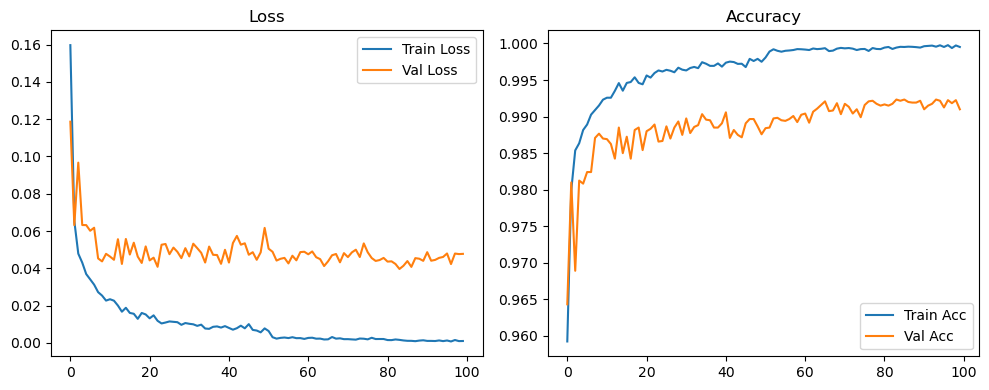

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2542, Acc: 0.9328 | Val Loss: 1.0421, Acc: 0.6223


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1265, Acc: 0.9638 | Val Loss: 0.4945, Acc: 0.8341


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1054, Acc: 0.9685 | Val Loss: 0.3480, Acc: 0.8826


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0955, Acc: 0.9723 | Val Loss: 0.4106, Acc: 0.8453


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0859, Acc: 0.9739 | Val Loss: 0.4628, Acc: 0.8420


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0805, Acc: 0.9755 | Val Loss: 0.2640, Acc: 0.9087


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0783, Acc: 0.9762 | Val Loss: 0.2071, Acc: 0.9302


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9772 | Val Loss: 0.2117, Acc: 0.9263


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0690, Acc: 0.9793 | Val Loss: 0.1674, Acc: 0.9431


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9785 | Val Loss: 0.2108, Acc: 0.9304


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0685, Acc: 0.9786 | Val Loss: 0.1655, Acc: 0.9429


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9798 | Val Loss: 0.1786, Acc: 0.9397


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9801 | Val Loss: 0.2188, Acc: 0.9257


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0623, Acc: 0.9812 | Val Loss: 0.1469, Acc: 0.9516


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9812 | Val Loss: 0.2566, Acc: 0.9073


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9825 | Val Loss: 0.1844, Acc: 0.9378


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9829 | Val Loss: 0.1953, Acc: 0.9333


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9828 | Val Loss: 0.1347, Acc: 0.9540


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9822 | Val Loss: 0.1029, Acc: 0.9674


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9839 | Val Loss: 0.1410, Acc: 0.9524


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9835 | Val Loss: 0.1015, Acc: 0.9667


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9845 | Val Loss: 0.0968, Acc: 0.9678


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9847 | Val Loss: 0.0996, Acc: 0.9690


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9861 | Val Loss: 0.1253, Acc: 0.9583


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9843 | Val Loss: 0.1137, Acc: 0.9617


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9840 | Val Loss: 0.1366, Acc: 0.9514


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9853 | Val Loss: 0.1014, Acc: 0.9682


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9855 | Val Loss: 0.1367, Acc: 0.9563


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9848 | Val Loss: 0.1018, Acc: 0.9680


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9847 | Val Loss: 0.1139, Acc: 0.9624


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9858 | Val Loss: 0.0997, Acc: 0.9691


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9863 | Val Loss: 0.1272, Acc: 0.9583


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9859 | Val Loss: 0.1069, Acc: 0.9673


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9858 | Val Loss: 0.0982, Acc: 0.9704


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9878 | Val Loss: 0.1153, Acc: 0.9630


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9864 | Val Loss: 0.1047, Acc: 0.9678


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9866 | Val Loss: 0.1178, Acc: 0.9630


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9869 | Val Loss: 0.0860, Acc: 0.9736


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9874 | Val Loss: 0.1135, Acc: 0.9644


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9873 | Val Loss: 0.1237, Acc: 0.9604


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9870 | Val Loss: 0.1564, Acc: 0.9475


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 0.1051, Acc: 0.9683


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9878 | Val Loss: 0.0935, Acc: 0.9702


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9875 | Val Loss: 0.0806, Acc: 0.9758


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9872 | Val Loss: 0.0768, Acc: 0.9786


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9880 | Val Loss: 0.0879, Acc: 0.9729


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9879 | Val Loss: 0.1101, Acc: 0.9653


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9872 | Val Loss: 0.0958, Acc: 0.9710


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9882 | Val Loss: 0.1061, Acc: 0.9648


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9882 | Val Loss: 0.1150, Acc: 0.9635


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9890 | Val Loss: 0.1084, Acc: 0.9647


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9905 | Val Loss: 0.1092, Acc: 0.9647


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.1112, Acc: 0.9608


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9911 | Val Loss: 0.0951, Acc: 0.9702


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9917 | Val Loss: 0.0960, Acc: 0.9695


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9905 | Val Loss: 0.0855, Acc: 0.9746


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0896, Acc: 0.9721


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9913 | Val Loss: 0.0879, Acc: 0.9729


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.0800, Acc: 0.9762


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0745, Acc: 0.9772


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.1043, Acc: 0.9677


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9913 | Val Loss: 0.0819, Acc: 0.9759


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9919 | Val Loss: 0.0836, Acc: 0.9747


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9915 | Val Loss: 0.0826, Acc: 0.9733


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9917 | Val Loss: 0.0911, Acc: 0.9700


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0952, Acc: 0.9712


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.0984, Acc: 0.9689


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9921 | Val Loss: 0.1021, Acc: 0.9677


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9911 | Val Loss: 0.0948, Acc: 0.9709


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0854, Acc: 0.9748


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.0931, Acc: 0.9721


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9921 | Val Loss: 0.0821, Acc: 0.9748


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0787, Acc: 0.9764


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.0885, Acc: 0.9717


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.0892, Acc: 0.9740


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9923 | Val Loss: 0.0905, Acc: 0.9728


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9923 | Val Loss: 0.0982, Acc: 0.9719


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.0928, Acc: 0.9712


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9920 | Val Loss: 0.0907, Acc: 0.9728


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9925 | Val Loss: 0.0853, Acc: 0.9756


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.0916, Acc: 0.9716


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.0961, Acc: 0.9692


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.0915, Acc: 0.9722


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9927 | Val Loss: 0.0869, Acc: 0.9721


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9935 | Val Loss: 0.0964, Acc: 0.9696


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0843, Acc: 0.9747


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0763, Acc: 0.9762


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.0829, Acc: 0.9726


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.0762, Acc: 0.9766


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.0753, Acc: 0.9769


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0877, Acc: 0.9733


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.0829, Acc: 0.9741


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9937 | Val Loss: 0.0752, Acc: 0.9770


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0811, Acc: 0.9744


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9927 | Val Loss: 0.0787, Acc: 0.9762


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0769, Acc: 0.9759


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0798, Acc: 0.9742


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.0832, Acc: 0.9750


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0696, Acc: 0.9798


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.0709, Acc: 0.9784


Final Test Loss: 0.0677 Accuracy: 0.9778


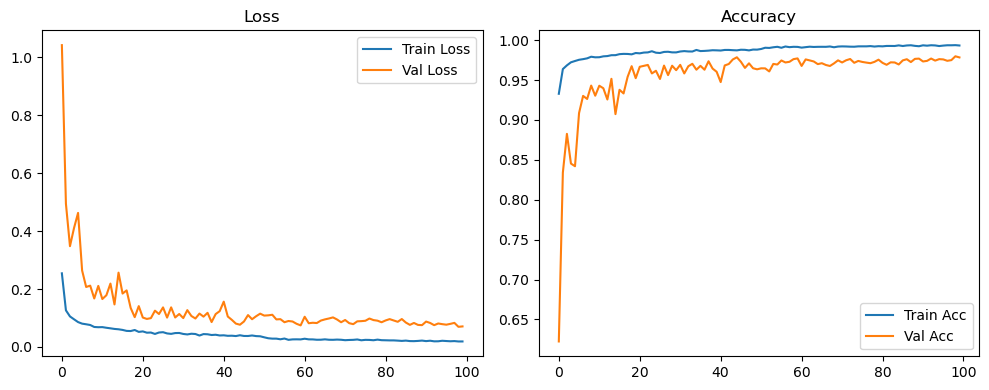

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1701, Acc: 0.9671 | Val Loss: 0.0581, Acc: 0.9829


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0467, Acc: 0.9861 | Val Loss: 0.0442, Acc: 0.9865


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9906 | Val Loss: 0.0424, Acc: 0.9877


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9931 | Val Loss: 0.0431, Acc: 0.9869


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.0405, Acc: 0.9877


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0470, Acc: 0.9867


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0470, Acc: 0.9871


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9961 | Val Loss: 0.0461, Acc: 0.9868


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9965 | Val Loss: 0.0399, Acc: 0.9881


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0420, Acc: 0.9880


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9969 | Val Loss: 0.0488, Acc: 0.9870


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0457, Acc: 0.9895


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0453, Acc: 0.9891


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.0508, Acc: 0.9879


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0446, Acc: 0.9878


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0499, Acc: 0.9872


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0516, Acc: 0.9878


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0390, Acc: 0.9906


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0449, Acc: 0.9886


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0556, Acc: 0.9872


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0431, Acc: 0.9894


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0430, Acc: 0.9901


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0446, Acc: 0.9892


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0480, Acc: 0.9888


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0492, Acc: 0.9886


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0635, Acc: 0.9859


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0445, Acc: 0.9904


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0447, Acc: 0.9902


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0473, Acc: 0.9902


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0458, Acc: 0.9904


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0480, Acc: 0.9892


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0568, Acc: 0.9872


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0426, Acc: 0.9908


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0464, Acc: 0.9902


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0470, Acc: 0.9890


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0440, Acc: 0.9905


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0502, Acc: 0.9893


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0594, Acc: 0.9893


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0492, Acc: 0.9903


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0530, Acc: 0.9900


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0475, Acc: 0.9910


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0495, Acc: 0.9899


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0561, Acc: 0.9878


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0534, Acc: 0.9899


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0534, Acc: 0.9900


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0477, Acc: 0.9904


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0597, Acc: 0.9890


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0640, Acc: 0.9884


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0555, Acc: 0.9903


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0470, Acc: 0.9914


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0524, Acc: 0.9913


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0528, Acc: 0.9894


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0551, Acc: 0.9896


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0462, Acc: 0.9907


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0446, Acc: 0.9912


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0476, Acc: 0.9913


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0552, Acc: 0.9906


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0498, Acc: 0.9912


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0516, Acc: 0.9903


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0472, Acc: 0.9915


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0488, Acc: 0.9912


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9923


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0578, Acc: 0.9897


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0585, Acc: 0.9910


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0559, Acc: 0.9912


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0546, Acc: 0.9902


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0548, Acc: 0.9909


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0562, Acc: 0.9903


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0496, Acc: 0.9918


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0543, Acc: 0.9910


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0594, Acc: 0.9912


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0527, Acc: 0.9908


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0632, Acc: 0.9903


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0559, Acc: 0.9918


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0590, Acc: 0.9907


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0522, Acc: 0.9912


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0603, Acc: 0.9902


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0655, Acc: 0.9895


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0601, Acc: 0.9907


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0576, Acc: 0.9902


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0582, Acc: 0.9895


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0558, Acc: 0.9908


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0588, Acc: 0.9911


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0600, Acc: 0.9910


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0566, Acc: 0.9913


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0616, Acc: 0.9908


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0585, Acc: 0.9908


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0501, Acc: 0.9928


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0565, Acc: 0.9925


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0633, Acc: 0.9905


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0661, Acc: 0.9908


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0617, Acc: 0.9909


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0606, Acc: 0.9911


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0661, Acc: 0.9895


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0622, Acc: 0.9914


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0702, Acc: 0.9901


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0611, Acc: 0.9916


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0635, Acc: 0.9913


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0565, Acc: 0.9917


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0658, Acc: 0.9909


Final Test Loss: 0.0636 Accuracy: 0.9901


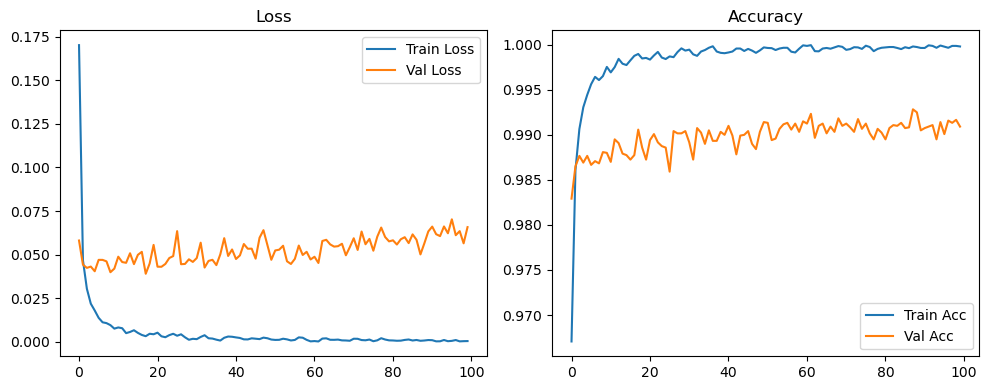

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2006, Acc: 0.9616 | Val Loss: 0.1297, Acc: 0.9663


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0639, Acc: 0.9812 | Val Loss: 0.0713, Acc: 0.9798


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9852 | Val Loss: 0.0880, Acc: 0.9744


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9870 | Val Loss: 0.0614, Acc: 0.9812


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9887 | Val Loss: 0.0678, Acc: 0.9786


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9889 | Val Loss: 0.0483, Acc: 0.9862


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9914 | Val Loss: 0.0520, Acc: 0.9838


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.0514, Acc: 0.9845


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0420, Acc: 0.9858


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.0472, Acc: 0.9853


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0527, Acc: 0.9846


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0565, Acc: 0.9838


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9933 | Val Loss: 0.0465, Acc: 0.9866


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.0541, Acc: 0.9847


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.0502, Acc: 0.9847


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.0411, Acc: 0.9881


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0501, Acc: 0.9863


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0431, Acc: 0.9884


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9944 | Val Loss: 0.0415, Acc: 0.9883


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.0446, Acc: 0.9872


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9952 | Val Loss: 0.0356, Acc: 0.9891


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.0360, Acc: 0.9898


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.0447, Acc: 0.9878


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0382, Acc: 0.9898


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0404, Acc: 0.9895


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0437, Acc: 0.9887


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0445, Acc: 0.9885


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0435, Acc: 0.9888


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0432, Acc: 0.9890


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9969 | Val Loss: 0.0449, Acc: 0.9877


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0442, Acc: 0.9892


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0459, Acc: 0.9878


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0450, Acc: 0.9885


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0396, Acc: 0.9902


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0359, Acc: 0.9919


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0542, Acc: 0.9852


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0415, Acc: 0.9898


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0439, Acc: 0.9902


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0401, Acc: 0.9896


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0421, Acc: 0.9898


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.0426, Acc: 0.9878


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0461, Acc: 0.9888


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0385, Acc: 0.9906


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0424, Acc: 0.9903


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9975 | Val Loss: 0.0379, Acc: 0.9896


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0421, Acc: 0.9898


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0520, Acc: 0.9878


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0447, Acc: 0.9884


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0417, Acc: 0.9901


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0487, Acc: 0.9892


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0394, Acc: 0.9905


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0484, Acc: 0.9888


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0437, Acc: 0.9891


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0447, Acc: 0.9894


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0455, Acc: 0.9898


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0467, Acc: 0.9898


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0431, Acc: 0.9897


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0455, Acc: 0.9888


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0405, Acc: 0.9909


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0438, Acc: 0.9907


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0415, Acc: 0.9908


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0438, Acc: 0.9900


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0412, Acc: 0.9897


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0452, Acc: 0.9884


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0442, Acc: 0.9892


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0388, Acc: 0.9909


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0415, Acc: 0.9901


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0495, Acc: 0.9892


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0421, Acc: 0.9907


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0427, Acc: 0.9895


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0411, Acc: 0.9903


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0492, Acc: 0.9888


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0493, Acc: 0.9899


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0477, Acc: 0.9892


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0496, Acc: 0.9881


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0449, Acc: 0.9895


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0465, Acc: 0.9892


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0446, Acc: 0.9898


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0459, Acc: 0.9906


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.0424, Acc: 0.9905


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9986 | Val Loss: 0.0476, Acc: 0.9899


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0440, Acc: 0.9900


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0428, Acc: 0.9902


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0409, Acc: 0.9907


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0446, Acc: 0.9897


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0452, Acc: 0.9907


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0445, Acc: 0.9907


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0417, Acc: 0.9910


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0442, Acc: 0.9906


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0420, Acc: 0.9912


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0465, Acc: 0.9894


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0477, Acc: 0.9892


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0442, Acc: 0.9908


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0464, Acc: 0.9887


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0460, Acc: 0.9900


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0484, Acc: 0.9893


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0401, Acc: 0.9918


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0446, Acc: 0.9896


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0437, Acc: 0.9905


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0400, Acc: 0.9912


Final Test Loss: 0.0432 Accuracy: 0.9893


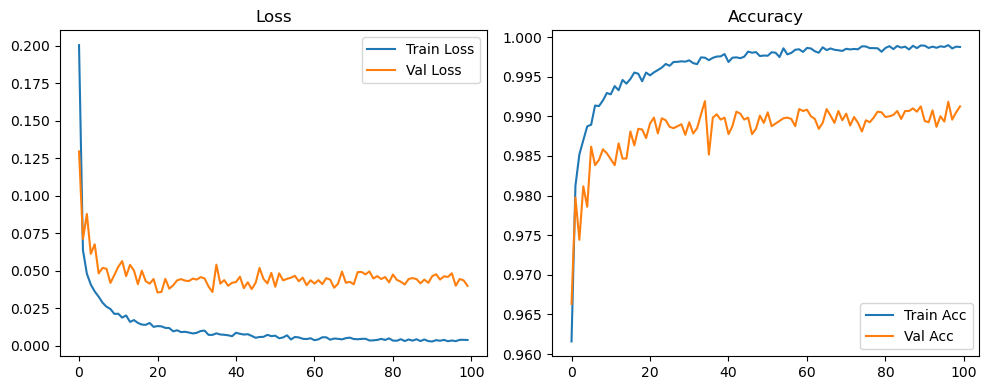

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3143, Acc: 0.9316 | Val Loss: 0.7885, Acc: 0.7253


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1285, Acc: 0.9635 | Val Loss: 0.4953, Acc: 0.8363


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1062, Acc: 0.9684 | Val Loss: 0.4925, Acc: 0.8263


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0939, Acc: 0.9724 | Val Loss: 0.3595, Acc: 0.8743


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0861, Acc: 0.9744 | Val Loss: 0.2551, Acc: 0.9159


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0796, Acc: 0.9761 | Val Loss: 0.3187, Acc: 0.8938


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0783, Acc: 0.9766 | Val Loss: 0.3478, Acc: 0.8896


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0735, Acc: 0.9778 | Val Loss: 0.3730, Acc: 0.8719


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0693, Acc: 0.9788 | Val Loss: 0.2265, Acc: 0.9240


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0673, Acc: 0.9801 | Val Loss: 0.2602, Acc: 0.9122


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0643, Acc: 0.9807 | Val Loss: 0.1881, Acc: 0.9403


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0648, Acc: 0.9800 | Val Loss: 0.1772, Acc: 0.9452


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0639, Acc: 0.9810 | Val Loss: 0.1460, Acc: 0.9554


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0592, Acc: 0.9820 | Val Loss: 0.1696, Acc: 0.9453


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0567, Acc: 0.9828 | Val Loss: 0.2316, Acc: 0.9218


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0576, Acc: 0.9825 | Val Loss: 0.1587, Acc: 0.9505


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0571, Acc: 0.9821 | Val Loss: 0.1776, Acc: 0.9405


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0518, Acc: 0.9839 | Val Loss: 0.1384, Acc: 0.9546


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 0.1565, Acc: 0.9477


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0532, Acc: 0.9839 | Val Loss: 0.1422, Acc: 0.9542


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9843 | Val Loss: 0.1304, Acc: 0.9571


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0473, Acc: 0.9857 | Val Loss: 0.1204, Acc: 0.9628


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9848 | Val Loss: 0.1142, Acc: 0.9630


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0488, Acc: 0.9847 | Val Loss: 0.1123, Acc: 0.9643


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9851 | Val Loss: 0.1179, Acc: 0.9613


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9852 | Val Loss: 0.1454, Acc: 0.9505


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9854 | Val Loss: 0.1235, Acc: 0.9589


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9859 | Val Loss: 0.1593, Acc: 0.9477


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9854 | Val Loss: 0.1496, Acc: 0.9497


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9858 | Val Loss: 0.1278, Acc: 0.9577


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9871 | Val Loss: 0.1171, Acc: 0.9607


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9874 | Val Loss: 0.1103, Acc: 0.9657


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9870 | Val Loss: 0.1438, Acc: 0.9498


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0415, Acc: 0.9868 | Val Loss: 0.1657, Acc: 0.9404


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9867 | Val Loss: 0.1410, Acc: 0.9517


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9866 | Val Loss: 0.1438, Acc: 0.9536


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9876 | Val Loss: 0.1021, Acc: 0.9680


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9876 | Val Loss: 0.1330, Acc: 0.9543


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9882 | Val Loss: 0.1030, Acc: 0.9684


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9874 | Val Loss: 0.0965, Acc: 0.9702


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9880 | Val Loss: 0.1438, Acc: 0.9510


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9876 | Val Loss: 0.1323, Acc: 0.9561


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9876 | Val Loss: 0.1008, Acc: 0.9683


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9888 | Val Loss: 0.1165, Acc: 0.9629


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9882 | Val Loss: 0.0945, Acc: 0.9703


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9876 | Val Loss: 0.0961, Acc: 0.9713


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9892 | Val Loss: 0.1244, Acc: 0.9569


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9892 | Val Loss: 0.0949, Acc: 0.9728


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9891 | Val Loss: 0.1348, Acc: 0.9534


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.0939, Acc: 0.9709


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9884 | Val Loss: 0.0994, Acc: 0.9670


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9894 | Val Loss: 0.0970, Acc: 0.9702


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9886 | Val Loss: 0.1111, Acc: 0.9665


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9888 | Val Loss: 0.1171, Acc: 0.9607


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.1134, Acc: 0.9631


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 0.0985, Acc: 0.9700


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9890 | Val Loss: 0.1313, Acc: 0.9562


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9890 | Val Loss: 0.1270, Acc: 0.9598


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9895 | Val Loss: 0.1256, Acc: 0.9581


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9899 | Val Loss: 0.1022, Acc: 0.9651


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9898 | Val Loss: 0.1114, Acc: 0.9650


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9901 | Val Loss: 0.1016, Acc: 0.9687


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9900 | Val Loss: 0.0936, Acc: 0.9730


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9897 | Val Loss: 0.1095, Acc: 0.9624


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9901 | Val Loss: 0.1119, Acc: 0.9629


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9895 | Val Loss: 0.0913, Acc: 0.9727


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.0851, Acc: 0.9747


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9896 | Val Loss: 0.1144, Acc: 0.9580


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9895 | Val Loss: 0.1081, Acc: 0.9671


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9903 | Val Loss: 0.0997, Acc: 0.9694


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9903 | Val Loss: 0.1088, Acc: 0.9635


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.1113, Acc: 0.9635


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.1106, Acc: 0.9647


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9897 | Val Loss: 0.1055, Acc: 0.9654


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0879, Acc: 0.9742


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.0853, Acc: 0.9774


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.1037, Acc: 0.9683


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.1127, Acc: 0.9640


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.0919, Acc: 0.9712


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9903 | Val Loss: 0.0916, Acc: 0.9752


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9907 | Val Loss: 0.0931, Acc: 0.9719


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.1054, Acc: 0.9689


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0880, Acc: 0.9731


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9914 | Val Loss: 0.0905, Acc: 0.9727


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9912 | Val Loss: 0.0997, Acc: 0.9705


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9908 | Val Loss: 0.1049, Acc: 0.9677


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9910 | Val Loss: 0.1079, Acc: 0.9656


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.1001, Acc: 0.9679


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0876, Acc: 0.9746


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9907 | Val Loss: 0.0910, Acc: 0.9733


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0930, Acc: 0.9716


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.1135, Acc: 0.9654


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9909 | Val Loss: 0.1066, Acc: 0.9665


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9917 | Val Loss: 0.0879, Acc: 0.9758


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0909, Acc: 0.9739


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9914 | Val Loss: 0.1149, Acc: 0.9623


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.0777, Acc: 0.9767


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.0970, Acc: 0.9687


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9906 | Val Loss: 0.0985, Acc: 0.9728


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.0742, Acc: 0.9792


Final Test Loss: 0.0719 Accuracy: 0.9782


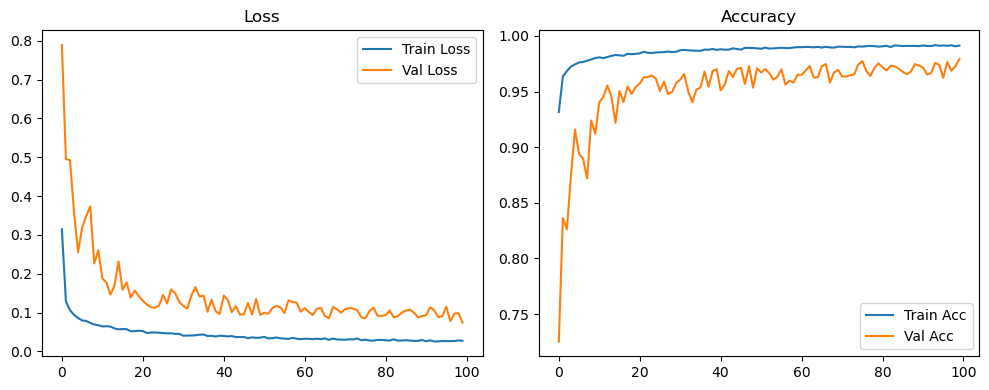

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2370, Acc: 0.9649 | Val Loss: 0.0683, Acc: 0.9832


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0515, Acc: 0.9869 | Val Loss: 0.0516, Acc: 0.9870


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9909 | Val Loss: 0.0476, Acc: 0.9858


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9935 | Val Loss: 0.0528, Acc: 0.9842


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0406, Acc: 0.9880


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9964 | Val Loss: 0.0410, Acc: 0.9878


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0422, Acc: 0.9870


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.0451, Acc: 0.9866


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0402, Acc: 0.9889


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0430, Acc: 0.9890


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0498, Acc: 0.9859


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0418, Acc: 0.9888


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0443, Acc: 0.9892


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0453, Acc: 0.9878


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0468, Acc: 0.9871


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0475, Acc: 0.9868


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0637, Acc: 0.9844


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0474, Acc: 0.9882


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0508, Acc: 0.9869


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0504, Acc: 0.9888


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0479, Acc: 0.9884


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0468, Acc: 0.9878


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0513, Acc: 0.9881


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0491, Acc: 0.9882


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0446, Acc: 0.9886


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0413, Acc: 0.9902


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0423, Acc: 0.9902


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0467, Acc: 0.9891


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0514, Acc: 0.9880


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0595, Acc: 0.9865


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0498, Acc: 0.9882


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0533, Acc: 0.9876


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0517, Acc: 0.9879


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0473, Acc: 0.9902


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0498, Acc: 0.9897


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0501, Acc: 0.9886


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0525, Acc: 0.9888


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0491, Acc: 0.9904


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0554, Acc: 0.9888


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0510, Acc: 0.9887


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0471, Acc: 0.9902


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.0585, Acc: 0.9872


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0568, Acc: 0.9877


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0539, Acc: 0.9893


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0497, Acc: 0.9895


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0494, Acc: 0.9903


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0560, Acc: 0.9899


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0482, Acc: 0.9908


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0551, Acc: 0.9881


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0554, Acc: 0.9893


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0565, Acc: 0.9887


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0505, Acc: 0.9907


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0469, Acc: 0.9911


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0536, Acc: 0.9892


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0553, Acc: 0.9880


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0505, Acc: 0.9877


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0567, Acc: 0.9891


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0469, Acc: 0.9896


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0555, Acc: 0.9889


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0549, Acc: 0.9889


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0595, Acc: 0.9891


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0535, Acc: 0.9897


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0463, Acc: 0.9914


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0561, Acc: 0.9899


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0637, Acc: 0.9886


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0604, Acc: 0.9892


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0571, Acc: 0.9889


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0576, Acc: 0.9907


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0589, Acc: 0.9898


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0515, Acc: 0.9905


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0566, Acc: 0.9886


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0579, Acc: 0.9893


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0562, Acc: 0.9888


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0592, Acc: 0.9897


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0656, Acc: 0.9891


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0653, Acc: 0.9888


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0557, Acc: 0.9902


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0561, Acc: 0.9895


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0686, Acc: 0.9883


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0564, Acc: 0.9894


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0570, Acc: 0.9890


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0531, Acc: 0.9898


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0637, Acc: 0.9899


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0556, Acc: 0.9892


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0607, Acc: 0.9897


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0539, Acc: 0.9908


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0576, Acc: 0.9893


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0539, Acc: 0.9902


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0639, Acc: 0.9887


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0616, Acc: 0.9898


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0683, Acc: 0.9893


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0570, Acc: 0.9898


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0519, Acc: 0.9902


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9900


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0548, Acc: 0.9906


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0540, Acc: 0.9908


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0528, Acc: 0.9910


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0537, Acc: 0.9898


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0568, Acc: 0.9899


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0631, Acc: 0.9885


Final Test Loss: 0.0563 Accuracy: 0.9896


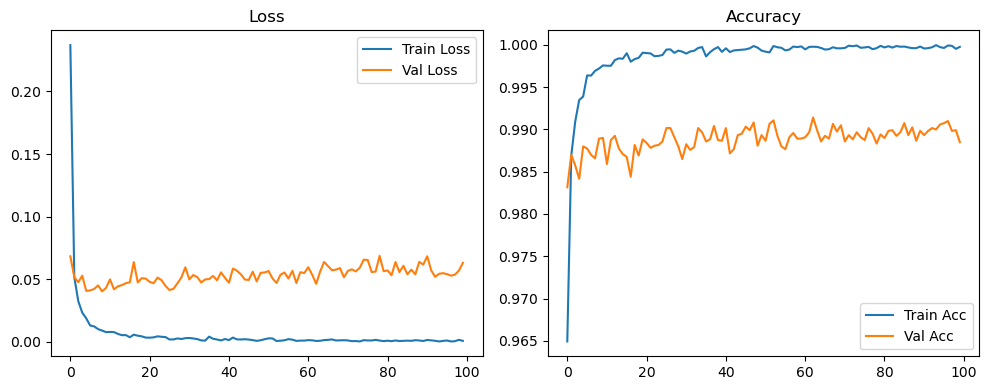

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2752, Acc: 0.9585 | Val Loss: 0.1743, Acc: 0.9612


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0708, Acc: 0.9814 | Val Loss: 0.0850, Acc: 0.9788


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0510, Acc: 0.9857 | Val Loss: 0.0905, Acc: 0.9741


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9870 | Val Loss: 0.0633, Acc: 0.9818


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0368, Acc: 0.9890 | Val Loss: 0.0644, Acc: 0.9815


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9890 | Val Loss: 0.0629, Acc: 0.9814


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9916 | Val Loss: 0.0519, Acc: 0.9838


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.0593, Acc: 0.9817


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0436, Acc: 0.9859


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9927 | Val Loss: 0.0528, Acc: 0.9847


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9927 | Val Loss: 0.0440, Acc: 0.9876


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.0512, Acc: 0.9849


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9937 | Val Loss: 0.0491, Acc: 0.9857


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0421, Acc: 0.9888


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9937 | Val Loss: 0.0503, Acc: 0.9855


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.0534, Acc: 0.9840


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0559, Acc: 0.9845


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0477, Acc: 0.9862


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9947 | Val Loss: 0.0380, Acc: 0.9885


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.0386, Acc: 0.9892


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0457, Acc: 0.9866


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0371, Acc: 0.9895


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9967 | Val Loss: 0.0534, Acc: 0.9842


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0465, Acc: 0.9870


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0496, Acc: 0.9873


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0467, Acc: 0.9872


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0439, Acc: 0.9878


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0464, Acc: 0.9868


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0439, Acc: 0.9876


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0505, Acc: 0.9867


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0385, Acc: 0.9895


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0486, Acc: 0.9872


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.0484, Acc: 0.9880


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0414, Acc: 0.9892


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0354, Acc: 0.9903


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0438, Acc: 0.9889


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0416, Acc: 0.9885


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0405, Acc: 0.9905


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0478, Acc: 0.9882


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0390, Acc: 0.9897


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9977 | Val Loss: 0.0402, Acc: 0.9894


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0458, Acc: 0.9889


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0399, Acc: 0.9899


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.0471, Acc: 0.9897


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0393, Acc: 0.9897


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0468, Acc: 0.9874


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0532, Acc: 0.9862


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0419, Acc: 0.9890


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0493, Acc: 0.9883


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0487, Acc: 0.9883


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0410, Acc: 0.9892


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0436, Acc: 0.9885


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0461, Acc: 0.9887


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0466, Acc: 0.9882


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0474, Acc: 0.9874


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.0429, Acc: 0.9892


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0494, Acc: 0.9882


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0421, Acc: 0.9887


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0496, Acc: 0.9878


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0490, Acc: 0.9876


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0472, Acc: 0.9878


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0428, Acc: 0.9893


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0414, Acc: 0.9904


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0452, Acc: 0.9892


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0407, Acc: 0.9894


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0435, Acc: 0.9900


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.0428, Acc: 0.9894


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0424, Acc: 0.9901


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0448, Acc: 0.9892


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0517, Acc: 0.9875


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0462, Acc: 0.9892


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0484, Acc: 0.9888


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0487, Acc: 0.9895


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0458, Acc: 0.9894


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0451, Acc: 0.9897


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0427, Acc: 0.9899


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0431, Acc: 0.9903


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0463, Acc: 0.9897


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0385, Acc: 0.9906


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0455, Acc: 0.9898


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0475, Acc: 0.9877


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0479, Acc: 0.9899


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0443, Acc: 0.9899


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9986 | Val Loss: 0.0474, Acc: 0.9888


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0472, Acc: 0.9898


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0562, Acc: 0.9870


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0453, Acc: 0.9897


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0550, Acc: 0.9888


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0470, Acc: 0.9897


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0511, Acc: 0.9886


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0460, Acc: 0.9899


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0444, Acc: 0.9900


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0455, Acc: 0.9893


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9986 | Val Loss: 0.0414, Acc: 0.9896


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0417, Acc: 0.9900


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0483, Acc: 0.9880


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0457, Acc: 0.9892


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0490, Acc: 0.9895


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0465, Acc: 0.9888


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0390, Acc: 0.9904


Final Test Loss: 0.0390 Accuracy: 0.9899


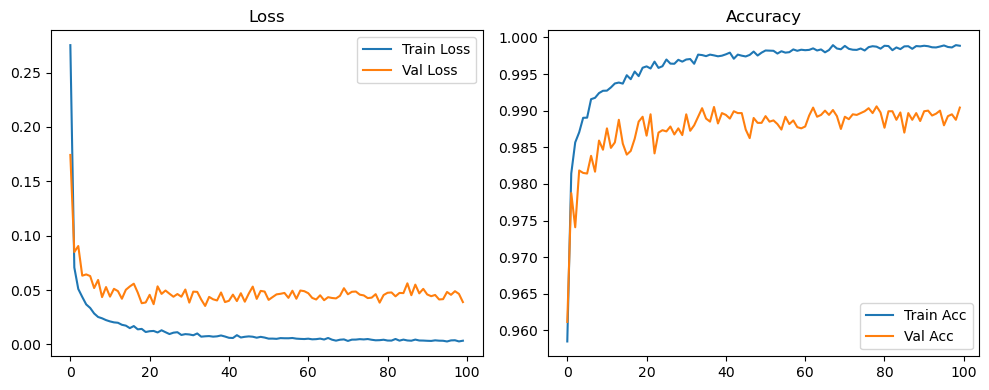

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4183, Acc: 0.9224 | Val Loss: 1.0361, Acc: 0.6133


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1434, Acc: 0.9631 | Val Loss: 0.6772, Acc: 0.7770


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1144, Acc: 0.9675 | Val Loss: 0.7635, Acc: 0.7170


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0995, Acc: 0.9721 | Val Loss: 0.5447, Acc: 0.8063


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0915, Acc: 0.9744 | Val Loss: 0.4458, Acc: 0.8478


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0856, Acc: 0.9745 | Val Loss: 0.4682, Acc: 0.8432


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0810, Acc: 0.9758 | Val Loss: 0.4332, Acc: 0.8544


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0767, Acc: 0.9770 | Val Loss: 0.3740, Acc: 0.8677


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0736, Acc: 0.9786 | Val Loss: 0.2654, Acc: 0.9097


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0700, Acc: 0.9795 | Val Loss: 0.3036, Acc: 0.8928


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0652, Acc: 0.9805 | Val Loss: 0.2424, Acc: 0.9199


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0689, Acc: 0.9795 | Val Loss: 0.1671, Acc: 0.9468


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0644, Acc: 0.9806 | Val Loss: 0.2518, Acc: 0.9156


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0632, Acc: 0.9816 | Val Loss: 0.2527, Acc: 0.9130


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0594, Acc: 0.9817 | Val Loss: 0.2241, Acc: 0.9238


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0590, Acc: 0.9821 | Val Loss: 0.2025, Acc: 0.9349


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0592, Acc: 0.9818 | Val Loss: 0.1840, Acc: 0.9390


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0555, Acc: 0.9830 | Val Loss: 0.1721, Acc: 0.9413


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0551, Acc: 0.9836 | Val Loss: 0.1809, Acc: 0.9398


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0526, Acc: 0.9842 | Val Loss: 0.1920, Acc: 0.9391


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0537, Acc: 0.9831 | Val Loss: 0.1854, Acc: 0.9367


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0514, Acc: 0.9842 | Val Loss: 0.1286, Acc: 0.9607


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0495, Acc: 0.9847 | Val Loss: 0.1598, Acc: 0.9468


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9850 | Val Loss: 0.1420, Acc: 0.9548


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0508, Acc: 0.9850 | Val Loss: 0.1413, Acc: 0.9549


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9851 | Val Loss: 0.1328, Acc: 0.9587


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0496, Acc: 0.9844 | Val Loss: 0.1570, Acc: 0.9487


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9854 | Val Loss: 0.1494, Acc: 0.9507


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0448, Acc: 0.9855 | Val Loss: 0.1585, Acc: 0.9467


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9861 | Val Loss: 0.1414, Acc: 0.9539


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9861 | Val Loss: 0.1390, Acc: 0.9548


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9862 | Val Loss: 0.1501, Acc: 0.9505


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9863 | Val Loss: 0.1305, Acc: 0.9613


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9861 | Val Loss: 0.1360, Acc: 0.9576


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9869 | Val Loss: 0.1143, Acc: 0.9635


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9865 | Val Loss: 0.1294, Acc: 0.9580


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9865 | Val Loss: 0.1107, Acc: 0.9666


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9876 | Val Loss: 0.1351, Acc: 0.9561


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9875 | Val Loss: 0.1099, Acc: 0.9661


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0401, Acc: 0.9877 | Val Loss: 0.1342, Acc: 0.9583


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 0.1403, Acc: 0.9557


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9880 | Val Loss: 0.1096, Acc: 0.9645


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9872 | Val Loss: 0.1305, Acc: 0.9582


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9881 | Val Loss: 0.1381, Acc: 0.9564


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9881 | Val Loss: 0.1132, Acc: 0.9647


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9882 | Val Loss: 0.0980, Acc: 0.9706


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9882 | Val Loss: 0.1414, Acc: 0.9551


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.1169, Acc: 0.9633


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9885 | Val Loss: 0.1081, Acc: 0.9664


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0365, Acc: 0.9887 | Val Loss: 0.0890, Acc: 0.9723


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9884 | Val Loss: 0.1124, Acc: 0.9649


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9885 | Val Loss: 0.1204, Acc: 0.9591


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0368, Acc: 0.9887 | Val Loss: 0.1268, Acc: 0.9581


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9883 | Val Loss: 0.1202, Acc: 0.9634


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9895 | Val Loss: 0.1653, Acc: 0.9441


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9898 | Val Loss: 0.0968, Acc: 0.9703


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9894 | Val Loss: 0.1782, Acc: 0.9439


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9893 | Val Loss: 0.1477, Acc: 0.9532


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9888 | Val Loss: 0.1593, Acc: 0.9477


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 0.1201, Acc: 0.9638


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.1225, Acc: 0.9607


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9893 | Val Loss: 0.1210, Acc: 0.9627


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9904 | Val Loss: 0.0862, Acc: 0.9745


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9899 | Val Loss: 0.0983, Acc: 0.9696


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9899 | Val Loss: 0.1368, Acc: 0.9598


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9897 | Val Loss: 0.1108, Acc: 0.9655


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.1046, Acc: 0.9697


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 0.1289, Acc: 0.9567


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9892 | Val Loss: 0.1161, Acc: 0.9633


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9895 | Val Loss: 0.1078, Acc: 0.9653


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9904 | Val Loss: 0.1162, Acc: 0.9639


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9894 | Val Loss: 0.1037, Acc: 0.9686


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 0.1286, Acc: 0.9585


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.1142, Acc: 0.9636


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9909 | Val Loss: 0.1052, Acc: 0.9672


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.1122, Acc: 0.9644


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9901 | Val Loss: 0.1200, Acc: 0.9611


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9902 | Val Loss: 0.1305, Acc: 0.9600


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9910 | Val Loss: 0.1001, Acc: 0.9702


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9899 | Val Loss: 0.1042, Acc: 0.9661


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9910 | Val Loss: 0.1070, Acc: 0.9676


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9898 | Val Loss: 0.1014, Acc: 0.9699


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9907 | Val Loss: 0.1008, Acc: 0.9690


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9910 | Val Loss: 0.1193, Acc: 0.9619


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.1135, Acc: 0.9651


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9910 | Val Loss: 0.1046, Acc: 0.9676


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.1001, Acc: 0.9692


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.1011, Acc: 0.9688


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9908 | Val Loss: 0.0847, Acc: 0.9742


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9906 | Val Loss: 0.1090, Acc: 0.9686


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9907 | Val Loss: 0.1096, Acc: 0.9662


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9910 | Val Loss: 0.1175, Acc: 0.9647


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9910 | Val Loss: 0.1194, Acc: 0.9632


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.1004, Acc: 0.9721


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9915 | Val Loss: 0.0987, Acc: 0.9709


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9916 | Val Loss: 0.0947, Acc: 0.9713


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.1017, Acc: 0.9695


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9903 | Val Loss: 0.1023, Acc: 0.9696


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.1031, Acc: 0.9682


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.1005, Acc: 0.9688


Final Test Loss: 0.0899 Accuracy: 0.9719


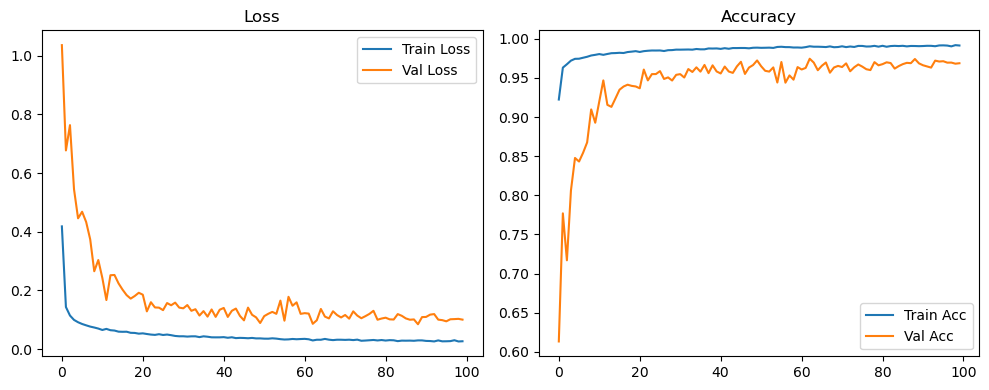

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1514, Acc: 0.9600 | Val Loss: 0.0778, Acc: 0.9743


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9852 | Val Loss: 0.0495, Acc: 0.9840


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9891 | Val Loss: 0.0656, Acc: 0.9802


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0561, Acc: 0.9838


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.0496, Acc: 0.9848


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.0420, Acc: 0.9893


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0514, Acc: 0.9857


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0454, Acc: 0.9882


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0480, Acc: 0.9877


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0548, Acc: 0.9873


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0604, Acc: 0.9872


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9965 | Val Loss: 0.0617, Acc: 0.9855


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.0454, Acc: 0.9900


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0555, Acc: 0.9872


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0564, Acc: 0.9863


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0538, Acc: 0.9886


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0515, Acc: 0.9885


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0460, Acc: 0.9894


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0517, Acc: 0.9891


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0523, Acc: 0.9887


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0571, Acc: 0.9876


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0511, Acc: 0.9895


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0596, Acc: 0.9884


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0502, Acc: 0.9898


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0490, Acc: 0.9900


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0628, Acc: 0.9887


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0596, Acc: 0.9890


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0765, Acc: 0.9861


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0628, Acc: 0.9887


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0585, Acc: 0.9889


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0529, Acc: 0.9896


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0550, Acc: 0.9912


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0638, Acc: 0.9895


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0767, Acc: 0.9878


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0616, Acc: 0.9891


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0643, Acc: 0.9894


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0583, Acc: 0.9903


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0694, Acc: 0.9888


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0641, Acc: 0.9895


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0706, Acc: 0.9889


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0744, Acc: 0.9889


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0801, Acc: 0.9882


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0619, Acc: 0.9897


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0704, Acc: 0.9894


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0729, Acc: 0.9885


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0586, Acc: 0.9899


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0610, Acc: 0.9892


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0733, Acc: 0.9891


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0785, Acc: 0.9882


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0775, Acc: 0.9882


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0646, Acc: 0.9898


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0688, Acc: 0.9899


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0671, Acc: 0.9896


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0667, Acc: 0.9901


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0734, Acc: 0.9902


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0773, Acc: 0.9897


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0647, Acc: 0.9897


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0827, Acc: 0.9885


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0732, Acc: 0.9889


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9989 | Val Loss: 0.0741, Acc: 0.9900


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0750, Acc: 0.9895


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0745, Acc: 0.9899


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0728, Acc: 0.9900


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0783, Acc: 0.9896


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0811, Acc: 0.9890


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.0856, Acc: 0.9892


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0821, Acc: 0.9886


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0729, Acc: 0.9902


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0812, Acc: 0.9898


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0827, Acc: 0.9904


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0719, Acc: 0.9899


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0886, Acc: 0.9900


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0821, Acc: 0.9905


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0691, Acc: 0.9912


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0793, Acc: 0.9900


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0737, Acc: 0.9906


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0820, Acc: 0.9905


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0928, Acc: 0.9887


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0817, Acc: 0.9899


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0737, Acc: 0.9908


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0997, Acc: 0.9895


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0973, Acc: 0.9896


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0996, Acc: 0.9902


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9994 | Val Loss: 0.0917, Acc: 0.9902


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0791, Acc: 0.9917


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9993 | Val Loss: 0.0907, Acc: 0.9891


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0797, Acc: 0.9906


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0819, Acc: 0.9908


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0821, Acc: 0.9913


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0712, Acc: 0.9914


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0815, Acc: 0.9913


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0814, Acc: 0.9907


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0720, Acc: 0.9918


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0659, Acc: 0.9922


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0777, Acc: 0.9908


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0975, Acc: 0.9908


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1093, Acc: 0.9892


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0902, Acc: 0.9906


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.0930, Acc: 0.9901


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0884, Acc: 0.9902


Final Test Loss: 0.0838 Accuracy: 0.9903


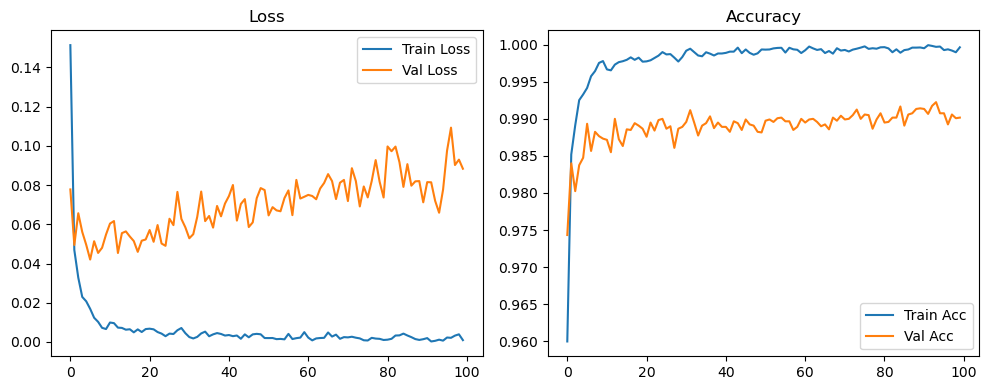

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1791, Acc: 0.9525 | Val Loss: 0.1794, Acc: 0.9424


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0658, Acc: 0.9793 | Val Loss: 0.0661, Acc: 0.9802


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9840 | Val Loss: 0.0688, Acc: 0.9785


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9866 | Val Loss: 0.0604, Acc: 0.9818


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9881 | Val Loss: 0.0537, Acc: 0.9822


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9890 | Val Loss: 0.0432, Acc: 0.9863


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9904 | Val Loss: 0.0591, Acc: 0.9812


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9917 | Val Loss: 0.0522, Acc: 0.9845


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.0557, Acc: 0.9828


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.0482, Acc: 0.9849


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9927 | Val Loss: 0.0444, Acc: 0.9863


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9930 | Val Loss: 0.0464, Acc: 0.9871


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.0483, Acc: 0.9861


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9932 | Val Loss: 0.0438, Acc: 0.9877


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9943 | Val Loss: 0.0425, Acc: 0.9885


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.0605, Acc: 0.9837


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9949 | Val Loss: 0.0417, Acc: 0.9888


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0449, Acc: 0.9897


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0488, Acc: 0.9878


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0607, Acc: 0.9853


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.0468, Acc: 0.9888


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.0457, Acc: 0.9892


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0475, Acc: 0.9889


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0560, Acc: 0.9867


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.0549, Acc: 0.9858


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0535, Acc: 0.9870


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0590, Acc: 0.9859


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0516, Acc: 0.9871


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0565, Acc: 0.9867


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0624, Acc: 0.9856


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0467, Acc: 0.9883


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0590, Acc: 0.9861


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.0422, Acc: 0.9895


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0465, Acc: 0.9895


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0468, Acc: 0.9898


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0532, Acc: 0.9890


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0470, Acc: 0.9883


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0625, Acc: 0.9879


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0587, Acc: 0.9871


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0597, Acc: 0.9867


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0534, Acc: 0.9877


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0486, Acc: 0.9894


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0615, Acc: 0.9868


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0527, Acc: 0.9879


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0673, Acc: 0.9859


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0577, Acc: 0.9885


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0601, Acc: 0.9888


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0572, Acc: 0.9881


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0613, Acc: 0.9872


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0548, Acc: 0.9895


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0613, Acc: 0.9875


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.0642, Acc: 0.9862


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0560, Acc: 0.9881


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0491, Acc: 0.9888


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0566, Acc: 0.9882


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0596, Acc: 0.9864


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0528, Acc: 0.9888


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0601, Acc: 0.9884


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0517, Acc: 0.9902


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0598, Acc: 0.9894


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0565, Acc: 0.9887


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0682, Acc: 0.9859


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0502, Acc: 0.9906


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0502, Acc: 0.9902


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0628, Acc: 0.9872


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0550, Acc: 0.9902


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0586, Acc: 0.9888


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.0612, Acc: 0.9882


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0606, Acc: 0.9885


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0543, Acc: 0.9892


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0654, Acc: 0.9889


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0674, Acc: 0.9881


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9984 | Val Loss: 0.0702, Acc: 0.9888


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0680, Acc: 0.9886


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9982 | Val Loss: 0.0669, Acc: 0.9886


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.0645, Acc: 0.9889


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0559, Acc: 0.9898


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.0600, Acc: 0.9888


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0573, Acc: 0.9910


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0666, Acc: 0.9876


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0597, Acc: 0.9899


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0632, Acc: 0.9899


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0620, Acc: 0.9892


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0614, Acc: 0.9891


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0725, Acc: 0.9878


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0721, Acc: 0.9871


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0696, Acc: 0.9879


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0748, Acc: 0.9874


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0638, Acc: 0.9894


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0556, Acc: 0.9906


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0634, Acc: 0.9898


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.0668, Acc: 0.9891


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0539, Acc: 0.9912


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0669, Acc: 0.9888


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0558, Acc: 0.9907


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0591, Acc: 0.9902


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.0694, Acc: 0.9886


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.0594, Acc: 0.9902


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0536, Acc: 0.9905


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.0530, Acc: 0.9902


Final Test Loss: 0.0538 Accuracy: 0.9890


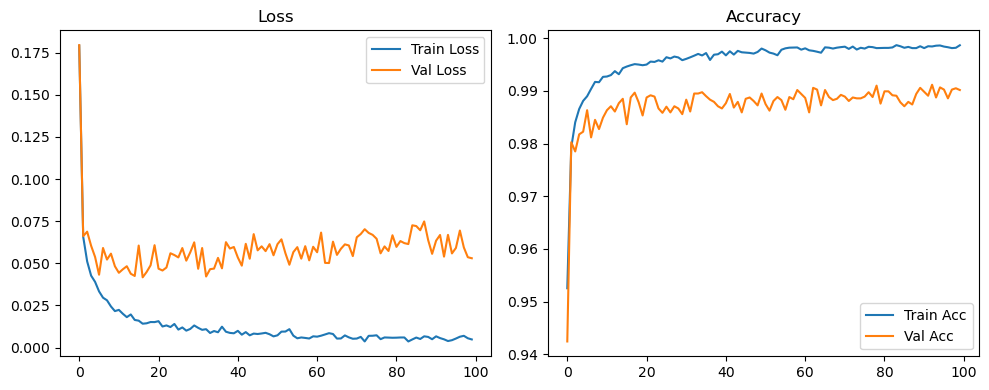

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2715, Acc: 0.9242 | Val Loss: 1.3917, Acc: 0.5361


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1325, Acc: 0.9605 | Val Loss: 0.5314, Acc: 0.8310


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1078, Acc: 0.9688 | Val Loss: 0.7456, Acc: 0.7242


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1010, Acc: 0.9708 | Val Loss: 0.8956, Acc: 0.6958


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0936, Acc: 0.9719 | Val Loss: 0.4723, Acc: 0.8264


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9741 | Val Loss: 0.5572, Acc: 0.8083


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0809, Acc: 0.9760 | Val Loss: 0.3892, Acc: 0.8575


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9766 | Val Loss: 0.3353, Acc: 0.8798


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9787 | Val Loss: 0.2163, Acc: 0.9265


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0705, Acc: 0.9800 | Val Loss: 0.2411, Acc: 0.9204


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9791 | Val Loss: 0.2586, Acc: 0.9111


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9795 | Val Loss: 0.2260, Acc: 0.9246


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9806 | Val Loss: 0.2617, Acc: 0.9102


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9808 | Val Loss: 0.3378, Acc: 0.8809


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9812 | Val Loss: 0.2833, Acc: 0.9014


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9816 | Val Loss: 0.2565, Acc: 0.9147


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9827 | Val Loss: 0.2447, Acc: 0.9180


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9828 | Val Loss: 0.2706, Acc: 0.9060


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9827 | Val Loss: 0.1882, Acc: 0.9335


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9833 | Val Loss: 0.1905, Acc: 0.9373


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9828 | Val Loss: 0.1513, Acc: 0.9501


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9838 | Val Loss: 0.1769, Acc: 0.9397


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9839 | Val Loss: 0.1398, Acc: 0.9545


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9848 | Val Loss: 0.1765, Acc: 0.9414


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9836 | Val Loss: 0.1792, Acc: 0.9377


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9843 | Val Loss: 0.1167, Acc: 0.9623


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9852 | Val Loss: 0.1253, Acc: 0.9603


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9868 | Val Loss: 0.1338, Acc: 0.9573


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9857 | Val Loss: 0.1576, Acc: 0.9476


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9852 | Val Loss: 0.1229, Acc: 0.9606


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9860 | Val Loss: 0.1164, Acc: 0.9615


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9852 | Val Loss: 0.1371, Acc: 0.9541


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9856 | Val Loss: 0.1405, Acc: 0.9534


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 0.1231, Acc: 0.9584


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9849 | Val Loss: 0.1641, Acc: 0.9442


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9859 | Val Loss: 0.1312, Acc: 0.9579


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9866 | Val Loss: 0.1107, Acc: 0.9641


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9866 | Val Loss: 0.1373, Acc: 0.9553


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9865 | Val Loss: 0.0911, Acc: 0.9712


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9868 | Val Loss: 0.1126, Acc: 0.9631


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9874 | Val Loss: 0.0930, Acc: 0.9707


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9870 | Val Loss: 0.1318, Acc: 0.9563


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9870 | Val Loss: 0.1118, Acc: 0.9639


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9869 | Val Loss: 0.1411, Acc: 0.9518


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.1227, Acc: 0.9590


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9878 | Val Loss: 0.1190, Acc: 0.9614


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9878 | Val Loss: 0.1093, Acc: 0.9643


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9877 | Val Loss: 0.1030, Acc: 0.9667


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9879 | Val Loss: 0.1244, Acc: 0.9599


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9885 | Val Loss: 0.0965, Acc: 0.9668


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.0944, Acc: 0.9689


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9876 | Val Loss: 0.0976, Acc: 0.9671


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9880 | Val Loss: 0.1536, Acc: 0.9494


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9882 | Val Loss: 0.0639, Acc: 0.9808


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9882 | Val Loss: 0.1342, Acc: 0.9563


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9877 | Val Loss: 0.1351, Acc: 0.9591


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9876 | Val Loss: 0.0880, Acc: 0.9708


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9884 | Val Loss: 0.0847, Acc: 0.9731


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9882 | Val Loss: 0.1462, Acc: 0.9494


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9883 | Val Loss: 0.1042, Acc: 0.9665


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9902 | Val Loss: 0.1037, Acc: 0.9683


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9888 | Val Loss: 0.1110, Acc: 0.9629


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9889 | Val Loss: 0.0891, Acc: 0.9705


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9889 | Val Loss: 0.0815, Acc: 0.9749


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9893 | Val Loss: 0.0897, Acc: 0.9703


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9891 | Val Loss: 0.0967, Acc: 0.9693


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9889 | Val Loss: 0.0842, Acc: 0.9721


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9887 | Val Loss: 0.1086, Acc: 0.9643


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9889 | Val Loss: 0.1042, Acc: 0.9647


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.1011, Acc: 0.9660


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9893 | Val Loss: 0.0941, Acc: 0.9676


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.0907, Acc: 0.9698


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9892 | Val Loss: 0.0674, Acc: 0.9791


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9888 | Val Loss: 0.0994, Acc: 0.9666


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9887 | Val Loss: 0.0922, Acc: 0.9696


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.0857, Acc: 0.9707


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 0.1237, Acc: 0.9587


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9899 | Val Loss: 0.0955, Acc: 0.9675


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9889 | Val Loss: 0.0684, Acc: 0.9769


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9906 | Val Loss: 0.0990, Acc: 0.9674


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9902 | Val Loss: 0.0885, Acc: 0.9711


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9891 | Val Loss: 0.0893, Acc: 0.9700


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9898 | Val Loss: 0.1116, Acc: 0.9609


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9895 | Val Loss: 0.0727, Acc: 0.9752


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9899 | Val Loss: 0.0824, Acc: 0.9726


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0927, Acc: 0.9689


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9902 | Val Loss: 0.0946, Acc: 0.9675


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9892 | Val Loss: 0.1216, Acc: 0.9582


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9900 | Val Loss: 0.0779, Acc: 0.9762


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9909 | Val Loss: 0.0978, Acc: 0.9664


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9903 | Val Loss: 0.0829, Acc: 0.9718


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9911 | Val Loss: 0.0881, Acc: 0.9717


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9897 | Val Loss: 0.0737, Acc: 0.9742


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9911 | Val Loss: 0.0696, Acc: 0.9765


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9903 | Val Loss: 0.0850, Acc: 0.9718


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9904 | Val Loss: 0.0788, Acc: 0.9748


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9910 | Val Loss: 0.0622, Acc: 0.9807


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9913 | Val Loss: 0.0921, Acc: 0.9692


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9909 | Val Loss: 0.0562, Acc: 0.9827


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.0791, Acc: 0.9736


Final Test Loss: 0.0715 Accuracy: 0.9755


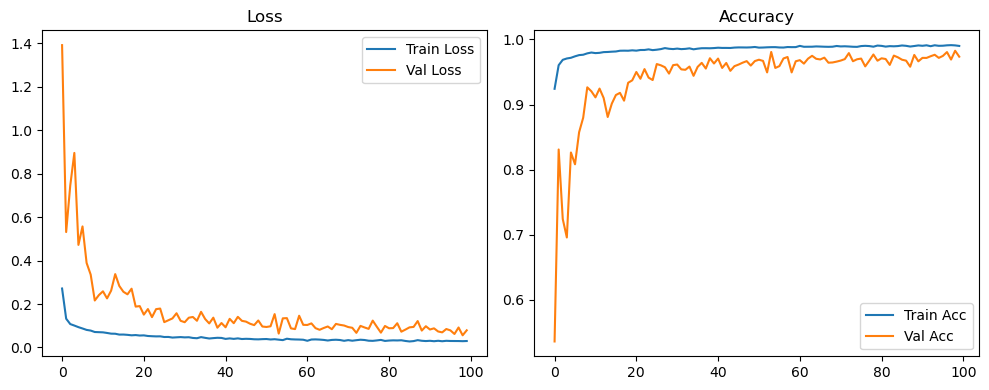

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9595 | Val Loss: 0.0797, Acc: 0.9761


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9851 | Val Loss: 0.0478, Acc: 0.9848


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.0527, Acc: 0.9848


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.0589, Acc: 0.9831


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0532, Acc: 0.9833


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0458, Acc: 0.9865


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0446, Acc: 0.9879


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0631, Acc: 0.9836


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9960 | Val Loss: 0.0577, Acc: 0.9854


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0483, Acc: 0.9880


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0422, Acc: 0.9894


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0475, Acc: 0.9888


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0609, Acc: 0.9863


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0539, Acc: 0.9882


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0547, Acc: 0.9884


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0552, Acc: 0.9892


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0807, Acc: 0.9835


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0598, Acc: 0.9882


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0631, Acc: 0.9872


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0544, Acc: 0.9874


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.0571, Acc: 0.9895


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0669, Acc: 0.9886


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0564, Acc: 0.9881


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0498, Acc: 0.9901


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0573, Acc: 0.9893


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0556, Acc: 0.9911


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0674, Acc: 0.9882


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0513, Acc: 0.9898


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0590, Acc: 0.9894


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0582, Acc: 0.9899


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0597, Acc: 0.9906


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0581, Acc: 0.9901


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0723, Acc: 0.9870


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0662, Acc: 0.9886


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0649, Acc: 0.9894


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0574, Acc: 0.9898


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0647, Acc: 0.9900


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0839, Acc: 0.9877


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0685, Acc: 0.9900


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0571, Acc: 0.9895


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0744, Acc: 0.9896


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0661, Acc: 0.9898


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0689, Acc: 0.9901


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0703, Acc: 0.9908


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0807, Acc: 0.9898


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0681, Acc: 0.9899


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0731, Acc: 0.9899


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0709, Acc: 0.9899


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0733, Acc: 0.9886


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0682, Acc: 0.9896


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0621, Acc: 0.9911


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0547, Acc: 0.9915


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0579, Acc: 0.9918


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0540, Acc: 0.9917


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0540, Acc: 0.9918


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9917


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0566, Acc: 0.9917


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0558, Acc: 0.9918


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0552, Acc: 0.9916


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0547, Acc: 0.9916


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0540, Acc: 0.9916


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0565, Acc: 0.9921


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0559, Acc: 0.9916


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0549, Acc: 0.9918


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0555, Acc: 0.9915


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0627, Acc: 0.9916


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0656, Acc: 0.9914


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0744, Acc: 0.9890


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0735, Acc: 0.9898


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0658, Acc: 0.9913


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0721, Acc: 0.9902


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0634, Acc: 0.9910


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0696, Acc: 0.9906


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0757, Acc: 0.9912


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0707, Acc: 0.9912


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0703, Acc: 0.9911


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0730, Acc: 0.9907


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0697, Acc: 0.9904


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0696, Acc: 0.9908


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0685, Acc: 0.9910


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0668, Acc: 0.9917


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0644, Acc: 0.9917


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0635, Acc: 0.9918


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0650, Acc: 0.9915


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9922


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0658, Acc: 0.9921


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0615, Acc: 0.9922


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0685, Acc: 0.9920


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0647, Acc: 0.9916


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0662, Acc: 0.9913


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0684, Acc: 0.9915


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0649, Acc: 0.9917


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0667, Acc: 0.9920


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0657, Acc: 0.9917


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0655, Acc: 0.9922


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0633, Acc: 0.9923


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0646, Acc: 0.9918


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0696, Acc: 0.9914


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0647, Acc: 0.9912


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0679, Acc: 0.9909


Final Test Loss: 0.0667 Accuracy: 0.9914


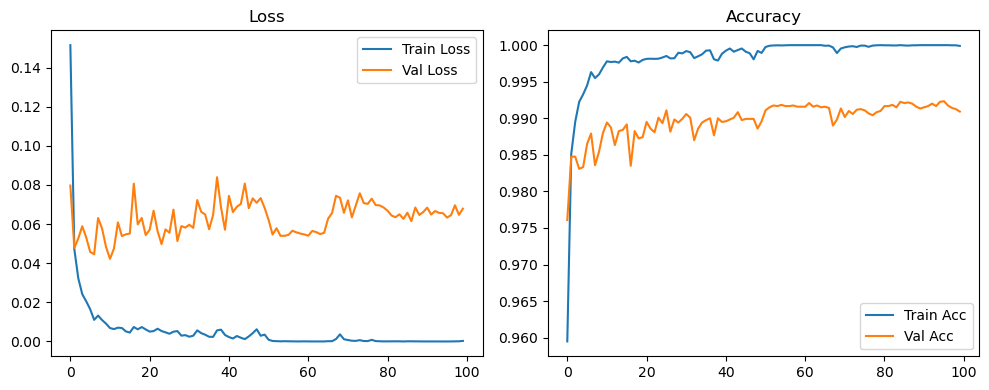

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1782, Acc: 0.9521 | Val Loss: 0.2243, Acc: 0.9276


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9799 | Val Loss: 0.0716, Acc: 0.9795


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9826 | Val Loss: 0.0572, Acc: 0.9826


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9862 | Val Loss: 0.0719, Acc: 0.9771


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9879 | Val Loss: 0.0498, Acc: 0.9846


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9887 | Val Loss: 0.0858, Acc: 0.9729


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.0648, Acc: 0.9807


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.0592, Acc: 0.9838


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9920 | Val Loss: 0.0541, Acc: 0.9844


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9926 | Val Loss: 0.0620, Acc: 0.9818


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.0487, Acc: 0.9852


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9933 | Val Loss: 0.0552, Acc: 0.9858


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0602, Acc: 0.9832


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9936 | Val Loss: 0.0498, Acc: 0.9872


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.0476, Acc: 0.9863


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.0686, Acc: 0.9813


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.0617, Acc: 0.9833


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.0601, Acc: 0.9852


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0536, Acc: 0.9860


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0511, Acc: 0.9868


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9950 | Val Loss: 0.0562, Acc: 0.9859


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0519, Acc: 0.9882


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0473, Acc: 0.9893


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9952 | Val Loss: 0.0585, Acc: 0.9862


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0567, Acc: 0.9861


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0567, Acc: 0.9861


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.0490, Acc: 0.9872


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0578, Acc: 0.9859


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0547, Acc: 0.9872


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0512, Acc: 0.9872


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0528, Acc: 0.9882


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0573, Acc: 0.9866


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0490, Acc: 0.9892


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0543, Acc: 0.9872


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0501, Acc: 0.9878


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0435, Acc: 0.9898


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0531, Acc: 0.9888


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0528, Acc: 0.9889


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0532, Acc: 0.9880


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0542, Acc: 0.9877


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0493, Acc: 0.9892


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0539, Acc: 0.9888


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0550, Acc: 0.9884


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0556, Acc: 0.9884


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0545, Acc: 0.9882


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0490, Acc: 0.9903


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0623, Acc: 0.9868


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.0524, Acc: 0.9886


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0554, Acc: 0.9886


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0466, Acc: 0.9905


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0446, Acc: 0.9902


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0527, Acc: 0.9893


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0465, Acc: 0.9906


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0521, Acc: 0.9898


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0518, Acc: 0.9904


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0462, Acc: 0.9911


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0518, Acc: 0.9906


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0535, Acc: 0.9890


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0577, Acc: 0.9884


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0539, Acc: 0.9898


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0583, Acc: 0.9892


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0511, Acc: 0.9909


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0542, Acc: 0.9895


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0580, Acc: 0.9897


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0495, Acc: 0.9898


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0533, Acc: 0.9902


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0483, Acc: 0.9908


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0539, Acc: 0.9902


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0523, Acc: 0.9897


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0494, Acc: 0.9907


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0549, Acc: 0.9898


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0530, Acc: 0.9886


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0536, Acc: 0.9897


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0581, Acc: 0.9883


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0503, Acc: 0.9906


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0556, Acc: 0.9896


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0496, Acc: 0.9910


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0446, Acc: 0.9917


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0517, Acc: 0.9901


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0498, Acc: 0.9897


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0491, Acc: 0.9908


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0463, Acc: 0.9912


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0463, Acc: 0.9913


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0510, Acc: 0.9908


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0494, Acc: 0.9908


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0493, Acc: 0.9907


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0486, Acc: 0.9910


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0512, Acc: 0.9912


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0448, Acc: 0.9922


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0466, Acc: 0.9916


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0473, Acc: 0.9916


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0546, Acc: 0.9902


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0502, Acc: 0.9909


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0509, Acc: 0.9909


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0535, Acc: 0.9909


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0567, Acc: 0.9910


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0518, Acc: 0.9911


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.0511, Acc: 0.9916


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0516, Acc: 0.9917


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0501, Acc: 0.9917


Final Test Loss: 0.0637 Accuracy: 0.9877


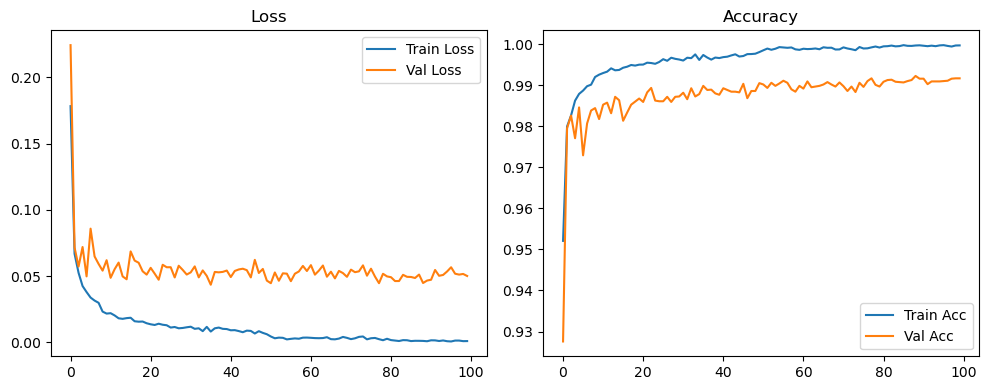

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2713, Acc: 0.9245 | Val Loss: 1.4029, Acc: 0.5279


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1306, Acc: 0.9615 | Val Loss: 0.7834, Acc: 0.7395


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1132, Acc: 0.9668 | Val Loss: 0.7903, Acc: 0.7124


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0993, Acc: 0.9711 | Val Loss: 0.5729, Acc: 0.7979


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0909, Acc: 0.9727 | Val Loss: 0.6627, Acc: 0.7712


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0854, Acc: 0.9735 | Val Loss: 0.4215, Acc: 0.8578


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9770 | Val Loss: 0.3883, Acc: 0.8561


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9772 | Val Loss: 0.4464, Acc: 0.8438


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9793 | Val Loss: 0.2610, Acc: 0.9112


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0705, Acc: 0.9779 | Val Loss: 0.2717, Acc: 0.9133


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9788 | Val Loss: 0.2101, Acc: 0.9291


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9805 | Val Loss: 0.2132, Acc: 0.9269


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9810 | Val Loss: 0.3361, Acc: 0.8879


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9803 | Val Loss: 0.3024, Acc: 0.8969


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9825 | Val Loss: 0.3435, Acc: 0.8830


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9812 | Val Loss: 0.2685, Acc: 0.9129


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9821 | Val Loss: 0.3772, Acc: 0.8760


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9827 | Val Loss: 0.2746, Acc: 0.9092


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9824 | Val Loss: 0.2648, Acc: 0.9123


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9829 | Val Loss: 0.2505, Acc: 0.9183


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9831 | Val Loss: 0.2496, Acc: 0.9188


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9831 | Val Loss: 0.3034, Acc: 0.9004


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9840 | Val Loss: 0.1979, Acc: 0.9369


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9845 | Val Loss: 0.1719, Acc: 0.9452


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9841 | Val Loss: 0.2315, Acc: 0.9231


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9856 | Val Loss: 0.2046, Acc: 0.9348


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9842 | Val Loss: 0.2299, Acc: 0.9219


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9854 | Val Loss: 0.2255, Acc: 0.9255


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9854 | Val Loss: 0.1950, Acc: 0.9388


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9845 | Val Loss: 0.1895, Acc: 0.9389


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9851 | Val Loss: 0.1774, Acc: 0.9414


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9854 | Val Loss: 0.2517, Acc: 0.9215


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 0.1754, Acc: 0.9442


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9866 | Val Loss: 0.1505, Acc: 0.9516


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9864 | Val Loss: 0.1941, Acc: 0.9393


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9858 | Val Loss: 0.2071, Acc: 0.9315


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9863 | Val Loss: 0.2119, Acc: 0.9299


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9862 | Val Loss: 0.1735, Acc: 0.9438


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9874 | Val Loss: 0.1361, Acc: 0.9563


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9864 | Val Loss: 0.1528, Acc: 0.9504


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9870 | Val Loss: 0.1077, Acc: 0.9650


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9866 | Val Loss: 0.2108, Acc: 0.9327


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 0.1613, Acc: 0.9446


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9869 | Val Loss: 0.1637, Acc: 0.9428


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9874 | Val Loss: 0.1335, Acc: 0.9545


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9883 | Val Loss: 0.1570, Acc: 0.9478


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9886 | Val Loss: 0.1840, Acc: 0.9409


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9884 | Val Loss: 0.1522, Acc: 0.9499


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.1732, Acc: 0.9437


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9881 | Val Loss: 0.1435, Acc: 0.9527


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9892 | Val Loss: 0.1289, Acc: 0.9551


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9905 | Val Loss: 0.1306, Acc: 0.9581


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.1432, Acc: 0.9549


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9902 | Val Loss: 0.0965, Acc: 0.9698


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.1364, Acc: 0.9551


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9908 | Val Loss: 0.1169, Acc: 0.9627


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1137, Acc: 0.9617


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9914 | Val Loss: 0.1488, Acc: 0.9493


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9912 | Val Loss: 0.1230, Acc: 0.9603


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.1219, Acc: 0.9604


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.1060, Acc: 0.9643


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.0831, Acc: 0.9745


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9919 | Val Loss: 0.0964, Acc: 0.9705


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9912 | Val Loss: 0.1044, Acc: 0.9669


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9916 | Val Loss: 0.1217, Acc: 0.9613


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.1086, Acc: 0.9653


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.1030, Acc: 0.9679


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.1211, Acc: 0.9585


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9922 | Val Loss: 0.1005, Acc: 0.9675


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9921 | Val Loss: 0.1074, Acc: 0.9652


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9916 | Val Loss: 0.1011, Acc: 0.9688


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.1145, Acc: 0.9633


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.1077, Acc: 0.9659


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9914 | Val Loss: 0.1162, Acc: 0.9617


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.0908, Acc: 0.9709


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9922 | Val Loss: 0.0989, Acc: 0.9677


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.1054, Acc: 0.9649


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9913 | Val Loss: 0.1043, Acc: 0.9649


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.0971, Acc: 0.9670


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9918 | Val Loss: 0.0888, Acc: 0.9711


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9917 | Val Loss: 0.0934, Acc: 0.9722


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0873, Acc: 0.9737


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0916, Acc: 0.9716


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9935 | Val Loss: 0.0847, Acc: 0.9732


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9935 | Val Loss: 0.0899, Acc: 0.9714


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.0872, Acc: 0.9719


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0795, Acc: 0.9744


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0866, Acc: 0.9721


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0797, Acc: 0.9742


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.0928, Acc: 0.9692


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.1062, Acc: 0.9653


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.0922, Acc: 0.9700


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0997, Acc: 0.9687


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.0950, Acc: 0.9687


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.0880, Acc: 0.9705


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9939 | Val Loss: 0.0901, Acc: 0.9718


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0749, Acc: 0.9773


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9931 | Val Loss: 0.0971, Acc: 0.9702


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0844, Acc: 0.9734


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.0812, Acc: 0.9737


Final Test Loss: 0.0809 Accuracy: 0.9743


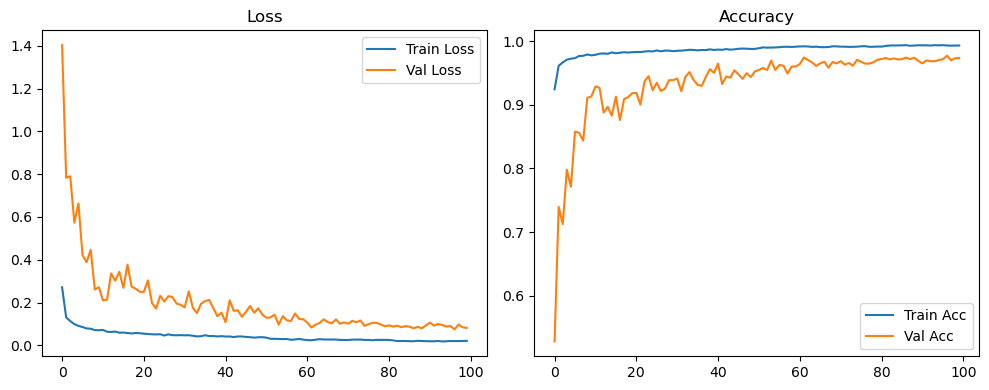

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1520, Acc: 0.9593 | Val Loss: 0.0726, Acc: 0.9769


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9850 | Val Loss: 0.0471, Acc: 0.9852


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9894 | Val Loss: 0.0508, Acc: 0.9851


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.0593, Acc: 0.9818


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.0483, Acc: 0.9860


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.0521, Acc: 0.9865


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.0394, Acc: 0.9890


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0482, Acc: 0.9887


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0478, Acc: 0.9882


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.0570, Acc: 0.9878


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0476, Acc: 0.9889


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0452, Acc: 0.9887


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0436, Acc: 0.9908


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0516, Acc: 0.9886


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0552, Acc: 0.9885


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0571, Acc: 0.9878


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0551, Acc: 0.9896


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0535, Acc: 0.9898


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0687, Acc: 0.9856


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0611, Acc: 0.9871


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0591, Acc: 0.9880


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0523, Acc: 0.9886


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0673, Acc: 0.9882


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0599, Acc: 0.9895


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.0581, Acc: 0.9902


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0762, Acc: 0.9874


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0717, Acc: 0.9883


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0724, Acc: 0.9879


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0638, Acc: 0.9889


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0734, Acc: 0.9870


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0664, Acc: 0.9881


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.0847, Acc: 0.9861


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0645, Acc: 0.9889


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0674, Acc: 0.9899


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0694, Acc: 0.9887


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0648, Acc: 0.9897


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0668, Acc: 0.9895


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0660, Acc: 0.9902


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0724, Acc: 0.9893


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0609, Acc: 0.9911


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0652, Acc: 0.9900


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0668, Acc: 0.9894


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0706, Acc: 0.9902


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0789, Acc: 0.9891


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0719, Acc: 0.9898


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0694, Acc: 0.9900


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0668, Acc: 0.9908


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0767, Acc: 0.9890


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0735, Acc: 0.9892


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0800, Acc: 0.9891


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0684, Acc: 0.9911


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0675, Acc: 0.9916


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0670, Acc: 0.9918


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0641, Acc: 0.9915


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0684, Acc: 0.9908


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0661, Acc: 0.9909


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9923


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0660, Acc: 0.9912


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0646, Acc: 0.9918


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9921


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0633, Acc: 0.9916


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0632, Acc: 0.9924


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0590, Acc: 0.9916


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0657, Acc: 0.9916


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0835, Acc: 0.9891


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0710, Acc: 0.9898


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0669, Acc: 0.9911


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0670, Acc: 0.9909


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0706, Acc: 0.9918


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0637, Acc: 0.9922


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9924


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0723, Acc: 0.9917


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0687, Acc: 0.9913


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0677, Acc: 0.9913


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0766, Acc: 0.9912


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0758, Acc: 0.9912


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0757, Acc: 0.9911


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0700, Acc: 0.9912


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0679, Acc: 0.9918


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0666, Acc: 0.9921


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0609, Acc: 0.9921


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0608, Acc: 0.9928


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0605, Acc: 0.9928


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9931


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0618, Acc: 0.9927


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9932


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0609, Acc: 0.9930


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0628, Acc: 0.9924


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9925


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9921


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0630, Acc: 0.9923


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0631, Acc: 0.9928


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0632, Acc: 0.9921


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9924


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0639, Acc: 0.9920


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0643, Acc: 0.9922


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0640, Acc: 0.9922


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0651, Acc: 0.9916


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0644, Acc: 0.9924


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0646, Acc: 0.9918


Final Test Loss: 0.0616 Accuracy: 0.9912


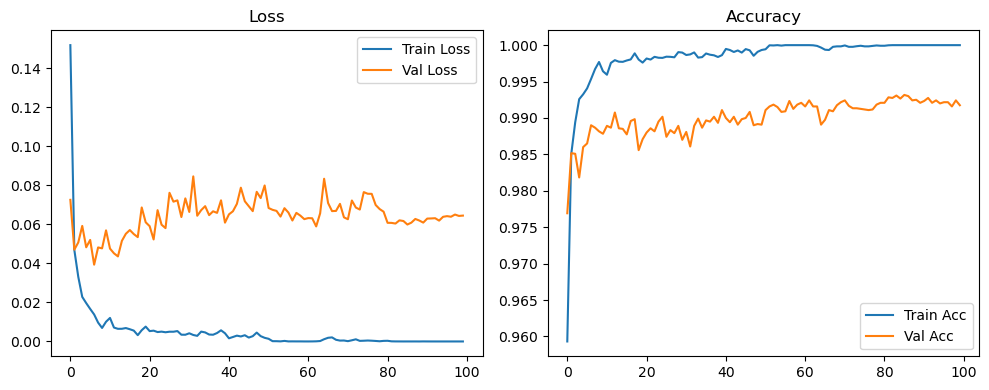

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1790, Acc: 0.9519 | Val Loss: 0.2352, Acc: 0.9250


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9792 | Val Loss: 0.0665, Acc: 0.9807


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9835 | Val Loss: 0.0667, Acc: 0.9801


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9864 | Val Loss: 0.0713, Acc: 0.9780


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9886 | Val Loss: 0.0615, Acc: 0.9811


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9891 | Val Loss: 0.0557, Acc: 0.9832


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9899 | Val Loss: 0.0531, Acc: 0.9828


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.0580, Acc: 0.9837


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.0506, Acc: 0.9857


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.0549, Acc: 0.9838


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9923 | Val Loss: 0.0420, Acc: 0.9874


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0559, Acc: 0.9855


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.0492, Acc: 0.9868


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0567, Acc: 0.9850


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9943 | Val Loss: 0.0479, Acc: 0.9874


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0696, Acc: 0.9826


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0541, Acc: 0.9860


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0441, Acc: 0.9878


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.0463, Acc: 0.9875


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.0503, Acc: 0.9872


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0473, Acc: 0.9882


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0486, Acc: 0.9874


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0476, Acc: 0.9879


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0474, Acc: 0.9881


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0459, Acc: 0.9889


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0612, Acc: 0.9848


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0596, Acc: 0.9865


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0552, Acc: 0.9862


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0594, Acc: 0.9853


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.0503, Acc: 0.9868


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0542, Acc: 0.9869


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0562, Acc: 0.9865


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0484, Acc: 0.9881


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0614, Acc: 0.9862


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9971 | Val Loss: 0.0528, Acc: 0.9884


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0509, Acc: 0.9887


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0484, Acc: 0.9892


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0637, Acc: 0.9860


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0557, Acc: 0.9876


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0488, Acc: 0.9899


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0586, Acc: 0.9859


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0503, Acc: 0.9893


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0491, Acc: 0.9890


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0570, Acc: 0.9868


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.0593, Acc: 0.9868


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0461, Acc: 0.9897


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0529, Acc: 0.9890


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0432, Acc: 0.9907


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0447, Acc: 0.9908


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0475, Acc: 0.9900


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0494, Acc: 0.9901


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0481, Acc: 0.9906


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0514, Acc: 0.9901


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0475, Acc: 0.9908


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0527, Acc: 0.9892


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0454, Acc: 0.9911


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0485, Acc: 0.9914


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0482, Acc: 0.9905


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0433, Acc: 0.9916


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0488, Acc: 0.9908


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0516, Acc: 0.9900


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0527, Acc: 0.9902


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0530, Acc: 0.9902


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0506, Acc: 0.9901


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0513, Acc: 0.9912


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0519, Acc: 0.9907


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0576, Acc: 0.9894


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0488, Acc: 0.9905


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0572, Acc: 0.9895


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0542, Acc: 0.9896


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0520, Acc: 0.9899


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0567, Acc: 0.9904


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0542, Acc: 0.9895


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0619, Acc: 0.9899


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0618, Acc: 0.9882


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0571, Acc: 0.9898


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0609, Acc: 0.9892


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0527, Acc: 0.9901


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0526, Acc: 0.9908


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0556, Acc: 0.9906


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0537, Acc: 0.9909


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0515, Acc: 0.9915


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0511, Acc: 0.9911


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0487, Acc: 0.9916


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0516, Acc: 0.9913


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0517, Acc: 0.9916


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0529, Acc: 0.9915


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0519, Acc: 0.9909


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0506, Acc: 0.9914


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0502, Acc: 0.9914


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0534, Acc: 0.9911


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0484, Acc: 0.9918


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0491, Acc: 0.9917


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0502, Acc: 0.9915


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0536, Acc: 0.9911


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0532, Acc: 0.9907


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0514, Acc: 0.9917


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0572, Acc: 0.9907


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0509, Acc: 0.9905


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0484, Acc: 0.9916


Final Test Loss: 0.0481 Accuracy: 0.9902


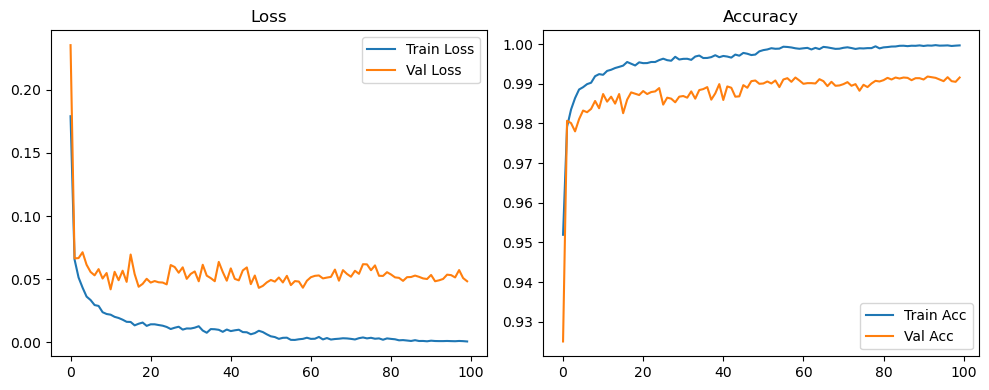

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2711, Acc: 0.9245 | Val Loss: 1.9575, Acc: 0.4128


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1317, Acc: 0.9616 | Val Loss: 0.8177, Acc: 0.7334


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1095, Acc: 0.9667 | Val Loss: 0.5017, Acc: 0.8145


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0979, Acc: 0.9713 | Val Loss: 1.1997, Acc: 0.6070


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0920, Acc: 0.9728 | Val Loss: 0.4828, Acc: 0.8350


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0857, Acc: 0.9744 | Val Loss: 0.4229, Acc: 0.8586


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9771 | Val Loss: 0.2844, Acc: 0.9012


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9766 | Val Loss: 0.3115, Acc: 0.8957


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9772 | Val Loss: 0.1979, Acc: 0.9320


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9787 | Val Loss: 0.3019, Acc: 0.8979


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9788 | Val Loss: 0.1877, Acc: 0.9414


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0658, Acc: 0.9795 | Val Loss: 0.2290, Acc: 0.9205


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9819 | Val Loss: 0.2035, Acc: 0.9313


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9818 | Val Loss: 0.1187, Acc: 0.9637


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9809 | Val Loss: 0.2554, Acc: 0.9157


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9815 | Val Loss: 0.1402, Acc: 0.9536


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9826 | Val Loss: 0.1464, Acc: 0.9545


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9833 | Val Loss: 0.1719, Acc: 0.9415


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9830 | Val Loss: 0.2108, Acc: 0.9300


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9834 | Val Loss: 0.2154, Acc: 0.9247


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9834 | Val Loss: 0.1420, Acc: 0.9537


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9832 | Val Loss: 0.1566, Acc: 0.9506


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9843 | Val Loss: 0.1210, Acc: 0.9623


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9835 | Val Loss: 0.2046, Acc: 0.9313


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9840 | Val Loss: 0.1244, Acc: 0.9592


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9848 | Val Loss: 0.1377, Acc: 0.9563


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9851 | Val Loss: 0.1509, Acc: 0.9534


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9853 | Val Loss: 0.1468, Acc: 0.9527


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9858 | Val Loss: 0.1659, Acc: 0.9471


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9855 | Val Loss: 0.1268, Acc: 0.9589


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9858 | Val Loss: 0.1298, Acc: 0.9565


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9857 | Val Loss: 0.1541, Acc: 0.9520


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9851 | Val Loss: 0.1344, Acc: 0.9569


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9854 | Val Loss: 0.1121, Acc: 0.9639


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9862 | Val Loss: 0.1669, Acc: 0.9431


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9874 | Val Loss: 0.1362, Acc: 0.9567


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9870 | Val Loss: 0.1156, Acc: 0.9631


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9868 | Val Loss: 0.1412, Acc: 0.9535


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9866 | Val Loss: 0.1488, Acc: 0.9487


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9871 | Val Loss: 0.1082, Acc: 0.9659


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9873 | Val Loss: 0.1055, Acc: 0.9663


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9870 | Val Loss: 0.1291, Acc: 0.9579


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9869 | Val Loss: 0.0979, Acc: 0.9689


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9870 | Val Loss: 0.1216, Acc: 0.9601


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9869 | Val Loss: 0.0880, Acc: 0.9718


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9876 | Val Loss: 0.1100, Acc: 0.9635


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9871 | Val Loss: 0.1513, Acc: 0.9505


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9878 | Val Loss: 0.0820, Acc: 0.9757


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9877 | Val Loss: 0.1213, Acc: 0.9604


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9890 | Val Loss: 0.0995, Acc: 0.9687


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.0841, Acc: 0.9729


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9901 | Val Loss: 0.0798, Acc: 0.9742


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.0814, Acc: 0.9741


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9906 | Val Loss: 0.0658, Acc: 0.9797


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.0857, Acc: 0.9744


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9907 | Val Loss: 0.0902, Acc: 0.9708


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0788, Acc: 0.9747


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0986, Acc: 0.9680


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0751, Acc: 0.9774


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9917 | Val Loss: 0.0789, Acc: 0.9741


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9919 | Val Loss: 0.1097, Acc: 0.9642


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0714, Acc: 0.9777


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.0834, Acc: 0.9745


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 0.0837, Acc: 0.9732


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0884, Acc: 0.9711


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9911 | Val Loss: 0.0894, Acc: 0.9708


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9904 | Val Loss: 0.0849, Acc: 0.9732


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9916 | Val Loss: 0.0683, Acc: 0.9792


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.0927, Acc: 0.9715


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9916 | Val Loss: 0.0747, Acc: 0.9772


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.0720, Acc: 0.9778


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9910 | Val Loss: 0.0803, Acc: 0.9741


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9914 | Val Loss: 0.0783, Acc: 0.9745


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9916 | Val Loss: 0.0836, Acc: 0.9709


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.0675, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9916 | Val Loss: 0.0751, Acc: 0.9760


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0831, Acc: 0.9754


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0804, Acc: 0.9749


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9916 | Val Loss: 0.0670, Acc: 0.9798


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9920 | Val Loss: 0.0815, Acc: 0.9746


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9925 | Val Loss: 0.0798, Acc: 0.9752


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9930 | Val Loss: 0.0642, Acc: 0.9806


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0672, Acc: 0.9796


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0685, Acc: 0.9781


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0678, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9932 | Val Loss: 0.0794, Acc: 0.9728


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0704, Acc: 0.9772


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.0703, Acc: 0.9772


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.0769, Acc: 0.9747


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0796, Acc: 0.9741


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.0849, Acc: 0.9716


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0771, Acc: 0.9753


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.0759, Acc: 0.9762


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.0832, Acc: 0.9727


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0779, Acc: 0.9738


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0759, Acc: 0.9763


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0727, Acc: 0.9753


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.0765, Acc: 0.9752


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.0721, Acc: 0.9768


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0681, Acc: 0.9780


Final Test Loss: 0.0680 Accuracy: 0.9769


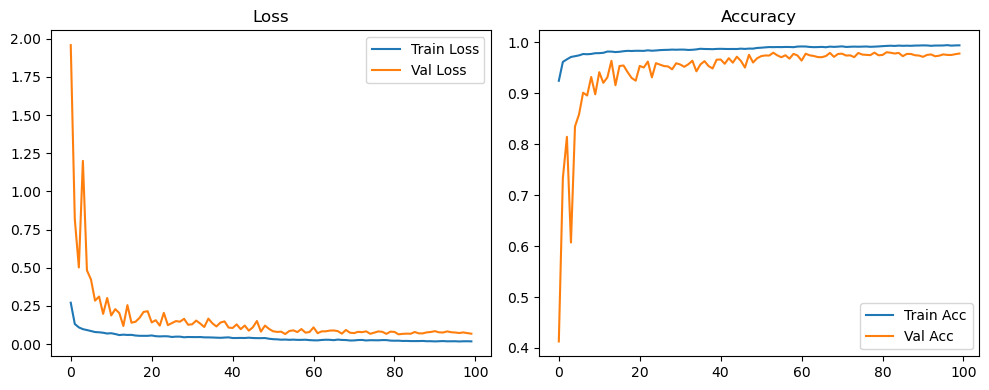

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1497, Acc: 0.9599 | Val Loss: 0.0976, Acc: 0.9684


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9851 | Val Loss: 0.0402, Acc: 0.9878


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9892 | Val Loss: 0.0612, Acc: 0.9820


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.0565, Acc: 0.9844


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0445, Acc: 0.9868


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0617, Acc: 0.9804


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9954 | Val Loss: 0.0787, Acc: 0.9791


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0470, Acc: 0.9870


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0495, Acc: 0.9863


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0498, Acc: 0.9869


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0548, Acc: 0.9864


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.0516, Acc: 0.9878


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0545, Acc: 0.9878


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0454, Acc: 0.9898


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0519, Acc: 0.9892


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0529, Acc: 0.9878


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0691, Acc: 0.9853


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.0512, Acc: 0.9891


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0549, Acc: 0.9887


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0553, Acc: 0.9898


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0553, Acc: 0.9892


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0578, Acc: 0.9892


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0772, Acc: 0.9862


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0701, Acc: 0.9883


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0761, Acc: 0.9862


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0713, Acc: 0.9851


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0613, Acc: 0.9890


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0564, Acc: 0.9898


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0571, Acc: 0.9903


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0657, Acc: 0.9889


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0712, Acc: 0.9884


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0565, Acc: 0.9895


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0606, Acc: 0.9888


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0587, Acc: 0.9901


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0623, Acc: 0.9906


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.0665, Acc: 0.9888


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0749, Acc: 0.9882


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.0764, Acc: 0.9875


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0822, Acc: 0.9882


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0630, Acc: 0.9899


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0676, Acc: 0.9887


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0598, Acc: 0.9898


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0705, Acc: 0.9893


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0627, Acc: 0.9914


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0609, Acc: 0.9908


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0765, Acc: 0.9892


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0657, Acc: 0.9903


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0791, Acc: 0.9888


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0733, Acc: 0.9896


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0704, Acc: 0.9892


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0634, Acc: 0.9902


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0570, Acc: 0.9909


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0583, Acc: 0.9905


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0603, Acc: 0.9908


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9918


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0602, Acc: 0.9912


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0578, Acc: 0.9918


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9917


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0608, Acc: 0.9912


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0596, Acc: 0.9918


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9914


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0583, Acc: 0.9919


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0593, Acc: 0.9917


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9921


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9917


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0589, Acc: 0.9919


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9918


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0573, Acc: 0.9920


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0593, Acc: 0.9917


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0585, Acc: 0.9922


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0575, Acc: 0.9918


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0604, Acc: 0.9920


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0572, Acc: 0.9913


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9913


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0598, Acc: 0.9919


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0588, Acc: 0.9918


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0637, Acc: 0.9908


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0655, Acc: 0.9914


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9916


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0786, Acc: 0.9889


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9912


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9918


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9918


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9914


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0643, Acc: 0.9913


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0608, Acc: 0.9912


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0604, Acc: 0.9914


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0604, Acc: 0.9915


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0605, Acc: 0.9918


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0655, Acc: 0.9908


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0629, Acc: 0.9917


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9922


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0587, Acc: 0.9918


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0590, Acc: 0.9921


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0576, Acc: 0.9926


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0630, Acc: 0.9920


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0588, Acc: 0.9928


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0603, Acc: 0.9921


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0595, Acc: 0.9920


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0595, Acc: 0.9922


Final Test Loss: 0.0562 Accuracy: 0.9910


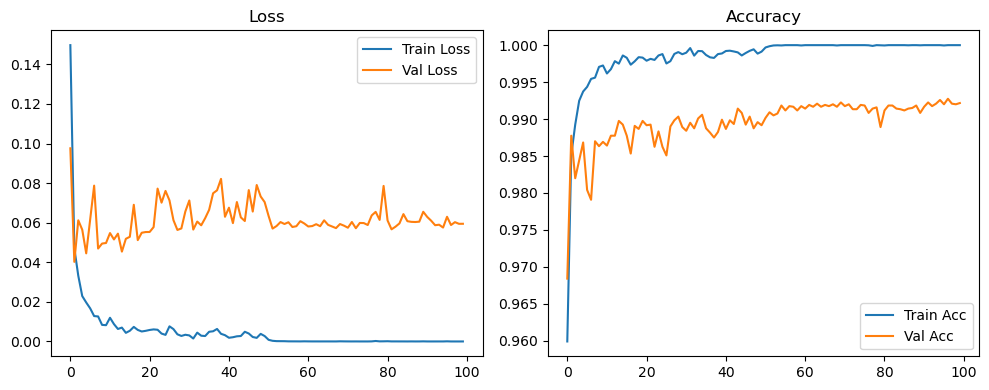

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1791, Acc: 0.9521 | Val Loss: 0.2244, Acc: 0.9273


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9799 | Val Loss: 0.0674, Acc: 0.9790


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9835 | Val Loss: 0.0588, Acc: 0.9830


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9856 | Val Loss: 0.0581, Acc: 0.9833


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9883 | Val Loss: 0.0620, Acc: 0.9802


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9895 | Val Loss: 0.0644, Acc: 0.9790


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9904 | Val Loss: 0.0509, Acc: 0.9855


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.0506, Acc: 0.9848


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0514, Acc: 0.9842


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.0641, Acc: 0.9830


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.0526, Acc: 0.9842


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0534, Acc: 0.9848


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0486, Acc: 0.9865


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0565, Acc: 0.9852


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9940 | Val Loss: 0.0539, Acc: 0.9854


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0484, Acc: 0.9868


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0458, Acc: 0.9877


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0550, Acc: 0.9853


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0432, Acc: 0.9881


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.0441, Acc: 0.9882


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0600, Acc: 0.9841


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9948 | Val Loss: 0.0591, Acc: 0.9845


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0606, Acc: 0.9842


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0495, Acc: 0.9874


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.0490, Acc: 0.9877


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0518, Acc: 0.9880


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.0552, Acc: 0.9867


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0498, Acc: 0.9887


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0701, Acc: 0.9852


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0573, Acc: 0.9867


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0546, Acc: 0.9868


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0572, Acc: 0.9877


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0496, Acc: 0.9884


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0558, Acc: 0.9871


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0618, Acc: 0.9864


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0580, Acc: 0.9888


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0451, Acc: 0.9892


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.0512, Acc: 0.9885


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.0547, Acc: 0.9874


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0526, Acc: 0.9874


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0481, Acc: 0.9893


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0516, Acc: 0.9889


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0494, Acc: 0.9895


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0528, Acc: 0.9893


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0538, Acc: 0.9897


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0514, Acc: 0.9895


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0518, Acc: 0.9879


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0463, Acc: 0.9907


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0599, Acc: 0.9878


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0518, Acc: 0.9899


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0439, Acc: 0.9919


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0429, Acc: 0.9908


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0427, Acc: 0.9918


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0438, Acc: 0.9912


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0446, Acc: 0.9911


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0447, Acc: 0.9914


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0446, Acc: 0.9912


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0475, Acc: 0.9910


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0466, Acc: 0.9912


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0418, Acc: 0.9918


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0493, Acc: 0.9912


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0468, Acc: 0.9909


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0432, Acc: 0.9923


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0426, Acc: 0.9928


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0502, Acc: 0.9904


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0473, Acc: 0.9907


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0445, Acc: 0.9925


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0440, Acc: 0.9918


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0464, Acc: 0.9914


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0442, Acc: 0.9922


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0483, Acc: 0.9908


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0510, Acc: 0.9907


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0498, Acc: 0.9918


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0495, Acc: 0.9910


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0495, Acc: 0.9902


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0482, Acc: 0.9918


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0473, Acc: 0.9908


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0475, Acc: 0.9922


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0490, Acc: 0.9916


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0494, Acc: 0.9920


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0481, Acc: 0.9922


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0449, Acc: 0.9923


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0460, Acc: 0.9922


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0442, Acc: 0.9926


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.0491, Acc: 0.9920


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0487, Acc: 0.9920


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0469, Acc: 0.9920


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0498, Acc: 0.9921


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0510, Acc: 0.9913


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0480, Acc: 0.9920


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0509, Acc: 0.9920


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0522, Acc: 0.9914


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0457, Acc: 0.9928


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0470, Acc: 0.9931


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0496, Acc: 0.9919


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0476, Acc: 0.9920


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0497, Acc: 0.9921


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0494, Acc: 0.9918


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0512, Acc: 0.9921


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0506, Acc: 0.9924


Final Test Loss: 0.0500 Accuracy: 0.9911


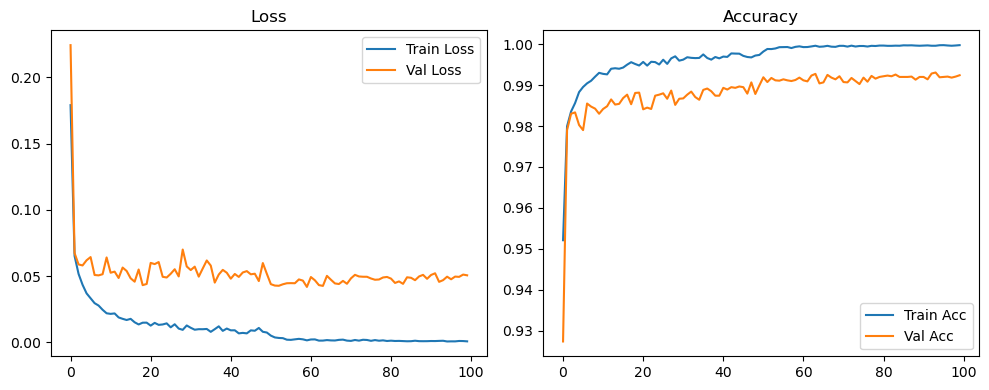

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2701, Acc: 0.9257 | Val Loss: 2.2074, Acc: 0.3789


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1289, Acc: 0.9616 | Val Loss: 0.7653, Acc: 0.7450


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1112, Acc: 0.9675 | Val Loss: 0.6412, Acc: 0.7612


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1001, Acc: 0.9707 | Val Loss: 0.7998, Acc: 0.7228


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0924, Acc: 0.9724 | Val Loss: 0.4139, Acc: 0.8522


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9756 | Val Loss: 0.4980, Acc: 0.8269


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9765 | Val Loss: 0.3046, Acc: 0.8911


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9772 | Val Loss: 0.2470, Acc: 0.9168


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9780 | Val Loss: 0.2072, Acc: 0.9335


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0708, Acc: 0.9793 | Val Loss: 0.2299, Acc: 0.9228


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9790 | Val Loss: 0.2725, Acc: 0.9043


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9798 | Val Loss: 0.1883, Acc: 0.9351


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9809 | Val Loss: 0.1558, Acc: 0.9481


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9808 | Val Loss: 0.2836, Acc: 0.9013


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9823 | Val Loss: 0.3745, Acc: 0.8714


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9809 | Val Loss: 0.2960, Acc: 0.8975


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9816 | Val Loss: 0.2608, Acc: 0.9158


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9832 | Val Loss: 0.2356, Acc: 0.9202


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9834 | Val Loss: 0.2131, Acc: 0.9253


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9825 | Val Loss: 0.2035, Acc: 0.9296


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9833 | Val Loss: 0.1611, Acc: 0.9433


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9831 | Val Loss: 0.1661, Acc: 0.9441


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9847 | Val Loss: 0.1426, Acc: 0.9539


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9837 | Val Loss: 0.2404, Acc: 0.9164


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9837 | Val Loss: 0.1808, Acc: 0.9383


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9859 | Val Loss: 0.1591, Acc: 0.9440


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9843 | Val Loss: 0.1635, Acc: 0.9457


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9857 | Val Loss: 0.1601, Acc: 0.9479


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9855 | Val Loss: 0.1790, Acc: 0.9388


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9850 | Val Loss: 0.2072, Acc: 0.9293


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9861 | Val Loss: 0.1463, Acc: 0.9498


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9860 | Val Loss: 0.1664, Acc: 0.9453


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9861 | Val Loss: 0.1556, Acc: 0.9496


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.1747, Acc: 0.9427


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9856 | Val Loss: 0.1158, Acc: 0.9636


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9855 | Val Loss: 0.1930, Acc: 0.9348


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9866 | Val Loss: 0.1345, Acc: 0.9561


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9861 | Val Loss: 0.1937, Acc: 0.9347


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9873 | Val Loss: 0.1197, Acc: 0.9606


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9865 | Val Loss: 0.2110, Acc: 0.9277


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9874 | Val Loss: 0.1425, Acc: 0.9523


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9867 | Val Loss: 0.1706, Acc: 0.9425


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9868 | Val Loss: 0.1319, Acc: 0.9554


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 0.1163, Acc: 0.9621


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9870 | Val Loss: 0.1216, Acc: 0.9588


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9877 | Val Loss: 0.1598, Acc: 0.9456


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9876 | Val Loss: 0.1587, Acc: 0.9491


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9883 | Val Loss: 0.1401, Acc: 0.9539


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.1666, Acc: 0.9447


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9886 | Val Loss: 0.1418, Acc: 0.9509


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9899 | Val Loss: 0.1301, Acc: 0.9574


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 0.1454, Acc: 0.9503


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.1131, Acc: 0.9634


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.1084, Acc: 0.9651


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9912 | Val Loss: 0.1142, Acc: 0.9628


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.1051, Acc: 0.9663


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0978, Acc: 0.9692


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1113, Acc: 0.9634


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9925 | Val Loss: 0.1076, Acc: 0.9655


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.0931, Acc: 0.9699


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9923 | Val Loss: 0.1010, Acc: 0.9677


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.0904, Acc: 0.9709


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9923 | Val Loss: 0.0945, Acc: 0.9692


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0917, Acc: 0.9706


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9913 | Val Loss: 0.1136, Acc: 0.9630


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9927 | Val Loss: 0.0975, Acc: 0.9688


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9918 | Val Loss: 0.0906, Acc: 0.9710


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9922 | Val Loss: 0.0969, Acc: 0.9688


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.1004, Acc: 0.9667


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9926 | Val Loss: 0.1023, Acc: 0.9662


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9924 | Val Loss: 0.0809, Acc: 0.9749


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9930 | Val Loss: 0.0937, Acc: 0.9689


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.1064, Acc: 0.9656


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9934 | Val Loss: 0.1005, Acc: 0.9672


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.1046, Acc: 0.9665


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0821, Acc: 0.9738


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 0.1066, Acc: 0.9641


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0945, Acc: 0.9692


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.0910, Acc: 0.9719


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.0859, Acc: 0.9729


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0925, Acc: 0.9709


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9932 | Val Loss: 0.0852, Acc: 0.9732


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9933 | Val Loss: 0.0898, Acc: 0.9710


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0829, Acc: 0.9738


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9929 | Val Loss: 0.0817, Acc: 0.9745


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9933 | Val Loss: 0.0950, Acc: 0.9698


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.0831, Acc: 0.9733


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9941 | Val Loss: 0.0789, Acc: 0.9750


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.0784, Acc: 0.9767


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0793, Acc: 0.9747


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.0885, Acc: 0.9726


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9930 | Val Loss: 0.0817, Acc: 0.9742


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0860, Acc: 0.9719


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0806, Acc: 0.9745


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.0837, Acc: 0.9734


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0937, Acc: 0.9707


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0754, Acc: 0.9772


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 0.0850, Acc: 0.9728


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0765, Acc: 0.9767


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0646, Acc: 0.9806


Final Test Loss: 0.0638 Accuracy: 0.9786


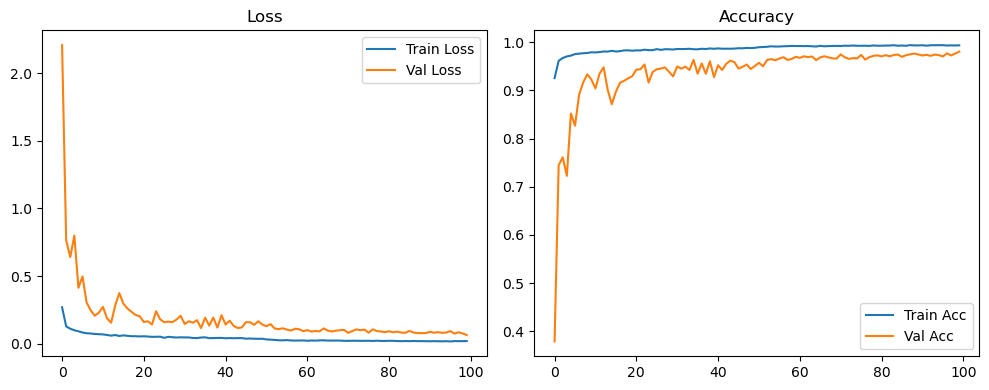

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1685, Acc: 0.9626 | Val Loss: 0.0752, Acc: 0.9764


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9859 | Val Loss: 0.0415, Acc: 0.9872


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9903 | Val Loss: 0.0434, Acc: 0.9861


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9937 | Val Loss: 0.0482, Acc: 0.9864


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0444, Acc: 0.9874


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0408, Acc: 0.9882


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.0394, Acc: 0.9887


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0392, Acc: 0.9883


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0438, Acc: 0.9878


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0509, Acc: 0.9867


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.0616, Acc: 0.9839


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0512, Acc: 0.9863


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0405, Acc: 0.9896


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0412, Acc: 0.9896


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0537, Acc: 0.9874


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9979 | Val Loss: 0.0498, Acc: 0.9887


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0571, Acc: 0.9882


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0552, Acc: 0.9871


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0524, Acc: 0.9860


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0706, Acc: 0.9840


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0466, Acc: 0.9898


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0457, Acc: 0.9902


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0485, Acc: 0.9888


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0538, Acc: 0.9889


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0448, Acc: 0.9899


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0533, Acc: 0.9888


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0532, Acc: 0.9896


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0611, Acc: 0.9866


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0600, Acc: 0.9871


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0498, Acc: 0.9906


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0489, Acc: 0.9896


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0487, Acc: 0.9890


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0496, Acc: 0.9898


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0476, Acc: 0.9898


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0501, Acc: 0.9894


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0602, Acc: 0.9869


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0591, Acc: 0.9887


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0622, Acc: 0.9873


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0524, Acc: 0.9903


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0556, Acc: 0.9903


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0503, Acc: 0.9910


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0471, Acc: 0.9914


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0490, Acc: 0.9908


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0556, Acc: 0.9903


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0626, Acc: 0.9882


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0573, Acc: 0.9898


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0496, Acc: 0.9918


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0579, Acc: 0.9891


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0551, Acc: 0.9896


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0643, Acc: 0.9888


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0628, Acc: 0.9890


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0601, Acc: 0.9889


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0536, Acc: 0.9902


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0534, Acc: 0.9898


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0584, Acc: 0.9908


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0566, Acc: 0.9907


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0558, Acc: 0.9902


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0483, Acc: 0.9918


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0521, Acc: 0.9902


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0490, Acc: 0.9912


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9919


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0496, Acc: 0.9918


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9916


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0575, Acc: 0.9900


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0809, Acc: 0.9879


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0643, Acc: 0.9887


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0678, Acc: 0.9895


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0626, Acc: 0.9896


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0682, Acc: 0.9896


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0657, Acc: 0.9895


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0637, Acc: 0.9904


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0656, Acc: 0.9900


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0576, Acc: 0.9910


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0633, Acc: 0.9907


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0650, Acc: 0.9910


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0653, Acc: 0.9910


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0614, Acc: 0.9913


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0750, Acc: 0.9889


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0652, Acc: 0.9902


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0655, Acc: 0.9908


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0613, Acc: 0.9910


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0635, Acc: 0.9902


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0583, Acc: 0.9912


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0565, Acc: 0.9912


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0571, Acc: 0.9912


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0549, Acc: 0.9918


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0610, Acc: 0.9902


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0609, Acc: 0.9911


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0590, Acc: 0.9898


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0646, Acc: 0.9903


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0652, Acc: 0.9907


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0689, Acc: 0.9902


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0764, Acc: 0.9894


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0600, Acc: 0.9914


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0673, Acc: 0.9900


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0613, Acc: 0.9908


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0573, Acc: 0.9914


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0619, Acc: 0.9914


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0721, Acc: 0.9896


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0649, Acc: 0.9898


Final Test Loss: 0.0680 Accuracy: 0.9893


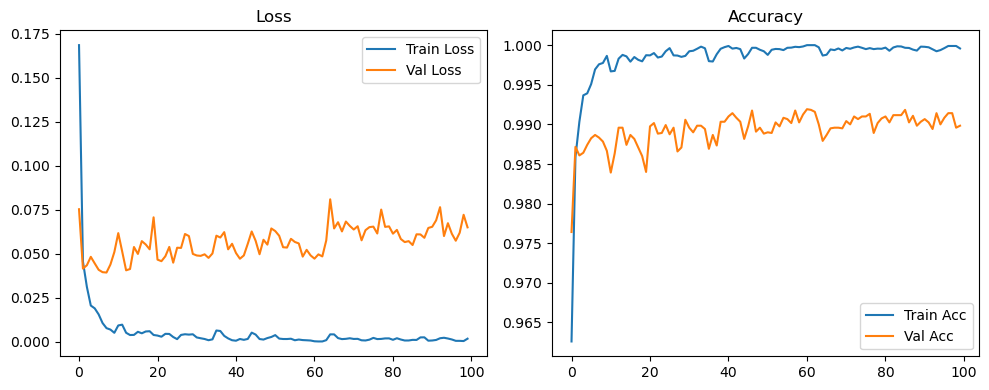

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1982, Acc: 0.9541 | Val Loss: 0.2111, Acc: 0.9325


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0631, Acc: 0.9806 | Val Loss: 0.0618, Acc: 0.9828


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9844 | Val Loss: 0.0725, Acc: 0.9779


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9870 | Val Loss: 0.0655, Acc: 0.9792


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9895 | Val Loss: 0.0568, Acc: 0.9823


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9896 | Val Loss: 0.0671, Acc: 0.9786


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9911 | Val Loss: 0.0433, Acc: 0.9859


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0692, Acc: 0.9783


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.0339, Acc: 0.9906


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.0480, Acc: 0.9857


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0518, Acc: 0.9846


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9932 | Val Loss: 0.0499, Acc: 0.9859


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0439, Acc: 0.9871


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9938 | Val Loss: 0.0529, Acc: 0.9855


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.0549, Acc: 0.9851


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.0472, Acc: 0.9867


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0453, Acc: 0.9868


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0458, Acc: 0.9861


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9955 | Val Loss: 0.0501, Acc: 0.9866


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0695, Acc: 0.9820


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0677, Acc: 0.9820


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0480, Acc: 0.9878


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0460, Acc: 0.9878


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.0446, Acc: 0.9891


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0479, Acc: 0.9867


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.0385, Acc: 0.9892


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0439, Acc: 0.9890


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0534, Acc: 0.9867


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0546, Acc: 0.9868


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0408, Acc: 0.9891


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0559, Acc: 0.9857


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0478, Acc: 0.9879


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0436, Acc: 0.9893


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0449, Acc: 0.9900


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0396, Acc: 0.9898


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.0572, Acc: 0.9852


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0469, Acc: 0.9873


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0495, Acc: 0.9886


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0627, Acc: 0.9855


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0446, Acc: 0.9892


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0440, Acc: 0.9888


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0458, Acc: 0.9887


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0450, Acc: 0.9893


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0428, Acc: 0.9892


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0484, Acc: 0.9884


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0406, Acc: 0.9907


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0516, Acc: 0.9876


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0453, Acc: 0.9892


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0435, Acc: 0.9905


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0487, Acc: 0.9884


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.0463, Acc: 0.9888


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0484, Acc: 0.9883


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0422, Acc: 0.9898


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0354, Acc: 0.9924


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0441, Acc: 0.9914


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0486, Acc: 0.9894


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9983 | Val Loss: 0.0454, Acc: 0.9902


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0403, Acc: 0.9909


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0512, Acc: 0.9892


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0518, Acc: 0.9888


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0490, Acc: 0.9880


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0540, Acc: 0.9882


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0453, Acc: 0.9902


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0430, Acc: 0.9906


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0428, Acc: 0.9907


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0400, Acc: 0.9909


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.0523, Acc: 0.9900


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0508, Acc: 0.9897


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0453, Acc: 0.9899


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0426, Acc: 0.9899


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0475, Acc: 0.9906


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0451, Acc: 0.9896


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0501, Acc: 0.9892


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0578, Acc: 0.9873


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0497, Acc: 0.9892


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0449, Acc: 0.9913


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0551, Acc: 0.9873


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0450, Acc: 0.9903


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0489, Acc: 0.9907


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0516, Acc: 0.9893


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0429, Acc: 0.9902


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0516, Acc: 0.9894


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0488, Acc: 0.9908


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0508, Acc: 0.9908


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0489, Acc: 0.9900


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0530, Acc: 0.9893


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0490, Acc: 0.9902


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0518, Acc: 0.9895


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0459, Acc: 0.9898


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0500, Acc: 0.9901


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0493, Acc: 0.9895


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0527, Acc: 0.9890


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0438, Acc: 0.9917


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0511, Acc: 0.9904


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0539, Acc: 0.9896


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0572, Acc: 0.9892


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0491, Acc: 0.9905


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0512, Acc: 0.9895


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0492, Acc: 0.9903


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0513, Acc: 0.9898


Final Test Loss: 0.0519 Accuracy: 0.9893


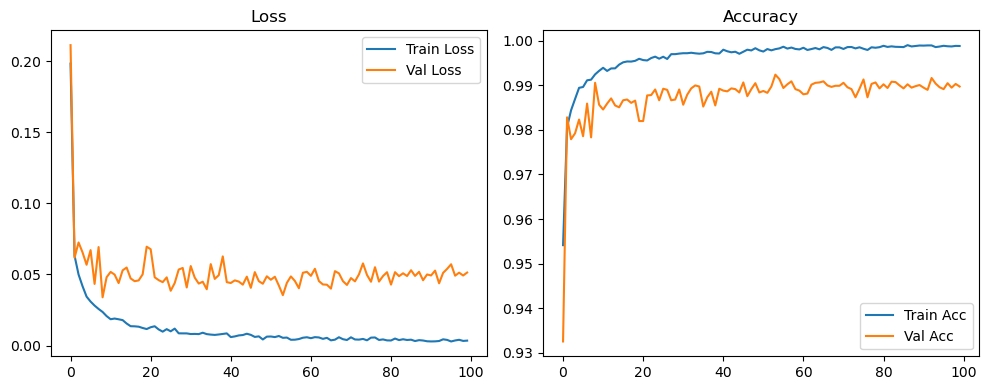

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2954, Acc: 0.9269 | Val Loss: 1.7781, Acc: 0.4205


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1291, Acc: 0.9618 | Val Loss: 0.7934, Acc: 0.7387


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1062, Acc: 0.9699 | Val Loss: 0.7797, Acc: 0.7199


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0937, Acc: 0.9724 | Val Loss: 0.8085, Acc: 0.7140


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0889, Acc: 0.9737 | Val Loss: 0.3960, Acc: 0.8566


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0818, Acc: 0.9758 | Val Loss: 0.5434, Acc: 0.8116


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0740, Acc: 0.9781 | Val Loss: 0.4216, Acc: 0.8510


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0715, Acc: 0.9783 | Val Loss: 0.3682, Acc: 0.8731


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0673, Acc: 0.9796 | Val Loss: 0.2288, Acc: 0.9251


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0679, Acc: 0.9798 | Val Loss: 0.2882, Acc: 0.9037


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9806 | Val Loss: 0.2156, Acc: 0.9303


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9808 | Val Loss: 0.1657, Acc: 0.9469


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9824 | Val Loss: 0.2592, Acc: 0.9096


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9821 | Val Loss: 0.2085, Acc: 0.9302


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9821 | Val Loss: 0.2657, Acc: 0.9062


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9832 | Val Loss: 0.1764, Acc: 0.9417


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0544, Acc: 0.9832 | Val Loss: 0.1986, Acc: 0.9350


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9839 | Val Loss: 0.1716, Acc: 0.9443


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9836 | Val Loss: 0.1613, Acc: 0.9450


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9837 | Val Loss: 0.1814, Acc: 0.9413


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9836 | Val Loss: 0.1857, Acc: 0.9330


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9844 | Val Loss: 0.2201, Acc: 0.9247


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9856 | Val Loss: 0.1494, Acc: 0.9494


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9851 | Val Loss: 0.1563, Acc: 0.9472


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9846 | Val Loss: 0.1580, Acc: 0.9475


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9862 | Val Loss: 0.1349, Acc: 0.9536


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9853 | Val Loss: 0.1447, Acc: 0.9523


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9868 | Val Loss: 0.1732, Acc: 0.9428


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9865 | Val Loss: 0.1784, Acc: 0.9402


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9864 | Val Loss: 0.1273, Acc: 0.9565


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9862 | Val Loss: 0.1763, Acc: 0.9420


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9869 | Val Loss: 0.2366, Acc: 0.9202


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9877 | Val Loss: 0.1762, Acc: 0.9402


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9867 | Val Loss: 0.1256, Acc: 0.9576


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9865 | Val Loss: 0.1232, Acc: 0.9614


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9879 | Val Loss: 0.1192, Acc: 0.9621


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9874 | Val Loss: 0.1035, Acc: 0.9665


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9868 | Val Loss: 0.1941, Acc: 0.9352


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9881 | Val Loss: 0.1967, Acc: 0.9331


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9875 | Val Loss: 0.1595, Acc: 0.9483


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 0.1184, Acc: 0.9626


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9874 | Val Loss: 0.1389, Acc: 0.9543


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9880 | Val Loss: 0.1060, Acc: 0.9659


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9880 | Val Loss: 0.1362, Acc: 0.9541


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9888 | Val Loss: 0.1121, Acc: 0.9643


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9890 | Val Loss: 0.0783, Acc: 0.9748


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9888 | Val Loss: 0.1074, Acc: 0.9657


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.1267, Acc: 0.9597


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9886 | Val Loss: 0.1424, Acc: 0.9513


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9902 | Val Loss: 0.0920, Acc: 0.9695


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9895 | Val Loss: 0.0882, Acc: 0.9721


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.0963, Acc: 0.9688


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9892 | Val Loss: 0.0873, Acc: 0.9726


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9892 | Val Loss: 0.0854, Acc: 0.9751


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9890 | Val Loss: 0.1171, Acc: 0.9594


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9889 | Val Loss: 0.0900, Acc: 0.9712


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.1293, Acc: 0.9563


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9893 | Val Loss: 0.1026, Acc: 0.9661


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9890 | Val Loss: 0.0928, Acc: 0.9711


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.0839, Acc: 0.9723


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.0788, Acc: 0.9757


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.0618, Acc: 0.9811


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9898 | Val Loss: 0.0712, Acc: 0.9771


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 0.0774, Acc: 0.9754


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9894 | Val Loss: 0.1030, Acc: 0.9663


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9902 | Val Loss: 0.1039, Acc: 0.9654


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9894 | Val Loss: 0.0842, Acc: 0.9734


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9891 | Val Loss: 0.0786, Acc: 0.9755


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.0848, Acc: 0.9708


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.0739, Acc: 0.9768


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9905 | Val Loss: 0.0976, Acc: 0.9689


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9905 | Val Loss: 0.0981, Acc: 0.9689


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9898 | Val Loss: 0.0834, Acc: 0.9733


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.1061, Acc: 0.9658


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9904 | Val Loss: 0.0711, Acc: 0.9768


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0793, Acc: 0.9749


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9911 | Val Loss: 0.0691, Acc: 0.9777


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9901 | Val Loss: 0.0817, Acc: 0.9733


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9906 | Val Loss: 0.0685, Acc: 0.9786


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9904 | Val Loss: 0.0761, Acc: 0.9743


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0747, Acc: 0.9762


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9906 | Val Loss: 0.0636, Acc: 0.9802


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9909 | Val Loss: 0.0622, Acc: 0.9812


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9903 | Val Loss: 0.0776, Acc: 0.9746


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9905 | Val Loss: 0.0920, Acc: 0.9723


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.0767, Acc: 0.9747


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.0703, Acc: 0.9772


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9904 | Val Loss: 0.0868, Acc: 0.9718


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.0574, Acc: 0.9827


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9907 | Val Loss: 0.0741, Acc: 0.9776


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.0575, Acc: 0.9816


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9919 | Val Loss: 0.0593, Acc: 0.9816


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9909 | Val Loss: 0.0641, Acc: 0.9803


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9908 | Val Loss: 0.0791, Acc: 0.9747


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9912 | Val Loss: 0.0738, Acc: 0.9765


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9912 | Val Loss: 0.0587, Acc: 0.9822


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9918 | Val Loss: 0.0543, Acc: 0.9842


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.0705, Acc: 0.9787


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9913 | Val Loss: 0.0726, Acc: 0.9792


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.0630, Acc: 0.9802


Final Test Loss: 0.0639 Accuracy: 0.9791


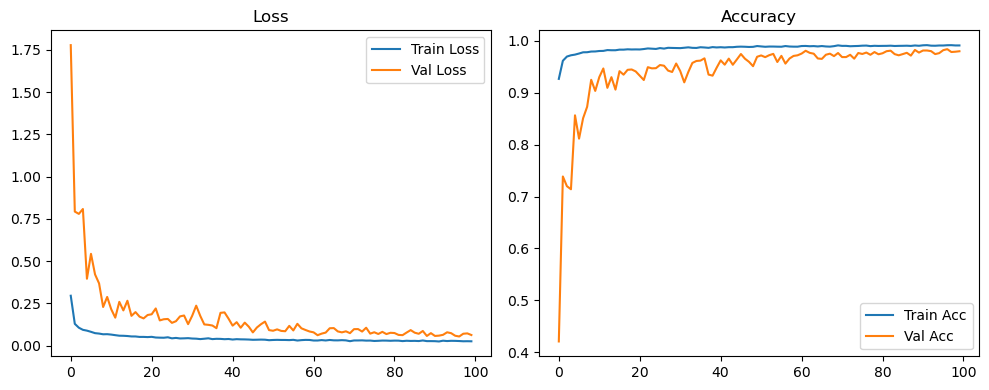

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1680, Acc: 0.9628 | Val Loss: 0.0684, Acc: 0.9784


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9864 | Val Loss: 0.0417, Acc: 0.9875


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9904 | Val Loss: 0.0452, Acc: 0.9872


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0564, Acc: 0.9838


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.0429, Acc: 0.9861


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0520, Acc: 0.9857


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0466, Acc: 0.9866


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9965 | Val Loss: 0.0413, Acc: 0.9872


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0442, Acc: 0.9875


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0445, Acc: 0.9886


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0442, Acc: 0.9884


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0519, Acc: 0.9865


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0458, Acc: 0.9893


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0577, Acc: 0.9856


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0505, Acc: 0.9894


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0546, Acc: 0.9880


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0629, Acc: 0.9869


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0697, Acc: 0.9848


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0729, Acc: 0.9841


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0576, Acc: 0.9865


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0526, Acc: 0.9893


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0486, Acc: 0.9892


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0532, Acc: 0.9897


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0532, Acc: 0.9898


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0452, Acc: 0.9903


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0451, Acc: 0.9906


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0484, Acc: 0.9902


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0527, Acc: 0.9901


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0623, Acc: 0.9878


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0679, Acc: 0.9868


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0592, Acc: 0.9888


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0587, Acc: 0.9890


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9984 | Val Loss: 0.0555, Acc: 0.9898


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0548, Acc: 0.9897


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.0595, Acc: 0.9890


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0595, Acc: 0.9885


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0487, Acc: 0.9905


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0620, Acc: 0.9896


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0531, Acc: 0.9904


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0496, Acc: 0.9905


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0577, Acc: 0.9912


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0584, Acc: 0.9898


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0656, Acc: 0.9884


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0595, Acc: 0.9902


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0535, Acc: 0.9907


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0644, Acc: 0.9897


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0538, Acc: 0.9907


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0607, Acc: 0.9897


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0673, Acc: 0.9899


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0614, Acc: 0.9898


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0511, Acc: 0.9910


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0530, Acc: 0.9912


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0531, Acc: 0.9914


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0538, Acc: 0.9920


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9922


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9920


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9923


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9920


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0555, Acc: 0.9921


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9924


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9930


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0541, Acc: 0.9922


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0523, Acc: 0.9924


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0523, Acc: 0.9921


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9918


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0537, Acc: 0.9908


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9920


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0541, Acc: 0.9919


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9920


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9910


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0571, Acc: 0.9916


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0624, Acc: 0.9913


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0587, Acc: 0.9919


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0554, Acc: 0.9918


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0574, Acc: 0.9912


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0508, Acc: 0.9922


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0632, Acc: 0.9905


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0548, Acc: 0.9918


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0617, Acc: 0.9909


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0587, Acc: 0.9918


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9918


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0572, Acc: 0.9917


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0586, Acc: 0.9921


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9916


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0561, Acc: 0.9919


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0553, Acc: 0.9917


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0554, Acc: 0.9916


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0540, Acc: 0.9917


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0546, Acc: 0.9919


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0583, Acc: 0.9913


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0551, Acc: 0.9923


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0548, Acc: 0.9916


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0552, Acc: 0.9919


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0573, Acc: 0.9912


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0570, Acc: 0.9915


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0546, Acc: 0.9914


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9916


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0602, Acc: 0.9923


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0619, Acc: 0.9922


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9919


Final Test Loss: 0.0514 Accuracy: 0.9909


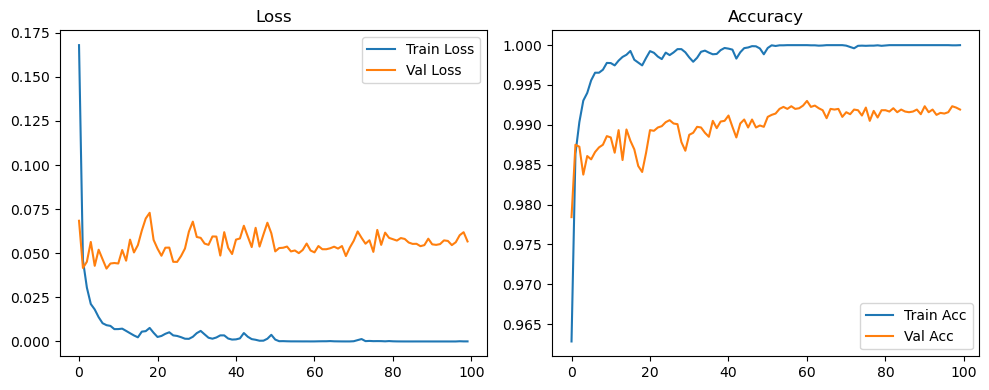

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1979, Acc: 0.9543 | Val Loss: 0.2149, Acc: 0.9316


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0641, Acc: 0.9808 | Val Loss: 0.0644, Acc: 0.9808


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9829 | Val Loss: 0.0838, Acc: 0.9750


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9871 | Val Loss: 0.0656, Acc: 0.9807


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9885 | Val Loss: 0.0780, Acc: 0.9745


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.0592, Acc: 0.9810


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.0522, Acc: 0.9838


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9922 | Val Loss: 0.0446, Acc: 0.9864


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.0397, Acc: 0.9874


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9923 | Val Loss: 0.0466, Acc: 0.9860


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9932 | Val Loss: 0.0422, Acc: 0.9877


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.0387, Acc: 0.9895


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.0449, Acc: 0.9872


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0411, Acc: 0.9888


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.0405, Acc: 0.9883


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0571, Acc: 0.9852


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.0373, Acc: 0.9911


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0473, Acc: 0.9872


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.0457, Acc: 0.9864


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0537, Acc: 0.9860


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0536, Acc: 0.9849


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.0466, Acc: 0.9888


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.0438, Acc: 0.9892


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.0428, Acc: 0.9888


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.0455, Acc: 0.9877


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0421, Acc: 0.9883


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9967 | Val Loss: 0.0504, Acc: 0.9860


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0369, Acc: 0.9912


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0447, Acc: 0.9889


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0465, Acc: 0.9874


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0484, Acc: 0.9882


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.0457, Acc: 0.9894


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0508, Acc: 0.9879


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0461, Acc: 0.9879


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0467, Acc: 0.9882


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0503, Acc: 0.9872


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0448, Acc: 0.9895


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.0451, Acc: 0.9891


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0492, Acc: 0.9882


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0371, Acc: 0.9908


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9975 | Val Loss: 0.0426, Acc: 0.9898


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0455, Acc: 0.9896


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0420, Acc: 0.9906


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0450, Acc: 0.9879


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0448, Acc: 0.9902


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0440, Acc: 0.9903


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0535, Acc: 0.9873


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0440, Acc: 0.9900


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0430, Acc: 0.9903


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0479, Acc: 0.9888


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0401, Acc: 0.9917


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0423, Acc: 0.9905


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0384, Acc: 0.9917


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0381, Acc: 0.9916


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0387, Acc: 0.9913


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0353, Acc: 0.9922


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0376, Acc: 0.9916


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0370, Acc: 0.9916


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0379, Acc: 0.9922


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0470, Acc: 0.9895


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0414, Acc: 0.9912


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0431, Acc: 0.9914


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0424, Acc: 0.9911


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0409, Acc: 0.9911


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0419, Acc: 0.9918


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0462, Acc: 0.9899


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0435, Acc: 0.9918


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0458, Acc: 0.9911


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0424, Acc: 0.9912


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0412, Acc: 0.9916


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0430, Acc: 0.9907


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0506, Acc: 0.9890


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0481, Acc: 0.9901


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0429, Acc: 0.9908


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0464, Acc: 0.9905


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0463, Acc: 0.9902


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0454, Acc: 0.9906


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0483, Acc: 0.9891


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0414, Acc: 0.9913


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0455, Acc: 0.9905


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0451, Acc: 0.9905


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0450, Acc: 0.9911


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0430, Acc: 0.9918


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0425, Acc: 0.9918


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0437, Acc: 0.9919


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0418, Acc: 0.9905


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0451, Acc: 0.9908


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0437, Acc: 0.9913


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0433, Acc: 0.9915


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0445, Acc: 0.9913


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0477, Acc: 0.9908


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0448, Acc: 0.9910


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0454, Acc: 0.9914


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0455, Acc: 0.9907


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0484, Acc: 0.9902


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0463, Acc: 0.9907


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0466, Acc: 0.9911


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0472, Acc: 0.9902


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0439, Acc: 0.9921


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0451, Acc: 0.9912


Final Test Loss: 0.0422 Accuracy: 0.9914


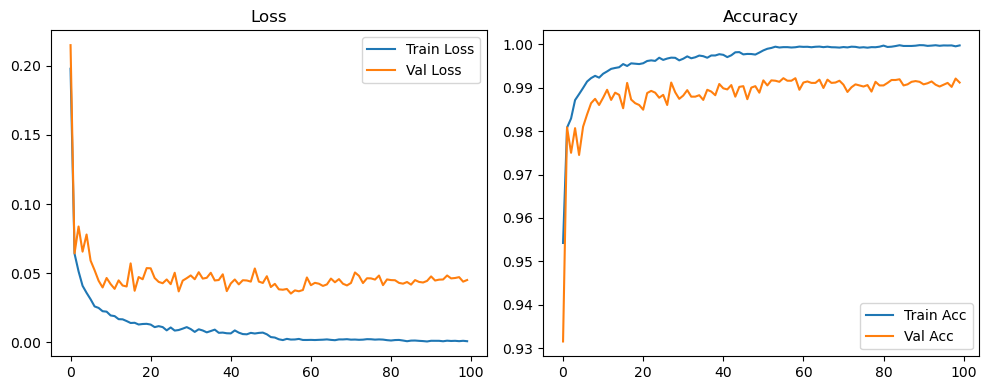

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2955, Acc: 0.9267 | Val Loss: 1.4882, Acc: 0.5057


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1290, Acc: 0.9622 | Val Loss: 0.7564, Acc: 0.7481


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1066, Acc: 0.9691 | Val Loss: 0.7716, Acc: 0.7176


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0922, Acc: 0.9732 | Val Loss: 0.6485, Acc: 0.7699


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0884, Acc: 0.9738 | Val Loss: 0.3414, Acc: 0.8828


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0831, Acc: 0.9751 | Val Loss: 0.3448, Acc: 0.8881


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0755, Acc: 0.9775 | Val Loss: 0.3552, Acc: 0.8755


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9779 | Val Loss: 0.3570, Acc: 0.8782


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9803 | Val Loss: 0.2834, Acc: 0.9049


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0692, Acc: 0.9796 | Val Loss: 0.3036, Acc: 0.8998


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0659, Acc: 0.9802 | Val Loss: 0.2003, Acc: 0.9349


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9817 | Val Loss: 0.2349, Acc: 0.9180


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0592, Acc: 0.9818 | Val Loss: 0.1717, Acc: 0.9431


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9819 | Val Loss: 0.2062, Acc: 0.9327


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9824 | Val Loss: 0.1742, Acc: 0.9430


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9830 | Val Loss: 0.2146, Acc: 0.9308


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9836 | Val Loss: 0.2136, Acc: 0.9300


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9842 | Val Loss: 0.1903, Acc: 0.9393


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9836 | Val Loss: 0.1306, Acc: 0.9578


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9841 | Val Loss: 0.1595, Acc: 0.9495


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9844 | Val Loss: 0.1297, Acc: 0.9573


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9845 | Val Loss: 0.1975, Acc: 0.9340


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9851 | Val Loss: 0.1290, Acc: 0.9586


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9847 | Val Loss: 0.1712, Acc: 0.9427


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9846 | Val Loss: 0.1423, Acc: 0.9548


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9861 | Val Loss: 0.1217, Acc: 0.9615


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9856 | Val Loss: 0.1193, Acc: 0.9606


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9868 | Val Loss: 0.1313, Acc: 0.9597


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9871 | Val Loss: 0.2188, Acc: 0.9293


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9858 | Val Loss: 0.1112, Acc: 0.9639


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9866 | Val Loss: 0.1062, Acc: 0.9663


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9867 | Val Loss: 0.1443, Acc: 0.9522


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9871 | Val Loss: 0.1871, Acc: 0.9354


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9872 | Val Loss: 0.1023, Acc: 0.9663


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9869 | Val Loss: 0.0908, Acc: 0.9709


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9876 | Val Loss: 0.1062, Acc: 0.9669


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9865 | Val Loss: 0.1017, Acc: 0.9663


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9875 | Val Loss: 0.1129, Acc: 0.9627


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9877 | Val Loss: 0.0940, Acc: 0.9688


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9889 | Val Loss: 0.1347, Acc: 0.9534


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9880 | Val Loss: 0.0866, Acc: 0.9709


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9867 | Val Loss: 0.1726, Acc: 0.9428


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9889 | Val Loss: 0.1011, Acc: 0.9670


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9877 | Val Loss: 0.1401, Acc: 0.9539


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9890 | Val Loss: 0.0895, Acc: 0.9707


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9886 | Val Loss: 0.0975, Acc: 0.9688


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9882 | Val Loss: 0.1269, Acc: 0.9587


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.1248, Acc: 0.9588


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 0.1220, Acc: 0.9582


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9890 | Val Loss: 0.0926, Acc: 0.9696


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0813, Acc: 0.9722


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9911 | Val Loss: 0.0803, Acc: 0.9743


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.0891, Acc: 0.9712


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9917 | Val Loss: 0.0761, Acc: 0.9752


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9922 | Val Loss: 0.0924, Acc: 0.9684


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0818, Acc: 0.9726


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.0734, Acc: 0.9758


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.0839, Acc: 0.9709


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.0812, Acc: 0.9732


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9914 | Val Loss: 0.0827, Acc: 0.9715


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.0708, Acc: 0.9768


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.0661, Acc: 0.9781


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0784, Acc: 0.9756


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9919 | Val Loss: 0.0655, Acc: 0.9788


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.0915, Acc: 0.9692


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.0821, Acc: 0.9734


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.0746, Acc: 0.9758


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9915 | Val Loss: 0.0661, Acc: 0.9799


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.0824, Acc: 0.9732


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9928 | Val Loss: 0.0644, Acc: 0.9796


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0702, Acc: 0.9772


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9916 | Val Loss: 0.0797, Acc: 0.9756


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0684, Acc: 0.9787


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.0858, Acc: 0.9711


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9927 | Val Loss: 0.0685, Acc: 0.9777


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.0635, Acc: 0.9807


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.0809, Acc: 0.9722


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9931 | Val Loss: 0.0842, Acc: 0.9723


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.0663, Acc: 0.9793


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0753, Acc: 0.9758


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0800, Acc: 0.9736


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.0767, Acc: 0.9752


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.0739, Acc: 0.9754


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.0697, Acc: 0.9771


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9923 | Val Loss: 0.0658, Acc: 0.9782


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.0737, Acc: 0.9761


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.0668, Acc: 0.9787


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0644, Acc: 0.9791


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0607, Acc: 0.9806


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9943 | Val Loss: 0.0651, Acc: 0.9803


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.0730, Acc: 0.9775


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.0641, Acc: 0.9792


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0617, Acc: 0.9807


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.0695, Acc: 0.9777


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.0672, Acc: 0.9791


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.0637, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0568, Acc: 0.9831


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.0638, Acc: 0.9787


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0597, Acc: 0.9810


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9933 | Val Loss: 0.0578, Acc: 0.9824


Final Test Loss: 0.0590 Accuracy: 0.9825


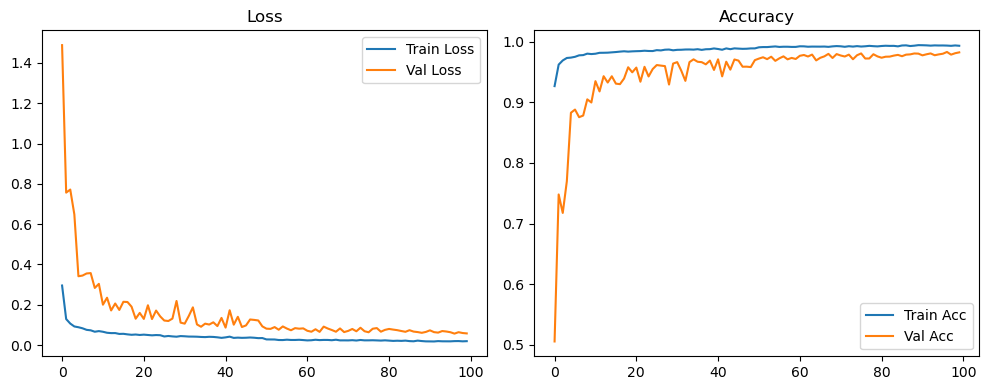

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2406, Acc: 0.9613 | Val Loss: 0.0723, Acc: 0.9822


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0500, Acc: 0.9861 | Val Loss: 0.0470, Acc: 0.9868


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9906 | Val Loss: 0.0428, Acc: 0.9885


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9941 | Val Loss: 0.0466, Acc: 0.9856


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9953 | Val Loss: 0.0405, Acc: 0.9882


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9965 | Val Loss: 0.0359, Acc: 0.9891


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9976 | Val Loss: 0.0390, Acc: 0.9882


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.0456, Acc: 0.9876


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0387, Acc: 0.9878


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.0491, Acc: 0.9868


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0553, Acc: 0.9851


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0447, Acc: 0.9872


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.0507, Acc: 0.9868


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0494, Acc: 0.9871


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0524, Acc: 0.9860


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0635, Acc: 0.9839


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0436, Acc: 0.9893


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.0562, Acc: 0.9871


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0483, Acc: 0.9885


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0616, Acc: 0.9849


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0474, Acc: 0.9884


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0599, Acc: 0.9868


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1183, Acc: 0.9744


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0621, Acc: 0.9853


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0475, Acc: 0.9882


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0478, Acc: 0.9886


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0508, Acc: 0.9882


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0439, Acc: 0.9895


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0482, Acc: 0.9891


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0492, Acc: 0.9888


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0458, Acc: 0.9881


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0481, Acc: 0.9890


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0651, Acc: 0.9858


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0503, Acc: 0.9890


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0552, Acc: 0.9868


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0541, Acc: 0.9878


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0458, Acc: 0.9897


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0462, Acc: 0.9892


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0459, Acc: 0.9899


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0511, Acc: 0.9895


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0643, Acc: 0.9873


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0604, Acc: 0.9862


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0531, Acc: 0.9894


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0438, Acc: 0.9913


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0494, Acc: 0.9895


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0574, Acc: 0.9888


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0535, Acc: 0.9901


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0467, Acc: 0.9906


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0496, Acc: 0.9904


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0465, Acc: 0.9902


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0514, Acc: 0.9889


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0558, Acc: 0.9892


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0564, Acc: 0.9890


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0580, Acc: 0.9891


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0593, Acc: 0.9878


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0686, Acc: 0.9871


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0667, Acc: 0.9856


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0501, Acc: 0.9892


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0458, Acc: 0.9904


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0410, Acc: 0.9912


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9914


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9905


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0611, Acc: 0.9878


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0516, Acc: 0.9907


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0606, Acc: 0.9890


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0582, Acc: 0.9875


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0540, Acc: 0.9891


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0484, Acc: 0.9909


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0519, Acc: 0.9895


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0524, Acc: 0.9903


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0568, Acc: 0.9892


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0505, Acc: 0.9905


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0608, Acc: 0.9891


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0484, Acc: 0.9908


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0507, Acc: 0.9911


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0534, Acc: 0.9898


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0558, Acc: 0.9898


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0498, Acc: 0.9906


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0568, Acc: 0.9895


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0498, Acc: 0.9902


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0534, Acc: 0.9895


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0572, Acc: 0.9900


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0558, Acc: 0.9900


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0591, Acc: 0.9898


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0565, Acc: 0.9890


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0474, Acc: 0.9912


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0505, Acc: 0.9911


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0577, Acc: 0.9893


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0593, Acc: 0.9902


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9908


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0619, Acc: 0.9886


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0497, Acc: 0.9911


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9905


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0695, Acc: 0.9890


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0619, Acc: 0.9898


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0669, Acc: 0.9888


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0623, Acc: 0.9895


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0618, Acc: 0.9888


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.0702, Acc: 0.9880


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0594, Acc: 0.9886


Final Test Loss: 0.0600 Accuracy: 0.9896


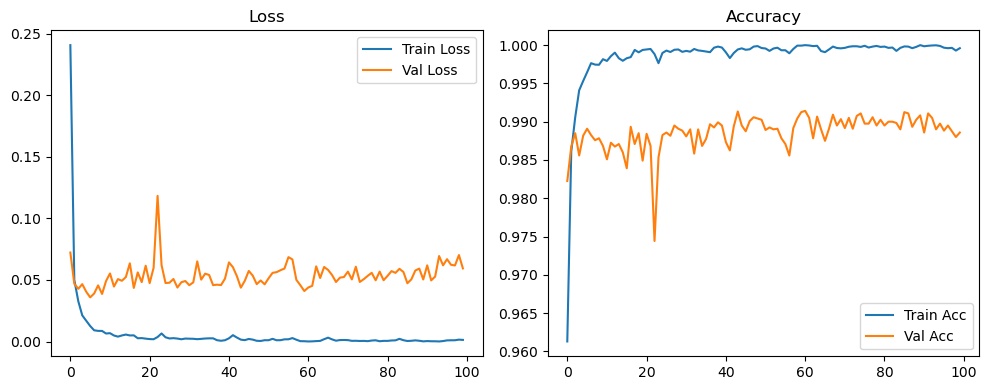

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2763, Acc: 0.9535 | Val Loss: 0.2018, Acc: 0.9503


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0691, Acc: 0.9817 | Val Loss: 0.0813, Acc: 0.9802


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9855 | Val Loss: 0.1205, Acc: 0.9649


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9873 | Val Loss: 0.0801, Acc: 0.9765


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9898 | Val Loss: 0.0711, Acc: 0.9791


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9907 | Val Loss: 0.0579, Acc: 0.9828


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.0473, Acc: 0.9851


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.0449, Acc: 0.9859


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 0.0421, Acc: 0.9875


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0457, Acc: 0.9867


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9931 | Val Loss: 0.0410, Acc: 0.9882


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.0430, Acc: 0.9881


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.0449, Acc: 0.9868


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0444, Acc: 0.9880


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.0453, Acc: 0.9868


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0591, Acc: 0.9841


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0424, Acc: 0.9878


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9958 | Val Loss: 0.0522, Acc: 0.9842


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0412, Acc: 0.9888


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0508, Acc: 0.9859


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.0465, Acc: 0.9871


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.0567, Acc: 0.9840


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0459, Acc: 0.9876


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0435, Acc: 0.9881


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0433, Acc: 0.9888


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0378, Acc: 0.9894


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0463, Acc: 0.9874


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0461, Acc: 0.9884


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0370, Acc: 0.9911


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0445, Acc: 0.9881


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0433, Acc: 0.9889


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0506, Acc: 0.9862


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0457, Acc: 0.9882


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.0448, Acc: 0.9884


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0428, Acc: 0.9882


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0462, Acc: 0.9878


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0414, Acc: 0.9898


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0373, Acc: 0.9899


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0420, Acc: 0.9898


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0459, Acc: 0.9880


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0388, Acc: 0.9899


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0406, Acc: 0.9892


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0450, Acc: 0.9888


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0423, Acc: 0.9894


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0378, Acc: 0.9905


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0461, Acc: 0.9884


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0406, Acc: 0.9903


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0386, Acc: 0.9902


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0414, Acc: 0.9897


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0368, Acc: 0.9911


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.0391, Acc: 0.9902


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0402, Acc: 0.9899


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0466, Acc: 0.9885


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0424, Acc: 0.9892


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0465, Acc: 0.9888


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0380, Acc: 0.9912


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0419, Acc: 0.9903


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0439, Acc: 0.9895


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0454, Acc: 0.9892


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0444, Acc: 0.9883


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.0469, Acc: 0.9889


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0489, Acc: 0.9876


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0405, Acc: 0.9898


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0400, Acc: 0.9909


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0385, Acc: 0.9922


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0470, Acc: 0.9888


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0430, Acc: 0.9906


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9983 | Val Loss: 0.0459, Acc: 0.9878


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0452, Acc: 0.9892


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0445, Acc: 0.9893


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0411, Acc: 0.9911


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0447, Acc: 0.9885


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0439, Acc: 0.9915


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0503, Acc: 0.9890


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0465, Acc: 0.9900


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0441, Acc: 0.9907


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0480, Acc: 0.9884


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0336, Acc: 0.9916


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0406, Acc: 0.9906


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0419, Acc: 0.9907


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0434, Acc: 0.9901


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9986 | Val Loss: 0.0493, Acc: 0.9883


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0466, Acc: 0.9898


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0424, Acc: 0.9904


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0374, Acc: 0.9905


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0424, Acc: 0.9903


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0420, Acc: 0.9902


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0401, Acc: 0.9912


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0431, Acc: 0.9909


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0412, Acc: 0.9909


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0441, Acc: 0.9906


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0445, Acc: 0.9907


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0434, Acc: 0.9900


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0470, Acc: 0.9892


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0428, Acc: 0.9906


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0498, Acc: 0.9891


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0410, Acc: 0.9907


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0392, Acc: 0.9913


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0415, Acc: 0.9908


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0394, Acc: 0.9911


Final Test Loss: 0.0446 Accuracy: 0.9903


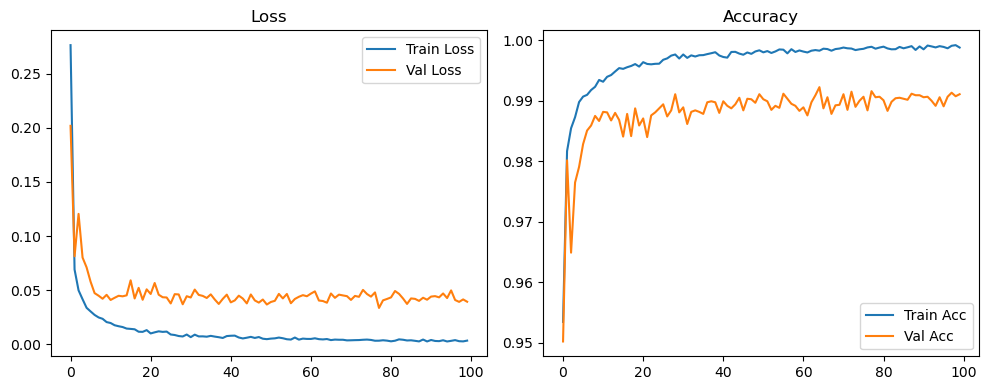

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3982, Acc: 0.9211 | Val Loss: 1.4069, Acc: 0.4718


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1371, Acc: 0.9634 | Val Loss: 0.8269, Acc: 0.7195


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1117, Acc: 0.9690 | Val Loss: 0.8885, Acc: 0.6704


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0985, Acc: 0.9720 | Val Loss: 0.5068, Acc: 0.8176


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0888, Acc: 0.9742 | Val Loss: 0.3961, Acc: 0.8652


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0850, Acc: 0.9744 | Val Loss: 0.4613, Acc: 0.8443


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0743, Acc: 0.9786 | Val Loss: 0.3806, Acc: 0.8732


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0727, Acc: 0.9788 | Val Loss: 0.3453, Acc: 0.8822


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0704, Acc: 0.9784 | Val Loss: 0.2294, Acc: 0.9257


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0663, Acc: 0.9806 | Val Loss: 0.2723, Acc: 0.9113


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0672, Acc: 0.9796 | Val Loss: 0.2176, Acc: 0.9292


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0613, Acc: 0.9811 | Val Loss: 0.1482, Acc: 0.9547


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0576, Acc: 0.9828 | Val Loss: 0.1850, Acc: 0.9418


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0590, Acc: 0.9823 | Val Loss: 0.3353, Acc: 0.8829


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9826 | Val Loss: 0.1723, Acc: 0.9446


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0573, Acc: 0.9824 | Val Loss: 0.2161, Acc: 0.9293


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0523, Acc: 0.9843 | Val Loss: 0.1927, Acc: 0.9378


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9839 | Val Loss: 0.2161, Acc: 0.9272


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0516, Acc: 0.9841 | Val Loss: 0.1451, Acc: 0.9517


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0504, Acc: 0.9843 | Val Loss: 0.1563, Acc: 0.9516


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0505, Acc: 0.9835 | Val Loss: 0.1523, Acc: 0.9509


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9858 | Val Loss: 0.1249, Acc: 0.9599


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9849 | Val Loss: 0.1053, Acc: 0.9663


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9849 | Val Loss: 0.1085, Acc: 0.9668


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9858 | Val Loss: 0.1525, Acc: 0.9505


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9869 | Val Loss: 0.1338, Acc: 0.9573


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0474, Acc: 0.9850 | Val Loss: 0.1265, Acc: 0.9565


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9868 | Val Loss: 0.1120, Acc: 0.9642


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9864 | Val Loss: 0.1229, Acc: 0.9595


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9869 | Val Loss: 0.1021, Acc: 0.9667


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9871 | Val Loss: 0.0970, Acc: 0.9701


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9873 | Val Loss: 0.1263, Acc: 0.9598


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9880 | Val Loss: 0.1010, Acc: 0.9687


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9873 | Val Loss: 0.0756, Acc: 0.9762


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9873 | Val Loss: 0.0850, Acc: 0.9743


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9887 | Val Loss: 0.1082, Acc: 0.9656


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9878 | Val Loss: 0.1025, Acc: 0.9677


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9876 | Val Loss: 0.1310, Acc: 0.9560


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.0842, Acc: 0.9729


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9874 | Val Loss: 0.1011, Acc: 0.9678


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9880 | Val Loss: 0.0815, Acc: 0.9752


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9882 | Val Loss: 0.1046, Acc: 0.9674


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9888 | Val Loss: 0.0873, Acc: 0.9728


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9885 | Val Loss: 0.0865, Acc: 0.9724


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9891 | Val Loss: 0.0774, Acc: 0.9751


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9890 | Val Loss: 0.0860, Acc: 0.9728


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9879 | Val Loss: 0.0993, Acc: 0.9677


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9890 | Val Loss: 0.0801, Acc: 0.9760


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9883 | Val Loss: 0.1042, Acc: 0.9654


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 0.1043, Acc: 0.9657


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9890 | Val Loss: 0.0711, Acc: 0.9782


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9899 | Val Loss: 0.0826, Acc: 0.9754


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9886 | Val Loss: 0.0964, Acc: 0.9697


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9893 | Val Loss: 0.0970, Acc: 0.9699


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.1079, Acc: 0.9645


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9901 | Val Loss: 0.1042, Acc: 0.9668


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9900 | Val Loss: 0.0930, Acc: 0.9698


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.0925, Acc: 0.9689


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.0911, Acc: 0.9713


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9895 | Val Loss: 0.0712, Acc: 0.9785


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9905 | Val Loss: 0.0659, Acc: 0.9802


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.0788, Acc: 0.9750


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9898 | Val Loss: 0.0729, Acc: 0.9781


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9909 | Val Loss: 0.0811, Acc: 0.9742


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.0792, Acc: 0.9756


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9902 | Val Loss: 0.0963, Acc: 0.9695


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9899 | Val Loss: 0.0837, Acc: 0.9739


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.0834, Acc: 0.9750


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9900 | Val Loss: 0.0707, Acc: 0.9781


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.0685, Acc: 0.9793


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.0744, Acc: 0.9773


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 0.0728, Acc: 0.9790


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.0934, Acc: 0.9698


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9905 | Val Loss: 0.0723, Acc: 0.9778


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9912 | Val Loss: 0.0871, Acc: 0.9728


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9908 | Val Loss: 0.0757, Acc: 0.9764


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.0699, Acc: 0.9782


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.0797, Acc: 0.9743


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0671, Acc: 0.9789


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.0822, Acc: 0.9719


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9912 | Val Loss: 0.0832, Acc: 0.9738


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.0798, Acc: 0.9749


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.0786, Acc: 0.9740


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9913 | Val Loss: 0.0783, Acc: 0.9758


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9908 | Val Loss: 0.0896, Acc: 0.9718


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.0732, Acc: 0.9757


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.0726, Acc: 0.9771


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.0806, Acc: 0.9735


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9910 | Val Loss: 0.0682, Acc: 0.9790


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.0950, Acc: 0.9686


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.0859, Acc: 0.9722


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.0729, Acc: 0.9777


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.0656, Acc: 0.9791


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9921 | Val Loss: 0.0661, Acc: 0.9798


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9917 | Val Loss: 0.0555, Acc: 0.9837


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0632, Acc: 0.9804


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.0658, Acc: 0.9797


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.0792, Acc: 0.9748


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0591, Acc: 0.9812


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9913 | Val Loss: 0.0554, Acc: 0.9838


Final Test Loss: 0.0552 Accuracy: 0.9827


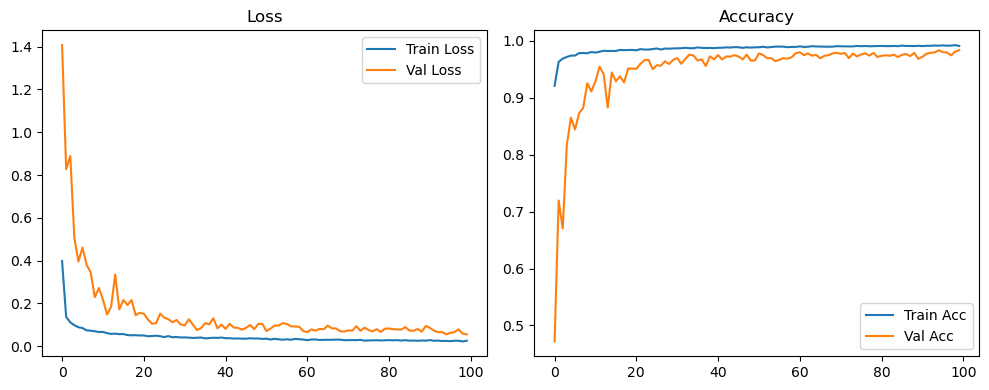

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3495, Acc: 0.9568 | Val Loss: 0.0990, Acc: 0.9836


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0668, Acc: 0.9866 | Val Loss: 0.0525, Acc: 0.9878


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9905 | Val Loss: 0.0510, Acc: 0.9861


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9939 | Val Loss: 0.0483, Acc: 0.9861


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9951 | Val Loss: 0.0431, Acc: 0.9865


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9957 | Val Loss: 0.0401, Acc: 0.9881


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9976 | Val Loss: 0.0412, Acc: 0.9872


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9978 | Val Loss: 0.0408, Acc: 0.9879


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9985 | Val Loss: 0.0453, Acc: 0.9851


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9988 | Val Loss: 0.0410, Acc: 0.9872


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9986 | Val Loss: 0.0481, Acc: 0.9860


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9987 | Val Loss: 0.0455, Acc: 0.9862


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.0469, Acc: 0.9858


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.0427, Acc: 0.9866


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.0511, Acc: 0.9850


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9991 | Val Loss: 0.0449, Acc: 0.9876


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9993 | Val Loss: 0.0438, Acc: 0.9879


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.0454, Acc: 0.9868


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0380, Acc: 0.9887


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0448, Acc: 0.9881


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.0449, Acc: 0.9879


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0515, Acc: 0.9870


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0505, Acc: 0.9863


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0547, Acc: 0.9850


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0450, Acc: 0.9877


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0416, Acc: 0.9888


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0447, Acc: 0.9882


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0470, Acc: 0.9871


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0421, Acc: 0.9898


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9896


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9899


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9889


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0656, Acc: 0.9847


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0544, Acc: 0.9875


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0591, Acc: 0.9855


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0425, Acc: 0.9884


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0450, Acc: 0.9893


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0481, Acc: 0.9874


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0452, Acc: 0.9889


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0457, Acc: 0.9892


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0505, Acc: 0.9883


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0439, Acc: 0.9894


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0492, Acc: 0.9881


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0538, Acc: 0.9868


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0490, Acc: 0.9881


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0489, Acc: 0.9882


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0511, Acc: 0.9882


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0476, Acc: 0.9888


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0457, Acc: 0.9902


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0489, Acc: 0.9896


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0625, Acc: 0.9857


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0618, Acc: 0.9862


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0526, Acc: 0.9886


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0525, Acc: 0.9880


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0574, Acc: 0.9876


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0492, Acc: 0.9902


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0510, Acc: 0.9888


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0550, Acc: 0.9881


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9898


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9907


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9894


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9902


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9890


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9892


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0487, Acc: 0.9896


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1112, Acc: 0.9772


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0536, Acc: 0.9873


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0491, Acc: 0.9889


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0488, Acc: 0.9890


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0440, Acc: 0.9906


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0644, Acc: 0.9857


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0472, Acc: 0.9891


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0490, Acc: 0.9892


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0565, Acc: 0.9880


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0518, Acc: 0.9893


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0479, Acc: 0.9892


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0667, Acc: 0.9863


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0518, Acc: 0.9889


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0549, Acc: 0.9888


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0542, Acc: 0.9881


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0534, Acc: 0.9887


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0572, Acc: 0.9884


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0496, Acc: 0.9892


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0559, Acc: 0.9878


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0503, Acc: 0.9898


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0498, Acc: 0.9888


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0502, Acc: 0.9897


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0551, Acc: 0.9892


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0614, Acc: 0.9888


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0598, Acc: 0.9890


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0595, Acc: 0.9885


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9882


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9903


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9897


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9902


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0517, Acc: 0.9906


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0862, Acc: 0.9823


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0681, Acc: 0.9858


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0641, Acc: 0.9867


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0570, Acc: 0.9891


Final Test Loss: 0.0493 Accuracy: 0.9890


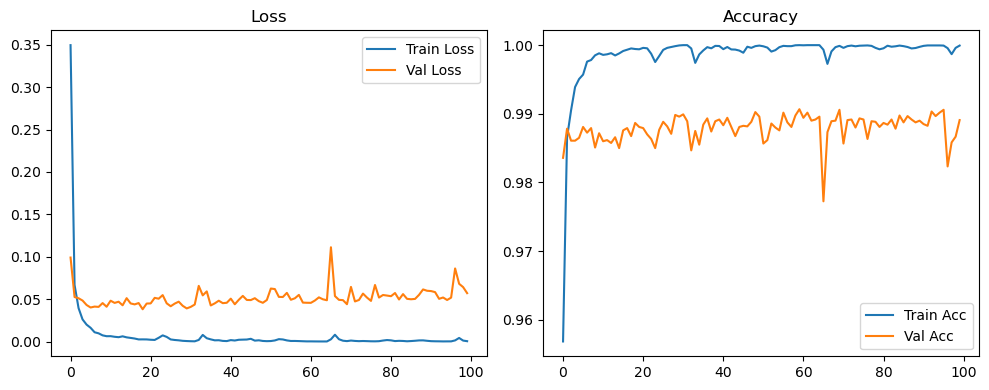

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3980, Acc: 0.9468 | Val Loss: 0.2790, Acc: 0.9519


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0881, Acc: 0.9815 | Val Loss: 0.1312, Acc: 0.9735


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0601, Acc: 0.9847 | Val Loss: 0.0860, Acc: 0.9802


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9874 | Val Loss: 0.0961, Acc: 0.9743


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9897 | Val Loss: 0.0724, Acc: 0.9801


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9903 | Val Loss: 0.0767, Acc: 0.9777


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9914 | Val Loss: 0.0499, Acc: 0.9862


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9920 | Val Loss: 0.0499, Acc: 0.9853


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9928 | Val Loss: 0.0506, Acc: 0.9852


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9934 | Val Loss: 0.0506, Acc: 0.9861


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9939 | Val Loss: 0.0512, Acc: 0.9845


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9939 | Val Loss: 0.0445, Acc: 0.9863


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.0484, Acc: 0.9858


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9948 | Val Loss: 0.0472, Acc: 0.9868


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.0500, Acc: 0.9858


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9947 | Val Loss: 0.0554, Acc: 0.9821


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.0505, Acc: 0.9847


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.0458, Acc: 0.9865


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.0486, Acc: 0.9864


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9955 | Val Loss: 0.0579, Acc: 0.9822


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.0491, Acc: 0.9843


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0567, Acc: 0.9832


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0508, Acc: 0.9851


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9956 | Val Loss: 0.0451, Acc: 0.9866


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0476, Acc: 0.9858


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0462, Acc: 0.9866


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0454, Acc: 0.9869


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0492, Acc: 0.9863


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0524, Acc: 0.9854


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0516, Acc: 0.9858


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0407, Acc: 0.9891


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0411, Acc: 0.9888


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0451, Acc: 0.9877


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0515, Acc: 0.9863


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0494, Acc: 0.9868


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0484, Acc: 0.9876


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0452, Acc: 0.9874


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0477, Acc: 0.9871


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0445, Acc: 0.9886


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0455, Acc: 0.9886


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9972 | Val Loss: 0.0522, Acc: 0.9868


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0490, Acc: 0.9879


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0595, Acc: 0.9871


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0529, Acc: 0.9873


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.0486, Acc: 0.9884


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0536, Acc: 0.9864


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0549, Acc: 0.9851


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0472, Acc: 0.9881


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0474, Acc: 0.9884


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0406, Acc: 0.9901


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0455, Acc: 0.9888


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0534, Acc: 0.9870


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0496, Acc: 0.9892


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0435, Acc: 0.9900


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0497, Acc: 0.9880


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0550, Acc: 0.9872


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0605, Acc: 0.9857


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0464, Acc: 0.9887


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0448, Acc: 0.9893


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0454, Acc: 0.9896


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0460, Acc: 0.9897


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0494, Acc: 0.9882


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0423, Acc: 0.9894


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0495, Acc: 0.9881


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0520, Acc: 0.9882


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0501, Acc: 0.9882


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0488, Acc: 0.9885


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0436, Acc: 0.9900


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0485, Acc: 0.9890


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0448, Acc: 0.9898


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0436, Acc: 0.9898


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0541, Acc: 0.9876


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0547, Acc: 0.9879


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0577, Acc: 0.9868


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0502, Acc: 0.9877


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0492, Acc: 0.9890


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0511, Acc: 0.9882


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9981 | Val Loss: 0.0454, Acc: 0.9890


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0412, Acc: 0.9901


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0524, Acc: 0.9868


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0416, Acc: 0.9907


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0400, Acc: 0.9902


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0521, Acc: 0.9872


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0463, Acc: 0.9893


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0443, Acc: 0.9898


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0475, Acc: 0.9885


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0494, Acc: 0.9885


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0428, Acc: 0.9908


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0439, Acc: 0.9894


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0542, Acc: 0.9873


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0437, Acc: 0.9911


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0518, Acc: 0.9883


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0515, Acc: 0.9896


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0471, Acc: 0.9898


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0421, Acc: 0.9907


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0480, Acc: 0.9894


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0449, Acc: 0.9902


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0514, Acc: 0.9883


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0491, Acc: 0.9881


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0485, Acc: 0.9898


Final Test Loss: 0.0463 Accuracy: 0.9882


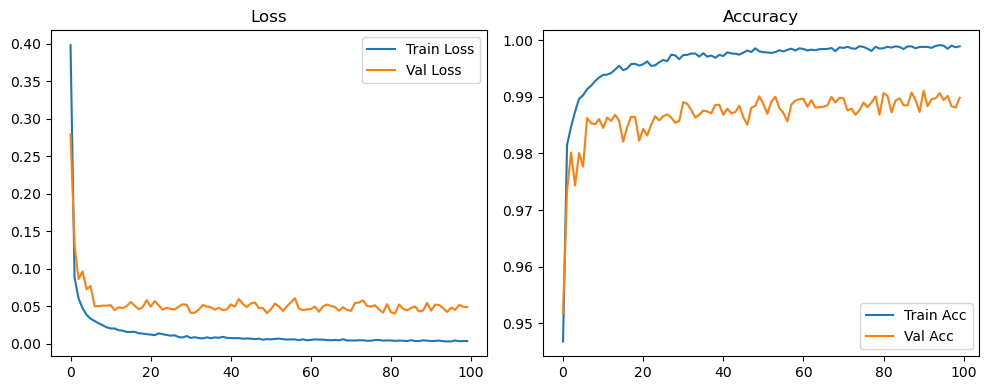

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5522, Acc: 0.9053 | Val Loss: 1.4661, Acc: 0.4025


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1704, Acc: 0.9633 | Val Loss: 1.0076, Acc: 0.6387


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1253, Acc: 0.9698 | Val Loss: 1.0466, Acc: 0.5984


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1078, Acc: 0.9708 | Val Loss: 0.7677, Acc: 0.7095


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0973, Acc: 0.9739 | Val Loss: 0.4086, Acc: 0.8660


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0923, Acc: 0.9732 | Val Loss: 0.5572, Acc: 0.8062


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0807, Acc: 0.9774 | Val Loss: 0.3821, Acc: 0.8711


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0788, Acc: 0.9773 | Val Loss: 0.3781, Acc: 0.8737


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0726, Acc: 0.9791 | Val Loss: 0.2846, Acc: 0.9067


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0740, Acc: 0.9787 | Val Loss: 0.2831, Acc: 0.9103


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0706, Acc: 0.9793 | Val Loss: 0.3113, Acc: 0.8942


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0675, Acc: 0.9799 | Val Loss: 0.2326, Acc: 0.9258


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0629, Acc: 0.9817 | Val Loss: 0.1996, Acc: 0.9361


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0625, Acc: 0.9820 | Val Loss: 0.2937, Acc: 0.9013


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0593, Acc: 0.9824 | Val Loss: 0.2484, Acc: 0.9177


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0583, Acc: 0.9827 | Val Loss: 0.3112, Acc: 0.8959


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0582, Acc: 0.9828 | Val Loss: 0.2005, Acc: 0.9353


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0542, Acc: 0.9838 | Val Loss: 0.1991, Acc: 0.9336


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0550, Acc: 0.9829 | Val Loss: 0.1889, Acc: 0.9384


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0544, Acc: 0.9839 | Val Loss: 0.1884, Acc: 0.9413


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0554, Acc: 0.9835 | Val Loss: 0.1849, Acc: 0.9424


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0547, Acc: 0.9838 | Val Loss: 0.2297, Acc: 0.9215


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9849 | Val Loss: 0.1474, Acc: 0.9533


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0511, Acc: 0.9846 | Val Loss: 0.1711, Acc: 0.9458


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0500, Acc: 0.9852 | Val Loss: 0.1924, Acc: 0.9373


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0468, Acc: 0.9851 | Val Loss: 0.1804, Acc: 0.9416


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9852 | Val Loss: 0.2178, Acc: 0.9286


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9856 | Val Loss: 0.1629, Acc: 0.9469


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0470, Acc: 0.9855 | Val Loss: 0.1346, Acc: 0.9577


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9854 | Val Loss: 0.1166, Acc: 0.9644


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0438, Acc: 0.9863 | Val Loss: 0.1272, Acc: 0.9602


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9868 | Val Loss: 0.1574, Acc: 0.9507


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0404, Acc: 0.9878 | Val Loss: 0.1345, Acc: 0.9558


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9867 | Val Loss: 0.1183, Acc: 0.9619


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0417, Acc: 0.9870 | Val Loss: 0.0956, Acc: 0.9702


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9872 | Val Loss: 0.1649, Acc: 0.9465


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9877 | Val Loss: 0.1212, Acc: 0.9613


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9873 | Val Loss: 0.1412, Acc: 0.9547


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9872 | Val Loss: 0.1146, Acc: 0.9643


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9872 | Val Loss: 0.1271, Acc: 0.9577


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9875 | Val Loss: 0.1116, Acc: 0.9641


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9880 | Val Loss: 0.1434, Acc: 0.9548


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9877 | Val Loss: 0.1390, Acc: 0.9562


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9876 | Val Loss: 0.1113, Acc: 0.9650


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9880 | Val Loss: 0.0969, Acc: 0.9701


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9884 | Val Loss: 0.1068, Acc: 0.9658


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9874 | Val Loss: 0.1304, Acc: 0.9560


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9885 | Val Loss: 0.1086, Acc: 0.9643


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9876 | Val Loss: 0.1331, Acc: 0.9569


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.1431, Acc: 0.9543


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9882 | Val Loss: 0.1357, Acc: 0.9554


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9893 | Val Loss: 0.1310, Acc: 0.9579


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9892 | Val Loss: 0.1286, Acc: 0.9584


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9885 | Val Loss: 0.1161, Acc: 0.9638


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9890 | Val Loss: 0.1032, Acc: 0.9665


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.1118, Acc: 0.9655


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9895 | Val Loss: 0.1000, Acc: 0.9690


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 0.0916, Acc: 0.9692


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9890 | Val Loss: 0.0814, Acc: 0.9742


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9892 | Val Loss: 0.0974, Acc: 0.9694


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.1077, Acc: 0.9664


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9899 | Val Loss: 0.0972, Acc: 0.9700


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9896 | Val Loss: 0.0832, Acc: 0.9732


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9898 | Val Loss: 0.0904, Acc: 0.9714


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9893 | Val Loss: 0.1087, Acc: 0.9653


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9900 | Val Loss: 0.1172, Acc: 0.9621


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9900 | Val Loss: 0.0915, Acc: 0.9722


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9895 | Val Loss: 0.1064, Acc: 0.9670


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9900 | Val Loss: 0.1011, Acc: 0.9681


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9899 | Val Loss: 0.0808, Acc: 0.9756


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9904 | Val Loss: 0.0808, Acc: 0.9745


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9894 | Val Loss: 0.0888, Acc: 0.9716


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9896 | Val Loss: 0.0892, Acc: 0.9724


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9894 | Val Loss: 0.0984, Acc: 0.9682


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9908 | Val Loss: 0.0839, Acc: 0.9746


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.0999, Acc: 0.9699


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.0957, Acc: 0.9691


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9906 | Val Loss: 0.0898, Acc: 0.9712


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.0868, Acc: 0.9738


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9903 | Val Loss: 0.0941, Acc: 0.9709


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9904 | Val Loss: 0.0955, Acc: 0.9703


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9900 | Val Loss: 0.0960, Acc: 0.9692


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.0794, Acc: 0.9757


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0856, Acc: 0.9735


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.0962, Acc: 0.9688


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.0869, Acc: 0.9733


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.0779, Acc: 0.9761


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9910 | Val Loss: 0.0761, Acc: 0.9778


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9911 | Val Loss: 0.0720, Acc: 0.9781


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.1059, Acc: 0.9637


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9910 | Val Loss: 0.0885, Acc: 0.9728


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9913 | Val Loss: 0.0813, Acc: 0.9752


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9900 | Val Loss: 0.0851, Acc: 0.9732


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.0763, Acc: 0.9759


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.0857, Acc: 0.9728


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9920 | Val Loss: 0.0902, Acc: 0.9713


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9920 | Val Loss: 0.0833, Acc: 0.9740


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.0910, Acc: 0.9705


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.0713, Acc: 0.9778


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9908 | Val Loss: 0.0976, Acc: 0.9680


Final Test Loss: 0.0938 Accuracy: 0.9693


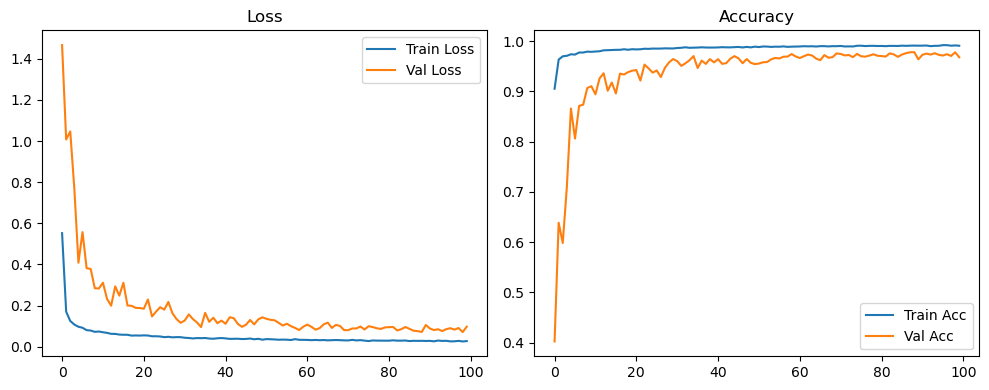

🏆 Best Config: batch64_lr0.005_0.002_0.001_dp0.0 Accuracy: 0.9927


In [8]:
root_path = "TCV_8bit_regular_SiLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)